In [75]:
# !pip install torch
# !pip install mne
# !pip install pandas
# !pip install sklearn
# !pip install seaborn
# !pip install torchsummary
# !pip install heartpy
# !pip install pyhrv
# !pip install hrv-analysis
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import xml.etree.ElementTree as ET
import os
import numpy as np
import pandas as pd
import mne
from matplotlib import pyplot as plt
from datetime import datetime
import scipy.fftpack
import pickle
import glob
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import scipy.signal as signal
import numpy
import heartpy as hp
import time
from joblib import Parallel, delayed
import multiprocessing
from hrvanalysis import get_time_domain_features, get_frequency_domain_features, remove_outliers
from scipy.signal import argrelmax, argrelmin, firwin, convolve,windows
from tqdm.notebook import tqdm

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import regex as re
import csv

import neurokit2 as nk


In [76]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.cuda.device_count())

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
1
Tesla V100-SXM2-32GB-LS
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [77]:
import re

def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)



In [78]:
def count_class(data):
    count0 = 0
    count1 = 0
    count2 = 0
    count3 = 0
    for i in data:
        if i==0:
            count0+=1
        elif i==1:
            count1+=1
        elif i==2:
            count2+=1
        elif i==3:
            count3+=1
        else:
            print(i)
    print("Normal: %d"%count0)
    print("Central Apnea: %d"%count1)
    print("Obstructive Apnea: %d"%count2)
    print("Hypopnea: %d"%count3)
    return count2+count1+count3

def rotate(l, n):
    return l[n:] + l[:n]

In [79]:
def get_subjects(select, all_x = []):
    # select_subject = 2
    normal_x=[]
    normal_y = []
    osb_ap_x=[]
    osb_ap_y = []
    hypop_x=[]
    hypop_y=[]
    cut_window = int(1800 / win_size)
    for select_subject in select:

        select_x = np.array(all_x[select_subject][cut_window:len(all_x[select_subject])-cut_window])
        select_y = np.array(train_y[select_subject][cut_window:len(all_x[select_subject])-cut_window])
#         select_x = np.array(all_x[select_subject])
#         select_y = np.array(train_y[select_subject])
        s_frame = 0
        for i in select_y:
            if i==0:
                normal_x.append(select_x[s_frame])
                normal_y.append(0)
            elif i==2:
                osb_ap_x.append(select_x[s_frame])
                osb_ap_y.append(1)
            elif i==3:
                hypop_x.append(select_x[s_frame])
                hypop_y.append(1)
            elif i==-1:
                hypop_x.append(select_x[s_frame])
                hypop_y.append(-1)
            s_frame += 1
    normal_x = np.array(normal_x)
    osb_ap_x = np.array(osb_ap_x)
    hypop_x = np.array(hypop_x)
    return normal_x,normal_y,osb_ap_x,osb_ap_y,hypop_x,hypop_y



count_o = [0,0,0]
def get_subject_multi_y(select, all_x, all_y):
    cut_window = int(1800 / win_size)
    new_x = []
    new_y = []    
    for select_subject in tqdm(select):
        trigger = False
        temp_y = []
        select_y = np.array(all_y[select_subject][cut_window:len(all_x[select_subject])-cut_window])
        for multi_y in select_y:    
            trigger=False
            if 2 in multi_y:
                count_o[0] = count_o[0] +1
            if 3 in multi_y:
                count_o[1] = count_o[1]+1
                trigger=True
            if 4 in multi_y:
                count_o[2] = count_o[2]+1
                trigger=True
            temp_y.append([1 if d in [2,3,4] else d for d in multi_y])            
#             temp_y.append([1 if d in [2] else d for d in multi_y])            
        select_x = np.array(all_x[select_subject][cut_window:len(all_x[select_subject])-cut_window])
#         if(trigger):
#             continue;
        new_x.extend(select_x)
        new_y.extend(temp_y)      
            
    return np.array(new_x), np.array(new_y)


In [80]:
from sklearn.model_selection import train_test_split
def data_split(normal_x,normal_y):
    normal_x_train, normal_x_test, normal_y_train, normal_y_test = train_test_split(normal_x, normal_y, test_size=0.30, random_state=42)
    normal_x_test, normal_x_val, normal_y_test, normal_y_val = train_test_split(normal_x_test, normal_y_test, test_size=0.50, random_state=42)

    return normal_x_train,normal_y_train,normal_x_test,normal_y_test,normal_x_val,normal_y_val

In [81]:
def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def mix_data(ori_data_ppg, ori_data_spo2, ori_data_y):    
    # Mix the datasets (to make it similar to i.i.d)
    idx = np.random.RandomState(seed=42).permutation(len(ori_data_spo2))    
    data_ppg = []
    data_spo2 = []
    data_y = []
    data_ppg_append = data_ppg.append
    data_spo2_append = data_spo2.append
    datay_append = data_y.append
    for i in tqdm(range(len(ori_data_ppg))):
        data_ppg_append(ori_data_ppg[idx[i]])
        data_spo2_append(ori_data_spo2[idx[i]])
        datay_append(ori_data_y[idx[i]])
    data_ppg = np.array(data_ppg)
    data_spo2 = np.array(data_spo2)
    data_y = np.array(data_y)
    return data_ppg, data_spo2, data_y

def resample(list_x, freq):

    re_x = []
    for i, y in enumerate(list_x):  
        re = signal.resample(y,freq) 
        re_x.append(re)
    return np.array(re_x)


def class_balancer(train_ppg, train_spo2,train_y):
    
    (unique, counts) = np.unique(train_y, return_counts=True)
#     print((unique, counts))
    count_normal = counts[0]
    count_apnea = counts[1]

    total_remove = count_normal - count_apnea
    temp_label = train_y.copy()
    delete_index = []
    for i, y in tqdm(enumerate(temp_label), total = temp_label.shape[0]):
        if y == 0 and total_remove > 0:
            total_remove -= 1
            delete_index.append(i)
#     print(len(delete_index))
    train_y = np.delete(train_y, delete_index, axis=0)   
#     train_ppg = np.delete(train_ppg, delete_index, axis=0) 
    train_spo2 = np.delete(train_spo2, delete_index, axis=0) 
    return train_ppg, train_spo2,train_y

def data_reject(train_x,train_y):
    processed_train_x = []
    processed_train_y = []
    no_reject = 0
    for i in tqdm(range(len(train_x))):
        signal = np.array(train_x[i])
        signal = signal.reshape(-1)
        signal = smooth_ppg_signal(signal,sample_rate=256)
        signal = np.array(signal)
        extrema_index = np.sort(np.unique(np.concatenate((argrelmax(signal)[0], argrelmin(signal)[0]))))
        extrema = signal[extrema_index]
        hr = (np.diff(extrema_index[extrema>0])/256.0)
        if(train_y[i] != 1): #Reject only normal case
            if(any(hr) <0.025 or any(hr<0.005)):
                no_reject = no_reject+1
#             print("Reject")
                continue;   
        processed_train_x.append(signal)
        processed_train_y.append(train_y[i])
    print("Reject Total :",no_reject)
    return np.array(processed_train_x),np.array(processed_train_y)

def smooth_ppg_signal(signal, sample_rate=64, numtaps=20, cutoff=[0.5,5]):
    if numtaps % 2 == 0:
        numtaps += 1
    return convolve(signal, firwin(numtaps, [x*2/sample_rate for x in cutoff], pass_zero=False), mode='valid').tolist()

def reject_desat(x_spo2, x_ppg, y):
    delete_index = []
    count = 0
    for i, spo2 in enumerate(x_spo2):
        odi = np.max(spo2) - np.min(spo2)
#         print(np.max(spo2), np.min(spo2))
        if (odi < 3 and y[i]>0):#or (odi > 3 and y_train[i] == 0) :
            delete_index.append(i)
            count+= 1
    x_ppg = np.delete(x_ppg, delete_index, axis=0) 
    x_spo2 = np.delete(x_spo2, delete_index, axis=0) 
    y = np.delete(y, delete_index, axis=0)
    print('total rejected',count)
    return x_spo2, x_ppg, y


In [82]:
def pre_process(dat):
    processed = []
    app = processed.append
    for i in dat:
        b, a = signal.butter(4, [0.1,20],btype='band',fs=hz)
        temp = signal.filtfilt(b, a, i,padlen=0)
#         temp = np.diff(running_mean(temp,64))
        app(temp)
    return np.array(processed)

def Standardize_by_time(train, val, test):
     # Create the Scaler object
    
    scaled_train, scaled_val, scaled_test = [], [], []
    train_sample, time, channels = train.shape[0], train.shape[1], train.shape[2]
    for i in tqdm(range(time)):
        scaler = RobustScaler()
        scaler.fit(train[:, i, :])
        scaled_train.append(scaler.transform(train[:, i, :]))
        scaled_val.append(scaler.transform(val[:, i,  :]))
        scaled_test.append(scaler.transform(test[:, i,  :]))
    train, val, test = np.array(scaled_train), np.array(scaled_val), np.array(scaled_test)
    train = np.swapaxes(train, 0, 1)
    val = np.swapaxes(val, 0, 1)
    test = np.swapaxes(test, 0, 1)
    return train, val, test

def Standardize_by_window(train, val, test):
     # Create the Scaler object
    scaler = StandardScaler()
    train_sample, time, channels = train.shape[0], train.shape[1], train.shape[2]
    scaler.fit(train[:, :, 0])
    scaled_train = scaler.transform(train[:, :, 0])
    scaled_val = scaler.transform(val[:,  :, 0])
    scaled_test = scaler.transform(test[:, :, 0])
#     train, val, test = np.array(scaled_train), np.array(scaled_val), np.array(scaled_test)
    scaled_train = scaled_train.reshape(scaled_train.shape[0], scaled_train.shape[1], 1)
    scaled_val = scaled_val.reshape(scaled_val.shape[0], scaled_val.shape[1], 1)
    scaled_test = scaled_test.reshape(scaled_test.shape[0], scaled_test.shape[1], 1)
    return scaled_train, scaled_val, scaled_test

def reject_artifact(x_spo2, x_ppg, y):
    delete_index = []
    count = 0
    for i, x in enumerate(x_spo2):
        if(np.min(x) < 60):
            delete_index.append(i)
            count+= 1
    x_spo2 = np.delete(x_spo2, delete_index, axis=0) 
    x_ppg = np.delete(x_ppg, delete_index, axis=0) 
    y = np.delete(y, delete_index, axis=0)
    print('total error',count)
    return x_spo2, x_ppg, y

def convert_to_sec_data(train_spo2):
    result = []
    for window in train_spo2:
        sec = []
        for i in range(0, window.shape[0], hz):
#             print(i, window[i])
            sec.append(window[i])
        result.append(sec)
        
    return np.array(result)

def reject_contaminate(x_spo2, x_ppg, y):
    delete_index = []
    count = 0
    for i, gt in enumerate(y):
        if(gt == -1):
            delete_index.append(i)
            count+= 1
    x_spo2 = np.delete(x_spo2, delete_index, axis=0) 
    x_ppg = np.delete(x_ppg, delete_index, axis=0) 
    y = np.delete(y, delete_index, axis=0)
    print('total contaminate',count)
    return x_spo2, x_ppg, y

def convert_contaminate(train_y):
    return [ 1 if y == -1 else y for y in train_y ]

def remove_all_zero_y(all_ppg, all_spo2, all_y):
    delete_index = []          
    
    count = 0
    for i, y in enumerate(all_y):
        if not np.any(y):
            delete_index.append(i)
            count += 1            
    all_y = np.delete(all_y, delete_index, axis=0) 
    all_ppg = np.delete(all_ppg, delete_index, axis=0) 
    all_spo2 = np.delete(all_spo2, delete_index, axis=0)
    print('total zero =', count)
    return all_ppg, all_spo2, all_y

In [83]:
def convert_y_to_hz(all_y, hz):
    
    result = []
    for window in tqdm(all_y):
        y_extend = []
        for i in range(0, window.shape[0]):
#             print(i, window[i])
            y_extend.extend([window[i]] * hz)
        result.append(y_extend)
        
    return np.array(result)

In [84]:
def reshape_time_first(train_x):
    train_x = train_x.reshape(train_x.shape[0],1,-1)
    return train_x

In [85]:
path_dir='../nas/NSRR/processed/processed_dataset/heartbeat/multilabel/60_stride_30/'
hz = 128
win_size = 60
seq = hz*win_size
print(seq)
print("Path Directory on ",path_dir)

7680
Path Directory on  ../nas/NSRR/processed/processed_dataset/heartbeat/multilabel/60_stride_30/


In [86]:
class mesa_data:
    def __init__(self,path= "../nas/NSRR/HeartBEAT/heartbeat/datasets/heartbeat-baseline-dataset-0.5.0.csv",path_harmonized= "../nas/NSRR/HeartBEAT/heartbeat/datasets/heartbeat-baseline-harmonized-dataset-0.5.0.csv"):
        self.path = path
        self.path_harmonized = path_harmonized
        if path is None:
            self.path = "../nas/NSRR/HeartBEAT/heartbeat/datasets/heartbeat-baseline-dataset-0.5.0.csv"
        if path_harmonized is None:
            self.path_harmonized = "../nas/NSRR/HeartBEAT/heartbeat/datasets/heartbeat-baseline-dataset-0.5.0.csv"
        self.ahi_list =[]
        self.fname_groundtruth = 0
        self.fname_ppg = 0
        self.metainfo = pd.read_csv(self.path)
        self.mesaid_list = []

        try:
            self.nsrr = pd.read_csv(self.path_harmonized)
            self.harmonized_available = True
        except(e):
            self.harmonized_available = False
        self.all_ppg = []
        self.all_y =[]
    
    def init_signal(self,path_dir='../nas/NSRR/processed/processed_dataset/heartbeat/multilabel/60_stride_30',hz=128,win_size=60):
        self.path_dir = path_dir
        self.hz= hz
        self.win_size = win_size
        self.seq = hz*win_size
        print("Sequence Size :",self.seq)
        print("Path Directory on ",self.path_dir)
        
        self.fname_groundtruth = glob.glob(path_dir+'/*_label_*.pckl')
        self.fname_ppg = glob.glob(path_dir+'/*_ppg_*.pckl')
        sort_nicely(self.fname_groundtruth)
        sort_nicely(self.fname_ppg)
        print("Total Files :",len(self.fname_ppg))
    

        for i in tqdm(range(0,len(self.fname_ppg),1)):
            self.all_ppg.append(pd.read_pickle(self.fname_ppg[i]))
            self.all_y.append(pd.read_pickle(self.fname_groundtruth[i]))

    def get_ahi_nsrr(self,mesaid,columns='nsrr_ahi_hp3u'):
        assert(self.harmonized_available)
        columns = 'nsrr_ahi_hp3u'
        return self.nsrr[self.nsrr['nsrrid']==mesaid][columns].to_numpy()[0]
    
    def get_mesaid_list(self):
        self.mesaid_list = []
        for i in self.fname_ppg:
            self.mesaid_list.append(int(i[-11:-5]))
        return self.mesaid_list
    
    def AHI_severe_define(self,ahi_level_list):
        severe_list = []
        for i in range(0,len(ahi_level_list),1):
            if(ahi_level_list[i]>15):
                severe_list.append(1)
            else:
                severe_list.append(0)
        return severe_list
    
    def get_ahi_list(self):
        self.ahi_list =[]
        for k in self.get_mesaid_list():
            self.ahi_list.append(self.get_ahi_nsrr(k))
            
        return self.ahi_list
    
    def get_metainfo_ahi(self):
        self.get_ahi_list()
        (severe,numbe) = np.unique(np.array(self.ahi_list),return_counts=True)
        print("Severity Count",severe,numbe)
        return np.vstack((np.array(self.get_mesaid_list()),np.array(self.ahi_list)))
    def get_filename(self):
        return (self.fname_ppg,self.fname_groundtruth)
    def get_ppg(self,i):
        return self.all_ppg[i]
    def get_y(self,i):
        return self.all_y[i]

In [13]:
# class mesa_signal:
#     def __init__(self,path_dir='../nas/NSRR/processed/processed_dataset/mesa/mtm/60',hz=256,win_size=60):
#         self.path_dir = path_dir
#         self.hz= hz
#         self.win_size =60
#         self.seq = hz*win_size
#         print("Sequence Size :",self.seq)
#         print("Path Directory on ",self.path_dir)
        
#         self.fname_groundtruth = glob.glob(path_dir+'/*_label_*.pckl')
#         self.fname_ppg = glob.glob(path_dir+'/*_ppg_*.pckl')
#         sort_nicely(self.fname_groundtruth)
#         sort_nicely(self.fname_ppg)
#         print("Total Files :",len(self.fname_ppg))
    

        
        

In [14]:
hz

128

In [15]:
mesa = mesa_data()
mesa.init_signal(path_dir,hz,win_size)

Sequence Size : 7680
Path Directory on  ../nas/NSRR/processed/processed_dataset/heartbeat/multilabel/60_stride_30/
Total Files : 312


  0%|          | 0/312 [00:00<?, ?it/s]

In [21]:
mesa.get_mesaid_list()

[700001,
 700002,
 700003,
 700004,
 700005,
 700006,
 700007,
 700008,
 700009,
 700010,
 700011,
 700012,
 700013,
 700014,
 700015,
 700016,
 700017,
 700018,
 700019,
 700020,
 700021,
 700022,
 700023,
 700024,
 700025,
 700026,
 700027,
 700028,
 700029,
 700030,
 700031,
 700032,
 700033,
 700034,
 700035,
 700036,
 700037,
 700038,
 700039,
 700040,
 700041,
 700042,
 700043,
 700044,
 700046,
 700047,
 700048,
 700049,
 700050,
 700051,
 700052,
 700054,
 700055,
 700056,
 700057,
 700058,
 700059,
 700060,
 700061,
 700062,
 700063,
 700064,
 700065,
 700066,
 700067,
 700068,
 700069,
 700070,
 700071,
 700072,
 700073,
 700074,
 700075,
 700076,
 700077,
 700078,
 700079,
 700080,
 700081,
 700082,
 700083,
 700084,
 700085,
 700086,
 700087,
 700088,
 700089,
 700090,
 700091,
 700092,
 700093,
 700094,
 700095,
 700096,
 700097,
 700098,
 700099,
 700100,
 700101,
 700102,
 700103,
 700104,
 700105,
 700106,
 700107,
 700108,
 700109,
 700110,
 700111,
 700113,
 700114,
 

In [29]:
ahi_level =  mesa.AHI_severe_define(mesa.get_ahi_list())
mesaid_arr =mesa.get_mesaid_list()
fname_ppg,fname_groundtruth = mesa.get_filename()

In [24]:
ahi_list = mesa.get_ahi_list()

In [25]:
ahi_list

[35.2,
 17.5,
 23.9,
 20.1,
 17.2,
 19.6,
 33.0,
 22.1,
 31.9,
 36.1,
 34.0,
 15.2,
 34.5,
 28.9,
 30.0,
 36.3,
 19.3,
 31.4,
 26.3,
 23.2,
 15.4,
 15.4,
 16.5,
 16.8,
 23.9,
 14.7,
 17.4,
 24.6,
 20.4,
 24.9,
 45.0,
 22.1,
 15.1,
 17.5,
 29.1,
 30.1,
 17.2,
 23.0,
 18.3,
 15.6,
 21.1,
 36.4,
 20.5,
 26.1,
 15.9,
 39.3,
 19.9,
 16.2,
 22.4,
 36.1,
 17.4,
 17.4,
 24.8,
 14.6,
 23.4,
 29.1,
 42.3,
 28.8,
 41.0,
 18.4,
 17.1,
 20.0,
 17.5,
 33.3,
 17.5,
 33.9,
 24.7,
 18.7,
 24.4,
 23.4,
 16.8,
 33.0,
 34.8,
 29.3,
 34.5,
 21.0,
 48.2,
 14.9,
 16.2,
 39.2,
 25.7,
 21.9,
 22.4,
 nan,
 21.2,
 19.2,
 17.3,
 21.9,
 40.8,
 16.3,
 26.7,
 16.3,
 18.9,
 22.7,
 20.4,
 34.7,
 20.8,
 30.9,
 30.7,
 21.2,
 40.1,
 15.8,
 22.1,
 36.5,
 20.7,
 28.2,
 22.6,
 32.1,
 27.4,
 15.5,
 33.3,
 19.9,
 28.0,
 20.0,
 22.8,
 15.1,
 21.9,
 16.1,
 18.1,
 38.0,
 14.8,
 26.8,
 23.4,
 nan,
 20.3,
 28.6,
 44.4,
 21.8,
 23.0,
 22.7,
 31.8,
 16.3,
 25.0,
 29.2,
 14.9,
 16.2,
 27.5,
 24.5,
 17.5,
 33.8,
 16.4,
 31.9,
 26.9,
 

In [23]:
mesa.get_metainfo_ahi()

Severity Count [14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5 15.6 15.8 15.9 16.
 16.1 16.2 16.3 16.4 16.5 16.6 16.7 16.8 17.1 17.2 17.3 17.4 17.5 17.7
 17.9 18.1 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3
 19.4 19.5 19.6 19.9 20.  20.1 20.2 20.3 20.4 20.5 20.6 20.7 20.8 20.9
 21.  21.1 21.2 21.3 21.5 21.7 21.8 21.9 22.1 22.4 22.6 22.7 22.8 23.
 23.2 23.3 23.4 23.5 23.7 23.9 24.  24.2 24.3 24.4 24.5 24.6 24.7 24.8
 24.9 25.  25.2 25.3 25.4 25.7 25.8 25.9 26.1 26.3 26.5 26.7 26.8 26.9
 27.  27.4 27.5 27.6 27.7 27.9 28.  28.2 28.4 28.6 28.8 28.9 29.1 29.2
 29.3 29.5 29.6 29.8 30.  30.1 30.2 30.4 30.7 30.8 30.9 31.4 31.5 31.6
 31.8 31.9 32.1 33.  33.3 33.4 33.5 33.6 33.8 33.9 34.  34.5 34.7 34.8
 35.  35.2 35.5 35.7 36.1 36.3 36.4 36.5 37.1 37.3 37.6 37.7 38.  38.1
 38.9 39.2 39.3 39.5 39.6 39.8 40.1 40.2 40.8 41.  41.8 41.9 42.3 42.8
 42.9 44.4 45.  46.  46.3 48.  48.2 49.  49.2 49.3  nan  nan  nan] [1 3 2 5 1 3 2 1 2 1 1 2 4 2 4 3 4 1 2 1 1 2 2 5 2 4 6 3 1 1 4 1 3 3

array([[7.00001e+05, 7.00002e+05, 7.00003e+05, 7.00004e+05, 7.00005e+05,
        7.00006e+05, 7.00007e+05, 7.00008e+05, 7.00009e+05, 7.00010e+05,
        7.00011e+05, 7.00012e+05, 7.00013e+05, 7.00014e+05, 7.00015e+05,
        7.00016e+05, 7.00017e+05, 7.00018e+05, 7.00019e+05, 7.00020e+05,
        7.00021e+05, 7.00022e+05, 7.00023e+05, 7.00024e+05, 7.00025e+05,
        7.00026e+05, 7.00027e+05, 7.00028e+05, 7.00029e+05, 7.00030e+05,
        7.00031e+05, 7.00032e+05, 7.00033e+05, 7.00034e+05, 7.00035e+05,
        7.00036e+05, 7.00037e+05, 7.00038e+05, 7.00039e+05, 7.00040e+05,
        7.00041e+05, 7.00042e+05, 7.00043e+05, 7.00044e+05, 7.00046e+05,
        7.00047e+05, 7.00048e+05, 7.00049e+05, 7.00050e+05, 7.00051e+05,
        7.00052e+05, 7.00054e+05, 7.00055e+05, 7.00056e+05, 7.00057e+05,
        7.00058e+05, 7.00059e+05, 7.00060e+05, 7.00061e+05, 7.00062e+05,
        7.00063e+05, 7.00064e+05, 7.00065e+05, 7.00066e+05, 7.00067e+05,
        7.00068e+05, 7.00069e+05, 7.00070e+05, 7.00

In [30]:
np.unique(ahi_level,return_counts=True)

(array([0, 1]), array([ 15, 297]))

In [19]:
# fname_ppg[0][-11:-5]

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

In [31]:
skf = StratifiedShuffleSplit(n_splits=5,random_state=42,test_size=0.10)
skf.get_n_splits(mesaid_arr, ahi_level)


5

In [32]:
class _ppg:
    def __init__(self,fname_ppg,fname_groundtruth):
        self.x =[]
        self.y =[]
        self.x_test=[]
        self.y_test =[]
    def get_train(self):
        _x = np.array(self.x)
        _y = np.array(self.y)
        return (_x,_y)
    def get_test(self):
        _x = np.array(self.x_test)
        _y = np.array(self.y_test)
        return (_x,_y)
    def add_train(self,data_x,data_y):
        self.x.append(data_x)
        self.y.append(data_y)
            
    def add_test(self,data_x,data_y):
        self.x_test.append(data_x)
        self.y_test.append(data_y)
    def save_pickle(self,path_dumpp,file_name):
        with open(path_dumpp+file_name+'_x_train.pickle', 'wb') as output:
            pickle.dump(self.x, output,protocol=4)
        with open(path_dumpp+file_name+'_y_train.pickle', 'wb') as output:
            pickle.dump(self.y, output,protocol=4)   
        
        with open(path_dumpp+file_name+'_x_test.pickle', 'wb') as output:
            pickle.dump(self.x_test, output,protocol=4)
        with open(path_dumpp+file_name+'_y_test.pickle', 'wb') as output:
            pickle.dump(self.y_test, output,protocol=4)   

In [161]:
## 4 Features extraction for PPG - PWA/Sys/Dias/Area

from scipy import signal
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
# import ray
# ray.init(ignore_reinit_error=True)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# @ray.remote
def ppg_extraction(raw_ppg):
    #RR Interval Extraction

    sampling = hz
    ppg = raw_ppg
    ppg_clean = nk.ppg_clean(ppg,sampling_rate=sampling)

    info = nk.ppg_findpeaks(ppg_clean,sampling_rate=sampling)
    peaks = info["PPG_Peaks"]
    rr_interval = (np.diff(peaks)/sampling)*1000

    #Signal Filtering - Find Extrema
    sos = signal.cheby2(2, 0.1, 20, 'hp', fs=hz, output='sos')
    filtered = signal.sosfilt(sos, raw_ppg).reshape(-1)
    filtered_ma= moving_average(filtered,hz//2)

    local_minima = argrelextrema(filtered_ma, np.less)[0]
    local_maxima = argrelextrema(filtered_ma, np.greater)[0]


    rm_index=[]
    rm2_index=[]
    for k in range(0,len(np.diff(local_minima)),1):
        if(np.diff(local_minima)[k]<30):
            rm_index.append(k)
            rm2_index.append(k+1)
    sel_min = np.delete(local_minima, rm_index)
    sel_max = np.delete(local_maxima,rm2_index)

    pwa_list = []
    systole_list=[]
    diastole_list=[]
    area_list =[]

    count_min =0
    for mini in sel_min:
        count_min = count_min+1
        count_max = 0
        for maxi in sel_max:
            count_max = count_max+1
            if(maxi>mini ):
    #             print(mini , " matched with ", maxi)
                pwa_list.append(filtered_ma[maxi]-filtered_ma[mini])
                systole_list.append(maxi -mini)
                if(count_min+1 <len(sel_min) and count_max < len(sel_max)):
                    diastole_list.append(sel_min[count_min+1]-sel_max[count_max])
                value = 0        
                for i in range(mini,maxi,1):
                    value+=filtered_ma[i]
                area_list.append(value)
                break
                
#     if
#     if len(pwa_list < 5):
#         exit()
#     if len(systole_list <5):
#         exit()
#     if len(rr_interval < 5):
#         exit()
#     if len(area_list <5):
#         exit()
#     if (diastole_list <5):
#         exit()
    
    pwa_list = signal.resample(pwa_list, 60)
    systole_list = signal.resample(systole_list, 60)
    diastole_list = signal.resample(diastole_list, 60)
    area_list = signal.resample(area_list, 60)
    rr_list = signal.resample(rr_interval,60)
    diff_rr_list = signal.resample(np.diff(rr_interval),60)
    diff_pwa_list = signal.resample(np.diff(pwa_list),60)


#     pwa_list = signal.resample(np.difff(pwa_list), 60)
#     systole_list = signal.resample(np.diff(systole_list), 60)
#     diastole_list = signal.resample(np.diff(diastole_list), 60)
#     area_list = signal.resample(np.diff(area_list), 60)
#     rr_list = signal.resample(np.diff(rr_interval),60)
    
    
#     print(rr_list.shape,area_list.shape,diastole_list.shape,systole_list.shape,pwa_list.shape)
    return np.array([np.array(pwa_list,dtype=np.float),np.array(systole_list,dtype=np.float),np.array(diastole_list,dtype=np.float),
                         np.array(area_list,dtype=np.float),np.array(rr_list,dtype=np.float),np.array(diff_pwa_list,dtype=np.float),np.array(diff_rr_list,dtype=np.float)])
#     return np.array([np.array(pwa_list),np.array(systole_list),np.array(diastole_list),
#                      np.array(area_list),np.array(rr_list)])
   


    #Parallel Computing
# def mass_extraction(train_ppg,train_y):
#     prepare_set = []
#     y_set = []
#     count = 0
    
#     for i in range(0,len(train_ppg),1):
#         y_set.append(train_y[count])
#         count +1

#     prepare_set = [ppg_extraction.remote(i) for i in train_ppg]
#     prepare_set = np.array(ray.get(prepare_set))

# #     for i in train_ppg:
# #         try:
# #             prepare_set.append(ray.get(ppg_extraction.remote(i)))
# # #             y_set.append(train_y[count])
# #         except:
# #             print("Errnon")
# #         count = count+1
#     return np.array(prepare_set),np.array(y_set)


def mass_extraction(train_ppg,train_y):
    prepare_set = []
    y_set = []
    count = 0
    
    for i in train_ppg:
        try:
            prepare_set.append(ppg_extraction(i))
            y_set.append(train_y[count])
        except Exception as e:
            print(str(e))
        count = count+1
       
    return np.array(prepare_set),np.array(y_set)

In [156]:
  _x , _y= mass_extraction(mesa.get_ppg(train_index[0]),mesa.get_y(train_index[0]))

Feature Extraction:   0%|          | 0/1439 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [158]:
_x.shape

(1071, 7, 60)

In [146]:
mesa.get_ppg(0).shape

(1439, 7680, 1)

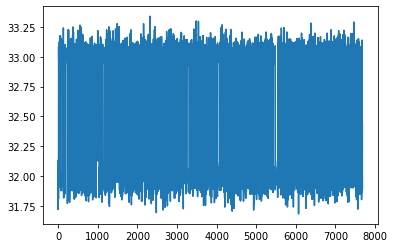

In [147]:
plt.plot(mesa.get_ppg(0)[5])

In [128]:
skf.split

<bound method StratifiedShuffleSplit.split of StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None)>

In [129]:
for train_index, test_index in skf.split(mesaid_arr, ahi_level):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [162 189  67 306 149 239 289 303 187  93 131   5   2 222 180 195 262 234
  61 135 110 220 113  11 175 157 299 142 143  25  55 205 207  48  79  10
 221 139 282 266 179 165 247 245 269 296 118 166 192 218 224 204 168   3
  31  12 295  77  34 154 103  42 260   8 128  36 100  40 229 153 271 273
 112  81 236 117  57  63  23  22 281 106   7 276 133 214 244 216 288 124
 155 107 126 226 211 298 293  35 240 307  30  39 246 201 286 138 203 280
 115 120  27  29 290 176  68 170   6 197 210 294  45 146  91 233 122  15
 163 251 228 275 304  84 132 219 257 243  59 259  72 277  97  16 191 151
  75 215  69 258 130 213 145 287  47 301  38  58 231 104  65 241 161 230
 278 199  82  71 129 232 102 206  76  24   4 274 292  14  74  44 263 123
 302 109 125  37 121 114   9 127  33  89  50 148  66 283 185  32 188  80
 178 284  17 261 208  41 152  94 147 183  70   0 308 202  53 252  96 305
 144 255  90 238 242 116 184  46  98 309  87 209 181 297 264 159 225 160
   1 270  18 249 300 164 186 150 190 140 172

In [110]:
_x.shape

(0,)

In [114]:
raw_ppg = mesa.get_ppg(0)

In [116]:
raw_ppg.shape

(1439, 7680, 1)

In [117]:
dd = np.convolve(ppg, np.ones(64), 'valid') / 32

ValueError: x and y can be no greater than 2-D, but have shapes (1439,) and (1439, 7680, 1)

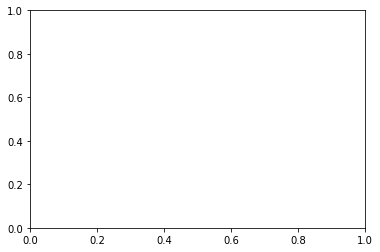

In [118]:
plt.plot(raw_ppg)

In [137]:

sampling = hz
ppg = raw_ppg.reshape(-1)
ppg_clean = nk.ppg_clean(ppg,sampling_rate=sampling)

info = nk.ppg_findpeaks(ppg_clean,sampling_rate=sampling)
peaks = info["PPG_Peaks"]
rr_interval = (np.diff(peaks)/sampling)*1000

#Signal Filtering - Find Extrema
sos = signal.cheby2(2, 0.1, 20, 'hp', fs=hz, output='sos')
filtered = signal.sosfilt(sos, raw_ppg).reshape(-1)

print(filtered.shape)
filtered_ma= moving_average(filtered,hz//2)
plt.plot(filtered_ma)
local_minima = argrelextrema(filtered_ma, np.less)[0]
local_maxima = argrelextrema(filtered_ma, np.greater)[0]

rm_index=[]
rm2_index=[]
for k in range(0,len(np.diff(local_minima)),1):
    if(np.diff(local_minima)[k]<30):
        rm_index.append(k)
        rm2_index.append(k+1)
        
        
print(local_minima)
print(local_maxima)
print(rm_index)
print(rm2_index)

sel_min = np.delete(local_minima, rm_index)
sel_max = np.delete(local_maxima,rm2_index)

pwa_list = []
systole_list=[]
diastole_list=[]
area_list =[]

count_min =0
for mini in sel_min:
    count_min = count_min+1
    count_max = 0
    for maxi in sel_max:
        count_max = count_max+1
        if(maxi>mini and count_max < len(sel_max)):
#             print(mini , " matched with ", maxi)
            pwa_list.append(filtered_ma[maxi]-filtered_ma[mini])
            systole_list.append(maxi -mini)
            if(count_min+1 <len(sel_min)):
                diastole_list.append(sel_min[count_min+1]-sel_max[count_max])
            value = 0        
            for i in range(mini,maxi,1):
                value+=filtered_ma[i]
            area_list.append(value)
            break

#     if
#     if len(pwa_list < 5):
#         exit()
#     if len(systole_list <5):
#         exit()
#     if len(rr_interval < 5):
#         exit()
#     if len(area_list <5):
#         exit()
#     if (diastole_list <5):
#         exit()

pwa_list = signal.resample(pwa_list, 60)
systole_list = signal.resample(systole_list, 60)
diastole_list = signal.resample(diastole_list, 60)
area_list = signal.resample(area_list, 60)
rr_list = signal.resample(rr_interval,60)
diff_rr_list = signal.resample(np.diff(rr_interval),60)
diff_pwa_list = signal.resample(np.diff(pwa_list),60)


(11051520,)


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fa6b04a4d90> (for post_execute):


KeyboardInterrupt: 

In [ ]:
plt.plot(pwa_list)

In [ ]:
k = [_ppg(fname_ppg,fname_groundtruth) for i in range(5)]
f = open("dec_heartbeat_fold_info.txt", "w")
f.write("Train-Test in 5 folds (Subject Index)")
kfold = 0
for train_index, test_index in tqdm(skf.split(mesaid_arr, ahi_level),desc="Fold"):
    print("TRAIN:", train_index, "TEST:", test_index)
    f.write("Fold: {}".format(kfold))
    f.write("TRAIN: {} \n TEST: {}".format(train_index,test_index))
#     X_train, X_test = mesaid_arr[train_index], mesaid_arr[test_index]
#     y_train, y_test = ahi_level[train_index], ahi_level[test_index]
    
    for i in tqdm(range(0,len(train_index),1),desc="Train Subject"):
        _x , _y= mass_extraction(mesa.get_ppg(train_index[i]),mesa.get_y(train_index[i]))
        k[kfold].add_train(_x,_y)
    for i in tqdm(range(0,len(test_index),1),desc="Test Subject"):    
        _x , _y= mass_extraction(mesa.get_ppg(test_index[i]),mesa.get_y(test_index[i]))
        k[kfold].add_test(_x,_y)

    
    kfold=kfold+1

    print(kfold, " done...")

Fold: 0it [00:00, ?it/s]

TRAIN: [162 189  67 306 149 239 289 303 187  93 131   5   2 222 180 195 262 234
  61 135 110 220 113  11 175 157 299 142 143  25  55 205 207  48  79  10
 221 139 282 266 179 165 247 245 269 296 118 166 192 218 224 204 168   3
  31  12 295  77  34 154 103  42 260   8 128  36 100  40 229 153 271 273
 112  81 236 117  57  63  23  22 281 106   7 276 133 214 244 216 288 124
 155 107 126 226 211 298 293  35 240 307  30  39 246 201 286 138 203 280
 115 120  27  29 290 176  68 170   6 197 210 294  45 146  91 233 122  15
 163 251 228 275 304  84 132 219 257 243  59 259  72 277  97  16 191 151
  75 215  69 258 130 213 145 287  47 301  38  58 231 104  65 241 161 230
 278 199  82  71 129 232 102 206  76  24   4 274 292  14  74  44 263 123
 302 109 125  37 121 114   9 127  33  89  50 148  66 283 185  32 188  80
 178 284  17 261 208  41 152  94 147 183  70   0 308 202  53 252  96 305
 144 255  90 238 242 116 184  46  98 309  87 209 181 297 264 159 225 160
   1 270  18 249 300 164 186 150 190 140 172

Train Subject:   0%|          | 0/280 [00:00<?, ?it/s]

index 89 is out of bounds for axis 0 with size 89
index 135 is out of bounds for axis 0 with size 135
index 148 is out of bounds for axis 0 with size 148
index 68 is out of bounds for axis 0 with size 68
index 118 is out of bounds for axis 0 with size 118
index 74 is out of bounds for axis 0 with size 74
index 2523 is out of bounds for axis 0 with size 2523
index 3492 is out of bounds for axis 0 with size 3492
index 2630 is out of bounds for axis 0 with size 2630
index 2483 is out of bounds for axis 0 with size 2483
index 2390 is out of bounds for axis 0 with size 2390
index 2125 is out of bounds for axis 0 with size 2125
invalid number of data points (0) specified
invalid number of data points (0) specified
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with s

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 78 is out of bounds for axis 0 with size 78
index 82 is out of bounds for axis 0 with size 82
index 71 is out of bounds for axis 0 with size 71
index 66 is out of bounds for axis 0 with size 66
index 80 is out of bounds for axis 0 with size 80
index 96 is out of bounds for 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 914 is out of bounds for axis 0 with size 914
index 930 is out of bounds for axis 0 with size 930
index 840 is out of bounds for axis 0 with size 840
index 925 is out of bounds for axis 0 with size 925
index 872 is out of bounds for axis 0 with size 872
index 808 is out of bounds for axis 0 with size 808
index 788 is out of bounds for axis 0 with size 788
index 905 is out of bounds for axis 0 with size 905
index 956 is out of bounds for axis 0 with size 956
index 812 is out of bounds for axis 0 with size 812
index 738 is out of bounds for axis 0 with size 738
index 724 is out of bounds for axis 0 with size 724
index 779 is out of bounds for axis 0 with size 779
index 768 is out of bounds for axis 0 with size 768
index 761 is out of bounds for axis 0 with size 761
index 767 is out of bounds for axis 0 with size 767
index 757 is out of bounds for axis 0 with size 757
index 756 is out of bounds for axis 0 with size 756
index 737 is out of bounds for axis 0 with size 737
index 688 is

index 961 is out of bounds for axis 0 with size 961
index 1012 is out of bounds for axis 0 with size 1012
index 1000 is out of bounds for axis 0 with size 1000
index 1002 is out of bounds for axis 0 with size 1002
index 991 is out of bounds for axis 0 with size 991
index 1018 is out of bounds for axis 0 with size 1018
index 984 is out of bounds for axis 0 with size 984
index 953 is out of bounds for axis 0 with size 953
index 1048 is out of bounds for axis 0 with size 1048
index 1023 is out of bounds for axis 0 with size 1023
index 1015 is out of bounds for axis 0 with size 1015
index 1038 is out of bounds for axis 0 with size 1038
index 918 is out of bounds for axis 0 with size 918
index 938 is out of bounds for axis 0 with size 938
index 1005 is out of bounds for axis 0 with size 1005
index 1020 is out of bounds for axis 0 with size 1020
index 1004 is out of bounds for axis 0 with size 1004
index 994 is out of bounds for axis 0 with size 994
index 970 is out of bounds for axis 0 with

index 948 is out of bounds for axis 0 with size 948
index 1005 is out of bounds for axis 0 with size 1005
index 1015 is out of bounds for axis 0 with size 1015
index 958 is out of bounds for axis 0 with size 958
index 954 is out of bounds for axis 0 with size 954
index 964 is out of bounds for axis 0 with size 964
index 983 is out of bounds for axis 0 with size 983
index 1001 is out of bounds for axis 0 with size 1001
index 992 is out of bounds for axis 0 with size 992
index 1003 is out of bounds for axis 0 with size 1003
index 928 is out of bounds for axis 0 with size 928
index 965 is out of bounds for axis 0 with size 965
index 1009 is out of bounds for axis 0 with size 1009
index 1003 is out of bounds for axis 0 with size 1003
index 943 is out of bounds for axis 0 with size 943
index 993 is out of bounds for axis 0 with size 993
index 1049 is out of bounds for axis 0 with size 1049
index 1044 is out of bounds for axis 0 with size 1044
index 971 is out of bounds for axis 0 with size 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 98 is out of bounds for axis 0 with size 98
index 102 is out of bounds for axis 0 with size 102
index 86 is out of bounds for axis 0 with size 86
index 101 is out of bounds for axis 0 with size 101
index 100 is out of bounds for axis 0 with size 100
index 85 is out of bounds for axis 0 with size 85
index 112 is out of bounds for axis 0 with size 112
index 118 is out of bounds for axis 0 with size 118
index 106 is out of bounds for axis 0 with size 106
index 128 is out of bounds for axis 0 with size 128
index 136 is out of bounds for axis 0 with size 136
index 118 is out of bounds for axis 0 with size 118
index 150 is out of bounds for axis 0 with size 150
index 158 is out of bounds for axis 0 with size 158
index 142 is out of bounds for axis 0 with size 142
index 149 is out of bounds for axis 0 with size 149
index 133 is out of bounds for axis 0 with size 133
index 130 is out of bounds for axis 0 with size 130
index 114 is out of bounds for axis 0 with size 114
index 112 is out o

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1041 is out of bounds for axis 0 with size 1041
index 1029 is out of bounds for axis 0 with size 1029
index 1018 is out of bounds for axis 0 with size 1018
index 1015 is out of bounds for axis 0 with size 1015
index 1006 is out of bounds for axis 0 with size 1006
index 987 is out of bounds for axis 0 with size 987
index 1018 is out of bounds for axis 0 with size 1018
index 1017 is out of bounds for axis 0 with size 1017
index 1017 is out of bounds for axis 0 with size 1017
index 1016 is out of bounds for axis 0 with size 1016
index 1007 is out of bounds for axis 0 with size 1007
index 976 is out of bounds for axis 0 with size 976
index 1025 is out of bounds for axis 0 with size 1025
index 1072 is out of bounds for axis 0 with size 1072
index 1035 is out of bounds for axis 0 with size 1035
index 977 is out of bounds for axis 0 with size 977
index 936 is out of bounds for axis 0 with size 936
index 1026 is out of bounds for axis 0 with size 1026
index 993 is out of bounds for axis 

index 1040 is out of bounds for axis 0 with size 1040
index 1020 is out of bounds for axis 0 with size 1020
index 972 is out of bounds for axis 0 with size 972
index 966 is out of bounds for axis 0 with size 966
index 1021 is out of bounds for axis 0 with size 1021
index 1008 is out of bounds for axis 0 with size 1008
index 1034 is out of bounds for axis 0 with size 1034
index 980 is out of bounds for axis 0 with size 980
index 1056 is out of bounds for axis 0 with size 1056
index 1004 is out of bounds for axis 0 with size 1004
index 992 is out of bounds for axis 0 with size 992
index 994 is out of bounds for axis 0 with size 994
index 988 is out of bounds for axis 0 with size 988
index 1042 is out of bounds for axis 0 with size 1042
index 949 is out of bounds for axis 0 with size 949
index 988 is out of bounds for axis 0 with size 988
index 1021 is out of bounds for axis 0 with size 1021
index 1007 is out of bounds for axis 0 with size 1007
index 988 is out of bounds for axis 0 with s

index 995 is out of bounds for axis 0 with size 995
index 1019 is out of bounds for axis 0 with size 1019
index 950 is out of bounds for axis 0 with size 950
index 962 is out of bounds for axis 0 with size 962
index 985 is out of bounds for axis 0 with size 985
index 1001 is out of bounds for axis 0 with size 1001
index 1000 is out of bounds for axis 0 with size 1000
index 984 is out of bounds for axis 0 with size 984
index 1039 is out of bounds for axis 0 with size 1039
index 1023 is out of bounds for axis 0 with size 1023
index 991 is out of bounds for axis 0 with size 991
index 1009 is out of bounds for axis 0 with size 1009
index 961 is out of bounds for axis 0 with size 961
index 985 is out of bounds for axis 0 with size 985
index 1008 is out of bounds for axis 0 with size 1008
index 1016 is out of bounds for axis 0 with size 1016
index 978 is out of bounds for axis 0 with size 978
index 971 is out of bounds for axis 0 with size 971
index 1014 is out of bounds for axis 0 with size

index 958 is out of bounds for axis 0 with size 958
index 998 is out of bounds for axis 0 with size 998
index 1052 is out of bounds for axis 0 with size 1052
index 1017 is out of bounds for axis 0 with size 1017
index 1039 is out of bounds for axis 0 with size 1039
index 952 is out of bounds for axis 0 with size 952
index 1064 is out of bounds for axis 0 with size 1064
index 1042 is out of bounds for axis 0 with size 1042
index 1010 is out of bounds for axis 0 with size 1010
index 993 is out of bounds for axis 0 with size 993
index 1002 is out of bounds for axis 0 with size 1002
index 994 is out of bounds for axis 0 with size 994
index 999 is out of bounds for axis 0 with size 999
index 1064 is out of bounds for axis 0 with size 1064
index 973 is out of bounds for axis 0 with size 973
index 1033 is out of bounds for axis 0 with size 1033
index 1005 is out of bounds for axis 0 with size 1005
index 942 is out of bounds for axis 0 with size 942
index 929 is out of bounds for axis 0 with s

index 1033 is out of bounds for axis 0 with size 1033
index 955 is out of bounds for axis 0 with size 955
index 939 is out of bounds for axis 0 with size 939
index 995 is out of bounds for axis 0 with size 995
index 1048 is out of bounds for axis 0 with size 1048
index 929 is out of bounds for axis 0 with size 929
index 999 is out of bounds for axis 0 with size 999
index 986 is out of bounds for axis 0 with size 986
index 972 is out of bounds for axis 0 with size 972
index 1012 is out of bounds for axis 0 with size 1012
index 939 is out of bounds for axis 0 with size 939
index 957 is out of bounds for axis 0 with size 957
index 1000 is out of bounds for axis 0 with size 1000
index 1035 is out of bounds for axis 0 with size 1035
index 1016 is out of bounds for axis 0 with size 1016
index 981 is out of bounds for axis 0 with size 981
index 1005 is out of bounds for axis 0 with size 1005
index 1027 is out of bounds for axis 0 with size 1027
index 1032 is out of bounds for axis 0 with size

index 995 is out of bounds for axis 0 with size 995
index 990 is out of bounds for axis 0 with size 990
index 997 is out of bounds for axis 0 with size 997
index 1005 is out of bounds for axis 0 with size 1005
index 1062 is out of bounds for axis 0 with size 1062
index 992 is out of bounds for axis 0 with size 992
index 1083 is out of bounds for axis 0 with size 1083
index 1018 is out of bounds for axis 0 with size 1018
index 992 is out of bounds for axis 0 with size 992
index 1061 is out of bounds for axis 0 with size 1061
index 1097 is out of bounds for axis 0 with size 1097
index 979 is out of bounds for axis 0 with size 979
index 1046 is out of bounds for axis 0 with size 1046
index 1006 is out of bounds for axis 0 with size 1006
index 1014 is out of bounds for axis 0 with size 1014
index 1008 is out of bounds for axis 0 with size 1008
index 1010 is out of bounds for axis 0 with size 1010
index 1043 is out of bounds for axis 0 with size 1043
index 1032 is out of bounds for axis 0 w

index 1017 is out of bounds for axis 0 with size 1017
index 1024 is out of bounds for axis 0 with size 1024
index 991 is out of bounds for axis 0 with size 991
index 960 is out of bounds for axis 0 with size 960
index 1013 is out of bounds for axis 0 with size 1013
index 1003 is out of bounds for axis 0 with size 1003
index 999 is out of bounds for axis 0 with size 999
index 1009 is out of bounds for axis 0 with size 1009
index 989 is out of bounds for axis 0 with size 989
index 987 is out of bounds for axis 0 with size 987
index 1002 is out of bounds for axis 0 with size 1002
index 1046 is out of bounds for axis 0 with size 1046
index 1015 is out of bounds for axis 0 with size 1015
index 999 is out of bounds for axis 0 with size 999
index 1041 is out of bounds for axis 0 with size 1041
index 1026 is out of bounds for axis 0 with size 1026
index 955 is out of bounds for axis 0 with size 955
index 932 is out of bounds for axis 0 with size 932
index 950 is out of bounds for axis 0 with s

index 1035 is out of bounds for axis 0 with size 1035
index 1000 is out of bounds for axis 0 with size 1000
index 992 is out of bounds for axis 0 with size 992
index 991 is out of bounds for axis 0 with size 991
index 971 is out of bounds for axis 0 with size 971
index 987 is out of bounds for axis 0 with size 987
index 1032 is out of bounds for axis 0 with size 1032
index 1035 is out of bounds for axis 0 with size 1035
index 1019 is out of bounds for axis 0 with size 1019
index 979 is out of bounds for axis 0 with size 979
index 1033 is out of bounds for axis 0 with size 1033
index 990 is out of bounds for axis 0 with size 990
index 1055 is out of bounds for axis 0 with size 1055
index 1006 is out of bounds for axis 0 with size 1006
index 1024 is out of bounds for axis 0 with size 1024
index 1005 is out of bounds for axis 0 with size 1005
index 1009 is out of bounds for axis 0 with size 1009
index 991 is out of bounds for axis 0 with size 991
index 957 is out of bounds for axis 0 with

index 972 is out of bounds for axis 0 with size 972
index 1045 is out of bounds for axis 0 with size 1045
index 1030 is out of bounds for axis 0 with size 1030
index 997 is out of bounds for axis 0 with size 997
index 1014 is out of bounds for axis 0 with size 1014
index 1025 is out of bounds for axis 0 with size 1025
index 1016 is out of bounds for axis 0 with size 1016
index 971 is out of bounds for axis 0 with size 971
index 994 is out of bounds for axis 0 with size 994
index 1025 is out of bounds for axis 0 with size 1025
index 1007 is out of bounds for axis 0 with size 1007
index 987 is out of bounds for axis 0 with size 987
index 960 is out of bounds for axis 0 with size 960
index 955 is out of bounds for axis 0 with size 955
index 976 is out of bounds for axis 0 with size 976
index 999 is out of bounds for axis 0 with size 999
index 990 is out of bounds for axis 0 with size 990
index 998 is out of bounds for axis 0 with size 998
index 1012 is out of bounds for axis 0 with size 1

index 992 is out of bounds for axis 0 with size 992
index 1021 is out of bounds for axis 0 with size 1021
index 962 is out of bounds for axis 0 with size 962
index 1006 is out of bounds for axis 0 with size 1006
index 1038 is out of bounds for axis 0 with size 1038
index 1061 is out of bounds for axis 0 with size 1061
index 969 is out of bounds for axis 0 with size 969
index 1015 is out of bounds for axis 0 with size 1015
index 942 is out of bounds for axis 0 with size 942
index 1032 is out of bounds for axis 0 with size 1032
index 999 is out of bounds for axis 0 with size 999
index 1036 is out of bounds for axis 0 with size 1036
index 978 is out of bounds for axis 0 with size 978
index 967 is out of bounds for axis 0 with size 967
index 988 is out of bounds for axis 0 with size 988
index 986 is out of bounds for axis 0 with size 986
index 1043 is out of bounds for axis 0 with size 1043
index 1027 is out of bounds for axis 0 with size 1027
index 993 is out of bounds for axis 0 with siz

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1028 is out of bounds for axis 0 with size 1028
index 1012 is out of bounds for axis 0 with size 1012
index 1014 is out of bounds for axis 0 with size 1014
index 971 is out of bounds for axis 0 with size 971
index 974 is out of bounds for axis 0 with size 974
index 1142 is out of bounds for axis 0 with size 1142
index 1156 is out of bounds for axis 0 with size 1156
index 1215 is out of bounds for axis 0 with size 1215
index 1042 is out of bounds for axis 0 with size 1042
index 949 is out of bounds for axis 0 with size 949
index 1037 is out of bounds for axis 0 with size 1037
index 165 is out of bounds for axis 0 with size 165
index 94 is out of bounds for axis 0 with size 94
index 116 is out of bounds for axis 0 with size 116
index 80 is out of bounds for axis 0 with size 80
index 102 is out of bounds for axis 0 with size 102
index 60 is out of bounds for axis 0 with size 60
index 71 is out of bounds for axis 0 with size 71
index 65 is out of bounds for axis 0 with size 65
index 

index 1000 is out of bounds for axis 0 with size 1000
index 916 is out of bounds for axis 0 with size 916
index 922 is out of bounds for axis 0 with size 922
index 975 is out of bounds for axis 0 with size 975
index 967 is out of bounds for axis 0 with size 967
index 1003 is out of bounds for axis 0 with size 1003
index 1052 is out of bounds for axis 0 with size 1052
index 1033 is out of bounds for axis 0 with size 1033
index 1019 is out of bounds for axis 0 with size 1019
index 983 is out of bounds for axis 0 with size 983
index 954 is out of bounds for axis 0 with size 954
index 975 is out of bounds for axis 0 with size 975
index 987 is out of bounds for axis 0 with size 987
index 955 is out of bounds for axis 0 with size 955
index 974 is out of bounds for axis 0 with size 974
index 956 is out of bounds for axis 0 with size 956
index 981 is out of bounds for axis 0 with size 981
index 960 is out of bounds for axis 0 with size 960
index 925 is out of bounds for axis 0 with size 925
in

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 1669 is out of bounds for axis 0 with size 1669
index 317 is out of bounds for axis 0 with size 317
index 420 is out of bounds for axis 0 with size 420
index 231 is out of bounds for axis 0 with size 231
index 784 is out of bounds for axis 0 with size 784
index 755 is out of bounds for axis 0 with size 755
index 729 is out of bounds for axis 0 with size 729
index 779 is out of bounds for axis 0 with size 779
index 734 is out of bounds for axis 0 with size 734
index 731 is out of bounds for axis 0 with size 731
index 753 is out of bounds for axis 0 with size 753
index 769 is out of bounds for axis 0 with size 769
index 746 is out of bounds for axis 0 with size 746
index 732 is out of bounds for axis 0 with size 732
index 737 is out of bounds for

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 69 is out of bounds for axis 0 with size 69
index 923 is out of bounds for axis 0 with size 923
index 1037 is out of bounds for axis 0 with size 1037
index 733 is out of bounds for axis 0 with size 733
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 973 is out of bounds for axis 0 with size 973
index 992 is out of bounds for axis 0 with size 992
index 1043 is out of bounds for axis 0 with size 1043
index 1044 is out of bounds for axis 0 with size 1044
index 1009 is out of bounds for axis 0 with size 1009
index 994 is out of bounds for axis 0 with size 994
index 964 is out of bounds for axis 0 with size 964
index 958 is out of bounds for axis 0 with size 958
index 997 is out of bounds for axis 0 with size 997
index 1016 is out of bounds for axis 0 with size 1016
index 1021 is out of bounds for axis 0 with size 1021
index 1016 is out of bounds for axis 0 with size 1016
index 984 is out of bounds for axis 0 with size 984
index 970 is out of bounds for axis 0 with size 970
index 1003 is out of bounds for axis 0 with size 1003
index 1005 is out of bounds for axis 0 with size 1005
index 1035 is out of bounds for axis 0 with size 1035
index 1003 is out of bounds for axis 0 with size 1003
index 973 is out of bounds for axis 0 with s

index 1058 is out of bounds for axis 0 with size 1058
index 993 is out of bounds for axis 0 with size 993
index 999 is out of bounds for axis 0 with size 999
index 982 is out of bounds for axis 0 with size 982
index 989 is out of bounds for axis 0 with size 989
index 985 is out of bounds for axis 0 with size 985
index 963 is out of bounds for axis 0 with size 963
index 1002 is out of bounds for axis 0 with size 1002
index 1008 is out of bounds for axis 0 with size 1008
index 996 is out of bounds for axis 0 with size 996
index 1018 is out of bounds for axis 0 with size 1018
index 1010 is out of bounds for axis 0 with size 1010
index 968 is out of bounds for axis 0 with size 968
index 963 is out of bounds for axis 0 with size 963
index 1047 is out of bounds for axis 0 with size 1047
index 1042 is out of bounds for axis 0 with size 1042
index 1047 is out of bounds for axis 0 with size 1047
index 1018 is out of bounds for axis 0 with size 1018
index 1027 is out of bounds for axis 0 with si

index 1081 is out of bounds for axis 0 with size 1081
index 1087 is out of bounds for axis 0 with size 1087
index 1071 is out of bounds for axis 0 with size 1071
index 1013 is out of bounds for axis 0 with size 1013
index 1068 is out of bounds for axis 0 with size 1068
index 1010 is out of bounds for axis 0 with size 1010
index 993 is out of bounds for axis 0 with size 993
index 1032 is out of bounds for axis 0 with size 1032
index 1044 is out of bounds for axis 0 with size 1044
index 1021 is out of bounds for axis 0 with size 1021
index 1026 is out of bounds for axis 0 with size 1026
index 1005 is out of bounds for axis 0 with size 1005
index 1014 is out of bounds for axis 0 with size 1014
index 971 is out of bounds for axis 0 with size 971
index 1030 is out of bounds for axis 0 with size 1030
index 1050 is out of bounds for axis 0 with size 1050
index 983 is out of bounds for axis 0 with size 983
index 991 is out of bounds for axis 0 with size 991
index 993 is out of bounds for axis 

index 1004 is out of bounds for axis 0 with size 1004
index 1046 is out of bounds for axis 0 with size 1046
index 1116 is out of bounds for axis 0 with size 1116
index 1014 is out of bounds for axis 0 with size 1014
index 1008 is out of bounds for axis 0 with size 1008
index 1056 is out of bounds for axis 0 with size 1056
index 1082 is out of bounds for axis 0 with size 1082
index 1041 is out of bounds for axis 0 with size 1041
index 995 is out of bounds for axis 0 with size 995
index 1051 is out of bounds for axis 0 with size 1051
index 901 is out of bounds for axis 0 with size 901
index 992 is out of bounds for axis 0 with size 992
index 1054 is out of bounds for axis 0 with size 1054
index 1009 is out of bounds for axis 0 with size 1009
index 953 is out of bounds for axis 0 with size 953
index 938 is out of bounds for axis 0 with size 938
index 929 is out of bounds for axis 0 with size 929
index 991 is out of bounds for axis 0 with size 991
index 1083 is out of bounds for axis 0 wit

index 244 is out of bounds for axis 0 with size 244
index 157 is out of bounds for axis 0 with size 157
index 188 is out of bounds for axis 0 with size 188
index 109 is out of bounds for axis 0 with size 109
index 122 is out of bounds for axis 0 with size 122
index 116 is out of bounds for axis 0 with size 116
index 125 is out of bounds for axis 0 with size 125
index 108 is out of bounds for axis 0 with size 108
index 108 is out of bounds for axis 0 with size 108
index 167 is out of bounds for axis 0 with size 167
index 110 is out of bounds for axis 0 with size 110
index 106 is out of bounds for axis 0 with size 106
index 84 is out of bounds for axis 0 with size 84
index 117 is out of bounds for axis 0 with size 117
index 107 is out of bounds for axis 0 with size 107
index 1077 is out of bounds for axis 0 with size 1077
invalid number of data points (0) specified
index 972 is out of bounds for axis 0 with size 972
index 974 is out of bounds for axis 0 with size 974
index 1048 is out of

index 966 is out of bounds for axis 0 with size 966
index 970 is out of bounds for axis 0 with size 970
index 990 is out of bounds for axis 0 with size 990
index 1130 is out of bounds for axis 0 with size 1130
index 1086 is out of bounds for axis 0 with size 1086
index 1035 is out of bounds for axis 0 with size 1035
index 1039 is out of bounds for axis 0 with size 1039
index 1011 is out of bounds for axis 0 with size 1011
index 993 is out of bounds for axis 0 with size 993
index 1029 is out of bounds for axis 0 with size 1029
index 1010 is out of bounds for axis 0 with size 1010
index 1014 is out of bounds for axis 0 with size 1014
index 998 is out of bounds for axis 0 with size 998
index 1016 is out of bounds for axis 0 with size 1016
index 1051 is out of bounds for axis 0 with size 1051
index 1043 is out of bounds for axis 0 with size 1043
index 1004 is out of bounds for axis 0 with size 1004
index 1062 is out of bounds for axis 0 with size 1062
index 1030 is out of bounds for axis 0

index 1031 is out of bounds for axis 0 with size 1031
index 1077 is out of bounds for axis 0 with size 1077
invalid number of data points (0) specified
index 1155 is out of bounds for axis 0 with size 1155
invalid number of data points (0) specified
index 1057 is out of bounds for axis 0 with size 1057
index 1053 is out of bounds for axis 0 with size 1053
index 1039 is out of bounds for axis 0 with size 1039
index 1038 is out of bounds for axis 0 with size 1038
index 1074 is out of bounds for axis 0 with size 1074
index 1099 is out of bounds for axis 0 with size 1099
index 1131 is out of bounds for axis 0 with size 1131
index 1113 is out of bounds for axis 0 with size 1113
invalid number of data points (0) specified
invalid number of data points (0) specified
index 1091 is out of bounds for axis 0 with size 1091
index 1093 is out of bounds for axis 0 with size 1093
index 1129 is out of bounds for axis 0 with size 1129
index 1089 is out of bounds for axis 0 with size 1089
index 1090 is 

index 1091 is out of bounds for axis 0 with size 1091
index 1073 is out of bounds for axis 0 with size 1073
index 1052 is out of bounds for axis 0 with size 1052
index 1101 is out of bounds for axis 0 with size 1101
index 1039 is out of bounds for axis 0 with size 1039
index 1074 is out of bounds for axis 0 with size 1074
index 1030 is out of bounds for axis 0 with size 1030
index 1085 is out of bounds for axis 0 with size 1085
index 1011 is out of bounds for axis 0 with size 1011
index 1037 is out of bounds for axis 0 with size 1037
index 1012 is out of bounds for axis 0 with size 1012
index 1072 is out of bounds for axis 0 with size 1072
index 1044 is out of bounds for axis 0 with size 1044
index 1075 is out of bounds for axis 0 with size 1075
index 1068 is out of bounds for axis 0 with size 1068
index 1036 is out of bounds for axis 0 with size 1036
index 1029 is out of bounds for axis 0 with size 1029
index 1120 is out of bounds for axis 0 with size 1120
index 1084 is out of bounds 

index 1074 is out of bounds for axis 0 with size 1074
index 1037 is out of bounds for axis 0 with size 1037
index 1052 is out of bounds for axis 0 with size 1052
index 1048 is out of bounds for axis 0 with size 1048
index 1045 is out of bounds for axis 0 with size 1045
index 1063 is out of bounds for axis 0 with size 1063
index 1066 is out of bounds for axis 0 with size 1066
index 1025 is out of bounds for axis 0 with size 1025
index 1055 is out of bounds for axis 0 with size 1055
index 1052 is out of bounds for axis 0 with size 1052
index 1057 is out of bounds for axis 0 with size 1057
index 1134 is out of bounds for axis 0 with size 1134
index 1030 is out of bounds for axis 0 with size 1030
index 1055 is out of bounds for axis 0 with size 1055
index 1119 is out of bounds for axis 0 with size 1119
index 1059 is out of bounds for axis 0 with size 1059
index 1056 is out of bounds for axis 0 with size 1056
index 1025 is out of bounds for axis 0 with size 1025
index 1075 is out of bounds 

index 1097 is out of bounds for axis 0 with size 1097
index 1024 is out of bounds for axis 0 with size 1024
index 1003 is out of bounds for axis 0 with size 1003
index 1026 is out of bounds for axis 0 with size 1026
invalid number of data points (0) specified
index 1027 is out of bounds for axis 0 with size 1027
index 1070 is out of bounds for axis 0 with size 1070
index 1119 is out of bounds for axis 0 with size 1119
index 1022 is out of bounds for axis 0 with size 1022
index 1061 is out of bounds for axis 0 with size 1061
index 1069 is out of bounds for axis 0 with size 1069
index 1037 is out of bounds for axis 0 with size 1037
index 1026 is out of bounds for axis 0 with size 1026
index 1103 is out of bounds for axis 0 with size 1103
index 1119 is out of bounds for axis 0 with size 1119
index 1084 is out of bounds for axis 0 with size 1084
index 783 is out of bounds for axis 0 with size 783
index 1201 is out of bounds for axis 0 with size 1201
index 1141 is out of bounds for axis 0 w

index 1117 is out of bounds for axis 0 with size 1117
index 1083 is out of bounds for axis 0 with size 1083
index 1099 is out of bounds for axis 0 with size 1099
index 1047 is out of bounds for axis 0 with size 1047
index 1124 is out of bounds for axis 0 with size 1124
index 1078 is out of bounds for axis 0 with size 1078
index 1061 is out of bounds for axis 0 with size 1061
index 1059 is out of bounds for axis 0 with size 1059
index 1082 is out of bounds for axis 0 with size 1082
index 1072 is out of bounds for axis 0 with size 1072
index 1103 is out of bounds for axis 0 with size 1103
index 1136 is out of bounds for axis 0 with size 1136
index 1112 is out of bounds for axis 0 with size 1112
index 1053 is out of bounds for axis 0 with size 1053
index 1070 is out of bounds for axis 0 with size 1070
index 1023 is out of bounds for axis 0 with size 1023
index 1051 is out of bounds for axis 0 with size 1051
index 1099 is out of bounds for axis 0 with size 1099
index 1010 is out of bounds 

index 1076 is out of bounds for axis 0 with size 1076
index 1043 is out of bounds for axis 0 with size 1043
index 1060 is out of bounds for axis 0 with size 1060
index 1139 is out of bounds for axis 0 with size 1139
index 1085 is out of bounds for axis 0 with size 1085
index 950 is out of bounds for axis 0 with size 950
index 228 is out of bounds for axis 0 with size 228
index 231 is out of bounds for axis 0 with size 231
index 216 is out of bounds for axis 0 with size 216
index 124 is out of bounds for axis 0 with size 124
index 82 is out of bounds for axis 0 with size 82
index 87 is out of bounds for axis 0 with size 87
index 75 is out of bounds for axis 0 with size 75
index 478 is out of bounds for axis 0 with size 478
index 1017 is out of bounds for axis 0 with size 1017
index 948 is out of bounds for axis 0 with size 948
index 1034 is out of bounds for axis 0 with size 1034
index 1034 is out of bounds for axis 0 with size 1034
index 1030 is out of bounds for axis 0 with size 1030


index 1044 is out of bounds for axis 0 with size 1044
index 1010 is out of bounds for axis 0 with size 1010
index 983 is out of bounds for axis 0 with size 983
index 935 is out of bounds for axis 0 with size 935
index 1033 is out of bounds for axis 0 with size 1033
index 939 is out of bounds for axis 0 with size 939
index 996 is out of bounds for axis 0 with size 996
index 979 is out of bounds for axis 0 with size 979
index 742 is out of bounds for axis 0 with size 742
index 784 is out of bounds for axis 0 with size 784
index 694 is out of bounds for axis 0 with size 694
index 677 is out of bounds for axis 0 with size 677
index 1012 is out of bounds for axis 0 with size 1012
index 1027 is out of bounds for axis 0 with size 1027
index 63 is out of bounds for axis 0 with size 63
index 113 is out of bounds for axis 0 with size 113
index 818 is out of bounds for axis 0 with size 818
index 980 is out of bounds for axis 0 with size 980
index 986 is out of bounds for axis 0 with size 986
inde

index 993 is out of bounds for axis 0 with size 993
index 974 is out of bounds for axis 0 with size 974
index 996 is out of bounds for axis 0 with size 996
index 989 is out of bounds for axis 0 with size 989
index 1026 is out of bounds for axis 0 with size 1026
index 960 is out of bounds for axis 0 with size 960
index 993 is out of bounds for axis 0 with size 993
index 1032 is out of bounds for axis 0 with size 1032
index 1043 is out of bounds for axis 0 with size 1043
index 1024 is out of bounds for axis 0 with size 1024
index 1059 is out of bounds for axis 0 with size 1059
index 1049 is out of bounds for axis 0 with size 1049
index 1070 is out of bounds for axis 0 with size 1070
index 1058 is out of bounds for axis 0 with size 1058
index 1020 is out of bounds for axis 0 with size 1020
index 1032 is out of bounds for axis 0 with size 1032
index 1034 is out of bounds for axis 0 with size 1034
index 995 is out of bounds for axis 0 with size 995
index 996 is out of bounds for axis 0 with

index 1023 is out of bounds for axis 0 with size 1023
index 1033 is out of bounds for axis 0 with size 1033
index 1044 is out of bounds for axis 0 with size 1044
index 1028 is out of bounds for axis 0 with size 1028
index 1046 is out of bounds for axis 0 with size 1046
index 1002 is out of bounds for axis 0 with size 1002
index 996 is out of bounds for axis 0 with size 996
index 1022 is out of bounds for axis 0 with size 1022
index 1011 is out of bounds for axis 0 with size 1011
index 1032 is out of bounds for axis 0 with size 1032
index 1055 is out of bounds for axis 0 with size 1055
index 965 is out of bounds for axis 0 with size 965
index 935 is out of bounds for axis 0 with size 935
index 1053 is out of bounds for axis 0 with size 1053
index 1010 is out of bounds for axis 0 with size 1010
index 1028 is out of bounds for axis 0 with size 1028
index 1020 is out of bounds for axis 0 with size 1020
index 990 is out of bounds for axis 0 with size 990
index 1029 is out of bounds for axis

index 1012 is out of bounds for axis 0 with size 1012
index 1018 is out of bounds for axis 0 with size 1018
index 1036 is out of bounds for axis 0 with size 1036
index 1010 is out of bounds for axis 0 with size 1010
index 986 is out of bounds for axis 0 with size 986
index 1016 is out of bounds for axis 0 with size 1016
index 1034 is out of bounds for axis 0 with size 1034
index 990 is out of bounds for axis 0 with size 990
index 1027 is out of bounds for axis 0 with size 1027
index 1047 is out of bounds for axis 0 with size 1047
index 1071 is out of bounds for axis 0 with size 1071
index 1054 is out of bounds for axis 0 with size 1054
index 1024 is out of bounds for axis 0 with size 1024
index 942 is out of bounds for axis 0 with size 942
index 992 is out of bounds for axis 0 with size 992
index 1007 is out of bounds for axis 0 with size 1007
index 950 is out of bounds for axis 0 with size 950
index 1017 is out of bounds for axis 0 with size 1017
index 1000 is out of bounds for axis 0

index 1064 is out of bounds for axis 0 with size 1064
index 1077 is out of bounds for axis 0 with size 1077
index 1003 is out of bounds for axis 0 with size 1003
index 971 is out of bounds for axis 0 with size 971
index 1037 is out of bounds for axis 0 with size 1037
index 1068 is out of bounds for axis 0 with size 1068
index 1058 is out of bounds for axis 0 with size 1058
index 977 is out of bounds for axis 0 with size 977
index 1032 is out of bounds for axis 0 with size 1032
index 1054 is out of bounds for axis 0 with size 1054
index 1036 is out of bounds for axis 0 with size 1036
index 975 is out of bounds for axis 0 with size 975
index 1016 is out of bounds for axis 0 with size 1016
index 1032 is out of bounds for axis 0 with size 1032
index 998 is out of bounds for axis 0 with size 998
index 946 is out of bounds for axis 0 with size 946
index 951 is out of bounds for axis 0 with size 951
index 1057 is out of bounds for axis 0 with size 1057
index 1031 is out of bounds for axis 0 w

index 960 is out of bounds for axis 0 with size 960
index 905 is out of bounds for axis 0 with size 905
index 846 is out of bounds for axis 0 with size 846
index 781 is out of bounds for axis 0 with size 781
index 809 is out of bounds for axis 0 with size 809
index 958 is out of bounds for axis 0 with size 958
index 737 is out of bounds for axis 0 with size 737
index 1104 is out of bounds for axis 0 with size 1104
index 1101 is out of bounds for axis 0 with size 1101
index 1086 is out of bounds for axis 0 with size 1086
index 1081 is out of bounds for axis 0 with size 1081
index 1068 is out of bounds for axis 0 with size 1068
index 1135 is out of bounds for axis 0 with size 1135
index 561 is out of bounds for axis 0 with size 561
index 563 is out of bounds for axis 0 with size 563
index 502 is out of bounds for axis 0 with size 502
index 476 is out of bounds for axis 0 with size 476
index 424 is out of bounds for axis 0 with size 424
index 418 is out of bounds for axis 0 with size 418


index 1058 is out of bounds for axis 0 with size 1058
index 1118 is out of bounds for axis 0 with size 1118
index 1005 is out of bounds for axis 0 with size 1005
index 983 is out of bounds for axis 0 with size 983
index 985 is out of bounds for axis 0 with size 985
index 996 is out of bounds for axis 0 with size 996
index 976 is out of bounds for axis 0 with size 976
index 1028 is out of bounds for axis 0 with size 1028
index 1050 is out of bounds for axis 0 with size 1050
index 1007 is out of bounds for axis 0 with size 1007
index 971 is out of bounds for axis 0 with size 971
index 1033 is out of bounds for axis 0 with size 1033
index 1027 is out of bounds for axis 0 with size 1027
index 942 is out of bounds for axis 0 with size 942
index 954 is out of bounds for axis 0 with size 954
index 1020 is out of bounds for axis 0 with size 1020
index 1040 is out of bounds for axis 0 with size 1040
index 977 is out of bounds for axis 0 with size 977
index 936 is out of bounds for axis 0 with s

index 1044 is out of bounds for axis 0 with size 1044
index 1044 is out of bounds for axis 0 with size 1044
index 1027 is out of bounds for axis 0 with size 1027
index 1026 is out of bounds for axis 0 with size 1026
index 1054 is out of bounds for axis 0 with size 1054
index 1037 is out of bounds for axis 0 with size 1037
index 947 is out of bounds for axis 0 with size 947
index 982 is out of bounds for axis 0 with size 982
index 1021 is out of bounds for axis 0 with size 1021
index 946 is out of bounds for axis 0 with size 946
index 1016 is out of bounds for axis 0 with size 1016
index 988 is out of bounds for axis 0 with size 988
index 1006 is out of bounds for axis 0 with size 1006
index 986 is out of bounds for axis 0 with size 986
index 981 is out of bounds for axis 0 with size 981
index 1009 is out of bounds for axis 0 with size 1009
index 1020 is out of bounds for axis 0 with size 1020
index 1068 is out of bounds for axis 0 with size 1068
index 1032 is out of bounds for axis 0 w

index 899 is out of bounds for axis 0 with size 899
index 808 is out of bounds for axis 0 with size 808
index 899 is out of bounds for axis 0 with size 899
index 882 is out of bounds for axis 0 with size 882
index 980 is out of bounds for axis 0 with size 980
index 974 is out of bounds for axis 0 with size 974
index 1003 is out of bounds for axis 0 with size 1003
index 989 is out of bounds for axis 0 with size 989
index 1010 is out of bounds for axis 0 with size 1010
index 931 is out of bounds for axis 0 with size 931
index 1059 is out of bounds for axis 0 with size 1059
index 1044 is out of bounds for axis 0 with size 1044
index 1022 is out of bounds for axis 0 with size 1022
index 976 is out of bounds for axis 0 with size 976
index 1011 is out of bounds for axis 0 with size 1011
index 1014 is out of bounds for axis 0 with size 1014
index 1056 is out of bounds for axis 0 with size 1056
index 989 is out of bounds for axis 0 with size 989
index 483 is out of bounds for axis 0 with size 

index 1055 is out of bounds for axis 0 with size 1055
index 1047 is out of bounds for axis 0 with size 1047
index 1101 is out of bounds for axis 0 with size 1101
index 1111 is out of bounds for axis 0 with size 1111
index 1091 is out of bounds for axis 0 with size 1091
index 1069 is out of bounds for axis 0 with size 1069
index 1041 is out of bounds for axis 0 with size 1041
index 1032 is out of bounds for axis 0 with size 1032
index 1048 is out of bounds for axis 0 with size 1048
index 1059 is out of bounds for axis 0 with size 1059
index 1101 is out of bounds for axis 0 with size 1101
index 1056 is out of bounds for axis 0 with size 1056
index 1029 is out of bounds for axis 0 with size 1029
index 1071 is out of bounds for axis 0 with size 1071
index 1067 is out of bounds for axis 0 with size 1067
index 1119 is out of bounds for axis 0 with size 1119
index 1086 is out of bounds for axis 0 with size 1086
index 1087 is out of bounds for axis 0 with size 1087
index 1053 is out of bounds 

index 1047 is out of bounds for axis 0 with size 1047
index 1077 is out of bounds for axis 0 with size 1077
index 1060 is out of bounds for axis 0 with size 1060
index 1028 is out of bounds for axis 0 with size 1028
index 1019 is out of bounds for axis 0 with size 1019
index 1031 is out of bounds for axis 0 with size 1031
index 1026 is out of bounds for axis 0 with size 1026
index 1025 is out of bounds for axis 0 with size 1025
index 1041 is out of bounds for axis 0 with size 1041
index 1051 is out of bounds for axis 0 with size 1051
index 1051 is out of bounds for axis 0 with size 1051
index 1033 is out of bounds for axis 0 with size 1033
index 1068 is out of bounds for axis 0 with size 1068
index 1076 is out of bounds for axis 0 with size 1076
index 1091 is out of bounds for axis 0 with size 1091
index 1135 is out of bounds for axis 0 with size 1135
index 1084 is out of bounds for axis 0 with size 1084
index 1055 is out of bounds for axis 0 with size 1055
index 1059 is out of bounds 

index 1213 is out of bounds for axis 0 with size 1213
index 1257 is out of bounds for axis 0 with size 1257
index 1081 is out of bounds for axis 0 with size 1081
index 1071 is out of bounds for axis 0 with size 1071
index 1079 is out of bounds for axis 0 with size 1079
index 1061 is out of bounds for axis 0 with size 1061
index 1024 is out of bounds for axis 0 with size 1024
index 1055 is out of bounds for axis 0 with size 1055
index 1090 is out of bounds for axis 0 with size 1090
index 1086 is out of bounds for axis 0 with size 1086
index 1094 is out of bounds for axis 0 with size 1094
index 1080 is out of bounds for axis 0 with size 1080
index 1048 is out of bounds for axis 0 with size 1048
index 1084 is out of bounds for axis 0 with size 1084
index 1007 is out of bounds for axis 0 with size 1007
index 1055 is out of bounds for axis 0 with size 1055
index 1070 is out of bounds for axis 0 with size 1070
index 985 is out of bounds for axis 0 with size 985
index 1006 is out of bounds fo

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 976 is out of bounds for axis 0 with size 976
index 950 is out of bounds for axis 0 with size 950
index 997 is out of bounds for axis 0 with size 997
index 1014 is out of bounds for axis 0 with size 1014
index 1014 is out of bounds for axis 0 with size 1014
index 1005 is out of bounds for axis 0 with size 1005
index 986 is out of bounds for axis 0 with size 986
index 1011 is out of bounds for axis 0 with size 1011
index 1012 is out of bounds for axis 0 with size 1012
index 1063 is out of bounds for axis 0 with size 1063
index 1032 is out of bounds for axis 0 with size 1032
index 1053 is out of bounds for axis 0 with size 1053
index 1040 is out of bounds for axis 0 with size 1040
index 1070 is out of bounds for axis 0 with size 1070
index 1027 is out of bounds for axis 0 with size 1027
index 1032 is out of bounds for axis 0 with size 1032
index 1001 is out of bounds for axis 0 with size 1001
index 968 is out of bounds for axis 0 with size 968
index 1045 is out of bounds for axis 0

index 1019 is out of bounds for axis 0 with size 1019
index 985 is out of bounds for axis 0 with size 985
index 964 is out of bounds for axis 0 with size 964
index 965 is out of bounds for axis 0 with size 965
index 965 is out of bounds for axis 0 with size 965
index 946 is out of bounds for axis 0 with size 946
index 954 is out of bounds for axis 0 with size 954
index 973 is out of bounds for axis 0 with size 973
index 981 is out of bounds for axis 0 with size 981
index 992 is out of bounds for axis 0 with size 992
index 998 is out of bounds for axis 0 with size 998
index 962 is out of bounds for axis 0 with size 962
index 967 is out of bounds for axis 0 with size 967
index 1030 is out of bounds for axis 0 with size 1030
index 1035 is out of bounds for axis 0 with size 1035
index 978 is out of bounds for axis 0 with size 978
index 933 is out of bounds for axis 0 with size 933
index 956 is out of bounds for axis 0 with size 956
index 993 is out of bounds for axis 0 with size 993
index 

index 1009 is out of bounds for axis 0 with size 1009
index 989 is out of bounds for axis 0 with size 989
index 958 is out of bounds for axis 0 with size 958
index 1010 is out of bounds for axis 0 with size 1010
index 987 is out of bounds for axis 0 with size 987
index 996 is out of bounds for axis 0 with size 996
index 984 is out of bounds for axis 0 with size 984
index 994 is out of bounds for axis 0 with size 994
index 960 is out of bounds for axis 0 with size 960
index 1013 is out of bounds for axis 0 with size 1013
index 1059 is out of bounds for axis 0 with size 1059
index 1053 is out of bounds for axis 0 with size 1053
index 966 is out of bounds for axis 0 with size 966
index 1049 is out of bounds for axis 0 with size 1049
index 1030 is out of bounds for axis 0 with size 1030
index 1032 is out of bounds for axis 0 with size 1032
index 1058 is out of bounds for axis 0 with size 1058
index 1023 is out of bounds for axis 0 with size 1023
index 999 is out of bounds for axis 0 with s

index 940 is out of bounds for axis 0 with size 940
index 958 is out of bounds for axis 0 with size 958
index 973 is out of bounds for axis 0 with size 973
index 954 is out of bounds for axis 0 with size 954
index 976 is out of bounds for axis 0 with size 976
index 1027 is out of bounds for axis 0 with size 1027
index 1029 is out of bounds for axis 0 with size 1029
index 929 is out of bounds for axis 0 with size 929
index 982 is out of bounds for axis 0 with size 982
index 943 is out of bounds for axis 0 with size 943
index 1013 is out of bounds for axis 0 with size 1013
index 977 is out of bounds for axis 0 with size 977
index 976 is out of bounds for axis 0 with size 976
index 1044 is out of bounds for axis 0 with size 1044
index 1002 is out of bounds for axis 0 with size 1002
index 967 is out of bounds for axis 0 with size 967
index 1003 is out of bounds for axis 0 with size 1003
index 977 is out of bounds for axis 0 with size 977
index 1015 is out of bounds for axis 0 with size 101

index 1030 is out of bounds for axis 0 with size 1030
index 1015 is out of bounds for axis 0 with size 1015
index 1021 is out of bounds for axis 0 with size 1021
index 1031 is out of bounds for axis 0 with size 1031
index 956 is out of bounds for axis 0 with size 956
index 981 is out of bounds for axis 0 with size 981
index 999 is out of bounds for axis 0 with size 999
index 1002 is out of bounds for axis 0 with size 1002
index 956 is out of bounds for axis 0 with size 956
index 1012 is out of bounds for axis 0 with size 1012
index 1029 is out of bounds for axis 0 with size 1029
index 976 is out of bounds for axis 0 with size 976
index 1017 is out of bounds for axis 0 with size 1017
index 998 is out of bounds for axis 0 with size 998
index 1023 is out of bounds for axis 0 with size 1023
index 953 is out of bounds for axis 0 with size 953
index 940 is out of bounds for axis 0 with size 940
index 1059 is out of bounds for axis 0 with size 1059
index 987 is out of bounds for axis 0 with s

index 1012 is out of bounds for axis 0 with size 1012
index 997 is out of bounds for axis 0 with size 997
index 1005 is out of bounds for axis 0 with size 1005
index 1001 is out of bounds for axis 0 with size 1001
index 918 is out of bounds for axis 0 with size 918
index 1049 is out of bounds for axis 0 with size 1049
index 1054 is out of bounds for axis 0 with size 1054
index 1025 is out of bounds for axis 0 with size 1025
index 1005 is out of bounds for axis 0 with size 1005
index 983 is out of bounds for axis 0 with size 983
index 945 is out of bounds for axis 0 with size 945
index 985 is out of bounds for axis 0 with size 985
index 1029 is out of bounds for axis 0 with size 1029
index 970 is out of bounds for axis 0 with size 970
index 985 is out of bounds for axis 0 with size 985
index 1003 is out of bounds for axis 0 with size 1003
index 971 is out of bounds for axis 0 with size 971
index 1029 is out of bounds for axis 0 with size 1029
index 972 is out of bounds for axis 0 with s

index 915 is out of bounds for axis 0 with size 915
index 952 is out of bounds for axis 0 with size 952
index 1002 is out of bounds for axis 0 with size 1002
index 979 is out of bounds for axis 0 with size 979
index 1012 is out of bounds for axis 0 with size 1012
index 949 is out of bounds for axis 0 with size 949
index 961 is out of bounds for axis 0 with size 961
index 1000 is out of bounds for axis 0 with size 1000
index 1015 is out of bounds for axis 0 with size 1015
index 974 is out of bounds for axis 0 with size 974
index 935 is out of bounds for axis 0 with size 935
index 1039 is out of bounds for axis 0 with size 1039
index 930 is out of bounds for axis 0 with size 930
index 967 is out of bounds for axis 0 with size 967
index 972 is out of bounds for axis 0 with size 972
index 965 is out of bounds for axis 0 with size 965
index 963 is out of bounds for axis 0 with size 963
index 935 is out of bounds for axis 0 with size 935
index 962 is out of bounds for axis 0 with size 962
in

index 1048 is out of bounds for axis 0 with size 1048
index 1056 is out of bounds for axis 0 with size 1056
index 957 is out of bounds for axis 0 with size 957
index 996 is out of bounds for axis 0 with size 996
index 1014 is out of bounds for axis 0 with size 1014
index 1061 is out of bounds for axis 0 with size 1061
index 733 is out of bounds for axis 0 with size 733
index 770 is out of bounds for axis 0 with size 770
index 863 is out of bounds for axis 0 with size 863
index 1123 is out of bounds for axis 0 with size 1123
index 727 is out of bounds for axis 0 with size 727
index 1060 is out of bounds for axis 0 with size 1060
index 961 is out of bounds for axis 0 with size 961
index 84 is out of bounds for axis 0 with size 84
index 943 is out of bounds for axis 0 with size 943
index 407 is out of bounds for axis 0 with size 407
index 510 is out of bounds for axis 0 with size 510
index 772 is out of bounds for axis 0 with size 772
index 967 is out of bounds for axis 0 with size 967
in

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1030 is out of bounds for axis 0 with size 1030
index 1037 is out of bounds for axis 0 with size 1037
index 998 is out of bounds for axis 0 with size 998
index 959 is out of bounds for axis 0 with size 959
index 1073 is out of bounds for axis 0 with size 1073
index 1044 is out of bounds for axis 0 with size 1044
index 1023 is out of bounds for axis 0 with size 1023
index 1004 is out of bounds for axis 0 with size 1004
index 1012 is out of bounds for axis 0 with size 1012
index 1022 is out of bounds for axis 0 with size 1022
index 1006 is out of bounds for axis 0 with size 1006
index 987 is out of bounds for axis 0 with size 987
index 1047 is out of bounds for axis 0 with size 1047
index 1035 is out of bounds for axis 0 with size 1035
index 1026 is out of bounds for axis 0 with size 1026
index 1025 is out of bounds for axis 0 with size 1025
index 1017 is out of bounds for axis 0 with size 1017
index 999 is out of bounds for axis 0 with size 999
index 975 is out of bounds for axis 

index 1081 is out of bounds for axis 0 with size 1081
index 1110 is out of bounds for axis 0 with size 1110
index 1100 is out of bounds for axis 0 with size 1100
index 1072 is out of bounds for axis 0 with size 1072
index 1018 is out of bounds for axis 0 with size 1018
index 995 is out of bounds for axis 0 with size 995
index 973 is out of bounds for axis 0 with size 973
index 1058 is out of bounds for axis 0 with size 1058
index 1033 is out of bounds for axis 0 with size 1033
index 1031 is out of bounds for axis 0 with size 1031
index 1062 is out of bounds for axis 0 with size 1062
index 1121 is out of bounds for axis 0 with size 1121
index 1071 is out of bounds for axis 0 with size 1071
index 967 is out of bounds for axis 0 with size 967
index 1004 is out of bounds for axis 0 with size 1004
index 1022 is out of bounds for axis 0 with size 1022
index 1049 is out of bounds for axis 0 with size 1049
index 1010 is out of bounds for axis 0 with size 1010
index 954 is out of bounds for axi

index 967 is out of bounds for axis 0 with size 967
index 1005 is out of bounds for axis 0 with size 1005
index 1030 is out of bounds for axis 0 with size 1030
index 983 is out of bounds for axis 0 with size 983
index 1024 is out of bounds for axis 0 with size 1024
index 1025 is out of bounds for axis 0 with size 1025
index 982 is out of bounds for axis 0 with size 982
index 986 is out of bounds for axis 0 with size 986
index 995 is out of bounds for axis 0 with size 995
index 1010 is out of bounds for axis 0 with size 1010
index 976 is out of bounds for axis 0 with size 976
index 937 is out of bounds for axis 0 with size 937
index 952 is out of bounds for axis 0 with size 952
index 966 is out of bounds for axis 0 with size 966
index 1081 is out of bounds for axis 0 with size 1081
index 988 is out of bounds for axis 0 with size 988
index 1025 is out of bounds for axis 0 with size 1025
index 1072 is out of bounds for axis 0 with size 1072
index 1009 is out of bounds for axis 0 with size

index 1025 is out of bounds for axis 0 with size 1025
index 1003 is out of bounds for axis 0 with size 1003
index 1005 is out of bounds for axis 0 with size 1005
index 994 is out of bounds for axis 0 with size 994
index 991 is out of bounds for axis 0 with size 991
index 996 is out of bounds for axis 0 with size 996
index 1026 is out of bounds for axis 0 with size 1026
index 963 is out of bounds for axis 0 with size 963
index 917 is out of bounds for axis 0 with size 917
index 1023 is out of bounds for axis 0 with size 1023
index 1075 is out of bounds for axis 0 with size 1075
index 1032 is out of bounds for axis 0 with size 1032
index 1022 is out of bounds for axis 0 with size 1022
index 998 is out of bounds for axis 0 with size 998
index 988 is out of bounds for axis 0 with size 988
index 1005 is out of bounds for axis 0 with size 1005
index 985 is out of bounds for axis 0 with size 985
index 916 is out of bounds for axis 0 with size 916
index 953 is out of bounds for axis 0 with siz

index 1005 is out of bounds for axis 0 with size 1005
index 1021 is out of bounds for axis 0 with size 1021
index 901 is out of bounds for axis 0 with size 901
index 892 is out of bounds for axis 0 with size 892
index 912 is out of bounds for axis 0 with size 912
index 879 is out of bounds for axis 0 with size 879
index 1009 is out of bounds for axis 0 with size 1009
index 923 is out of bounds for axis 0 with size 923
index 92 is out of bounds for axis 0 with size 92
index 95 is out of bounds for axis 0 with size 95
index 102 is out of bounds for axis 0 with size 102
index 73 is out of bounds for axis 0 with size 73
index 76 is out of bounds for axis 0 with size 76
index 82 is out of bounds for axis 0 with size 82
index 1073 is out of bounds for axis 0 with size 1073
index 894 is out of bounds for axis 0 with size 894
index 1014 is out of bounds for axis 0 with size 1014
index 974 is out of bounds for axis 0 with size 974
index 972 is out of bounds for axis 0 with size 972
index 976 is

index 1054 is out of bounds for axis 0 with size 1054
index 1064 is out of bounds for axis 0 with size 1064
index 1089 is out of bounds for axis 0 with size 1089
index 1071 is out of bounds for axis 0 with size 1071
index 1042 is out of bounds for axis 0 with size 1042
index 1068 is out of bounds for axis 0 with size 1068
index 1139 is out of bounds for axis 0 with size 1139
index 1102 is out of bounds for axis 0 with size 1102
index 1138 is out of bounds for axis 0 with size 1138
index 1062 is out of bounds for axis 0 with size 1062
index 1048 is out of bounds for axis 0 with size 1048
index 1025 is out of bounds for axis 0 with size 1025
index 986 is out of bounds for axis 0 with size 986
index 973 is out of bounds for axis 0 with size 973
index 1020 is out of bounds for axis 0 with size 1020
index 1050 is out of bounds for axis 0 with size 1050
index 1054 is out of bounds for axis 0 with size 1054
index 982 is out of bounds for axis 0 with size 982
index 1021 is out of bounds for ax

index 965 is out of bounds for axis 0 with size 965
index 1000 is out of bounds for axis 0 with size 1000
index 976 is out of bounds for axis 0 with size 976
index 1045 is out of bounds for axis 0 with size 1045
index 999 is out of bounds for axis 0 with size 999
index 998 is out of bounds for axis 0 with size 998
index 992 is out of bounds for axis 0 with size 992
index 1073 is out of bounds for axis 0 with size 1073
index 1031 is out of bounds for axis 0 with size 1031
index 1036 is out of bounds for axis 0 with size 1036
index 1029 is out of bounds for axis 0 with size 1029
index 1019 is out of bounds for axis 0 with size 1019
index 1036 is out of bounds for axis 0 with size 1036
index 962 is out of bounds for axis 0 with size 962
index 981 is out of bounds for axis 0 with size 981
index 982 is out of bounds for axis 0 with size 982
index 976 is out of bounds for axis 0 with size 976
index 1037 is out of bounds for axis 0 with size 1037
index 1068 is out of bounds for axis 0 with si

index 779 is out of bounds for axis 0 with size 779
index 742 is out of bounds for axis 0 with size 742
index 987 is out of bounds for axis 0 with size 987
index 1031 is out of bounds for axis 0 with size 1031
index 985 is out of bounds for axis 0 with size 985
index 995 is out of bounds for axis 0 with size 995
index 760 is out of bounds for axis 0 with size 760
index 1064 is out of bounds for axis 0 with size 1064
index 1010 is out of bounds for axis 0 with size 1010
index 1033 is out of bounds for axis 0 with size 1033
index 1024 is out of bounds for axis 0 with size 1024
index 906 is out of bounds for axis 0 with size 906
index 892 is out of bounds for axis 0 with size 892
index 1020 is out of bounds for axis 0 with size 1020
index 1061 is out of bounds for axis 0 with size 1061
index 1026 is out of bounds for axis 0 with size 1026
index 898 is out of bounds for axis 0 with size 898
index 1046 is out of bounds for axis 0 with size 1046
index 1069 is out of bounds for axis 0 with si

index 1057 is out of bounds for axis 0 with size 1057
index 1009 is out of bounds for axis 0 with size 1009
index 999 is out of bounds for axis 0 with size 999
index 942 is out of bounds for axis 0 with size 942
index 1024 is out of bounds for axis 0 with size 1024
index 979 is out of bounds for axis 0 with size 979
index 956 is out of bounds for axis 0 with size 956
index 1013 is out of bounds for axis 0 with size 1013
index 976 is out of bounds for axis 0 with size 976
index 973 is out of bounds for axis 0 with size 973
index 990 is out of bounds for axis 0 with size 990
index 1001 is out of bounds for axis 0 with size 1001
index 1001 is out of bounds for axis 0 with size 1001
index 1007 is out of bounds for axis 0 with size 1007
index 1036 is out of bounds for axis 0 with size 1036
index 989 is out of bounds for axis 0 with size 989
index 971 is out of bounds for axis 0 with size 971
index 1030 is out of bounds for axis 0 with size 1030
index 1042 is out of bounds for axis 0 with si

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1178 is out of bounds for axis 0 with size 1178
index 1180 is out of bounds for axis 0 with size 1180
index 1098 is out of bounds for axis 0 with size 1098
index 1082 is out of bounds for axis 0 with size 1082
index 1101 is out of bounds for axis 0 with size 1101
index 923 is out of bounds for axis 0 with size 923
index 962 is out of bounds for axis 0 with size 962
index 1014 is out of bounds for axis 0 with size 1014
index 1011 is out of bounds for axis 0 with size 1011
index 1047 is out of bounds for axis 0 with size 1047
index 1031 is out of bounds for axis 0 with size 1031
index 1074 is out of bounds for axis 0 with size 1074
index 980 is out of bounds for axis 0 with size 980
index 923 is out of bounds for axis 0 with size 923
index 934 is out of bounds for axis 0 with size 934
index 1057 is out of bounds for axis 0 with size 1057
index 1092 is out of bounds for axis 0 with size 1092
index 1047 is out of bounds for axis 0 with size 1047
index 1031 is out of bounds for axis 0

index 991 is out of bounds for axis 0 with size 991
index 981 is out of bounds for axis 0 with size 981
index 961 is out of bounds for axis 0 with size 961
index 1031 is out of bounds for axis 0 with size 1031
index 1031 is out of bounds for axis 0 with size 1031
index 982 is out of bounds for axis 0 with size 982
index 965 is out of bounds for axis 0 with size 965
index 999 is out of bounds for axis 0 with size 999
index 967 is out of bounds for axis 0 with size 967
index 1030 is out of bounds for axis 0 with size 1030
index 988 is out of bounds for axis 0 with size 988
index 1000 is out of bounds for axis 0 with size 1000
index 977 is out of bounds for axis 0 with size 977
index 987 is out of bounds for axis 0 with size 987
index 1023 is out of bounds for axis 0 with size 1023
index 960 is out of bounds for axis 0 with size 960
index 1014 is out of bounds for axis 0 with size 1014
index 978 is out of bounds for axis 0 with size 978
index 1077 is out of bounds for axis 0 with size 107

index 977 is out of bounds for axis 0 with size 977
index 945 is out of bounds for axis 0 with size 945
index 974 is out of bounds for axis 0 with size 974
index 943 is out of bounds for axis 0 with size 943
index 1015 is out of bounds for axis 0 with size 1015
index 1016 is out of bounds for axis 0 with size 1016
index 995 is out of bounds for axis 0 with size 995
index 997 is out of bounds for axis 0 with size 997
index 1001 is out of bounds for axis 0 with size 1001
index 983 is out of bounds for axis 0 with size 983
index 992 is out of bounds for axis 0 with size 992
index 964 is out of bounds for axis 0 with size 964
index 1021 is out of bounds for axis 0 with size 1021
index 1067 is out of bounds for axis 0 with size 1067
index 1072 is out of bounds for axis 0 with size 1072
index 1040 is out of bounds for axis 0 with size 1040
index 1079 is out of bounds for axis 0 with size 1079
index 992 is out of bounds for axis 0 with size 992
index 1043 is out of bounds for axis 0 with size

index 661 is out of bounds for axis 0 with size 661
index 880 is out of bounds for axis 0 with size 880
index 1191 is out of bounds for axis 0 with size 1191
index 1034 is out of bounds for axis 0 with size 1034
index 1113 is out of bounds for axis 0 with size 1113
index 984 is out of bounds for axis 0 with size 984
index 1017 is out of bounds for axis 0 with size 1017
index 1049 is out of bounds for axis 0 with size 1049
index 1041 is out of bounds for axis 0 with size 1041
index 1058 is out of bounds for axis 0 with size 1058
index 842 is out of bounds for axis 0 with size 842
index 128 is out of bounds for axis 0 with size 128
index 80 is out of bounds for axis 0 with size 80
index 84 is out of bounds for axis 0 with size 84
index 126 is out of bounds for axis 0 with size 126
index 116 is out of bounds for axis 0 with size 116
index 110 is out of bounds for axis 0 with size 110
index 88 is out of bounds for axis 0 with size 88
index 100 is out of bounds for axis 0 with size 100
inde

index 1004 is out of bounds for axis 0 with size 1004
index 894 is out of bounds for axis 0 with size 894
index 867 is out of bounds for axis 0 with size 867
index 978 is out of bounds for axis 0 with size 978
index 980 is out of bounds for axis 0 with size 980
index 2068 is out of bounds for axis 0 with size 2068
index 1554 is out of bounds for axis 0 with size 1554
index 1049 is out of bounds for axis 0 with size 1049
index 1069 is out of bounds for axis 0 with size 1069
index 1057 is out of bounds for axis 0 with size 1057
index 1035 is out of bounds for axis 0 with size 1035
index 1071 is out of bounds for axis 0 with size 1071
index 1012 is out of bounds for axis 0 with size 1012
index 994 is out of bounds for axis 0 with size 994
index 998 is out of bounds for axis 0 with size 998
index 1024 is out of bounds for axis 0 with size 1024
index 442 is out of bounds for axis 0 with size 442
index 786 is out of bounds for axis 0 with size 786
index 781 is out of bounds for axis 0 with s

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 97 is out of bounds for axis 0 with size 97
index 87 is out of bounds for axis 0 w

index 979 is out of bounds for axis 0 with size 979
index 1046 is out of bounds for axis 0 with size 1046
index 998 is out of bounds for axis 0 with size 998
index 963 is out of bounds for axis 0 with size 963
index 993 is out of bounds for axis 0 with size 993
index 992 is out of bounds for axis 0 with size 992
index 523 is out of bounds for axis 0 with size 523
index 865 is out of bounds for axis 0 with size 865
index 1068 is out of bounds for axis 0 with size 1068
index 997 is out of bounds for axis 0 with size 997
index 1033 is out of bounds for axis 0 with size 1033
index 1105 is out of bounds for axis 0 with size 1105
index 1108 is out of bounds for axis 0 with size 1108
index 110 is out of bounds for axis 0 with size 110
index 77 is out of bounds for axis 0 with size 77
index 79 is out of bounds for axis 0 with size 79
index 154 is out of bounds for axis 0 with size 154
index 142 is out of bounds for axis 0 with size 142
index 132 is out of bounds for axis 0 with size 132
index 

index 1022 is out of bounds for axis 0 with size 1022
index 1072 is out of bounds for axis 0 with size 1072
index 1036 is out of bounds for axis 0 with size 1036
index 988 is out of bounds for axis 0 with size 988
index 970 is out of bounds for axis 0 with size 970
index 958 is out of bounds for axis 0 with size 958
index 995 is out of bounds for axis 0 with size 995
index 995 is out of bounds for axis 0 with size 995
index 989 is out of bounds for axis 0 with size 989
index 980 is out of bounds for axis 0 with size 980
index 1018 is out of bounds for axis 0 with size 1018
index 1023 is out of bounds for axis 0 with size 1023
index 963 is out of bounds for axis 0 with size 963
index 954 is out of bounds for axis 0 with size 954
index 1019 is out of bounds for axis 0 with size 1019
index 995 is out of bounds for axis 0 with size 995
index 1005 is out of bounds for axis 0 with size 1005
index 1003 is out of bounds for axis 0 with size 1003
index 988 is out of bounds for axis 0 with size 

index 1004 is out of bounds for axis 0 with size 1004
index 1014 is out of bounds for axis 0 with size 1014
index 969 is out of bounds for axis 0 with size 969
index 1063 is out of bounds for axis 0 with size 1063
index 996 is out of bounds for axis 0 with size 996
index 1009 is out of bounds for axis 0 with size 1009
index 991 is out of bounds for axis 0 with size 991
index 1052 is out of bounds for axis 0 with size 1052
index 1012 is out of bounds for axis 0 with size 1012
index 1022 is out of bounds for axis 0 with size 1022
index 1019 is out of bounds for axis 0 with size 1019
index 1046 is out of bounds for axis 0 with size 1046
index 951 is out of bounds for axis 0 with size 951
index 1005 is out of bounds for axis 0 with size 1005
index 1007 is out of bounds for axis 0 with size 1007
index 1008 is out of bounds for axis 0 with size 1008
index 1031 is out of bounds for axis 0 with size 1031
index 1029 is out of bounds for axis 0 with size 1029
index 1004 is out of bounds for axis

index 1022 is out of bounds for axis 0 with size 1022
index 1016 is out of bounds for axis 0 with size 1016
index 1041 is out of bounds for axis 0 with size 1041
index 1003 is out of bounds for axis 0 with size 1003
index 1038 is out of bounds for axis 0 with size 1038
index 1078 is out of bounds for axis 0 with size 1078
index 1020 is out of bounds for axis 0 with size 1020
index 1036 is out of bounds for axis 0 with size 1036
index 1028 is out of bounds for axis 0 with size 1028
index 993 is out of bounds for axis 0 with size 993
index 1000 is out of bounds for axis 0 with size 1000
index 966 is out of bounds for axis 0 with size 966
index 946 is out of bounds for axis 0 with size 946
index 963 is out of bounds for axis 0 with size 963
index 956 is out of bounds for axis 0 with size 956
index 988 is out of bounds for axis 0 with size 988
index 988 is out of bounds for axis 0 with size 988
index 983 is out of bounds for axis 0 with size 983
index 992 is out of bounds for axis 0 with s

index 1068 is out of bounds for axis 0 with size 1068
index 1047 is out of bounds for axis 0 with size 1047
index 1021 is out of bounds for axis 0 with size 1021
index 979 is out of bounds for axis 0 with size 979
index 1022 is out of bounds for axis 0 with size 1022
index 1000 is out of bounds for axis 0 with size 1000
index 1004 is out of bounds for axis 0 with size 1004
index 1013 is out of bounds for axis 0 with size 1013
index 1012 is out of bounds for axis 0 with size 1012
index 996 is out of bounds for axis 0 with size 996
index 999 is out of bounds for axis 0 with size 999
index 995 is out of bounds for axis 0 with size 995
index 1029 is out of bounds for axis 0 with size 1029
index 983 is out of bounds for axis 0 with size 983
index 980 is out of bounds for axis 0 with size 980
index 999 is out of bounds for axis 0 with size 999
index 985 is out of bounds for axis 0 with size 985
index 1023 is out of bounds for axis 0 with size 1023
index 1085 is out of bounds for axis 0 with 

index 916 is out of bounds for axis 0 with size 916
index 924 is out of bounds for axis 0 with size 924
index 169 is out of bounds for axis 0 with size 169
index 76 is out of bounds for axis 0 with size 76
index 68 is out of bounds for axis 0 with size 68
index 67 is out of bounds for axis 0 with size 67
index 58 is out of bounds for axis 0 with size 58
index 93 is out of bounds for axis 0 with size 93
index 998 is out of bounds for axis 0 with size 998
index 1012 is out of bounds for axis 0 with size 1012
index 1012 is out of bounds for axis 0 with size 1012
index 1003 is out of bounds for axis 0 with size 1003
index 962 is out of bounds for axis 0 with size 962
index 971 is out of bounds for axis 0 with size 971
index 1020 is out of bounds for axis 0 with size 1020
index 971 is out of bounds for axis 0 with size 971
index 1002 is out of bounds for axis 0 with size 1002
index 1012 is out of bounds for axis 0 with size 1012
index 1002 is out of bounds for axis 0 with size 1002
index 10

index 763 is out of bounds for axis 0 with size 763
index 683 is out of bounds for axis 0 with size 683
index 809 is out of bounds for axis 0 with size 809
index 206 is out of bounds for axis 0 with size 206
index 169 is out of bounds for axis 0 with size 169
index 64 is out of bounds for axis 0 with size 64
index 59 is out of bounds for axis 0 with size 59
index 60 is out of bounds for axis 0 with size 60
index 657 is out of bounds for axis 0 with size 657
index 930 is out of bounds for axis 0 with size 930
index 1015 is out of bounds for axis 0 with size 1015
index 1006 is out of bounds for axis 0 with size 1006
index 961 is out of bounds for axis 0 with size 961
index 947 is out of bounds for axis 0 with size 947
index 990 is out of bounds for axis 0 with size 990
index 954 is out of bounds for axis 0 with size 954
index 940 is out of bounds for axis 0 with size 940
index 985 is out of bounds for axis 0 with size 985
index 1002 is out of bounds for axis 0 with size 1002
index 971 is

index 992 is out of bounds for axis 0 with size 992
index 974 is out of bounds for axis 0 with size 974
index 983 is out of bounds for axis 0 with size 983
index 1053 is out of bounds for axis 0 with size 1053
index 1020 is out of bounds for axis 0 with size 1020
index 1020 is out of bounds for axis 0 with size 1020
index 1029 is out of bounds for axis 0 with size 1029
index 1012 is out of bounds for axis 0 with size 1012
index 1062 is out of bounds for axis 0 with size 1062
index 1060 is out of bounds for axis 0 with size 1060
index 946 is out of bounds for axis 0 with size 946
index 999 is out of bounds for axis 0 with size 999
index 1019 is out of bounds for axis 0 with size 1019
index 983 is out of bounds for axis 0 with size 983
index 973 is out of bounds for axis 0 with size 973
index 1003 is out of bounds for axis 0 with size 1003
index 1038 is out of bounds for axis 0 with size 1038
index 1032 is out of bounds for axis 0 with size 1032
index 1028 is out of bounds for axis 0 wit

index 985 is out of bounds for axis 0 with size 985
index 991 is out of bounds for axis 0 with size 991
index 980 is out of bounds for axis 0 with size 980
index 1011 is out of bounds for axis 0 with size 1011
index 1011 is out of bounds for axis 0 with size 1011
index 973 is out of bounds for axis 0 with size 973
index 978 is out of bounds for axis 0 with size 978
index 1055 is out of bounds for axis 0 with size 1055
index 1005 is out of bounds for axis 0 with size 1005
index 942 is out of bounds for axis 0 with size 942
index 933 is out of bounds for axis 0 with size 933
index 988 is out of bounds for axis 0 with size 988
index 998 is out of bounds for axis 0 with size 998
index 1025 is out of bounds for axis 0 with size 1025
index 987 is out of bounds for axis 0 with size 987
index 1010 is out of bounds for axis 0 with size 1010
index 1018 is out of bounds for axis 0 with size 1018
index 1004 is out of bounds for axis 0 with size 1004
index 945 is out of bounds for axis 0 with size 

index 1006 is out of bounds for axis 0 with size 1006
index 1040 is out of bounds for axis 0 with size 1040
index 1002 is out of bounds for axis 0 with size 1002
index 968 is out of bounds for axis 0 with size 968
index 1067 is out of bounds for axis 0 with size 1067
index 937 is out of bounds for axis 0 with size 937
index 923 is out of bounds for axis 0 with size 923
index 981 is out of bounds for axis 0 with size 981
index 984 is out of bounds for axis 0 with size 984
index 1024 is out of bounds for axis 0 with size 1024
index 1000 is out of bounds for axis 0 with size 1000
index 1022 is out of bounds for axis 0 with size 1022
index 1036 is out of bounds for axis 0 with size 1036
index 1005 is out of bounds for axis 0 with size 1005
index 1042 is out of bounds for axis 0 with size 1042
index 965 is out of bounds for axis 0 with size 965
index 969 is out of bounds for axis 0 with size 969
index 952 is out of bounds for axis 0 with size 952
index 1028 is out of bounds for axis 0 with 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 986 is out of bounds for axis 0 with size 986
index 961 is out of bounds for axis 0 with size 961
index 1033 is out of bounds for axis 0 with size 1033
index 984 is out of bounds for axis 0 with size 984
index 995 is out of bounds for axis 0 with size 995
index 976 is out of bounds for axis 0 with size 976
index 1032 is out of bounds for axis 0 with size 1032
index 948 is out of bounds for axis 0 with size 948
index 898 is out of bounds for axis 0 with size 898
index 966 is out of bounds for axis 0 with size 966
index 1005 is out of bounds for axis 0 with size 1005
index 1000 is out of bounds for axis 0 with size 1000
index 1002 is out of bounds for axis 0 with size 1002
index 986 is out of bounds for axis 0 with size 986
index 938 is out of bounds for axis 0 with size 938
index 953 is out of bounds for axis 0 with size 953
index 984 is out of bounds for axis 0 with size 984
index 929 is out of bounds for axis 0 with size 929
index 978 is out of bounds for axis 0 with size 978
in

index 1008 is out of bounds for axis 0 with size 1008
index 1050 is out of bounds for axis 0 with size 1050
index 1029 is out of bounds for axis 0 with size 1029
index 940 is out of bounds for axis 0 with size 940
index 1032 is out of bounds for axis 0 with size 1032
index 1020 is out of bounds for axis 0 with size 1020
index 985 is out of bounds for axis 0 with size 985
index 1013 is out of bounds for axis 0 with size 1013
index 975 is out of bounds for axis 0 with size 975
index 1049 is out of bounds for axis 0 with size 1049
index 982 is out of bounds for axis 0 with size 982
index 994 is out of bounds for axis 0 with size 994
index 1019 is out of bounds for axis 0 with size 1019
index 1032 is out of bounds for axis 0 with size 1032
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out

index 167 is out of bounds for axis 0 with size 167
index 149 is out of bounds for axis 0 with size 149
index 159 is out of bounds for axis 0 with size 159
index 122 is out of bounds for axis 0 with size 122
index 87 is out of bounds for axis 0 with size 87
index 74 is out of bounds for axis 0 with size 74
index 80 is out of bounds for axis 0 with size 80
index 78 is out of bounds for axis 0 with size 78
index 80 is out of bounds for axis 0 with size 80
index 314 is out of bounds for axis 0 with size 314
index 1081 is out of bounds for axis 0 with size 1081
index 1038 is out of bounds for axis 0 with size 1038
index 1129 is out of bounds for axis 0 with size 1129
index 1074 is out of bounds for axis 0 with size 1074
index 1122 is out of bounds for axis 0 with size 1122
index 1063 is out of bounds for axis 0 with size 1063
index 1134 is out of bounds for axis 0 with size 1134
index 1058 is out of bounds for axis 0 with size 1058
index 1056 is out of bounds for axis 0 with size 1056
inde

index 1005 is out of bounds for axis 0 with size 1005
index 1044 is out of bounds for axis 0 with size 1044
index 1033 is out of bounds for axis 0 with size 1033
index 1053 is out of bounds for axis 0 with size 1053
index 1061 is out of bounds for axis 0 with size 1061
index 990 is out of bounds for axis 0 with size 990
index 986 is out of bounds for axis 0 with size 986
index 996 is out of bounds for axis 0 with size 996
index 978 is out of bounds for axis 0 with size 978
index 1018 is out of bounds for axis 0 with size 1018
index 978 is out of bounds for axis 0 with size 978
index 1014 is out of bounds for axis 0 with size 1014
index 1040 is out of bounds for axis 0 with size 1040
index 969 is out of bounds for axis 0 with size 969
index 962 is out of bounds for axis 0 with size 962
index 985 is out of bounds for axis 0 with size 985
index 1021 is out of bounds for axis 0 with size 1021
index 1077 is out of bounds for axis 0 with size 1077
index 1031 is out of bounds for axis 0 with 

index 1033 is out of bounds for axis 0 with size 1033
index 998 is out of bounds for axis 0 with size 998
index 1062 is out of bounds for axis 0 with size 1062
index 1046 is out of bounds for axis 0 with size 1046
index 984 is out of bounds for axis 0 with size 984
index 1042 is out of bounds for axis 0 with size 1042
index 1020 is out of bounds for axis 0 with size 1020
index 989 is out of bounds for axis 0 with size 989
index 1062 is out of bounds for axis 0 with size 1062
index 1039 is out of bounds for axis 0 with size 1039
index 931 is out of bounds for axis 0 with size 931
index 964 is out of bounds for axis 0 with size 964
index 1016 is out of bounds for axis 0 with size 1016
index 974 is out of bounds for axis 0 with size 974
index 1025 is out of bounds for axis 0 with size 1025
index 966 is out of bounds for axis 0 with size 966
index 946 is out of bounds for axis 0 with size 946
index 886 is out of bounds for axis 0 with size 886
index 1007 is out of bounds for axis 0 with si

index 1046 is out of bounds for axis 0 with size 1046
index 1018 is out of bounds for axis 0 with size 1018
index 1040 is out of bounds for axis 0 with size 1040
index 1075 is out of bounds for axis 0 with size 1075
index 1054 is out of bounds for axis 0 with size 1054
index 1110 is out of bounds for axis 0 with size 1110
index 1118 is out of bounds for axis 0 with size 1118
index 1064 is out of bounds for axis 0 with size 1064
index 1117 is out of bounds for axis 0 with size 1117
index 1114 is out of bounds for axis 0 with size 1114
index 1010 is out of bounds for axis 0 with size 1010
index 1056 is out of bounds for axis 0 with size 1056
index 1072 is out of bounds for axis 0 with size 1072
index 1134 is out of bounds for axis 0 with size 1134
index 1096 is out of bounds for axis 0 with size 1096
index 1153 is out of bounds for axis 0 with size 1153
index 1082 is out of bounds for axis 0 with size 1082
index 1030 is out of bounds for axis 0 with size 1030
index 1091 is out of bounds 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 992 is out of bounds for axis 0 with size 992
index 902 is out of bounds for axis 0 with size 902
index 959 is out of bounds for axis 0 with size 959
index 1011 is out of bounds for axis 0 with size 1011
index 949 is out of bounds for axis 0 with size 949
index 987 is out of bounds for axis 0 with size 987
index 1004 is out of bounds for axis 0 with size 1004
index 924 is out of bounds for axis 0 with size 924
index 957 is out of bounds for axis 0 with size 957
index 943 is out of bounds for axis 0 with size 943
index 974 is out of bounds for axis 0 with size 974
index 936 is out of bounds for axis 0 with size 936
index 915 is out of bounds for axis 0 with size 915
index 1006 is out of bounds for axis 0 with size 1006
index 971 is out of bounds for axis 0 with size 971
index 971 is out of bounds for axis 0 with size 971
index 1008 is out of bounds for axis 0 with size 1008
index 928 is out of bounds for axis 0 with size 928
invalid number of data points (0) specified
index 858 is

index 1024 is out of bounds for axis 0 with size 1024
index 1056 is out of bounds for axis 0 with size 1056
index 725 is out of bounds for axis 0 with size 725
index 293 is out of bounds for axis 0 with size 293
index 285 is out of bounds for axis 0 with size 285
index 607 is out of bounds for axis 0 with size 607
index 258 is out of bounds for axis 0 with size 258
index 398 is out of bounds for axis 0 with size 398
index 1268 is out of bounds for axis 0 with size 1268
index 1246 is out of bounds for axis 0 with size 1246
index 946 is out of bounds for axis 0 with size 946
index 1219 is out of bounds for axis 0 with size 1219
index 1144 is out of bounds for axis 0 with size 1144
index 1248 is out of bounds for axis 0 with size 1248
index 412 is out of bounds for axis 0 with size 412
index 996 is out of bounds for axis 0 with size 996
index 60 is out of bounds for axis 0 with size 60
index 79 is out of bounds for axis 0 with size 79
index 62 is out of bounds for axis 0 with size 62
inde

index 73 is out of bounds for axis 0 with size 73
index 107 is out of bounds for axis 0 with size 107
index 741 is out of bounds for axis 0 with size 741
index 888 is out of bounds for axis 0 with size 888
index 382 is out of bounds for axis 0 with size 382
index 874 is out of bounds for axis 0 with size 874
index 1010 is out of bounds for axis 0 with size 1010
index 1004 is out of bounds for axis 0 with size 1004
index 1051 is out of bounds for axis 0 with size 1051
index 1056 is out of bounds for axis 0 with size 1056
index 1037 is out of bounds for axis 0 with size 1037
index 1036 is out of bounds for axis 0 with size 1036
index 1031 is out of bounds for axis 0 with size 1031
index 964 is out of bounds for axis 0 with size 964
index 988 is out of bounds for axis 0 with size 988
index 990 is out of bounds for axis 0 with size 990
index 950 is out of bounds for axis 0 with size 950
index 1010 is out of bounds for axis 0 with size 1010
index 1056 is out of bounds for axis 0 with size 1

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1061 is out of bounds for axis 0 with size 1061
index 1056 is out of bounds for axis 0 with size 1056
index 1066 is out of bounds for axis 0 with size 1066
index 1068 is out of bounds for axis 0 with size 1068
index 1043 is out of bounds for axis 0 with size 1043
index 969 is out of bounds for axis 0 with size 969
index 1098 is out of bounds for axis 0 with size 1098
index 1029 is out of bounds for axis 0 with size 1029
index 1016 is out of bounds for axis 0 with size 1016
index 1005 is out of bounds for axis 0 with size 1005
index 1025 is out of bounds for axis 0 with size 1025
index 1074 is out of bounds for axis 0 with size 1074
index 979 is out of bounds for axis 0 with size 979
index 992 is out of bounds for axis 0 with size 992
index 1065 is out of bounds for axis 0 with size 1065
index 1102 is out of bounds for axis 0 with size 1102
index 288 is out of bounds for axis 0 with size 288
index 541 is out of bounds for axis 0 with size 541
index 565 is out of bounds for axis 0 

index 821 is out of bounds for axis 0 with size 821
index 776 is out of bounds for axis 0 with size 776
index 733 is out of bounds for axis 0 with size 733
index 749 is out of bounds for axis 0 with size 749
index 786 is out of bounds for axis 0 with size 786
index 760 is out of bounds for axis 0 with size 760
index 775 is out of bounds for axis 0 with size 775
index 776 is out of bounds for axis 0 with size 776
index 751 is out of bounds for axis 0 with size 751
index 779 is out of bounds for axis 0 with size 779
index 759 is out of bounds for axis 0 with size 759
index 701 is out of bounds for axis 0 with size 701
index 767 is out of bounds for axis 0 with size 767
index 779 is out of bounds for axis 0 with size 779
index 728 is out of bounds for axis 0 with size 728
index 725 is out of bounds for axis 0 with size 725
index 707 is out of bounds for axis 0 with size 707
index 738 is out of bounds for axis 0 with size 738
index 801 is out of bounds for axis 0 with size 801
index 809 is

index 962 is out of bounds for axis 0 with size 962
index 987 is out of bounds for axis 0 with size 987
index 1029 is out of bounds for axis 0 with size 1029
index 1043 is out of bounds for axis 0 with size 1043
index 990 is out of bounds for axis 0 with size 990
index 998 is out of bounds for axis 0 with size 998
index 1008 is out of bounds for axis 0 with size 1008
index 1043 is out of bounds for axis 0 with size 1043
index 997 is out of bounds for axis 0 with size 997
index 986 is out of bounds for axis 0 with size 986
index 1033 is out of bounds for axis 0 with size 1033
index 1061 is out of bounds for axis 0 with size 1061
index 1020 is out of bounds for axis 0 with size 1020
index 1021 is out of bounds for axis 0 with size 1021
index 970 is out of bounds for axis 0 with size 970
index 946 is out of bounds for axis 0 with size 946
index 1066 is out of bounds for axis 0 with size 1066
index 1034 is out of bounds for axis 0 with size 1034
index 1001 is out of bounds for axis 0 with 

index 997 is out of bounds for axis 0 with size 997
index 542 is out of bounds for axis 0 with size 542
index 442 is out of bounds for axis 0 with size 442
index 623 is out of bounds for axis 0 with size 623
index 654 is out of bounds for axis 0 with size 654
index 484 is out of bounds for axis 0 with size 484
index 973 is out of bounds for axis 0 with size 973
index 1022 is out of bounds for axis 0 with size 1022
index 1018 is out of bounds for axis 0 with size 1018
index 1038 is out of bounds for axis 0 with size 1038
index 981 is out of bounds for axis 0 with size 981
index 1043 is out of bounds for axis 0 with size 1043
index 1072 is out of bounds for axis 0 with size 1072
index 1026 is out of bounds for axis 0 with size 1026
index 1053 is out of bounds for axis 0 with size 1053
index 1001 is out of bounds for axis 0 with size 1001
index 1043 is out of bounds for axis 0 with size 1043
index 891 is out of bounds for axis 0 with size 891
index 1855 is out of bounds for axis 0 with si

index 1045 is out of bounds for axis 0 with size 1045
index 1038 is out of bounds for axis 0 with size 1038
index 974 is out of bounds for axis 0 with size 974
index 983 is out of bounds for axis 0 with size 983
index 1022 is out of bounds for axis 0 with size 1022
index 991 is out of bounds for axis 0 with size 991
index 482 is out of bounds for axis 0 with size 482
index 1122 is out of bounds for axis 0 with size 1122
index 1187 is out of bounds for axis 0 with size 1187
index 1148 is out of bounds for axis 0 with size 1148
index 1132 is out of bounds for axis 0 with size 1132
index 879 is out of bounds for axis 0 with size 879
index 1098 is out of bounds for axis 0 with size 1098
index 979 is out of bounds for axis 0 with size 979
index 809 is out of bounds for axis 0 with size 809
index 673 is out of bounds for axis 0 with size 673
index 686 is out of bounds for axis 0 with size 686
index 84 is out of bounds for axis 0 with size 84
index 71 is out of bounds for axis 0 with size 71


index 1066 is out of bounds for axis 0 with size 1066
index 1018 is out of bounds for axis 0 with size 1018
index 1115 is out of bounds for axis 0 with size 1115
index 1046 is out of bounds for axis 0 with size 1046
index 1027 is out of bounds for axis 0 with size 1027
index 56 is out of bounds for axis 0 with size 56
index 57 is out of bounds for axis 0 with size 57
index 59 is out of bounds for axis 0 with size 59
index 63 is out of bounds for axis 0 with size 63
index 57 is out of bounds for axis 0 with size 57
index 59 is out of bounds for axis 0 with size 59
index 62 is out of bounds for axis 0 with size 62
index 60 is out of bounds for axis 0 with size 60
index 57 is out of bounds for axis 0 with size 57
index 67 is out of bounds for axis 0 with size 67
index 71 is out of bounds for axis 0 with size 71
index 59 is out of bounds for axis 0 with size 59
index 58 is out of bounds for axis 0 with size 58
index 66 is out of bounds for axis 0 with size 66
index 113 is out of bounds for

index 1011 is out of bounds for axis 0 with size 1011
index 1066 is out of bounds for axis 0 with size 1066
index 1041 is out of bounds for axis 0 with size 1041
index 1016 is out of bounds for axis 0 with size 1016
index 1051 is out of bounds for axis 0 with size 1051
index 944 is out of bounds for axis 0 with size 944
index 809 is out of bounds for axis 0 with size 809
index 892 is out of bounds for axis 0 with size 892
index 928 is out of bounds for axis 0 with size 928
index 905 is out of bounds for axis 0 with size 905
index 1002 is out of bounds for axis 0 with size 1002
index 830 is out of bounds for axis 0 with size 830
index 1092 is out of bounds for axis 0 with size 1092
index 766 is out of bounds for axis 0 with size 766
index 931 is out of bounds for axis 0 with size 931
index 1040 is out of bounds for axis 0 with size 1040
index 963 is out of bounds for axis 0 with size 963
index 1020 is out of bounds for axis 0 with size 1020
index 1049 is out of bounds for axis 0 with si

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 956 is out of bounds for axis 0 with size 956
index 796 is out of bounds for axis 0 with size 796
index 665 is out of bounds for axis 0 with size 665
index 975 is out of bounds for axis 0 with size 975
index 966 is out of bounds for axis 0 with size 966
index 1016 is out of bounds for axis 0 with size 1016
index 1101 is out of bounds for axis 0 with size 1101
index 1083 is out of bounds for axis 0 with size 1083
index 1030 is out of bounds for axis 0 with size 1030
index 1007 is out of bounds for axis 0 with size 1007
index 1010 is out of bounds for axis 0 with size 1010
index 1065 is out of bounds for axis 0 with size 1065
index 1095 is out of bounds for axis 0 with size 1095
index 976 is out of bounds for axis 0 with size 976
index 978 is out of bounds for axis 0 with size 978
index 935 is out of bounds for axis 0 with size 935
index 1028 is out of bounds for axis 0 with size 1028
index 1045 is out of bounds for axis 0 with size 1045
index 1032 is out of bounds for axis 0 with 

index 980 is out of bounds for axis 0 with size 980
index 982 is out of bounds for axis 0 with size 982
index 945 is out of bounds for axis 0 with size 945
index 949 is out of bounds for axis 0 with size 949
index 968 is out of bounds for axis 0 with size 968
index 985 is out of bounds for axis 0 with size 985
index 1050 is out of bounds for axis 0 with size 1050
index 1022 is out of bounds for axis 0 with size 1022
index 978 is out of bounds for axis 0 with size 978
index 975 is out of bounds for axis 0 with size 975
index 982 is out of bounds for axis 0 with size 982
index 1011 is out of bounds for axis 0 with size 1011
index 991 is out of bounds for axis 0 with size 991
index 949 is out of bounds for axis 0 with size 949
index 991 is out of bounds for axis 0 with size 991
index 1039 is out of bounds for axis 0 with size 1039
index 976 is out of bounds for axis 0 with size 976
index 1007 is out of bounds for axis 0 with size 1007
index 1031 is out of bounds for axis 0 with size 1031


index 981 is out of bounds for axis 0 with size 981
index 955 is out of bounds for axis 0 with size 955
index 945 is out of bounds for axis 0 with size 945
index 934 is out of bounds for axis 0 with size 934
index 916 is out of bounds for axis 0 with size 916
index 973 is out of bounds for axis 0 with size 973
index 1033 is out of bounds for axis 0 with size 1033
index 984 is out of bounds for axis 0 with size 984
index 938 is out of bounds for axis 0 with size 938
index 970 is out of bounds for axis 0 with size 970
index 1006 is out of bounds for axis 0 with size 1006
index 992 is out of bounds for axis 0 with size 992
index 992 is out of bounds for axis 0 with size 992
index 958 is out of bounds for axis 0 with size 958
index 964 is out of bounds for axis 0 with size 964
index 972 is out of bounds for axis 0 with size 972
index 1050 is out of bounds for axis 0 with size 1050
index 939 is out of bounds for axis 0 with size 939
index 959 is out of bounds for axis 0 with size 959
index 

index 949 is out of bounds for axis 0 with size 949
index 993 is out of bounds for axis 0 with size 993
index 1032 is out of bounds for axis 0 with size 1032
index 1073 is out of bounds for axis 0 with size 1073
index 939 is out of bounds for axis 0 with size 939
index 948 is out of bounds for axis 0 with size 948
index 1002 is out of bounds for axis 0 with size 1002
index 992 is out of bounds for axis 0 with size 992
index 929 is out of bounds for axis 0 with size 929
index 951 is out of bounds for axis 0 with size 951
index 965 is out of bounds for axis 0 with size 965
index 986 is out of bounds for axis 0 with size 986
index 1021 is out of bounds for axis 0 with size 1021
index 956 is out of bounds for axis 0 with size 956
index 950 is out of bounds for axis 0 with size 950
index 996 is out of bounds for axis 0 with size 996
index 1015 is out of bounds for axis 0 with size 1015
index 983 is out of bounds for axis 0 with size 983
index 898 is out of bounds for axis 0 with size 898
in

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 733 is out of bounds for axis 0 with size 733
index 694 is out of bounds for axis 0 with size 694
index 714 is out of bounds for axis 0 with size 714
index 707 is out of bounds for axis 0 with size 707
index 485 is out of bounds for axis 0 with size 485
index 735 is out of bounds for axis 0 with size 735
index 765 is out of bounds for axis 0 with size 765
index 586 is out of bounds for axis 0 with size 586
index 419 is out of bounds for axis 0 with size 419
index 474 is out of bounds for axis 0 with size 474
index 737 is out of bounds for axis 0 with size 737
index 646 is out of bounds for axis 0 with size 646
index 220 is out of bounds for axis 0 with size 220
index 265 is out of bounds for axis 0 with size 265
index 301 is out of bounds for axis 0 with size 301
index 619 is out of bounds for axis 0 with size 619
index 139 is out of bounds for axis 0 with size 139
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bo

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1162 is out of bounds for axis 0 with size 1162
index 1042 is out of bounds for axis 0 with size 1042
index 904 is out of bounds for axis 0 with size 904
index 797 is out of bounds for axis 0 with size 797
index 727 is out of bounds for axis 0 with size 727
index 738 is out of bounds for axis 0 with size 738
index 173 is out of bounds for axis 0 with size 173
index 318 is out of bounds for axis 0 with size 318
index 110 is out of bounds for axis 0 with size 110
index 116 is out of bounds for axis 0 with size 116
index 96 is out of bounds for axis 0 with size 96
index 97 is out of bounds for axis 0 with size 97
index 123 is out of bounds for axis 0 with size 123
index 121 is out of bounds for axis 0 with size 121
index 97 is out of bounds for axis 0 with size 97
index 103 is out of bounds for axis 0 with size 103
index 92 is out of bounds for axis 0 with size 92
index 89 is out of bounds for axis 0 with size 89
index 98 is out of bounds for axis 0 with size 98
index 94 is out of b

index 1054 is out of bounds for axis 0 with size 1054
index 1068 is out of bounds for axis 0 with size 1068
index 977 is out of bounds for axis 0 with size 977
index 1004 is out of bounds for axis 0 with size 1004
index 1024 is out of bounds for axis 0 with size 1024
index 626 is out of bounds for axis 0 with size 626
index 288 is out of bounds for axis 0 with size 288
index 397 is out of bounds for axis 0 with size 397
index 249 is out of bounds for axis 0 with size 249
index 323 is out of bounds for axis 0 with size 323
index 518 is out of bounds for axis 0 with size 518
index 486 is out of bounds for axis 0 with size 486
index 469 is out of bounds for axis 0 with size 469
index 131 is out of bounds for axis 0 with size 131
index 162 is out of bounds for axis 0 with size 162
index 136 is out of bounds for axis 0 with size 136
index 91 is out of bounds for axis 0 with size 91
index 110 is out of bounds for axis 0 with size 110
index 70 is out of bounds for axis 0 with size 70
index 18

index 1004 is out of bounds for axis 0 with size 1004
index 945 is out of bounds for axis 0 with size 945
index 994 is out of bounds for axis 0 with size 994
index 1033 is out of bounds for axis 0 with size 1033
index 1008 is out of bounds for axis 0 with size 1008
index 995 is out of bounds for axis 0 with size 995
index 981 is out of bounds for axis 0 with size 981
index 952 is out of bounds for axis 0 with size 952
index 935 is out of bounds for axis 0 with size 935
index 922 is out of bounds for axis 0 with size 922
index 1009 is out of bounds for axis 0 with size 1009
index 993 is out of bounds for axis 0 with size 993
index 962 is out of bounds for axis 0 with size 962
index 982 is out of bounds for axis 0 with size 982
index 989 is out of bounds for axis 0 with size 989
index 951 is out of bounds for axis 0 with size 951
index 975 is out of bounds for axis 0 with size 975
index 1012 is out of bounds for axis 0 with size 1012
index 984 is out of bounds for axis 0 with size 984
in

index 58 is out of bounds for axis 0 with size 58
index 59 is out of bounds for axis 0 with size 59
index 61 is out of bounds for axis 0 with size 61
index 66 is out of bounds for axis 0 with size 66
index 108 is out of bounds for axis 0 with size 108
index 56 is out of bounds for axis 0 with size 56
index 58 is out of bounds for axis 0 with size 58
index 58 is out of bounds for axis 0 with size 58
index 60 is out of bounds for axis 0 with size 60
index 61 is out of bounds for axis 0 with size 61
index 1339 is out of bounds for axis 0 with size 1339
index 1549 is out of bounds for axis 0 with size 1549
index 1470 is out of bounds for axis 0 with size 1470
index 1398 is out of bounds for axis 0 with size 1398
index 1364 is out of bounds for axis 0 with size 1364
index 1354 is out of bounds for axis 0 with size 1354
index 1286 is out of bounds for axis 0 with size 1286
index 1234 is out of bounds for axis 0 with size 1234
index 1105 is out of bounds for axis 0 with size 1105
index 1084 i

index 1005 is out of bounds for axis 0 with size 1005
index 1014 is out of bounds for axis 0 with size 1014
index 1088 is out of bounds for axis 0 with size 1088
index 1086 is out of bounds for axis 0 with size 1086
index 1034 is out of bounds for axis 0 with size 1034
index 1053 is out of bounds for axis 0 with size 1053
index 1139 is out of bounds for axis 0 with size 1139
index 1028 is out of bounds for axis 0 with size 1028
index 1028 is out of bounds for axis 0 with size 1028
index 1042 is out of bounds for axis 0 with size 1042
index 1049 is out of bounds for axis 0 with size 1049
index 1012 is out of bounds for axis 0 with size 1012
index 1032 is out of bounds for axis 0 with size 1032
index 1083 is out of bounds for axis 0 with size 1083
index 1015 is out of bounds for axis 0 with size 1015
index 1005 is out of bounds for axis 0 with size 1005
index 1043 is out of bounds for axis 0 with size 1043
index 1063 is out of bounds for axis 0 with size 1063
index 1015 is out of bounds 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1119 is out of bounds for axis 0 with size 1119
index 1110 is out of bounds for axis 0 with size 1110
index 1090 is out of bounds for axis 0 with size 1090
index 1085 is out of bounds for axis 0 with size 1085
index 1103 is out of bounds for axis 0 with size 1103
index 952 is out of bounds for axis 0 with size 952
index 203 is out of bounds for axis 0 with size 203
index 505 is out of bounds for axis 0 with size 505
index 114 is out of bounds for axis 0 with size 114
index 72 is out of bounds for axis 0 with size 72
index 121 is out of bounds for axis 0 with size 121
index 88 is out of bounds for axis 0 with size 88
index 185 is out of bounds for axis 0 with size 185
index 79 is out of bounds for axis 0 with size 79
index 871 is out of bounds for axis 0 with size 871
index 981 is out of bounds for axis 0 with size 981
index 1008 is out of bounds for axis 0 with size 1008
index 1088 is out of bounds for axis 0 with size 1088
index 973 is out of bounds for axis 0 with size 973
inde

index 985 is out of bounds for axis 0 with size 985
index 1011 is out of bounds for axis 0 with size 1011
index 1050 is out of bounds for axis 0 with size 1050
index 1008 is out of bounds for axis 0 with size 1008
index 995 is out of bounds for axis 0 with size 995
index 1055 is out of bounds for axis 0 with size 1055
index 1048 is out of bounds for axis 0 with size 1048
index 1026 is out of bounds for axis 0 with size 1026
index 1077 is out of bounds for axis 0 with size 1077
index 1105 is out of bounds for axis 0 with size 1105
index 983 is out of bounds for axis 0 with size 983
index 995 is out of bounds for axis 0 with size 995
index 1012 is out of bounds for axis 0 with size 1012
index 1080 is out of bounds for axis 0 with size 1080
index 993 is out of bounds for axis 0 with size 993
index 1039 is out of bounds for axis 0 with size 1039
index 1063 is out of bounds for axis 0 with size 1063
index 1045 is out of bounds for axis 0 with size 1045
index 1024 is out of bounds for axis 0

index 1014 is out of bounds for axis 0 with size 1014
index 1034 is out of bounds for axis 0 with size 1034
index 1045 is out of bounds for axis 0 with size 1045
index 1053 is out of bounds for axis 0 with size 1053
index 1090 is out of bounds for axis 0 with size 1090
index 1083 is out of bounds for axis 0 with size 1083
index 1027 is out of bounds for axis 0 with size 1027
index 1050 is out of bounds for axis 0 with size 1050
index 1064 is out of bounds for axis 0 with size 1064
index 1019 is out of bounds for axis 0 with size 1019
index 1038 is out of bounds for axis 0 with size 1038
index 1092 is out of bounds for axis 0 with size 1092
index 1032 is out of bounds for axis 0 with size 1032
index 1055 is out of bounds for axis 0 with size 1055
index 999 is out of bounds for axis 0 with size 999
index 1046 is out of bounds for axis 0 with size 1046
index 997 is out of bounds for axis 0 with size 997
index 958 is out of bounds for axis 0 with size 958
index 1006 is out of bounds for ax

index 1038 is out of bounds for axis 0 with size 1038
index 989 is out of bounds for axis 0 with size 989
index 1005 is out of bounds for axis 0 with size 1005
index 978 is out of bounds for axis 0 with size 978
index 956 is out of bounds for axis 0 with size 956
index 973 is out of bounds for axis 0 with size 973
index 1033 is out of bounds for axis 0 with size 1033
index 1086 is out of bounds for axis 0 with size 1086
index 1046 is out of bounds for axis 0 with size 1046
index 1010 is out of bounds for axis 0 with size 1010
index 985 is out of bounds for axis 0 with size 985
index 1022 is out of bounds for axis 0 with size 1022
index 1030 is out of bounds for axis 0 with size 1030
index 1050 is out of bounds for axis 0 with size 1050
index 959 is out of bounds for axis 0 with size 959
index 1070 is out of bounds for axis 0 with size 1070
index 973 is out of bounds for axis 0 with size 973
index 1010 is out of bounds for axis 0 with size 1010
index 995 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 69 is out of bounds for axis 0 with size 69
index 82 is out of bounds for axis 0 with size 82
index 88 is out of bounds for axis 0 with size 88
index 122 is out of bounds for axis 0 with size 122
index 123 is out of bounds for axis 0 with size 123
index 64 is out of bounds for axis 0 with size 64
index 67 is out of bounds for axis 0 with size 67
index 78 is out of bounds for axis 0 with size 78
index 79 is out of bounds for axis 0 with size 79
index 95 is out of bounds for axis 0 with size 95
index 78 is out of bounds for axis 0 with size 78
index 69 is out of bounds for axis 0 with size 69
index 117 is out of bounds for axis 0 with size 117
index 67 is out of bounds for axis 0 with size 67
index 72 is out of bounds for axis 0 with size 72
index 67 is out of bounds for axis 0 with size 67
index 67 is out of bounds for axis 0 with size 67
index 63 is out of bounds for axis 0 with size 63
index 727 is out of bounds for axis 0 with size 727
index 561 is out of bounds for axis 0 with

index 1044 is out of bounds for axis 0 with size 1044
index 1114 is out of bounds for axis 0 with size 1114
index 1082 is out of bounds for axis 0 with size 1082
index 1073 is out of bounds for axis 0 with size 1073
index 1010 is out of bounds for axis 0 with size 1010
index 1030 is out of bounds for axis 0 with size 1030
index 1020 is out of bounds for axis 0 with size 1020
index 995 is out of bounds for axis 0 with size 995
index 1016 is out of bounds for axis 0 with size 1016
index 1104 is out of bounds for axis 0 with size 1104
index 1093 is out of bounds for axis 0 with size 1093
index 1144 is out of bounds for axis 0 with size 1144
index 1102 is out of bounds for axis 0 with size 1102
index 1074 is out of bounds for axis 0 with size 1074
index 1048 is out of bounds for axis 0 with size 1048
index 1048 is out of bounds for axis 0 with size 1048
index 1057 is out of bounds for axis 0 with size 1057
index 1065 is out of bounds for axis 0 with size 1065
index 1047 is out of bounds fo

index 990 is out of bounds for axis 0 with size 990
index 984 is out of bounds for axis 0 with size 984
index 507 is out of bounds for axis 0 with size 507
index 953 is out of bounds for axis 0 with size 953
index 582 is out of bounds for axis 0 with size 582
index 1094 is out of bounds for axis 0 with size 1094
index 1095 is out of bounds for axis 0 with size 1095
index 1122 is out of bounds for axis 0 with size 1122
index 1140 is out of bounds for axis 0 with size 1140
index 1115 is out of bounds for axis 0 with size 1115
index 1081 is out of bounds for axis 0 with size 1081
index 1147 is out of bounds for axis 0 with size 1147
index 1149 is out of bounds for axis 0 with size 1149
index 958 is out of bounds for axis 0 with size 958
index 1066 is out of bounds for axis 0 with size 1066
index 1007 is out of bounds for axis 0 with size 1007
index 1056 is out of bounds for axis 0 with size 1056
index 1052 is out of bounds for axis 0 with size 1052
index 1024 is out of bounds for axis 0 w

index 1052 is out of bounds for axis 0 with size 1052
index 1052 is out of bounds for axis 0 with size 1052
index 1036 is out of bounds for axis 0 with size 1036
index 1029 is out of bounds for axis 0 with size 1029
index 1000 is out of bounds for axis 0 with size 1000
index 973 is out of bounds for axis 0 with size 973
index 1015 is out of bounds for axis 0 with size 1015
index 1063 is out of bounds for axis 0 with size 1063
index 1042 is out of bounds for axis 0 with size 1042
index 1023 is out of bounds for axis 0 with size 1023
index 1041 is out of bounds for axis 0 with size 1041
index 994 is out of bounds for axis 0 with size 994
index 1008 is out of bounds for axis 0 with size 1008
index 990 is out of bounds for axis 0 with size 990
index 1058 is out of bounds for axis 0 with size 1058
index 1007 is out of bounds for axis 0 with size 1007
index 1004 is out of bounds for axis 0 with size 1004
index 1036 is out of bounds for axis 0 with size 1036
index 994 is out of bounds for axi

index 1087 is out of bounds for axis 0 with size 1087
index 1073 is out of bounds for axis 0 with size 1073
index 1027 is out of bounds for axis 0 with size 1027
index 1015 is out of bounds for axis 0 with size 1015
index 1050 is out of bounds for axis 0 with size 1050
index 1049 is out of bounds for axis 0 with size 1049
index 1035 is out of bounds for axis 0 with size 1035
index 1067 is out of bounds for axis 0 with size 1067
index 1098 is out of bounds for axis 0 with size 1098
index 1110 is out of bounds for axis 0 with size 1110
index 1073 is out of bounds for axis 0 with size 1073
index 1061 is out of bounds for axis 0 with size 1061
index 1096 is out of bounds for axis 0 with size 1096
index 1046 is out of bounds for axis 0 with size 1046
index 1042 is out of bounds for axis 0 with size 1042
index 1023 is out of bounds for axis 0 with size 1023
index 1037 is out of bounds for axis 0 with size 1037
index 1078 is out of bounds for axis 0 with size 1078
index 1079 is out of bounds 

index 1072 is out of bounds for axis 0 with size 1072
index 1108 is out of bounds for axis 0 with size 1108
index 1067 is out of bounds for axis 0 with size 1067
index 1060 is out of bounds for axis 0 with size 1060
index 1090 is out of bounds for axis 0 with size 1090
index 1068 is out of bounds for axis 0 with size 1068
index 1013 is out of bounds for axis 0 with size 1013
index 1004 is out of bounds for axis 0 with size 1004
index 1078 is out of bounds for axis 0 with size 1078
index 1044 is out of bounds for axis 0 with size 1044
index 1053 is out of bounds for axis 0 with size 1053
index 1059 is out of bounds for axis 0 with size 1059
index 1073 is out of bounds for axis 0 with size 1073
index 1060 is out of bounds for axis 0 with size 1060
index 1081 is out of bounds for axis 0 with size 1081
index 999 is out of bounds for axis 0 with size 999
index 1059 is out of bounds for axis 0 with size 1059
index 1056 is out of bounds for axis 0 with size 1056
index 1049 is out of bounds fo

index 1030 is out of bounds for axis 0 with size 1030
index 1087 is out of bounds for axis 0 with size 1087
index 1096 is out of bounds for axis 0 with size 1096
index 1023 is out of bounds for axis 0 with size 1023
index 1031 is out of bounds for axis 0 with size 1031
index 973 is out of bounds for axis 0 with size 973
index 960 is out of bounds for axis 0 with size 960
index 968 is out of bounds for axis 0 with size 968
index 920 is out of bounds for axis 0 with size 920
index 986 is out of bounds for axis 0 with size 986
index 1013 is out of bounds for axis 0 with size 1013
index 1002 is out of bounds for axis 0 with size 1002
index 996 is out of bounds for axis 0 with size 996
index 998 is out of bounds for axis 0 with size 998
index 1029 is out of bounds for axis 0 with size 1029
index 980 is out of bounds for axis 0 with size 980
index 941 is out of bounds for axis 0 with size 941
index 1056 is out of bounds for axis 0 with size 1056
index 1000 is out of bounds for axis 0 with si

index 1018 is out of bounds for axis 0 with size 1018
index 978 is out of bounds for axis 0 with size 978
index 946 is out of bounds for axis 0 with size 946
index 965 is out of bounds for axis 0 with size 965
index 1016 is out of bounds for axis 0 with size 1016
index 1009 is out of bounds for axis 0 with size 1009
index 1041 is out of bounds for axis 0 with size 1041
index 1005 is out of bounds for axis 0 with size 1005
index 958 is out of bounds for axis 0 with size 958
index 1020 is out of bounds for axis 0 with size 1020
index 1022 is out of bounds for axis 0 with size 1022
index 1057 is out of bounds for axis 0 with size 1057
index 1028 is out of bounds for axis 0 with size 1028
index 985 is out of bounds for axis 0 with size 985
index 962 is out of bounds for axis 0 with size 962
index 1062 is out of bounds for axis 0 with size 1062
index 1009 is out of bounds for axis 0 with size 1009
index 1008 is out of bounds for axis 0 with size 1008
index 1003 is out of bounds for axis 0 w

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 1826 is out of bounds for axis 0 with size 1826
index 1192 is out of bounds for axis 0 with size 1192
index 1056 is out of bounds for axis 0 with size 1056
index 1022 is out of bounds for axis 0 with size 1022
index 1077 is out of bounds for axis 0 with size 1077
index 1193 is out of bounds for axis 0 with size 1193
index 1055 is out of bounds for axis 0 with size 1055
index 1118 is out of bounds for axis 0 with size 1118
index 1046 is out of bounds for axis 0 with size 1046
index 1055 is out of bounds for axis 0 with size 1055
index 1044 is out of bounds for axis 0 with size 1044
index 1095 is out of b

index 1013 is out of bounds for axis 0 with size 1013
index 1049 is out of bounds for axis 0 with size 1049
index 1041 is out of bounds for axis 0 with size 1041
index 1008 is out of bounds for axis 0 with size 1008
index 1043 is out of bounds for axis 0 with size 1043
index 1037 is out of bounds for axis 0 with size 1037
index 1050 is out of bounds for axis 0 with size 1050
index 1047 is out of bounds for axis 0 with size 1047
index 1027 is out of bounds for axis 0 with size 1027
index 1031 is out of bounds for axis 0 with size 1031
index 1012 is out of bounds for axis 0 with size 1012
index 1043 is out of bounds for axis 0 with size 1043
index 1054 is out of bounds for axis 0 with size 1054
index 1092 is out of bounds for axis 0 with size 1092
index 1071 is out of bounds for axis 0 with size 1071
index 1047 is out of bounds for axis 0 with size 1047
index 1016 is out of bounds for axis 0 with size 1016
index 1063 is out of bounds for axis 0 with size 1063
index 1033 is out of bounds 

index 1090 is out of bounds for axis 0 with size 1090
index 1002 is out of bounds for axis 0 with size 1002
index 995 is out of bounds for axis 0 with size 995
index 1034 is out of bounds for axis 0 with size 1034
index 1024 is out of bounds for axis 0 with size 1024
index 1017 is out of bounds for axis 0 with size 1017
index 1000 is out of bounds for axis 0 with size 1000
index 1038 is out of bounds for axis 0 with size 1038
index 989 is out of bounds for axis 0 with size 989
index 1012 is out of bounds for axis 0 with size 1012
index 1069 is out of bounds for axis 0 with size 1069
index 1083 is out of bounds for axis 0 with size 1083
index 1064 is out of bounds for axis 0 with size 1064
index 1014 is out of bounds for axis 0 with size 1014
index 1066 is out of bounds for axis 0 with size 1066
index 1012 is out of bounds for axis 0 with size 1012
index 1073 is out of bounds for axis 0 with size 1073
index 990 is out of bounds for axis 0 with size 990
index 1046 is out of bounds for ax

index 972 is out of bounds for axis 0 with size 972
index 1072 is out of bounds for axis 0 with size 1072
index 1027 is out of bounds for axis 0 with size 1027
index 1043 is out of bounds for axis 0 with size 1043
index 1073 is out of bounds for axis 0 with size 1073
index 1008 is out of bounds for axis 0 with size 1008
index 1025 is out of bounds for axis 0 with size 1025
index 1098 is out of bounds for axis 0 with size 1098
index 1021 is out of bounds for axis 0 with size 1021
index 1026 is out of bounds for axis 0 with size 1026
index 1051 is out of bounds for axis 0 with size 1051
index 1018 is out of bounds for axis 0 with size 1018
index 1055 is out of bounds for axis 0 with size 1055
index 1026 is out of bounds for axis 0 with size 1026
index 1033 is out of bounds for axis 0 with size 1033
index 1002 is out of bounds for axis 0 with size 1002
index 1028 is out of bounds for axis 0 with size 1028
index 990 is out of bounds for axis 0 with size 990
index 1042 is out of bounds for 

index 947 is out of bounds for axis 0 with size 947
index 1043 is out of bounds for axis 0 with size 1043
index 1062 is out of bounds for axis 0 with size 1062
index 1084 is out of bounds for axis 0 with size 1084
index 1083 is out of bounds for axis 0 with size 1083
index 1042 is out of bounds for axis 0 with size 1042
index 76 is out of bounds for axis 0 with size 76
index 91 is out of bounds for axis 0 with size 91
index 79 is out of bounds for axis 0 with size 79
index 92 is out of bounds for axis 0 with size 92
index 87 is out of bounds for axis 0 with size 87
index 76 is out of bounds for axis 0 with size 76
index 63 is out of bounds for axis 0 with size 63
index 89 is out of bounds for axis 0 with size 89
index 130 is out of bounds for axis 0 with size 130
index 143 is out of bounds for axis 0 with size 143
index 110 is out of bounds for axis 0 with size 110
index 116 is out of bounds for axis 0 with size 116
index 109 is out of bounds for axis 0 with size 109
index 100 is out o

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 70 is out of bounds for axis 0 with size 70
index 115 is out of bounds for axis 0 with size 115
index 68 is out of bounds for axis 0 with size 68
index 1028 is out of bounds for axis 0 with size 1028
index 1014 is out of bounds for axis 0 with size 1014
index 962 is out of bounds for axis 0 with size 962
index 1021 is out of bounds for axis 0 with size 1021
index 1008 is out of bounds for axis 0 with size 1008
index 1036 is out of bounds for axis 0 with size 1036
index 995 is out of bounds for axis 0 with size 995
index 987 is out of bounds for axis 0 with size 987
index 1022 is out of bounds for axis 0

index 1002 is out of bounds for axis 0 with size 1002
index 951 is out of bounds for axis 0 with size 951
index 758 is out of bounds for axis 0 with size 758
index 1098 is out of bounds for axis 0 with size 1098
index 1011 is out of bounds for axis 0 with size 1011
index 1010 is out of bounds for axis 0 with size 1010
index 1037 is out of bounds for axis 0 with size 1037
index 1073 is out of bounds for axis 0 with size 1073
index 1014 is out of bounds for axis 0 with size 1014
index 964 is out of bounds for axis 0 with size 964
index 1105 is out of bounds for axis 0 with size 1105
index 1071 is out of bounds for axis 0 with size 1071
index 983 is out of bounds for axis 0 with size 983
index 1014 is out of bounds for axis 0 with size 1014
index 1040 is out of bounds for axis 0 with size 1040
index 1016 is out of bounds for axis 0 with size 1016
index 1026 is out of bounds for axis 0 with size 1026
index 1042 is out of bounds for axis 0 with size 1042
index 1008 is out of bounds for axis

index 1008 is out of bounds for axis 0 with size 1008
index 1024 is out of bounds for axis 0 with size 1024
index 3460 is out of bounds for axis 0 with size 3460
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
in

invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0

index 999 is out of bounds for axis 0 with size 999
index 1069 is out of bounds for axis 0 with size 1069
index 1051 is out of bounds for axis 0 with size 1051
index 928 is out of bounds for axis 0 with size 928
index 1014 is out of bounds for axis 0 with size 1014
index 1005 is out of bounds for axis 0 with size 1005
index 1022 is out of bounds for axis 0 with size 1022
index 1019 is out of bounds for axis 0 with size 1019
index 973 is out of bounds for axis 0 with size 973
index 996 is out of bounds for axis 0 with size 996
index 997 is out of bounds for axis 0 with size 997
index 1031 is out of bounds for axis 0 with size 1031
index 1015 is out of bounds for axis 0 with size 1015
index 1000 is out of bounds for axis 0 with size 1000
index 1032 is out of bounds for axis 0 with size 1032
index 1033 is out of bounds for axis 0 with size 1033
index 1032 is out of bounds for axis 0 with size 1032
index 1021 is out of bounds for axis 0 with size 1021
index 999 is out of bounds for axis 0 

index 1121 is out of bounds for axis 0 with size 1121
index 953 is out of bounds for axis 0 with size 953
index 903 is out of bounds for axis 0 with size 903
index 1006 is out of bounds for axis 0 with size 1006
index 1117 is out of bounds for axis 0 with size 1117
index 1286 is out of bounds for axis 0 with size 1286
index 1072 is out of bounds for axis 0 with size 1072
index 879 is out of bounds for axis 0 with size 879
index 1269 is out of bounds for axis 0 with size 1269
index 1312 is out of bounds for axis 0 with size 1312
index 1368 is out of bounds for axis 0 with size 1368
index 1458 is out of bounds for axis 0 with size 1458
index 1402 is out of bounds for axis 0 with size 1402
index 1396 is out of bounds for axis 0 with size 1396
index 1288 is out of bounds for axis 0 with size 1288
index 1413 is out of bounds for axis 0 with size 1413
index 1070 is out of bounds for axis 0 with size 1070
index 1177 is out of bounds for axis 0 with size 1177
index 896 is out of bounds for axi

index 1108 is out of bounds for axis 0 with size 1108
index 1101 is out of bounds for axis 0 with size 1101
index 1062 is out of bounds for axis 0 with size 1062
index 1090 is out of bounds for axis 0 with size 1090
index 1084 is out of bounds for axis 0 with size 1084
index 1095 is out of bounds for axis 0 with size 1095
index 1161 is out of bounds for axis 0 with size 1161
index 424 is out of bounds for axis 0 with size 424
index 930 is out of bounds for axis 0 with size 930
index 694 is out of bounds for axis 0 with size 694
index 942 is out of bounds for axis 0 with size 942
index 978 is out of bounds for axis 0 with size 978
index 1055 is out of bounds for axis 0 with size 1055
index 1095 is out of bounds for axis 0 with size 1095
index 1012 is out of bounds for axis 0 with size 1012
index 1130 is out of bounds for axis 0 with size 1130
index 1002 is out of bounds for axis 0 with size 1002
index 811 is out of bounds for axis 0 with size 811
index 915 is out of bounds for axis 0 wi

index 103 is out of bounds for axis 0 with size 103
index 99 is out of bounds for axis 0 with size 99
index 92 is out of bounds for axis 0 with size 92
index 65 is out of bounds for axis 0 with size 65
index 63 is out of bounds for axis 0 with size 63
index 64 is out of bounds for axis 0 with size 64
index 63 is out of bounds for axis 0 with size 63
index 66 is out of bounds for axis 0 with size 66
index 69 is out of bounds for axis 0 with size 69
index 57 is out of bounds for axis 0 with size 57
index 57 is out of bounds for axis 0 with size 57
index 195 is out of bounds for axis 0 with size 195
index 63 is out of bounds for axis 0 with size 63
index 74 is out of bounds for axis 0 with size 74
index 64 is out of bounds for axis 0 with size 64
index 67 is out of bounds for axis 0 with size 67
index 80 is out of bounds for axis 0 with size 80
index 61 is out of bounds for axis 0 with size 61
index 72 is out of bounds for axis 0 with size 72
index 66 is out of bounds for axis 0 with size

invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0

invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0

index 1015 is out of bounds for axis 0 with size 1015
index 1006 is out of bounds for axis 0 with size 1006
index 1012 is out of bounds for axis 0 with size 1012
index 1022 is out of bounds for axis 0 with size 1022
index 977 is out of bounds for axis 0 with size 977
index 997 is out of bounds for axis 0 with size 997
index 1027 is out of bounds for axis 0 with size 1027
index 997 is out of bounds for axis 0 with size 997
index 992 is out of bounds for axis 0 with size 992
index 1016 is out of bounds for axis 0 with size 1016
index 1003 is out of bounds for axis 0 with size 1003
index 989 is out of bounds for axis 0 with size 989
index 870 is out of bounds for axis 0 with size 870
index 1110 is out of bounds for axis 0 with size 1110
index 1077 is out of bounds for axis 0 with size 1077
index 954 is out of bounds for axis 0 with size 954
index 1031 is out of bounds for axis 0 with size 1031
index 1005 is out of bounds for axis 0 with size 1005
index 1029 is out of bounds for axis 0 wit

index 1059 is out of bounds for axis 0 with size 1059
index 1103 is out of bounds for axis 0 with size 1103
index 1132 is out of bounds for axis 0 with size 1132
index 1138 is out of bounds for axis 0 with size 1138
index 1065 is out of bounds for axis 0 with size 1065
index 1061 is out of bounds for axis 0 with size 1061
index 1066 is out of bounds for axis 0 with size 1066
index 1037 is out of bounds for axis 0 with size 1037
index 1075 is out of bounds for axis 0 with size 1075
index 1083 is out of bounds for axis 0 with size 1083
index 1049 is out of bounds for axis 0 with size 1049
index 1079 is out of bounds for axis 0 with size 1079
index 1062 is out of bounds for axis 0 with size 1062
index 1093 is out of bounds for axis 0 with size 1093
index 1092 is out of bounds for axis 0 with size 1092
index 1042 is out of bounds for axis 0 with size 1042
index 1054 is out of bounds for axis 0 with size 1054
index 1017 is out of bounds for axis 0 with size 1017
index 1065 is out of bounds 

index 1055 is out of bounds for axis 0 with size 1055
index 1040 is out of bounds for axis 0 with size 1040
index 1081 is out of bounds for axis 0 with size 1081
index 1049 is out of bounds for axis 0 with size 1049
index 1063 is out of bounds for axis 0 with size 1063
index 1123 is out of bounds for axis 0 with size 1123
index 1023 is out of bounds for axis 0 with size 1023
index 1034 is out of bounds for axis 0 with size 1034
index 1056 is out of bounds for axis 0 with size 1056
index 1075 is out of bounds for axis 0 with size 1075
index 1081 is out of bounds for axis 0 with size 1081
index 1029 is out of bounds for axis 0 with size 1029
index 1041 is out of bounds for axis 0 with size 1041
index 1077 is out of bounds for axis 0 with size 1077
index 1044 is out of bounds for axis 0 with size 1044
index 1071 is out of bounds for axis 0 with size 1071
index 1137 is out of bounds for axis 0 with size 1137
index 1039 is out of bounds for axis 0 with size 1039
index 1062 is out of bounds 

index 1245 is out of bounds for axis 0 with size 1245
invalid number of data points (0) specified
index 825 is out of bounds for axis 0 with size 825
index 312 is out of bounds for axis 0 with size 312
index 256 is out of bounds for axis 0 with size 256
index 786 is out of bounds for axis 0 with size 786
index 1091 is out of bounds for axis 0 with size 1091
index 398 is out of bounds for axis 0 with size 398
index 323 is out of bounds for axis 0 with size 323
index 796 is out of bounds for axis 0 with size 796
index 1216 is out of bounds for axis 0 with size 1216
index 977 is out of bounds for axis 0 with size 977
index 232 is out of bounds for axis 0 with size 232
index 218 is out of bounds for axis 0 with size 218
index 1113 is out of bounds for axis 0 with size 1113
index 519 is out of bounds for axis 0 with size 519
index 242 is out of bounds for axis 0 with size 242
index 228 is out of bounds for axis 0 with size 228
index 235 is out of bounds for axis 0 with size 235
index 455 is

index 1076 is out of bounds for axis 0 with size 1076
index 1076 is out of bounds for axis 0 with size 1076
index 1094 is out of bounds for axis 0 with size 1094
index 1064 is out of bounds for axis 0 with size 1064
index 1081 is out of bounds for axis 0 with size 1081
index 1028 is out of bounds for axis 0 with size 1028
index 1045 is out of bounds for axis 0 with size 1045
index 1065 is out of bounds for axis 0 with size 1065
index 1079 is out of bounds for axis 0 with size 1079
index 1053 is out of bounds for axis 0 with size 1053
index 1037 is out of bounds for axis 0 with size 1037
index 1076 is out of bounds for axis 0 with size 1076
index 1052 is out of bounds for axis 0 with size 1052
index 1058 is out of bounds for axis 0 with size 1058
index 1033 is out of bounds for axis 0 with size 1033
index 1111 is out of bounds for axis 0 with size 1111
index 1062 is out of bounds for axis 0 with size 1062
index 990 is out of bounds for axis 0 with size 990
index 1132 is out of bounds fo

index 379 is out of bounds for axis 0 with size 379
index 113 is out of bounds for axis 0 with size 113
index 55 is out of bounds for axis 0 with size 55
index 52 is out of bounds for axis 0 with size 52
index 54 is out of bounds for axis 0 with size 54
index 55 is out of bounds for axis 0 with size 55
index 74 is out of bounds for axis 0 with size 74
index 55 is out of bounds for axis 0 with size 55
index 52 is out of bounds for axis 0 with size 52
index 55 is out of bounds for axis 0 with size 55
index 66 is out of bounds for axis 0 with size 66
index 253 is out of bounds for axis 0 with size 253
index 151 is out of bounds for axis 0 with size 151
index 240 is out of bounds for axis 0 with size 240
index 457 is out of bounds for axis 0 with size 457
index 792 is out of bounds for axis 0 with size 792
index 765 is out of bounds for axis 0 with size 765
index 760 is out of bounds for axis 0 with size 760
index 1104 is out of bounds for axis 0 with size 1104
index 502 is out of bounds f

index 1007 is out of bounds for axis 0 with size 1007
index 1070 is out of bounds for axis 0 with size 1070
index 1086 is out of bounds for axis 0 with size 1086
index 1071 is out of bounds for axis 0 with size 1071
index 1031 is out of bounds for axis 0 with size 1031
index 1034 is out of bounds for axis 0 with size 1034
index 1064 is out of bounds for axis 0 with size 1064
index 1058 is out of bounds for axis 0 with size 1058
index 1073 is out of bounds for axis 0 with size 1073
index 1077 is out of bounds for axis 0 with size 1077
index 1081 is out of bounds for axis 0 with size 1081
index 1042 is out of bounds for axis 0 with size 1042
index 1009 is out of bounds for axis 0 with size 1009
index 1045 is out of bounds for axis 0 with size 1045
index 1043 is out of bounds for axis 0 with size 1043
index 1044 is out of bounds for axis 0 with size 1044
index 999 is out of bounds for axis 0 with size 999
index 1041 is out of bounds for axis 0 with size 1041
index 1002 is out of bounds fo

index 1045 is out of bounds for axis 0 with size 1045
index 1045 is out of bounds for axis 0 with size 1045
index 1038 is out of bounds for axis 0 with size 1038
index 1064 is out of bounds for axis 0 with size 1064
index 1050 is out of bounds for axis 0 with size 1050
index 1045 is out of bounds for axis 0 with size 1045
index 1041 is out of bounds for axis 0 with size 1041
index 1072 is out of bounds for axis 0 with size 1072
index 1138 is out of bounds for axis 0 with size 1138
index 1076 is out of bounds for axis 0 with size 1076
index 1038 is out of bounds for axis 0 with size 1038
index 1120 is out of bounds for axis 0 with size 1120
index 1148 is out of bounds for axis 0 with size 1148
index 995 is out of bounds for axis 0 with size 995
index 1071 is out of bounds for axis 0 with size 1071
index 1001 is out of bounds for axis 0 with size 1001
index 1011 is out of bounds for axis 0 with size 1011
index 1020 is out of bounds for axis 0 with size 1020
index 1039 is out of bounds fo

index 134 is out of bounds for axis 0 with size 134
index 273 is out of bounds for axis 0 with size 273
index 187 is out of bounds for axis 0 with size 187
index 281 is out of bounds for axis 0 with size 281
index 279 is out of bounds for axis 0 with size 279
index 244 is out of bounds for axis 0 with size 244
index 129 is out of bounds for axis 0 with size 129
index 198 is out of bounds for axis 0 with size 198
index 189 is out of bounds for axis 0 with size 189
index 209 is out of bounds for axis 0 with size 209
index 294 is out of bounds for axis 0 with size 294
index 267 is out of bounds for axis 0 with size 267
index 315 is out of bounds for axis 0 with size 315
index 356 is out of bounds for axis 0 with size 356
index 370 is out of bounds for axis 0 with size 370
index 378 is out of bounds for axis 0 with size 378
index 349 is out of bounds for axis 0 with size 349
index 441 is out of bounds for axis 0 with size 441
index 403 is out of bounds for axis 0 with size 403
index 402 is

index 1080 is out of bounds for axis 0 with size 1080
index 1036 is out of bounds for axis 0 with size 1036
index 987 is out of bounds for axis 0 with size 987
index 1105 is out of bounds for axis 0 with size 1105
index 1033 is out of bounds for axis 0 with size 1033
index 1058 is out of bounds for axis 0 with size 1058
index 1044 is out of bounds for axis 0 with size 1044
index 1030 is out of bounds for axis 0 with size 1030
index 1102 is out of bounds for axis 0 with size 1102
index 1054 is out of bounds for axis 0 with size 1054
index 1053 is out of bounds for axis 0 with size 1053
index 1118 is out of bounds for axis 0 with size 1118
index 1109 is out of bounds for axis 0 with size 1109
index 1104 is out of bounds for axis 0 with size 1104
index 1041 is out of bounds for axis 0 with size 1041
index 1035 is out of bounds for axis 0 with size 1035
index 1095 is out of bounds for axis 0 with size 1095
index 1086 is out of bounds for axis 0 with size 1086
index 1072 is out of bounds fo

index 729 is out of bounds for axis 0 with size 729
index 683 is out of bounds for axis 0 with size 683
index 663 is out of bounds for axis 0 with size 663
index 662 is out of bounds for axis 0 with size 662
index 1116 is out of bounds for axis 0 with size 1116
index 1029 is out of bounds for axis 0 with size 1029
index 1140 is out of bounds for axis 0 with size 1140
index 1025 is out of bounds for axis 0 with size 1025
index 1072 is out of bounds for axis 0 with size 1072
index 1145 is out of bounds for axis 0 with size 1145
index 1043 is out of bounds for axis 0 with size 1043
index 1168 is out of bounds for axis 0 with size 1168
index 1227 is out of bounds for axis 0 with size 1227
index 1008 is out of bounds for axis 0 with size 1008
index 1142 is out of bounds for axis 0 with size 1142
index 1126 is out of bounds for axis 0 with size 1126
index 1134 is out of bounds for axis 0 with size 1134
index 1191 is out of bounds for axis 0 with size 1191
index 1078 is out of bounds for axis

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 992 is out of bounds for axis 0 with size 992
index 997 is out of bounds for axis 0 with size 997
index 993 is out of bounds for axis 0 with size 993
index 993 is out of bounds for axis 0 with size 993
index 1037 is out of bounds for axis 0 with size 1037
index 1029 is out of bounds for axis 0 with size 1029
index 973 is out of bounds for axis 0 with size 973
index 2359 is out of bounds for axis 0 with size 2359
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 2255 is out of bounds for axis 0 with size 2255
index 886 is out of bounds for axis 0 with size 886
index 1045 is out of bounds for axis 0 with size 1045
index 982 is out of bounds for axis 0 with size 982
index 969 is out of bounds for axis 0 with size 969
index 1022 is out of bounds for axis 0 with size 1022
index 1010 is out of bounds for axis 0 with size 1010
index 1003 is out of bounds for axis 0 with size 1003
index 999 is out of 

index 72 is out of bounds for axis 0 with size 72
index 71 is out of bounds for axis 0 with size 71
index 67 is out of bounds for axis 0 with size 67
index 82 is out of bounds for axis 0 with size 82
index 75 is out of bounds for axis 0 with size 75
index 262 is out of bounds for axis 0 with size 262
index 63 is out of bounds for axis 0 with size 63
index 64 is out of bounds for axis 0 with size 64
index 69 is out of bounds for axis 0 with size 69
index 66 is out of bounds for axis 0 with size 66
index 79 is out of bounds for axis 0 with size 79
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out o

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1001 is out of bounds for axis 0 with size 1001
index 947 is out of bounds for axis 0 with size 947
index 1042 is out of bounds for axis 0 with size 1042
index 985 is out of bounds for axis 0 with size 985
index 963 is out of bounds for axis 0 with size 963
index 956 is out of bounds for axis 0 with size 956
index 966 is out of bounds for axis 0 with size 966
index 959 is out of bounds for axis 0 with size 959
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
inde

index 1021 is out of bounds for axis 0 with size 1021
index 1028 is out of bounds for axis 0 with size 1028
index 1020 is out of bounds for axis 0 with size 1020
index 1021 is out of bounds for axis 0 with size 1021
index 1024 is out of bounds for axis 0 with size 1024
index 1014 is out of bounds for axis 0 with size 1014
index 1053 is out of bounds for axis 0 with size 1053
index 1048 is out of bounds for axis 0 with size 1048
index 1065 is out of bounds for axis 0 with size 1065
index 1068 is out of bounds for axis 0 with size 1068
index 1038 is out of bounds for axis 0 with size 1038
index 1050 is out of bounds for axis 0 with size 1050
index 1040 is out of bounds for axis 0 with size 1040
index 1017 is out of bounds for axis 0 with size 1017
index 1035 is out of bounds for axis 0 with size 1035
index 988 is out of bounds for axis 0 with size 988
index 1053 is out of bounds for axis 0 with size 1053
index 1049 is out of bounds for axis 0 with size 1049
index 1010 is out of bounds fo

invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0

invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0

index 1044 is out of bounds for axis 0 with size 1044
index 1004 is out of bounds for axis 0 with size 1004
index 1000 is out of bounds for axis 0 with size 1000
index 1013 is out of bounds for axis 0 with size 1013
index 1018 is out of bounds for axis 0 with size 1018
index 1044 is out of bounds for axis 0 with size 1044
index 973 is out of bounds for axis 0 with size 973
index 951 is out of bounds for axis 0 with size 951
index 1040 is out of bounds for axis 0 with size 1040
index 1039 is out of bounds for axis 0 with size 1039
index 1023 is out of bounds for axis 0 with size 1023
index 1047 is out of bounds for axis 0 with size 1047
index 1074 is out of bounds for axis 0 with size 1074
index 1039 is out of bounds for axis 0 with size 1039
index 1042 is out of bounds for axis 0 with size 1042
index 1029 is out of bounds for axis 0 with size 1029
index 1040 is out of bounds for axis 0 with size 1040
index 1015 is out of bounds for axis 0 with size 1015
index 1054 is out of bounds for 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 61 is out of bounds for axis 0 with size 61
index 72 is out of bounds for axis 0 with size 72
index 61 is out of bounds for axis 0 with size 61
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 

index 1080 is out of bounds for axis 0 with size 1080
index 1037 is out of bounds for axis 0 with size 1037
index 1003 is out of bounds for axis 0 with size 1003
index 1029 is out of bounds for axis 0 with size 1029
index 1039 is out of bounds for axis 0 with size 1039
index 1104 is out of bounds for axis 0 with size 1104
index 1012 is out of bounds for axis 0 with size 1012
index 1045 is out of bounds for axis 0 with size 1045
index 1050 is out of bounds for axis 0 with size 1050
index 1077 is out of bounds for axis 0 with size 1077
index 1090 is out of bounds for axis 0 with size 1090
index 1001 is out of bounds for axis 0 with size 1001
index 996 is out of bounds for axis 0 with size 996
index 1048 is out of bounds for axis 0 with size 1048
index 1070 is out of bounds for axis 0 with size 1070
index 1065 is out of bounds for axis 0 with size 1065
index 1005 is out of bounds for axis 0 with size 1005
index 1007 is out of bounds for axis 0 with size 1007
index 1070 is out of bounds fo

index 1038 is out of bounds for axis 0 with size 1038
index 497 is out of bounds for axis 0 with size 497
index 923 is out of bounds for axis 0 with size 923
index 855 is out of bounds for axis 0 with size 855
index 982 is out of bounds for axis 0 with size 982
index 980 is out of bounds for axis 0 with size 980
index 1009 is out of bounds for axis 0 with size 1009
index 970 is out of bounds for axis 0 with size 970
index 998 is out of bounds for axis 0 with size 998
index 959 is out of bounds for axis 0 with size 959
index 1048 is out of bounds for axis 0 with size 1048
index 1059 is out of bounds for axis 0 with size 1059
index 979 is out of bounds for axis 0 with size 979
index 962 is out of bounds for axis 0 with size 962
index 965 is out of bounds for axis 0 with size 965
index 1023 is out of bounds for axis 0 with size 1023
index 951 is out of bounds for axis 0 with size 951
index 956 is out of bounds for axis 0 with size 956
index 1017 is out of bounds for axis 0 with size 1017


index 1026 is out of bounds for axis 0 with size 1026
index 1001 is out of bounds for axis 0 with size 1001
index 950 is out of bounds for axis 0 with size 950
index 932 is out of bounds for axis 0 with size 932
index 936 is out of bounds for axis 0 with size 936
index 1004 is out of bounds for axis 0 with size 1004
invalid number of data points (0) specified
index 978 is out of bounds for axis 0 with size 978
index 977 is out of bounds for axis 0 with size 977
index 985 is out of bounds for axis 0 with size 985
index 1032 is out of bounds for axis 0 with size 1032
index 995 is out of bounds for axis 0 with size 995
index 959 is out of bounds for axis 0 with size 959
index 1008 is out of bounds for axis 0 with size 1008
index 1002 is out of bounds for axis 0 with size 1002
index 947 is out of bounds for axis 0 with size 947
index 940 is out of bounds for axis 0 with size 940
index 1020 is out of bounds for axis 0 with size 1020
index 957 is out of bounds for axis 0 with size 957
index 

index 1039 is out of bounds for axis 0 with size 1039
index 1014 is out of bounds for axis 0 with size 1014
index 986 is out of bounds for axis 0 with size 986
index 920 is out of bounds for axis 0 with size 920
index 980 is out of bounds for axis 0 with size 980
index 954 is out of bounds for axis 0 with size 954
index 984 is out of bounds for axis 0 with size 984
index 1034 is out of bounds for axis 0 with size 1034
index 1038 is out of bounds for axis 0 with size 1038
index 1000 is out of bounds for axis 0 with size 1000
index 955 is out of bounds for axis 0 with size 955
index 960 is out of bounds for axis 0 with size 960
index 956 is out of bounds for axis 0 with size 956
index 945 is out of bounds for axis 0 with size 945
index 1052 is out of bounds for axis 0 with size 1052
index 942 is out of bounds for axis 0 with size 942
index 978 is out of bounds for axis 0 with size 978
index 1000 is out of bounds for axis 0 with size 1000
index 1033 is out of bounds for axis 0 with size 1

index 1026 is out of bounds for axis 0 with size 1026
index 1014 is out of bounds for axis 0 with size 1014
index 990 is out of bounds for axis 0 with size 990
index 1026 is out of bounds for axis 0 with size 1026
index 962 is out of bounds for axis 0 with size 962
index 987 is out of bounds for axis 0 with size 987
index 1009 is out of bounds for axis 0 with size 1009
index 998 is out of bounds for axis 0 with size 998
index 1006 is out of bounds for axis 0 with size 1006
index 927 is out of bounds for axis 0 with size 927
index 989 is out of bounds for axis 0 with size 989
index 1053 is out of bounds for axis 0 with size 1053
index 1014 is out of bounds for axis 0 with size 1014
index 1003 is out of bounds for axis 0 with size 1003
index 991 is out of bounds for axis 0 with size 991
index 1073 is out of bounds for axis 0 with size 1073
index 1003 is out of bounds for axis 0 with size 1003
index 1089 is out of bounds for axis 0 with size 1089
index 949 is out of bounds for axis 0 with

index 975 is out of bounds for axis 0 with size 975
index 937 is out of bounds for axis 0 with size 937
index 1027 is out of bounds for axis 0 with size 1027
index 987 is out of bounds for axis 0 with size 987
index 997 is out of bounds for axis 0 with size 997
index 984 is out of bounds for axis 0 with size 984
index 965 is out of bounds for axis 0 with size 965
index 966 is out of bounds for axis 0 with size 966
index 993 is out of bounds for axis 0 with size 993
index 1026 is out of bounds for axis 0 with size 1026
index 1000 is out of bounds for axis 0 with size 1000
index 1022 is out of bounds for axis 0 with size 1022
index 1069 is out of bounds for axis 0 with size 1069
index 1092 is out of bounds for axis 0 with size 1092
index 949 is out of bounds for axis 0 with size 949
index 992 is out of bounds for axis 0 with size 992
index 1015 is out of bounds for axis 0 with size 1015
index 968 is out of bounds for axis 0 with size 968
index 980 is out of bounds for axis 0 with size 98

index 1037 is out of bounds for axis 0 with size 1037
index 946 is out of bounds for axis 0 with size 946
index 1035 is out of bounds for axis 0 with size 1035
index 987 is out of bounds for axis 0 with size 987
index 991 is out of bounds for axis 0 with size 991
index 992 is out of bounds for axis 0 with size 992
index 990 is out of bounds for axis 0 with size 990
index 981 is out of bounds for axis 0 with size 981
index 991 is out of bounds for axis 0 with size 991
index 1051 is out of bounds for axis 0 with size 1051
index 975 is out of bounds for axis 0 with size 975
index 1012 is out of bounds for axis 0 with size 1012
index 944 is out of bounds for axis 0 with size 944
index 1009 is out of bounds for axis 0 with size 1009
index 999 is out of bounds for axis 0 with size 999
index 1005 is out of bounds for axis 0 with size 1005
index 977 is out of bounds for axis 0 with size 977
index 1012 is out of bounds for axis 0 with size 1012
index 971 is out of bounds for axis 0 with size 97

index 965 is out of bounds for axis 0 with size 965
index 1051 is out of bounds for axis 0 with size 1051
index 1041 is out of bounds for axis 0 with size 1041
index 1030 is out of bounds for axis 0 with size 1030
index 1014 is out of bounds for axis 0 with size 1014
index 1019 is out of bounds for axis 0 with size 1019
index 1006 is out of bounds for axis 0 with size 1006
index 985 is out of bounds for axis 0 with size 985
index 1156 is out of bounds for axis 0 with size 1156
index 1285 is out of bounds for axis 0 with size 1285
index 1021 is out of bounds for axis 0 with size 1021
index 128 is out of bounds for axis 0 with size 128
index 131 is out of bounds for axis 0 with size 131
index 103 is out of bounds for axis 0 with size 103
index 125 is out of bounds for axis 0 with size 125
index 150 is out of bounds for axis 0 with size 150
index 122 is out of bounds for axis 0 with size 122
index 90 is out of bounds for axis 0 with size 90
index 542 is out of bounds for axis 0 with size 

index 1086 is out of bounds for axis 0 with size 1086
index 1061 is out of bounds for axis 0 with size 1061
index 1182 is out of bounds for axis 0 with size 1182
index 1143 is out of bounds for axis 0 with size 1143
index 1151 is out of bounds for axis 0 with size 1151
index 1149 is out of bounds for axis 0 with size 1149
index 1165 is out of bounds for axis 0 with size 1165
index 1118 is out of bounds for axis 0 with size 1118
index 1138 is out of bounds for axis 0 with size 1138
index 1141 is out of bounds for axis 0 with size 1141
index 1133 is out of bounds for axis 0 with size 1133
index 1122 is out of bounds for axis 0 with size 1122
index 1995 is out of bounds for axis 0 with size 1995
index 1224 is out of bounds for axis 0 with size 1224
index 1112 is out of bounds for axis 0 with size 1112
index 1053 is out of bounds for axis 0 with size 1053
index 1001 is out of bounds for axis 0 with size 1001
index 248 is out of bounds for axis 0 with size 248
index 148 is out of bounds for

index 1034 is out of bounds for axis 0 with size 1034
index 1008 is out of bounds for axis 0 with size 1008
index 1015 is out of bounds for axis 0 with size 1015
index 980 is out of bounds for axis 0 with size 980
index 994 is out of bounds for axis 0 with size 994
index 1036 is out of bounds for axis 0 with size 1036
index 1053 is out of bounds for axis 0 with size 1053
index 1080 is out of bounds for axis 0 with size 1080
index 1101 is out of bounds for axis 0 with size 1101
index 1045 is out of bounds for axis 0 with size 1045
index 1067 is out of bounds for axis 0 with size 1067
index 1027 is out of bounds for axis 0 with size 1027
index 980 is out of bounds for axis 0 with size 980
index 1045 is out of bounds for axis 0 with size 1045
index 993 is out of bounds for axis 0 with size 993
index 964 is out of bounds for axis 0 with size 964
index 1009 is out of bounds for axis 0 with size 1009
index 1073 is out of bounds for axis 0 with size 1073
index 1053 is out of bounds for axis 0

index 1063 is out of bounds for axis 0 with size 1063
index 1073 is out of bounds for axis 0 with size 1073
index 1051 is out of bounds for axis 0 with size 1051
index 1046 is out of bounds for axis 0 with size 1046
invalid number of data points (0) specified
index 1066 is out of bounds for axis 0 with size 1066
index 1051 is out of bounds for axis 0 with size 1051
invalid number of data points (0) specified
index 1096 is out of bounds for axis 0 with size 1096
index 1069 is out of bounds for axis 0 with size 1069
index 1085 is out of bounds for axis 0 with size 1085
index 1085 is out of bounds for axis 0 with size 1085
index 1056 is out of bounds for axis 0 with size 1056
index 1042 is out of bounds for axis 0 with size 1042
index 1083 is out of bounds for axis 0 with size 1083
index 1735 is out of bounds for axis 0 with size 1735
index 1023 is out of bounds for axis 0 with size 1023
index 1017 is out of bounds for axis 0 with size 1017
index 968 is out of bounds for axis 0 with size 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1012 is out of bounds for axis 0 with size 1012
index 940 is out of bounds for axis 0 with size 940
index 962 is out of bounds for axis 0 with size 962
index 943 is out of bounds for axis 0 with size 943
index 971 is out of bounds for axis 0 with size 971
index 997 is out of bounds for axis 0 with size 997
index 961 is out of bounds for axis 0 with size 961
index 940 is out of bounds for axis 0 with size 940
index 951 is out of bounds for axis 0 with size 951
index 980 is out of bounds for axis 0 with size 980
index 962 is out of bounds for axis 0 with size 962
index 969 is out of bounds for axis 0 with size 969
index 995 is out of bounds for axis 0 with size 995
index 1015 is out of bounds for axis 0 with size 1015
index 1039 is out of bounds for axis 0 with size 1039
index 1017 is out of bounds for axis 0 with size 1017
index 1004 is out of bounds for axis 0 with size 1004
index 974 is out of bounds for axis 0 with size 974
index 988 is out of bounds for axis 0 with size 988
in

index 951 is out of bounds for axis 0 with size 951
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1058 is out of bounds for axis 0 with size 1058
index 1049 is out of bounds for axis 0 with size 1049
index 997 is out of bounds for axis 0 with size 997
index 1019 is out of bounds for axis 0 with size 1019
index 994 is out of bounds for axis 0 with size 994
index 989 is out of bounds for axis 0 with size 989
index 1024 is out of bounds for axis 0 with size 1024
index 1083 is out of bounds for axis 0 with size 1083
index 1088 is out of bounds for axis 0 with size 1088
index 1015 is out of bounds for axis 0 with size 1015
index 1009 is out of bounds for axis 0 with size 1009
index 1017 is out of bounds for axis 0 with size 1017
index 1104 is out of bounds for axis 0 with size 1104
index 999 is out of bounds for axis 0 with size 999
index 1035 is out of bounds for axis 0 with size 1035
index 1024 is out of bounds for axis 0 with size 1024
index 996 is out of bounds for axis 0 with size 996
index 1000 is out of bounds for axis 0 with size 1000
index 1024 is out of bounds for axis 0

index 1032 is out of bounds for axis 0 with size 1032
index 1075 is out of bounds for axis 0 with size 1075
index 1115 is out of bounds for axis 0 with size 1115
index 1074 is out of bounds for axis 0 with size 1074
index 1032 is out of bounds for axis 0 with size 1032
index 1160 is out of bounds for axis 0 with size 1160
index 1186 is out of bounds for axis 0 with size 1186
index 943 is out of bounds for axis 0 with size 943
index 1011 is out of bounds for axis 0 with size 1011
index 955 is out of bounds for axis 0 with size 955
index 1017 is out of bounds for axis 0 with size 1017
index 988 is out of bounds for axis 0 with size 988
index 1085 is out of bounds for axis 0 with size 1085
index 1084 is out of bounds for axis 0 with size 1084
index 1101 is out of bounds for axis 0 with size 1101
index 1137 is out of bounds for axis 0 with size 1137
index 1019 is out of bounds for axis 0 with size 1019
index 1003 is out of bounds for axis 0 with size 1003
index 1029 is out of bounds for ax

index 1040 is out of bounds for axis 0 with size 1040
index 965 is out of bounds for axis 0 with size 965
index 910 is out of bounds for axis 0 with size 910
index 1044 is out of bounds for axis 0 with size 1044
index 1021 is out of bounds for axis 0 with size 1021
index 968 is out of bounds for axis 0 with size 968
index 1014 is out of bounds for axis 0 with size 1014
index 1025 is out of bounds for axis 0 with size 1025
index 1008 is out of bounds for axis 0 with size 1008
index 995 is out of bounds for axis 0 with size 995
index 1035 is out of bounds for axis 0 with size 1035
index 1008 is out of bounds for axis 0 with size 1008
index 1056 is out of bounds for axis 0 with size 1056
index 1033 is out of bounds for axis 0 with size 1033
index 1001 is out of bounds for axis 0 with size 1001
index 994 is out of bounds for axis 0 with size 994
index 1000 is out of bounds for axis 0 with size 1000
index 994 is out of bounds for axis 0 with size 994
index 1013 is out of bounds for axis 0 w

index 1273 is out of bounds for axis 0 with size 1273
invalid number of data points (0) specified
index 1091 is out of bounds for axis 0 with size 1091
index 1036 is out of bounds for axis 0 with size 1036
index 991 is out of bounds for axis 0 with size 991
index 1007 is out of bounds for axis 0 with size 1007
index 1112 is out of bounds for axis 0 with size 1112
index 1037 is out of bounds for axis 0 with size 1037
index 1012 is out of bounds for axis 0 with size 1012
index 1007 is out of bounds for axis 0 with size 1007
index 1036 is out of bounds for axis 0 with size 1036
index 1060 is out of bounds for axis 0 with size 1060
index 1040 is out of bounds for axis 0 with size 1040
index 1011 is out of bounds for axis 0 with size 1011
index 995 is out of bounds for axis 0 with size 995
index 1042 is out of bounds for axis 0 with size 1042
index 1031 is out of bounds for axis 0 with size 1031
index 1006 is out of bounds for axis 0 with size 1006
index 1069 is out of bounds for axis 0 wit

index 1024 is out of bounds for axis 0 with size 1024
index 982 is out of bounds for axis 0 with size 982
index 1006 is out of bounds for axis 0 with size 1006
index 994 is out of bounds for axis 0 with size 994
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bo

index 2082 is out of bounds for axis 0 with size 2082
index 1109 is out of bounds for axis 0 with size 1109
index 1095 is out of bounds for axis 0 with size 1095
index 1072 is out of bounds for axis 0 with size 1072
index 1088 is out of bounds for axis 0 with size 1088
index 1041 is out of bounds for axis 0 with size 1041
index 1009 is out of bounds for axis 0 with size 1009
index 1056 is out of bounds for axis 0 with size 1056
index 1070 is out of bounds for axis 0 with size 1070
index 1043 is out of bounds for axis 0 with size 1043
index 1023 is out of bounds for axis 0 with size 1023
index 979 is out of bounds for axis 0 with size 979
index 994 is out of bounds for axis 0 with size 994
index 1020 is out of bounds for axis 0 with size 1020
index 1030 is out of bounds for axis 0 with size 1030
index 966 is out of bounds for axis 0 with size 966
index 1008 is out of bounds for axis 0 with size 1008
index 1032 is out of bounds for axis 0 with size 1032
index 937 is out of bounds for axi

index 996 is out of bounds for axis 0 with size 996
index 990 is out of bounds for axis 0 with size 990
index 935 is out of bounds for axis 0 with size 935
index 956 is out of bounds for axis 0 with size 956
index 963 is out of bounds for axis 0 with size 963
index 999 is out of bounds for axis 0 with size 999
index 973 is out of bounds for axis 0 with size 973
index 809 is out of bounds for axis 0 with size 809
index 809 is out of bounds for axis 0 with size 809
index 876 is out of bounds for axis 0 with size 876
index 902 is out of bounds for axis 0 with size 902
index 1038 is out of bounds for axis 0 with size 1038
index 946 is out of bounds for axis 0 with size 946
index 959 is out of bounds for axis 0 with size 959
index 957 is out of bounds for axis 0 with size 957
index 937 is out of bounds for axis 0 with size 937
index 902 is out of bounds for axis 0 with size 902
index 970 is out of bounds for axis 0 with size 970
index 961 is out of bounds for axis 0 with size 961
index 962 

index 959 is out of bounds for axis 0 with size 959
index 987 is out of bounds for axis 0 with size 987
index 967 is out of bounds for axis 0 with size 967
index 953 is out of bounds for axis 0 with size 953
index 944 is out of bounds for axis 0 with size 944
index 949 is out of bounds for axis 0 with size 949
index 926 is out of bounds for axis 0 with size 926
index 1013 is out of bounds for axis 0 with size 1013
index 963 is out of bounds for axis 0 with size 963
index 997 is out of bounds for axis 0 with size 997
index 986 is out of bounds for axis 0 with size 986
index 998 is out of bounds for axis 0 with size 998
index 997 is out of bounds for axis 0 with size 997
index 942 is out of bounds for axis 0 with size 942
index 946 is out of bounds for axis 0 with size 946
index 993 is out of bounds for axis 0 with size 993
index 962 is out of bounds for axis 0 with size 962
index 927 is out of bounds for axis 0 with size 927
index 974 is out of bounds for axis 0 with size 974
index 993 

index 1000 is out of bounds for axis 0 with size 1000
index 993 is out of bounds for axis 0 with size 993
index 945 is out of bounds for axis 0 with size 945
index 1003 is out of bounds for axis 0 with size 1003
index 997 is out of bounds for axis 0 with size 997
index 988 is out of bounds for axis 0 with size 988
index 981 is out of bounds for axis 0 with size 981
index 946 is out of bounds for axis 0 with size 946
index 1014 is out of bounds for axis 0 with size 1014
index 975 is out of bounds for axis 0 with size 975
index 945 is out of bounds for axis 0 with size 945
index 904 is out of bounds for axis 0 with size 904
index 933 is out of bounds for axis 0 with size 933
index 961 is out of bounds for axis 0 with size 961
index 984 is out of bounds for axis 0 with size 984
index 966 is out of bounds for axis 0 with size 966
index 944 is out of bounds for axis 0 with size 944
index 901 is out of bounds for axis 0 with size 901
index 965 is out of bounds for axis 0 with size 965
index 

index 560 is out of bounds for axis 0 with size 560
index 408 is out of bounds for axis 0 with size 408
index 810 is out of bounds for axis 0 with size 810
index 1233 is out of bounds for axis 0 with size 1233
index 1187 is out of bounds for axis 0 with size 1187
index 1032 is out of bounds for axis 0 with size 1032
index 1034 is out of bounds for axis 0 with size 1034
index 972 is out of bounds for axis 0 with size 972
index 972 is out of bounds for axis 0 with size 972
index 793 is out of bounds for axis 0 with size 793
index 1131 is out of bounds for axis 0 with size 1131
index 1125 is out of bounds for axis 0 with size 1125
index 1133 is out of bounds for axis 0 with size 1133
index 1160 is out of bounds for axis 0 with size 1160
index 1047 is out of bounds for axis 0 with size 1047
index 989 is out of bounds for axis 0 with size 989
index 907 is out of bounds for axis 0 with size 907
index 1136 is out of bounds for axis 0 with size 1136
index 1228 is out of bounds for axis 0 with 

index 1029 is out of bounds for axis 0 with size 1029
index 963 is out of bounds for axis 0 with size 963
index 1012 is out of bounds for axis 0 with size 1012
index 1030 is out of bounds for axis 0 with size 1030
index 955 is out of bounds for axis 0 with size 955
index 1002 is out of bounds for axis 0 with size 1002
index 983 is out of bounds for axis 0 with size 983
index 1033 is out of bounds for axis 0 with size 1033
index 1017 is out of bounds for axis 0 with size 1017
index 1000 is out of bounds for axis 0 with size 1000
index 969 is out of bounds for axis 0 with size 969
index 997 is out of bounds for axis 0 with size 997
index 985 is out of bounds for axis 0 with size 985
index 925 is out of bounds for axis 0 with size 925
index 979 is out of bounds for axis 0 with size 979
index 1005 is out of bounds for axis 0 with size 1005
index 1052 is out of bounds for axis 0 with size 1052
index 1058 is out of bounds for axis 0 with size 1058
index 986 is out of bounds for axis 0 with s

index 1043 is out of bounds for axis 0 with size 1043
index 1099 is out of bounds for axis 0 with size 1099
index 1001 is out of bounds for axis 0 with size 1001
index 1028 is out of bounds for axis 0 with size 1028
index 950 is out of bounds for axis 0 with size 950
index 999 is out of bounds for axis 0 with size 999
index 1006 is out of bounds for axis 0 with size 1006
index 1006 is out of bounds for axis 0 with size 1006
index 1005 is out of bounds for axis 0 with size 1005
index 1017 is out of bounds for axis 0 with size 1017
index 1011 is out of bounds for axis 0 with size 1011
index 1007 is out of bounds for axis 0 with size 1007
index 1004 is out of bounds for axis 0 with size 1004
index 986 is out of bounds for axis 0 with size 986
index 1004 is out of bounds for axis 0 with size 1004
index 1003 is out of bounds for axis 0 with size 1003
index 985 is out of bounds for axis 0 with size 985
index 923 is out of bounds for axis 0 with size 923
index 1002 is out of bounds for axis 0

index 1027 is out of bounds for axis 0 with size 1027
index 1034 is out of bounds for axis 0 with size 1034
index 1122 is out of bounds for axis 0 with size 1122
index 1095 is out of bounds for axis 0 with size 1095
index 1063 is out of bounds for axis 0 with size 1063
index 1104 is out of bounds for axis 0 with size 1104
index 1137 is out of bounds for axis 0 with size 1137
index 1129 is out of bounds for axis 0 with size 1129
index 1093 is out of bounds for axis 0 with size 1093
index 1083 is out of bounds for axis 0 with size 1083
index 1067 is out of bounds for axis 0 with size 1067
index 1075 is out of bounds for axis 0 with size 1075
index 1152 is out of bounds for axis 0 with size 1152
index 1073 is out of bounds for axis 0 with size 1073
index 1110 is out of bounds for axis 0 with size 1110
index 1093 is out of bounds for axis 0 with size 1093
index 1117 is out of bounds for axis 0 with size 1117
index 1072 is out of bounds for axis 0 with size 1072
index 1161 is out of bounds 

index 70 is out of bounds for axis 0 with size 70
index 94 is out of bounds for axis 0 with size 94
index 64 is out of bounds for axis 0 with size 64
index 68 is out of bounds for axis 0 with size 68
index 68 is out of bounds for axis 0 with size 68
index 58 is out of bounds for axis 0 with size 58
index 68 is out of bounds for axis 0 with size 68
index 72 is out of bounds for axis 0 with size 72
index 68 is out of bounds for axis 0 with size 68
index 77 is out of bounds for axis 0 with size 77
index 88 is out of bounds for axis 0 with size 88
index 87 is out of bounds for axis 0 with size 87
index 71 is out of bounds for axis 0 with size 71
index 101 is out of bounds for axis 0 with size 101
index 97 is out of bounds for axis 0 with size 97
index 91 is out of bounds for axis 0 with size 91
index 79 is out of bounds for axis 0 with size 79
index 80 is out of bounds for axis 0 with size 80
index 130 is out of bounds for axis 0 with size 130
index 85 is out of bounds for axis 0 with size

index 1452 is out of bounds for axis 0 with size 1452
index 1580 is out of bounds for axis 0 with size 1580
index 1896 is out of bounds for axis 0 with size 1896
index 1175 is out of bounds for axis 0 with size 1175
index 1094 is out of bounds for axis 0 with size 1094
index 1161 is out of bounds for axis 0 with size 1161
index 1389 is out of bounds for axis 0 with size 1389
index 1816 is out of bounds for axis 0 with size 1816
index 1346 is out of bounds for axis 0 with size 1346
index 1028 is out of bounds for axis 0 with size 1028
index 1209 is out of bounds for axis 0 with size 1209
index 879 is out of bounds for axis 0 with size 879
index 959 is out of bounds for axis 0 with size 959
index 1245 is out of bounds for axis 0 with size 1245
index 1116 is out of bounds for axis 0 with size 1116
index 747 is out of bounds for axis 0 with size 747
index 623 is out of bounds for axis 0 with size 623
index 785 is out of bounds for axis 0 with size 785
index 621 is out of bounds for axis 0 

index 993 is out of bounds for axis 0 with size 993
index 1002 is out of bounds for axis 0 with size 1002
index 1016 is out of bounds for axis 0 with size 1016
index 1054 is out of bounds for axis 0 with size 1054
index 1036 is out of bounds for axis 0 with size 1036
index 946 is out of bounds for axis 0 with size 946
index 998 is out of bounds for axis 0 with size 998
index 1029 is out of bounds for axis 0 with size 1029
index 1009 is out of bounds for axis 0 with size 1009
index 909 is out of bounds for axis 0 with size 909
index 975 is out of bounds for axis 0 with size 975
index 1033 is out of bounds for axis 0 with size 1033
index 992 is out of bounds for axis 0 with size 992
index 1081 is out of bounds for axis 0 with size 1081
index 982 is out of bounds for axis 0 with size 982
index 1026 is out of bounds for axis 0 with size 1026
index 979 is out of bounds for axis 0 with size 979
index 972 is out of bounds for axis 0 with size 972
index 933 is out of bounds for axis 0 with siz

index 1052 is out of bounds for axis 0 with size 1052
index 1042 is out of bounds for axis 0 with size 1042
index 1024 is out of bounds for axis 0 with size 1024
index 1052 is out of bounds for axis 0 with size 1052
index 1070 is out of bounds for axis 0 with size 1070
index 700 is out of bounds for axis 0 with size 700
index 947 is out of bounds for axis 0 with size 947
index 918 is out of bounds for axis 0 with size 918
index 1007 is out of bounds for axis 0 with size 1007
index 1001 is out of bounds for axis 0 with size 1001
index 978 is out of bounds for axis 0 with size 978
index 1013 is out of bounds for axis 0 with size 1013
index 994 is out of bounds for axis 0 with size 994
index 1037 is out of bounds for axis 0 with size 1037
index 974 is out of bounds for axis 0 with size 974
index 998 is out of bounds for axis 0 with size 998
index 1030 is out of bounds for axis 0 with size 1030
index 991 is out of bounds for axis 0 with size 991
index 1005 is out of bounds for axis 0 with 

index 451 is out of bounds for axis 0 with size 451
index 864 is out of bounds for axis 0 with size 864
index 984 is out of bounds for axis 0 with size 984
index 953 is out of bounds for axis 0 with size 953
index 1003 is out of bounds for axis 0 with size 1003
index 1001 is out of bounds for axis 0 with size 1001
index 1014 is out of bounds for axis 0 with size 1014
index 988 is out of bounds for axis 0 with size 988
index 957 is out of bounds for axis 0 with size 957
index 1020 is out of bounds for axis 0 with size 1020
index 1041 is out of bounds for axis 0 with size 1041
index 999 is out of bounds for axis 0 with size 999
index 1039 is out of bounds for axis 0 with size 1039
index 1034 is out of bounds for axis 0 with size 1034
index 988 is out of bounds for axis 0 with size 988
index 539 is out of bounds for axis 0 with size 539
index 995 is out of bounds for axis 0 with size 995
index 985 is out of bounds for axis 0 with size 985
index 886 is out of bounds for axis 0 with size 88

index 1141 is out of bounds for axis 0 with size 1141
index 1206 is out of bounds for axis 0 with size 1206
index 1392 is out of bounds for axis 0 with size 1392
index 1383 is out of bounds for axis 0 with size 1383
index 1222 is out of bounds for axis 0 with size 1222
index 1018 is out of bounds for axis 0 with size 1018
index 680 is out of bounds for axis 0 with size 680
index 1089 is out of bounds for axis 0 with size 1089
index 1022 is out of bounds for axis 0 with size 1022
index 982 is out of bounds for axis 0 with size 982
index 1003 is out of bounds for axis 0 with size 1003
index 984 is out of bounds for axis 0 with size 984
index 986 is out of bounds for axis 0 with size 986
index 973 is out of bounds for axis 0 with size 973
index 995 is out of bounds for axis 0 with size 995
index 1093 is out of bounds for axis 0 with size 1093
index 1027 is out of bounds for axis 0 with size 1027
index 1006 is out of bounds for axis 0 with size 1006
index 980 is out of bounds for axis 0 wi

index 985 is out of bounds for axis 0 with size 985
index 1009 is out of bounds for axis 0 with size 1009
index 1054 is out of bounds for axis 0 with size 1054
index 976 is out of bounds for axis 0 with size 976
index 980 is out of bounds for axis 0 with size 980
index 1063 is out of bounds for axis 0 with size 1063
index 1023 is out of bounds for axis 0 with size 1023
index 1075 is out of bounds for axis 0 with size 1075
index 946 is out of bounds for axis 0 with size 946
index 994 is out of bounds for axis 0 with size 994
index 1009 is out of bounds for axis 0 with size 1009
index 984 is out of bounds for axis 0 with size 984
index 1058 is out of bounds for axis 0 with size 1058
index 1085 is out of bounds for axis 0 with size 1085
index 1051 is out of bounds for axis 0 with size 1051
index 981 is out of bounds for axis 0 with size 981
index 958 is out of bounds for axis 0 with size 958
index 1027 is out of bounds for axis 0 with size 1027
index 1019 is out of bounds for axis 0 with 

index 985 is out of bounds for axis 0 with size 985
index 1047 is out of bounds for axis 0 with size 1047
index 953 is out of bounds for axis 0 with size 953
index 979 is out of bounds for axis 0 with size 979
index 1055 is out of bounds for axis 0 with size 1055
index 1047 is out of bounds for axis 0 with size 1047
index 933 is out of bounds for axis 0 with size 933
index 962 is out of bounds for axis 0 with size 962
index 984 is out of bounds for axis 0 with size 984
index 1010 is out of bounds for axis 0 with size 1010
index 1049 is out of bounds for axis 0 with size 1049
index 1078 is out of bounds for axis 0 with size 1078
index 972 is out of bounds for axis 0 with size 972
index 997 is out of bounds for axis 0 with size 997
index 941 is out of bounds for axis 0 with size 941
index 933 is out of bounds for axis 0 with size 933
index 1050 is out of bounds for axis 0 with size 1050
index 1055 is out of bounds for axis 0 with size 1055
index 999 is out of bounds for axis 0 with size 

index 142 is out of bounds for axis 0 with size 142
index 180 is out of bounds for axis 0 with size 180
index 203 is out of bounds for axis 0 with size 203
index 111 is out of bounds for axis 0 with size 111
index 65 is out of bounds for axis 0 with size 65
index 66 is out of bounds for axis 0 with size 66
index 60 is out of bounds for axis 0 with size 60
index 70 is out of bounds for axis 0 with size 70
index 67 is out of bounds for axis 0 with size 67
index 887 is out of bounds for axis 0 with size 887
index 990 is out of bounds for axis 0 with size 990
index 983 is out of bounds for axis 0 with size 983
index 1009 is out of bounds for axis 0 with size 1009
index 960 is out of bounds for axis 0 with size 960
index 1013 is out of bounds for axis 0 with size 1013
index 979 is out of bounds for axis 0 with size 979
index 670 is out of bounds for axis 0 with size 670
index 783 is out of bounds for axis 0 with size 783
index 1082 is out of bounds for axis 0 with size 1082
index 1128 is ou

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 59 is out of bounds for axis 0 wit

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1062 is out of bounds for axis 0 with size 1062
index 1035 is out of bounds for axis 0 with size 1035
index 1063 is out of bounds for axis 0 with size 1063
index 1059 is out of bounds for axis 0 with size 1059
index 1049 is out of bounds for axis 0 with size 1049
index 1081 is out of bounds for axis 0 with size 1081
index 963 is out of bounds for axis 0 with size 963
index 1029 is out of bounds for axis 0 with size 1029
index 988 is out of bounds for axis 0 with size 988
index 992 is out of bounds for axis 0 with size 992
index 1006 is out of bounds for axis 0 with size 1006
index 1059 is out of bounds for axis 0 with size 1059
index 1079 is out of bounds for axis 0 with size 1079
index 1021 is out of bounds for axis 0 with size 1021
index 1017 is out of bounds for axis 0 with size 1017
index 1076 is out of bounds for axis 0 with size 1076
index 1047 is out of bounds for axis 0 with size 1047
index 993 is out of bounds for axis 0 with size 993
index 1008 is out of bounds for axis

index 297 is out of bounds for axis 0 with size 297
index 292 is out of bounds for axis 0 with size 292
index 307 is out of bounds for axis 0 with size 307
index 307 is out of bounds for axis 0 with size 307
index 303 is out of bounds for axis 0 with size 303
index 286 is out of bounds for axis 0 with size 286
index 253 is out of bounds for axis 0 with size 253
index 271 is out of bounds for axis 0 with size 271
index 277 is out of bounds for axis 0 with size 277
index 280 is out of bounds for axis 0 with size 280
index 292 is out of bounds for axis 0 with size 292
index 260 is out of bounds for axis 0 with size 260
index 289 is out of bounds for axis 0 with size 289
index 296 is out of bounds for axis 0 with size 296
index 268 is out of bounds for axis 0 with size 268
index 281 is out of bounds for axis 0 with size 281
index 293 is out of bounds for axis 0 with size 293
index 284 is out of bounds for axis 0 with size 284
index 308 is out of bounds for axis 0 with size 308
index 360 is

index 1025 is out of bounds for axis 0 with size 1025
index 1045 is out of bounds for axis 0 with size 1045
index 1044 is out of bounds for axis 0 with size 1044
index 1032 is out of bounds for axis 0 with size 1032
index 1043 is out of bounds for axis 0 with size 1043
index 1051 is out of bounds for axis 0 with size 1051
index 1069 is out of bounds for axis 0 with size 1069
index 1063 is out of bounds for axis 0 with size 1063
index 1074 is out of bounds for axis 0 with size 1074
index 1085 is out of bounds for axis 0 with size 1085
index 1070 is out of bounds for axis 0 with size 1070
index 1017 is out of bounds for axis 0 with size 1017
index 1117 is out of bounds for axis 0 with size 1117
index 1035 is out of bounds for axis 0 with size 1035
index 1047 is out of bounds for axis 0 with size 1047
index 1053 is out of bounds for axis 0 with size 1053
index 1055 is out of bounds for axis 0 with size 1055
index 1025 is out of bounds for axis 0 with size 1025
index 1025 is out of bounds 

index 1059 is out of bounds for axis 0 with size 1059
index 1043 is out of bounds for axis 0 with size 1043
index 1088 is out of bounds for axis 0 with size 1088
index 1086 is out of bounds for axis 0 with size 1086
index 1069 is out of bounds for axis 0 with size 1069
index 1043 is out of bounds for axis 0 with size 1043
index 1061 is out of bounds for axis 0 with size 1061
index 1045 is out of bounds for axis 0 with size 1045
index 1029 is out of bounds for axis 0 with size 1029
index 983 is out of bounds for axis 0 with size 983
index 1054 is out of bounds for axis 0 with size 1054
index 1003 is out of bounds for axis 0 with size 1003
index 987 is out of bounds for axis 0 with size 987
index 1035 is out of bounds for axis 0 with size 1035
index 1046 is out of bounds for axis 0 with size 1046
index 1030 is out of bounds for axis 0 with size 1030
index 1045 is out of bounds for axis 0 with size 1045
index 1013 is out of bounds for axis 0 with size 1013
index 1027 is out of bounds for 

index 853 is out of bounds for axis 0 with size 853
index 903 is out of bounds for axis 0 with size 903
index 427 is out of bounds for axis 0 with size 427
index 575 is out of bounds for axis 0 with size 575
index 756 is out of bounds for axis 0 with size 756
index 1145 is out of bounds for axis 0 with size 1145
index 1128 is out of bounds for axis 0 with size 1128
index 1141 is out of bounds for axis 0 with size 1141
index 1122 is out of bounds for axis 0 with size 1122
index 1009 is out of bounds for axis 0 with size 1009
index 1310 is out of bounds for axis 0 with size 1310
index 1238 is out of bounds for axis 0 with size 1238
index 1059 is out of bounds for axis 0 with size 1059
index 1110 is out of bounds for axis 0 with size 1110
index 1100 is out of bounds for axis 0 with size 1100
index 1041 is out of bounds for axis 0 with size 1041
index 1066 is out of bounds for axis 0 with size 1066
index 1122 is out of bounds for axis 0 with size 1122
index 1083 is out of bounds for axis 0

invalid number of data points (0) specified
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with siz

index 1091 is out of bounds for axis 0 with size 1091
index 1066 is out of bounds for axis 0 with size 1066
index 1009 is out of bounds for axis 0 with size 1009
index 1050 is out of bounds for axis 0 with size 1050
index 1051 is out of bounds for axis 0 with size 1051
index 1050 is out of bounds for axis 0 with size 1050
index 1017 is out of bounds for axis 0 with size 1017
index 978 is out of bounds for axis 0 with size 978
index 1040 is out of bounds for axis 0 with size 1040
index 1060 is out of bounds for axis 0 with size 1060
index 1089 is out of bounds for axis 0 with size 1089
index 1082 is out of bounds for axis 0 with size 1082
index 1050 is out of bounds for axis 0 with size 1050
index 1075 is out of bounds for axis 0 with size 1075
index 1054 is out of bounds for axis 0 with size 1054
index 1062 is out of bounds for axis 0 with size 1062
index 1089 is out of bounds for axis 0 with size 1089
index 1117 is out of bounds for axis 0 with size 1117
index 1082 is out of bounds fo

index 1026 is out of bounds for axis 0 with size 1026
index 1029 is out of bounds for axis 0 with size 1029
index 1027 is out of bounds for axis 0 with size 1027
index 1033 is out of bounds for axis 0 with size 1033
index 1068 is out of bounds for axis 0 with size 1068
index 1077 is out of bounds for axis 0 with size 1077
index 1086 is out of bounds for axis 0 with size 1086
index 1029 is out of bounds for axis 0 with size 1029
index 1014 is out of bounds for axis 0 with size 1014
index 1077 is out of bounds for axis 0 with size 1077
index 1068 is out of bounds for axis 0 with size 1068
index 1045 is out of bounds for axis 0 with size 1045
index 1072 is out of bounds for axis 0 with size 1072
index 1005 is out of bounds for axis 0 with size 1005
index 1037 is out of bounds for axis 0 with size 1037
index 1095 is out of bounds for axis 0 with size 1095
index 1046 is out of bounds for axis 0 with size 1046
index 1081 is out of bounds for axis 0 with size 1081
index 1054 is out of bounds 

index 1084 is out of bounds for axis 0 with size 1084
index 1061 is out of bounds for axis 0 with size 1061
index 1082 is out of bounds for axis 0 with size 1082
index 1097 is out of bounds for axis 0 with size 1097
index 1048 is out of bounds for axis 0 with size 1048
index 1057 is out of bounds for axis 0 with size 1057
index 1081 is out of bounds for axis 0 with size 1081
index 1075 is out of bounds for axis 0 with size 1075
index 1026 is out of bounds for axis 0 with size 1026
index 1032 is out of bounds for axis 0 with size 1032
index 1069 is out of bounds for axis 0 with size 1069
index 1062 is out of bounds for axis 0 with size 1062
index 1040 is out of bounds for axis 0 with size 1040
index 1084 is out of bounds for axis 0 with size 1084
index 1005 is out of bounds for axis 0 with size 1005
index 1051 is out of bounds for axis 0 with size 1051
index 1053 is out of bounds for axis 0 with size 1053
index 1067 is out of bounds for axis 0 with size 1067
index 1048 is out of bounds 

index 983 is out of bounds for axis 0 with size 983
index 990 is out of bounds for axis 0 with size 990
index 934 is out of bounds for axis 0 with size 934
index 1047 is out of bounds for axis 0 with size 1047
index 1003 is out of bounds for axis 0 with size 1003
index 1003 is out of bounds for axis 0 with size 1003
index 1003 is out of bounds for axis 0 with size 1003
index 1017 is out of bounds for axis 0 with size 1017
index 968 is out of bounds for axis 0 with size 968
index 1054 is out of bounds for axis 0 with size 1054
index 1011 is out of bounds for axis 0 with size 1011
index 963 is out of bounds for axis 0 with size 963
index 1013 is out of bounds for axis 0 with size 1013
index 1031 is out of bounds for axis 0 with size 1031
index 1016 is out of bounds for axis 0 with size 1016
index 981 is out of bounds for axis 0 with size 981
index 1003 is out of bounds for axis 0 with size 1003
index 1021 is out of bounds for axis 0 with size 1021
index 991 is out of bounds for axis 0 wi

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 938 is out of bounds for axis 0 with size 938
index 1002 is out of bounds for axis 0 with size 1002
index 930 is out of bounds for axis 0 with size 930
index 1004 is out of bounds for axis 0 with size 1004
index 978 is out of bounds for axis 0 with size 978
index 976 is out of bounds for axis 0 with size 976
index 1031 is out of bounds for axis 0 with size 1031
index 970 is out of bounds for axis 0 with size 970
index 952 is out of bounds for axis 0 with size 952
index 996 is out of bounds for axis 0 with size 996
index 950 is out of bounds for axis 0 with size 950
index 1023 is out of bounds for axis 0 with size 1023
index 997 is out of bounds for axis 0 with size 997
index 1015 is out of bounds for axis 0 with size 1015
index 974 is out of bounds for axis 0 with size 974
index 944 is out of bounds for axis 0 with size 944
index 1033 is out of bounds for axis 0 with size 1033
index 1026 is out of bounds for axis 0 with size 1026
index 972 is out of bounds for axis 0 with size 97

index 1086 is out of bounds for axis 0 with size 1086
index 1059 is out of bounds for axis 0 with size 1059
index 1091 is out of bounds for axis 0 with size 1091
index 1095 is out of bounds for axis 0 with size 1095
index 1154 is out of bounds for axis 0 with size 1154
index 1123 is out of bounds for axis 0 with size 1123
index 1176 is out of bounds for axis 0 with size 1176
index 1061 is out of bounds for axis 0 with size 1061
index 1080 is out of bounds for axis 0 with size 1080
index 1123 is out of bounds for axis 0 with size 1123
index 1133 is out of bounds for axis 0 with size 1133
index 1055 is out of bounds for axis 0 with size 1055
index 1062 is out of bounds for axis 0 with size 1062
index 1094 is out of bounds for axis 0 with size 1094
index 1118 is out of bounds for axis 0 with size 1118
index 1181 is out of bounds for axis 0 with size 1181
index 1164 is out of bounds for axis 0 with size 1164
index 1222 is out of bounds for axis 0 with size 1222
index 1007 is out of bounds 

index 985 is out of bounds for axis 0 with size 985
index 930 is out of bounds for axis 0 with size 930
index 995 is out of bounds for axis 0 with size 995
index 1028 is out of bounds for axis 0 with size 1028
index 968 is out of bounds for axis 0 with size 968
index 1007 is out of bounds for axis 0 with size 1007
index 1055 is out of bounds for axis 0 with size 1055
index 1021 is out of bounds for axis 0 with size 1021
index 927 is out of bounds for axis 0 with size 927
index 964 is out of bounds for axis 0 with size 964
index 979 is out of bounds for axis 0 with size 979
index 941 is out of bounds for axis 0 with size 941
index 983 is out of bounds for axis 0 with size 983
index 907 is out of bounds for axis 0 with size 907
index 1012 is out of bounds for axis 0 with size 1012
index 1042 is out of bounds for axis 0 with size 1042
index 981 is out of bounds for axis 0 with size 981
index 972 is out of bounds for axis 0 with size 972
index 1018 is out of bounds for axis 0 with size 101

index 986 is out of bounds for axis 0 with size 986
index 1011 is out of bounds for axis 0 with size 1011
index 1006 is out of bounds for axis 0 with size 1006
index 978 is out of bounds for axis 0 with size 978
index 964 is out of bounds for axis 0 with size 964
index 971 is out of bounds for axis 0 with size 971
index 994 is out of bounds for axis 0 with size 994
index 954 is out of bounds for axis 0 with size 954
index 965 is out of bounds for axis 0 with size 965
index 962 is out of bounds for axis 0 with size 962
index 947 is out of bounds for axis 0 with size 947
index 962 is out of bounds for axis 0 with size 962
index 1013 is out of bounds for axis 0 with size 1013
index 1053 is out of bounds for axis 0 with size 1053
index 1002 is out of bounds for axis 0 with size 1002
index 928 is out of bounds for axis 0 with size 928
index 882 is out of bounds for axis 0 with size 882
index 962 is out of bounds for axis 0 with size 962
index 989 is out of bounds for axis 0 with size 989
in

index 998 is out of bounds for axis 0 with size 998
index 1011 is out of bounds for axis 0 with size 1011
index 1053 is out of bounds for axis 0 with size 1053
index 1073 is out of bounds for axis 0 with size 1073
index 1001 is out of bounds for axis 0 with size 1001
index 986 is out of bounds for axis 0 with size 986
index 1054 is out of bounds for axis 0 with size 1054
index 1053 is out of bounds for axis 0 with size 1053
index 1052 is out of bounds for axis 0 with size 1052
index 997 is out of bounds for axis 0 with size 997
index 963 is out of bounds for axis 0 with size 963
index 1011 is out of bounds for axis 0 with size 1011
index 1086 is out of bounds for axis 0 with size 1086
index 1007 is out of bounds for axis 0 with size 1007
index 1002 is out of bounds for axis 0 with size 1002
index 971 is out of bounds for axis 0 with size 971
index 995 is out of bounds for axis 0 with size 995
index 1014 is out of bounds for axis 0 with size 1014
index 1036 is out of bounds for axis 0 w

index 1073 is out of bounds for axis 0 with size 1073
index 1111 is out of bounds for axis 0 with size 1111
index 1074 is out of bounds for axis 0 with size 1074
index 1126 is out of bounds for axis 0 with size 1126
index 1092 is out of bounds for axis 0 with size 1092
index 1093 is out of bounds for axis 0 with size 1093
index 1088 is out of bounds for axis 0 with size 1088
index 1080 is out of bounds for axis 0 with size 1080
index 1055 is out of bounds for axis 0 with size 1055
index 1121 is out of bounds for axis 0 with size 1121
index 1083 is out of bounds for axis 0 with size 1083
index 1100 is out of bounds for axis 0 with size 1100
index 1132 is out of bounds for axis 0 with size 1132
index 1136 is out of bounds for axis 0 with size 1136
index 1132 is out of bounds for axis 0 with size 1132
index 1122 is out of bounds for axis 0 with size 1122
index 1101 is out of bounds for axis 0 with size 1101
index 1121 is out of bounds for axis 0 with size 1121
index 1113 is out of bounds 

index 1069 is out of bounds for axis 0 with size 1069
index 1031 is out of bounds for axis 0 with size 1031
index 966 is out of bounds for axis 0 with size 966
index 958 is out of bounds for axis 0 with size 958
index 1040 is out of bounds for axis 0 with size 1040
index 1069 is out of bounds for axis 0 with size 1069
index 1090 is out of bounds for axis 0 with size 1090
index 1029 is out of bounds for axis 0 with size 1029
index 1059 is out of bounds for axis 0 with size 1059
index 1018 is out of bounds for axis 0 with size 1018
index 1127 is out of bounds for axis 0 with size 1127
index 1149 is out of bounds for axis 0 with size 1149
index 1110 is out of bounds for axis 0 with size 1110
index 1106 is out of bounds for axis 0 with size 1106
index 1148 is out of bounds for axis 0 with size 1148
index 1092 is out of bounds for axis 0 with size 1092
index 1043 is out of bounds for axis 0 with size 1043
index 1082 is out of bounds for axis 0 with size 1082
index 1063 is out of bounds for 

index 89 is out of bounds for axis 0 with size 89
index 80 is out of bounds for axis 0 with size 80
index 82 is out of bounds for axis 0 with size 82
index 86 is out of bounds for axis 0 with size 86
index 75 is out of bounds for axis 0 with size 75
index 76 is out of bounds for axis 0 with size 76
index 80 is out of bounds for axis 0 with size 80
index 77 is out of bounds for axis 0 with size 77
index 75 is out of bounds for axis 0 with size 75
index 167 is out of bounds for axis 0 with size 167
index 68 is out of bounds for axis 0 with size 68
index 71 is out of bounds for axis 0 with size 71
index 80 is out of bounds for axis 0 with size 80
index 701 is out of bounds for axis 0 with size 701
index 1147 is out of bounds for axis 0 with size 1147
index 1069 is out of bounds for axis 0 with size 1069
index 1036 is out of bounds for axis 0 with size 1036
index 1024 is out of bounds for axis 0 with size 1024
index 1033 is out of bounds for axis 0 with size 1033
index 1375 is out of bound

index 1065 is out of bounds for axis 0 with size 1065
index 1101 is out of bounds for axis 0 with size 1101
index 1065 is out of bounds for axis 0 with size 1065
index 1075 is out of bounds for axis 0 with size 1075
index 1070 is out of bounds for axis 0 with size 1070
index 1082 is out of bounds for axis 0 with size 1082
index 1083 is out of bounds for axis 0 with size 1083
index 1080 is out of bounds for axis 0 with size 1080
index 1043 is out of bounds for axis 0 with size 1043
index 1043 is out of bounds for axis 0 with size 1043
index 1046 is out of bounds for axis 0 with size 1046
index 1044 is out of bounds for axis 0 with size 1044
index 1067 is out of bounds for axis 0 with size 1067
index 1038 is out of bounds for axis 0 with size 1038
index 1043 is out of bounds for axis 0 with size 1043
index 1011 is out of bounds for axis 0 with size 1011
index 1050 is out of bounds for axis 0 with size 1050
index 1077 is out of bounds for axis 0 with size 1077
index 1055 is out of bounds 

index 1032 is out of bounds for axis 0 with size 1032
index 997 is out of bounds for axis 0 with size 997
index 999 is out of bounds for axis 0 with size 999
index 1032 is out of bounds for axis 0 with size 1032
index 1007 is out of bounds for axis 0 with size 1007
index 1005 is out of bounds for axis 0 with size 1005
index 1024 is out of bounds for axis 0 with size 1024
index 1010 is out of bounds for axis 0 with size 1010
index 1019 is out of bounds for axis 0 with size 1019
index 1003 is out of bounds for axis 0 with size 1003
index 1026 is out of bounds for axis 0 with size 1026
index 1008 is out of bounds for axis 0 with size 1008
index 1018 is out of bounds for axis 0 with size 1018
index 1034 is out of bounds for axis 0 with size 1034
index 1007 is out of bounds for axis 0 with size 1007
index 1049 is out of bounds for axis 0 with size 1049
index 1062 is out of bounds for axis 0 with size 1062
index 1022 is out of bounds for axis 0 with size 1022
index 899 is out of bounds for a

index 1081 is out of bounds for axis 0 with size 1081
index 997 is out of bounds for axis 0 with size 997
index 946 is out of bounds for axis 0 with size 946
index 969 is out of bounds for axis 0 with size 969
index 1052 is out of bounds for axis 0 with size 1052
index 1039 is out of bounds for axis 0 with size 1039
index 957 is out of bounds for axis 0 with size 957
index 1000 is out of bounds for axis 0 with size 1000
index 1028 is out of bounds for axis 0 with size 1028
index 969 is out of bounds for axis 0 with size 969
index 960 is out of bounds for axis 0 with size 960
index 1033 is out of bounds for axis 0 with size 1033
index 1055 is out of bounds for axis 0 with size 1055
index 1065 is out of bounds for axis 0 with size 1065
index 1085 is out of bounds for axis 0 with size 1085
index 933 is out of bounds for axis 0 with size 933
index 1034 is out of bounds for axis 0 with size 1034
index 1011 is out of bounds for axis 0 with size 1011
index 566 is out of bounds for axis 0 with

index 1076 is out of bounds for axis 0 with size 1076
index 1101 is out of bounds for axis 0 with size 1101
index 1077 is out of bounds for axis 0 with size 1077
index 1059 is out of bounds for axis 0 with size 1059
index 1083 is out of bounds for axis 0 with size 1083
index 1050 is out of bounds for axis 0 with size 1050
index 1075 is out of bounds for axis 0 with size 1075
index 1056 is out of bounds for axis 0 with size 1056
index 1129 is out of bounds for axis 0 with size 1129
index 1081 is out of bounds for axis 0 with size 1081
index 1077 is out of bounds for axis 0 with size 1077
index 1116 is out of bounds for axis 0 with size 1116
index 1011 is out of bounds for axis 0 with size 1011
index 1100 is out of bounds for axis 0 with size 1100
index 1092 is out of bounds for axis 0 with size 1092
index 1067 is out of bounds for axis 0 with size 1067
index 1080 is out of bounds for axis 0 with size 1080
index 1105 is out of bounds for axis 0 with size 1105
index 1122 is out of bounds 

index 104 is out of bounds for axis 0 with size 104
index 70 is out of bounds for axis 0 with size 70
index 99 is out of bounds for axis 0 with size 99
index 59 is out of bounds for axis 0 with size 59
index 55 is out of bounds for axis 0 with size 55
index 68 is out of bounds for axis 0 with size 68
index 57 is out of bounds for axis 0 with size 57
index 56 is out of bounds for axis 0 with size 56
index 71 is out of bounds for axis 0 with size 71
index 60 is out of bounds for axis 0 with size 60
index 702 is out of bounds for axis 0 with size 702
index 508 is out of bounds for axis 0 with size 508
index 413 is out of bounds for axis 0 with size 413
index 1046 is out of bounds for axis 0 with size 1046
index 1071 is out of bounds for axis 0 with size 1071
index 1027 is out of bounds for axis 0 with size 1027
index 994 is out of bounds for axis 0 with size 994
index 1049 is out of bounds for axis 0 with size 1049
index 998 is out of bounds for axis 0 with size 998
index 1013 is out of b

index 996 is out of bounds for axis 0 with size 996
index 989 is out of bounds for axis 0 with size 989
index 1027 is out of bounds for axis 0 with size 1027
index 982 is out of bounds for axis 0 with size 982
index 1021 is out of bounds for axis 0 with size 1021
index 993 is out of bounds for axis 0 with size 993
index 1032 is out of bounds for axis 0 with size 1032
index 1038 is out of bounds for axis 0 with size 1038
index 966 is out of bounds for axis 0 with size 966
index 1064 is out of bounds for axis 0 with size 1064
index 1066 is out of bounds for axis 0 with size 1066
index 1042 is out of bounds for axis 0 with size 1042
index 998 is out of bounds for axis 0 with size 998
index 970 is out of bounds for axis 0 with size 970
index 966 is out of bounds for axis 0 with size 966
index 1000 is out of bounds for axis 0 with size 1000
index 581 is out of bounds for axis 0 with size 581
index 1075 is out of bounds for axis 0 with size 1075
index 1020 is out of bounds for axis 0 with si

index 1054 is out of bounds for axis 0 with size 1054
index 1067 is out of bounds for axis 0 with size 1067
index 1067 is out of bounds for axis 0 with size 1067
index 1051 is out of bounds for axis 0 with size 1051
index 1060 is out of bounds for axis 0 with size 1060
index 1012 is out of bounds for axis 0 with size 1012
index 1012 is out of bounds for axis 0 with size 1012
index 1093 is out of bounds for axis 0 with size 1093
index 1122 is out of bounds for axis 0 with size 1122
index 1027 is out of bounds for axis 0 with size 1027
index 1040 is out of bounds for axis 0 with size 1040
index 1093 is out of bounds for axis 0 with size 1093
index 1079 is out of bounds for axis 0 with size 1079
index 1078 is out of bounds for axis 0 with size 1078
index 981 is out of bounds for axis 0 with size 981
index 1074 is out of bounds for axis 0 with size 1074
index 1051 is out of bounds for axis 0 with size 1051
index 1033 is out of bounds for axis 0 with size 1033
index 995 is out of bounds for

index 1005 is out of bounds for axis 0 with size 1005
index 972 is out of bounds for axis 0 with size 972
index 1014 is out of bounds for axis 0 with size 1014
index 1074 is out of bounds for axis 0 with size 1074
index 1033 is out of bounds for axis 0 with size 1033
index 1021 is out of bounds for axis 0 with size 1021
index 1040 is out of bounds for axis 0 with size 1040
index 1008 is out of bounds for axis 0 with size 1008
index 1000 is out of bounds for axis 0 with size 1000
index 997 is out of bounds for axis 0 with size 997
index 996 is out of bounds for axis 0 with size 996
index 1004 is out of bounds for axis 0 with size 1004
index 1032 is out of bounds for axis 0 with size 1032
index 1014 is out of bounds for axis 0 with size 1014
index 967 is out of bounds for axis 0 with size 967
index 1051 is out of bounds for axis 0 with size 1051
index 1096 is out of bounds for axis 0 with size 1096
index 997 is out of bounds for axis 0 with size 997
index 1023 is out of bounds for axis 0

index 1005 is out of bounds for axis 0 with size 1005
index 1009 is out of bounds for axis 0 with size 1009
index 1021 is out of bounds for axis 0 with size 1021
index 971 is out of bounds for axis 0 with size 971
index 970 is out of bounds for axis 0 with size 970
index 997 is out of bounds for axis 0 with size 997
index 1018 is out of bounds for axis 0 with size 1018
index 1021 is out of bounds for axis 0 with size 1021
index 1037 is out of bounds for axis 0 with size 1037
index 1045 is out of bounds for axis 0 with size 1045
index 1011 is out of bounds for axis 0 with size 1011
index 968 is out of bounds for axis 0 with size 968
index 1000 is out of bounds for axis 0 with size 1000
index 1013 is out of bounds for axis 0 with size 1013
index 1010 is out of bounds for axis 0 with size 1010
index 1028 is out of bounds for axis 0 with size 1028
index 1015 is out of bounds for axis 0 with size 1015
index 1009 is out of bounds for axis 0 with size 1009
index 997 is out of bounds for axis 

index 969 is out of bounds for axis 0 with size 969
index 996 is out of bounds for axis 0 with size 996
index 960 is out of bounds for axis 0 with size 960
index 1008 is out of bounds for axis 0 with size 1008
index 960 is out of bounds for axis 0 with size 960
index 959 is out of bounds for axis 0 with size 959
index 995 is out of bounds for axis 0 with size 995
index 1014 is out of bounds for axis 0 with size 1014
index 1048 is out of bounds for axis 0 with size 1048
index 1031 is out of bounds for axis 0 with size 1031
index 983 is out of bounds for axis 0 with size 983
index 984 is out of bounds for axis 0 with size 984
index 975 is out of bounds for axis 0 with size 975
index 1033 is out of bounds for axis 0 with size 1033
index 1003 is out of bounds for axis 0 with size 1003
index 1057 is out of bounds for axis 0 with size 1057
index 1037 is out of bounds for axis 0 with size 1037
index 976 is out of bounds for axis 0 with size 976
index 1066 is out of bounds for axis 0 with size

index 962 is out of bounds for axis 0 with size 962
index 1068 is out of bounds for axis 0 with size 1068
index 961 is out of bounds for axis 0 with size 961
index 927 is out of bounds for axis 0 with size 927
index 1043 is out of bounds for axis 0 with size 1043
index 1058 is out of bounds for axis 0 with size 1058
index 1032 is out of bounds for axis 0 with size 1032
index 1003 is out of bounds for axis 0 with size 1003
index 1015 is out of bounds for axis 0 with size 1015
index 985 is out of bounds for axis 0 with size 985
index 1002 is out of bounds for axis 0 with size 1002
index 948 is out of bounds for axis 0 with size 948
index 967 is out of bounds for axis 0 with size 967
index 1039 is out of bounds for axis 0 with size 1039
index 972 is out of bounds for axis 0 with size 972
index 942 is out of bounds for axis 0 with size 942
index 1014 is out of bounds for axis 0 with size 1014
index 1065 is out of bounds for axis 0 with size 1065
index 1078 is out of bounds for axis 0 with 

index 996 is out of bounds for axis 0 with size 996
index 1024 is out of bounds for axis 0 with size 1024
index 1045 is out of bounds for axis 0 with size 1045
index 1024 is out of bounds for axis 0 with size 1024
index 1050 is out of bounds for axis 0 with size 1050
index 1054 is out of bounds for axis 0 with size 1054
index 1029 is out of bounds for axis 0 with size 1029
index 1086 is out of bounds for axis 0 with size 1086
index 1055 is out of bounds for axis 0 with size 1055
index 1015 is out of bounds for axis 0 with size 1015
index 994 is out of bounds for axis 0 with size 994
index 1092 is out of bounds for axis 0 with size 1092
index 1101 is out of bounds for axis 0 with size 1101
index 1021 is out of bounds for axis 0 with size 1021
index 1022 is out of bounds for axis 0 with size 1022
index 1028 is out of bounds for axis 0 with size 1028
index 1024 is out of bounds for axis 0 with size 1024
index 1011 is out of bounds for axis 0 with size 1011
index 991 is out of bounds for a

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1059 is out of bounds for axis 0 with size 1059
index 1082 is out of bounds for axis 0 with size 1082
index 1056 is out of bounds for axis 0 with size 1056
index 1042 is out of bounds for axis 0 with size 1042
index 1100 is out of bounds for axis 0 with size 1100
index 1046 is out of bounds for axis 0 with size 1046
index 1067 is out of bounds for axis 0 with size 1067
index 1003 is out of bounds for axis 0 with size 1003
index 1012 is out of bounds for axis 0 with size 1012
index 1087 is out of bounds for axis 0 with size 1087
index 1072 is out of bounds for axis 0 with size 1072
index 1102 is out of bounds for axis 0 with size 1102
index 1033 is out of bounds for axis 0 with size 1033
index 1074 is out of bounds for axis 0 with size 1074
index 1842 is out of bounds for axis 0 with size 1842
index 1018 is out of bounds for axis 0 with size 1018
index 1006 is out of bounds for axis 0 with size 1006
index 1085 is out of bounds for axis 0 with size 1085
index 1085 is out of bounds 

index 979 is out of bounds for axis 0 with size 979
index 1045 is out of bounds for axis 0 with size 1045
index 1084 is out of bounds for axis 0 with size 1084
index 1026 is out of bounds for axis 0 with size 1026
index 1013 is out of bounds for axis 0 with size 1013
index 1038 is out of bounds for axis 0 with size 1038
index 1077 is out of bounds for axis 0 with size 1077
index 1048 is out of bounds for axis 0 with size 1048
index 1047 is out of bounds for axis 0 with size 1047
index 1071 is out of bounds for axis 0 with size 1071
index 1021 is out of bounds for axis 0 with size 1021
index 1027 is out of bounds for axis 0 with size 1027
index 975 is out of bounds for axis 0 with size 975
index 1017 is out of bounds for axis 0 with size 1017
index 1085 is out of bounds for axis 0 with size 1085
index 1089 is out of bounds for axis 0 with size 1089
index 1025 is out of bounds for axis 0 with size 1025
index 1036 is out of bounds for axis 0 with size 1036
index 1013 is out of bounds for 

index 1038 is out of bounds for axis 0 with size 1038
index 1060 is out of bounds for axis 0 with size 1060
index 1037 is out of bounds for axis 0 with size 1037
index 1043 is out of bounds for axis 0 with size 1043
index 1044 is out of bounds for axis 0 with size 1044
index 1001 is out of bounds for axis 0 with size 1001
index 993 is out of bounds for axis 0 with size 993
index 1031 is out of bounds for axis 0 with size 1031
index 1030 is out of bounds for axis 0 with size 1030
index 1087 is out of bounds for axis 0 with size 1087
index 1044 is out of bounds for axis 0 with size 1044
index 1086 is out of bounds for axis 0 with size 1086
index 1034 is out of bounds for axis 0 with size 1034
index 986 is out of bounds for axis 0 with size 986
index 992 is out of bounds for axis 0 with size 992
index 1017 is out of bounds for axis 0 with size 1017
index 1052 is out of bounds for axis 0 with size 1052
index 1041 is out of bounds for axis 0 with size 1041
index 1002 is out of bounds for ax

index 945 is out of bounds for axis 0 with size 945
index 1050 is out of bounds for axis 0 with size 1050
index 1019 is out of bounds for axis 0 with size 1019
index 1020 is out of bounds for axis 0 with size 1020
index 1024 is out of bounds for axis 0 with size 1024
index 1010 is out of bounds for axis 0 with size 1010
index 1005 is out of bounds for axis 0 with size 1005
index 1033 is out of bounds for axis 0 with size 1033
index 1023 is out of bounds for axis 0 with size 1023
index 1031 is out of bounds for axis 0 with size 1031
index 993 is out of bounds for axis 0 with size 993
index 1067 is out of bounds for axis 0 with size 1067
index 1097 is out of bounds for axis 0 with size 1097
index 1052 is out of bounds for axis 0 with size 1052
index 1044 is out of bounds for axis 0 with size 1044
index 991 is out of bounds for axis 0 with size 991
index 1099 is out of bounds for axis 0 with size 1099
index 1099 is out of bounds for axis 0 with size 1099
index 1037 is out of bounds for ax

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 150 is out of bounds for axis 0 with size 150
index 139 is out of bounds for axis 

index 1106 is out of bounds for axis 0 with size 1106
index 1145 is out of bounds for axis 0 with size 1145
index 148 is out of bounds for axis 0 with size 148
index 196 is out of bounds for axis 0 with size 196
index 605 is out of bounds for axis 0 with size 605
index 100 is out of bounds for axis 0 with size 100
index 90 is out of bounds for axis 0 with size 90
index 66 is out of bounds for axis 0 with size 66
index 62 is out of bounds for axis 0 with size 62
index 67 is out of bounds for axis 0 with size 67
index 70 is out of bounds for axis 0 with size 70
index 94 is out of bounds for axis 0 with size 94
index 95 is out of bounds for axis 0 with size 95
index 3448 is out of bounds for axis 0 with size 3448
invalid number of data points (0) specified
index 2913 is out of bounds for axis 0 with size 2913
index 2498 is out of bounds for axis 0 with size 2498
index 2759 is out of bounds for axis 0 with size 2759
invalid number of data points (0) specified
index 2817 is out of bounds fo

index 3359 is out of bounds for axis 0 with size 3359
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 3229 is out of bounds for axis 0 with size 3229
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 2921 is out of bounds for axis 0 with size 2921
invalid number of data points (0) specified
invalid number of data points (0) specified
in

invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 3230 is out of bounds for axis 0 with size 3230
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 3176 is out of bounds for axis 0 with size 3176
invalid number of data points (0) specified
index 3394 is out of bounds for axis 0 with size 3394
invalid number of data points (0) specified
in

invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 3352 is out of bounds for axis 0 with size 3352
index 3340 is out of bounds for axis 0 with size 3340
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 3470 is out of bounds for axis 0 with size 3470
index 3467 is out of bounds for axis 0 with size 3467
index 2990 is out of bounds for axis 0 with size 2990
index 2505 is out of bounds for axis 0 with size 2505
index 3263 is out of bounds for axis 0 with size 3263
index 3249 is out of bounds for axis 0 with size 3249
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 2499 is out of bounds for axis 0 with size 2499
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points 

invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 3476 is out of bounds for axis 0 with size 3476
invalid number of data points (0) specified
invalid number of data points (0) specified
index 3445 is out of bounds for axis 0 with size 3445
invalid number of data points (0) specified
index 2965 is out of bounds for axis 0 with size 2965
index 2967 is out of bounds for axis 0 with size 2967
invalid number of data points (0) specified
index 2078 is out of bounds for axis 0 with size 2078
index 815 is out of bounds for axis 0 with size 815
index 180 is out of bounds for axis 0 with size 180
index 464 is out of bounds for axis 0 with size 464
index 415 is out of bounds for axis 0 with size 415
index 454 is out of bounds for axis 0 with size 454
index 426 is out of bounds for axis 0 with size 426
index 445 is out of bounds for axis 0 with size 445
index 463 is out of bounds for axis 0 with size 463
index 

index 50 is out of bounds for axis 0 with size 50
index 807 is out of bounds for axis 0 with size 807
index 550 is out of bounds for axis 0 with size 550
index 956 is out of bounds for axis 0 with size 956
index 1001 is out of bounds for axis 0 with size 1001
index 802 is out of bounds for axis 0 with size 802
index 962 is out of bounds for axis 0 with size 962
index 1001 is out of bounds for axis 0 with size 1001
index 1015 is out of bounds for axis 0 with size 1015
index 1000 is out of bounds for axis 0 with size 1000
index 965 is out of bounds for axis 0 with size 965
index 1001 is out of bounds for axis 0 with size 1001
index 973 is out of bounds for axis 0 with size 973
index 974 is out of bounds for axis 0 with size 974
index 984 is out of bounds for axis 0 with size 984
index 1032 is out of bounds for axis 0 with size 1032
index 1008 is out of bounds for axis 0 with size 1008
index 1016 is out of bounds for axis 0 with size 1016
index 1013 is out of bounds for axis 0 with size 1

index 982 is out of bounds for axis 0 with size 982
index 964 is out of bounds for axis 0 with size 964
index 1026 is out of bounds for axis 0 with size 1026
index 1043 is out of bounds for axis 0 with size 1043
index 1012 is out of bounds for axis 0 with size 1012
index 1039 is out of bounds for axis 0 with size 1039
index 1033 is out of bounds for axis 0 with size 1033
index 1014 is out of bounds for axis 0 with size 1014
index 1025 is out of bounds for axis 0 with size 1025
index 996 is out of bounds for axis 0 with size 996
index 1012 is out of bounds for axis 0 with size 1012
index 992 is out of bounds for axis 0 with size 992
index 904 is out of bounds for axis 0 with size 904
index 694 is out of bounds for axis 0 with size 694
index 1002 is out of bounds for axis 0 with size 1002
index 1017 is out of bounds for axis 0 with size 1017
index 1004 is out of bounds for axis 0 with size 1004
index 1013 is out of bounds for axis 0 with size 1013
index 1048 is out of bounds for axis 0 w

index 970 is out of bounds for axis 0 with size 970
index 963 is out of bounds for axis 0 with size 963
index 989 is out of bounds for axis 0 with size 989
index 1012 is out of bounds for axis 0 with size 1012
index 1040 is out of bounds for axis 0 with size 1040
index 1005 is out of bounds for axis 0 with size 1005
index 970 is out of bounds for axis 0 with size 970
index 1026 is out of bounds for axis 0 with size 1026
index 1035 is out of bounds for axis 0 with size 1035
index 970 is out of bounds for axis 0 with size 970
index 958 is out of bounds for axis 0 with size 958
index 992 is out of bounds for axis 0 with size 992
index 1025 is out of bounds for axis 0 with size 1025
index 1027 is out of bounds for axis 0 with size 1027
index 990 is out of bounds for axis 0 with size 990
index 984 is out of bounds for axis 0 with size 984
index 1032 is out of bounds for axis 0 with size 1032
index 1005 is out of bounds for axis 0 with size 1005
index 945 is out of bounds for axis 0 with siz

index 1011 is out of bounds for axis 0 with size 1011
index 988 is out of bounds for axis 0 with size 988
index 1062 is out of bounds for axis 0 with size 1062
index 1004 is out of bounds for axis 0 with size 1004
index 963 is out of bounds for axis 0 with size 963
index 994 is out of bounds for axis 0 with size 994
index 992 is out of bounds for axis 0 with size 992
index 996 is out of bounds for axis 0 with size 996
index 1006 is out of bounds for axis 0 with size 1006
index 1004 is out of bounds for axis 0 with size 1004
index 996 is out of bounds for axis 0 with size 996
index 945 is out of bounds for axis 0 with size 945
index 1000 is out of bounds for axis 0 with size 1000
index 1031 is out of bounds for axis 0 with size 1031
index 1000 is out of bounds for axis 0 with size 1000
index 955 is out of bounds for axis 0 with size 955
index 886 is out of bounds for axis 0 with size 886
index 978 is out of bounds for axis 0 with size 978
index 1012 is out of bounds for axis 0 with size

index 1025 is out of bounds for axis 0 with size 1025
index 1043 is out of bounds for axis 0 with size 1043
index 984 is out of bounds for axis 0 with size 984
index 1047 is out of bounds for axis 0 with size 1047
index 1050 is out of bounds for axis 0 with size 1050
index 1011 is out of bounds for axis 0 with size 1011
index 971 is out of bounds for axis 0 with size 971
index 1040 is out of bounds for axis 0 with size 1040
index 939 is out of bounds for axis 0 with size 939
index 971 is out of bounds for axis 0 with size 971
index 1046 is out of bounds for axis 0 with size 1046
index 1018 is out of bounds for axis 0 with size 1018
index 1053 is out of bounds for axis 0 with size 1053
index 987 is out of bounds for axis 0 with size 987
index 993 is out of bounds for axis 0 with size 993
index 1003 is out of bounds for axis 0 with size 1003
index 1027 is out of bounds for axis 0 with size 1027
index 1008 is out of bounds for axis 0 with size 1008
index 1015 is out of bounds for axis 0 w

index 1054 is out of bounds for axis 0 with size 1054
index 997 is out of bounds for axis 0 with size 997
index 1007 is out of bounds for axis 0 with size 1007
index 1025 is out of bounds for axis 0 with size 1025
index 1035 is out of bounds for axis 0 with size 1035
index 964 is out of bounds for axis 0 with size 964
index 974 is out of bounds for axis 0 with size 974
index 957 is out of bounds for axis 0 with size 957
index 997 is out of bounds for axis 0 with size 997
index 1024 is out of bounds for axis 0 with size 1024
index 1005 is out of bounds for axis 0 with size 1005
index 1008 is out of bounds for axis 0 with size 1008
index 995 is out of bounds for axis 0 with size 995
index 968 is out of bounds for axis 0 with size 968
index 986 is out of bounds for axis 0 with size 986
index 1041 is out of bounds for axis 0 with size 1041
index 948 is out of bounds for axis 0 with size 948
index 966 is out of bounds for axis 0 with size 966
index 967 is out of bounds for axis 0 with size 

index 1002 is out of bounds for axis 0 with size 1002
index 973 is out of bounds for axis 0 with size 973
index 1015 is out of bounds for axis 0 with size 1015
index 963 is out of bounds for axis 0 with size 963
index 935 is out of bounds for axis 0 with size 935
index 999 is out of bounds for axis 0 with size 999
index 1007 is out of bounds for axis 0 with size 1007
index 1052 is out of bounds for axis 0 with size 1052
index 959 is out of bounds for axis 0 with size 959
index 986 is out of bounds for axis 0 with size 986
index 1046 is out of bounds for axis 0 with size 1046
index 1045 is out of bounds for axis 0 with size 1045
index 1010 is out of bounds for axis 0 with size 1010
index 983 is out of bounds for axis 0 with size 983
index 1033 is out of bounds for axis 0 with size 1033
index 1044 is out of bounds for axis 0 with size 1044
index 1048 is out of bounds for axis 0 with size 1048
index 2142 is out of bounds for axis 0 with size 2142
index 1096 is out of bounds for axis 0 wit

index 1026 is out of bounds for axis 0 with size 1026
index 1033 is out of bounds for axis 0 with size 1033
index 1012 is out of bounds for axis 0 with size 1012
index 1056 is out of bounds for axis 0 with size 1056
index 981 is out of bounds for axis 0 with size 981
index 1008 is out of bounds for axis 0 with size 1008
index 987 is out of bounds for axis 0 with size 987
index 1056 is out of bounds for axis 0 with size 1056
index 1080 is out of bounds for axis 0 with size 1080
index 1034 is out of bounds for axis 0 with size 1034
index 1009 is out of bounds for axis 0 with size 1009
index 983 is out of bounds for axis 0 with size 983
index 1026 is out of bounds for axis 0 with size 1026
index 1100 is out of bounds for axis 0 with size 1100
index 1117 is out of bounds for axis 0 with size 1117
index 1088 is out of bounds for axis 0 with size 1088
index 1025 is out of bounds for axis 0 with size 1025
index 1055 is out of bounds for axis 0 with size 1055
index 1012 is out of bounds for ax

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1052 is out of bounds for axis 0 with size 1052
index 1054 is out of bounds for axis 0 with size 1054
index 1034 is out of bounds for axis 0 with size 1034
index 956 is out of bounds for axis 0 with size 956
index 1005 is out of bounds for axis 0 with size 1005
index 1029 is out of bounds for axis 0 with size 1029
index 1053 is out of bounds for axis 0 with size 1053
index 1083 is out of bounds for axis 0 with size 1083
index 1025 is out of bounds for axis 0 with size 1025
index 1081 is out of bounds for axis 0 with size 1081
index 1007 is out of bounds for axis 0 with size 1007
index 1042 is out of bounds for axis 0 with size 1042
index 997 is out of bounds for axis 0 with size 997
index 992 is out of bounds for axis 0 with size 992
index 1011 is out of bounds for axis 0 with size 1011
index 998 is out of bounds for axis 0 with size 998
index 1002 is out of bounds for axis 0 with size 1002
index 1024 is out of bounds for axis 0 with size 1024
index 999 is out of bounds for axis 

index 554 is out of bounds for axis 0 with size 554
index 916 is out of bounds for axis 0 with size 916
invalid number of data points (0) specified
index 988 is out of bounds for axis 0 with size 988
index 980 is out of bounds for axis 0 with size 980
index 1036 is out of bounds for axis 0 with size 1036
index 1063 is out of bounds for axis 0 with size 1063
invalid number of data points (0) specified
index 1049 is out of bounds for axis 0 with size 1049
index 1049 is out of bounds for axis 0 with size 1049
index 973 is out of bounds for axis 0 with size 973
index 1005 is out of bounds for axis 0 with size 1005
index 996 is out of bounds for axis 0 with size 996
index 1004 is out of bounds for axis 0 with size 1004
index 1053 is out of bounds for axis 0 with size 1053
index 991 is out of bounds for axis 0 with size 991
index 1015 is out of bounds for axis 0 with size 1015
index 1007 is out of bounds for axis 0 with size 1007
index 1037 is out of bounds for axis 0 with size 1037
index 10

index 301 is out of bounds for axis 0 with size 301
index 848 is out of bounds for axis 0 with size 848
index 801 is out of bounds for axis 0 with size 801
index 88 is out of bounds for axis 0 with size 88
index 78 is out of bounds for axis 0 with size 78
index 164 is out of bounds for axis 0 with size 164
index 280 is out of bounds for axis 0 with size 280
index 201 is out of bounds for axis 0 with size 201
index 257 is out of bounds for axis 0 with size 257
index 274 is out of bounds for axis 0 with size 274
index 228 is out of bounds for axis 0 with size 228
index 128 is out of bounds for axis 0 with size 128
index 120 is out of bounds for axis 0 with size 120
index 159 is out of bounds for axis 0 with size 159
index 147 is out of bounds for axis 0 with size 147
index 151 is out of bounds for axis 0 with size 151
index 422 is out of bounds for axis 0 with size 422
index 822 is out of bounds for axis 0 with size 822
index 1077 is out of bounds for axis 0 with size 1077
index 724 is o

index 1087 is out of bounds for axis 0 with size 1087
index 1102 is out of bounds for axis 0 with size 1102
index 998 is out of bounds for axis 0 with size 998
index 1011 is out of bounds for axis 0 with size 1011
index 1045 is out of bounds for axis 0 with size 1045
index 1108 is out of bounds for axis 0 with size 1108
index 1086 is out of bounds for axis 0 with size 1086
index 982 is out of bounds for axis 0 with size 982
index 1035 is out of bounds for axis 0 with size 1035
index 1018 is out of bounds for axis 0 with size 1018
index 980 is out of bounds for axis 0 with size 980
index 1000 is out of bounds for axis 0 with size 1000
index 988 is out of bounds for axis 0 with size 988
index 949 is out of bounds for axis 0 with size 949
index 1007 is out of bounds for axis 0 with size 1007
index 1047 is out of bounds for axis 0 with size 1047
index 994 is out of bounds for axis 0 with size 994
index 1009 is out of bounds for axis 0 with size 1009
index 1057 is out of bounds for axis 0 w

index 979 is out of bounds for axis 0 with size 979
index 1023 is out of bounds for axis 0 with size 1023
index 970 is out of bounds for axis 0 with size 970
index 986 is out of bounds for axis 0 with size 986
index 1011 is out of bounds for axis 0 with size 1011
index 1022 is out of bounds for axis 0 with size 1022
index 975 is out of bounds for axis 0 with size 975
index 997 is out of bounds for axis 0 with size 997
index 1046 is out of bounds for axis 0 with size 1046
index 1026 is out of bounds for axis 0 with size 1026
index 1069 is out of bounds for axis 0 with size 1069
index 1047 is out of bounds for axis 0 with size 1047
index 1098 is out of bounds for axis 0 with size 1098
index 992 is out of bounds for axis 0 with size 992
index 992 is out of bounds for axis 0 with size 992
index 1062 is out of bounds for axis 0 with size 1062
index 988 is out of bounds for axis 0 with size 988
index 1024 is out of bounds for axis 0 with size 1024
index 1066 is out of bounds for axis 0 with 

index 1067 is out of bounds for axis 0 with size 1067
index 985 is out of bounds for axis 0 with size 985
index 1034 is out of bounds for axis 0 with size 1034
index 976 is out of bounds for axis 0 with size 976
index 1001 is out of bounds for axis 0 with size 1001
index 1043 is out of bounds for axis 0 with size 1043
index 1030 is out of bounds for axis 0 with size 1030
index 1042 is out of bounds for axis 0 with size 1042
index 1040 is out of bounds for axis 0 with size 1040
index 1091 is out of bounds for axis 0 with size 1091
index 1062 is out of bounds for axis 0 with size 1062
index 1047 is out of bounds for axis 0 with size 1047
index 1066 is out of bounds for axis 0 with size 1066
index 990 is out of bounds for axis 0 with size 990
index 950 is out of bounds for axis 0 with size 950
index 990 is out of bounds for axis 0 with size 990
index 1011 is out of bounds for axis 0 with size 1011
index 1037 is out of bounds for axis 0 with size 1037
index 1021 is out of bounds for axis 0

index 967 is out of bounds for axis 0 with size 967
index 1020 is out of bounds for axis 0 with size 1020
index 1055 is out of bounds for axis 0 with size 1055
index 1047 is out of bounds for axis 0 with size 1047
index 1057 is out of bounds for axis 0 with size 1057
index 1019 is out of bounds for axis 0 with size 1019
index 1038 is out of bounds for axis 0 with size 1038
index 1013 is out of bounds for axis 0 with size 1013
index 1046 is out of bounds for axis 0 with size 1046
index 985 is out of bounds for axis 0 with size 985
index 1028 is out of bounds for axis 0 with size 1028
index 1024 is out of bounds for axis 0 with size 1024
index 1011 is out of bounds for axis 0 with size 1011
index 1065 is out of bounds for axis 0 with size 1065
index 1083 is out of bounds for axis 0 with size 1083
index 1036 is out of bounds for axis 0 with size 1036
index 989 is out of bounds for axis 0 with size 989
index 1022 is out of bounds for axis 0 with size 1022
index 1014 is out of bounds for ax

index 1015 is out of bounds for axis 0 with size 1015
index 1019 is out of bounds for axis 0 with size 1019
index 1071 is out of bounds for axis 0 with size 1071
index 1074 is out of bounds for axis 0 with size 1074
index 1051 is out of bounds for axis 0 with size 1051
index 1051 is out of bounds for axis 0 with size 1051
index 1062 is out of bounds for axis 0 with size 1062
index 1087 is out of bounds for axis 0 with size 1087
index 1053 is out of bounds for axis 0 with size 1053
index 1000 is out of bounds for axis 0 with size 1000
index 1001 is out of bounds for axis 0 with size 1001
index 1005 is out of bounds for axis 0 with size 1005
index 1001 is out of bounds for axis 0 with size 1001
index 1006 is out of bounds for axis 0 with size 1006
index 1045 is out of bounds for axis 0 with size 1045
index 1011 is out of bounds for axis 0 with size 1011
index 982 is out of bounds for axis 0 with size 982
index 1009 is out of bounds for axis 0 with size 1009
index 998 is out of bounds for

index 1035 is out of bounds for axis 0 with size 1035
index 1026 is out of bounds for axis 0 with size 1026
index 975 is out of bounds for axis 0 with size 975
index 1057 is out of bounds for axis 0 with size 1057
index 1019 is out of bounds for axis 0 with size 1019
index 1025 is out of bounds for axis 0 with size 1025
index 987 is out of bounds for axis 0 with size 987
index 1052 is out of bounds for axis 0 with size 1052
index 1055 is out of bounds for axis 0 with size 1055
index 1056 is out of bounds for axis 0 with size 1056
index 1031 is out of bounds for axis 0 with size 1031
index 1054 is out of bounds for axis 0 with size 1054
index 1072 is out of bounds for axis 0 with size 1072
index 1022 is out of bounds for axis 0 with size 1022
index 1031 is out of bounds for axis 0 with size 1031
index 1078 is out of bounds for axis 0 with size 1078
index 1053 is out of bounds for axis 0 with size 1053
index 1063 is out of bounds for axis 0 with size 1063
index 1046 is out of bounds for 

index 58 is out of bounds for axis 0 with size 58
index 59 is out of bounds for axis 0 with size 59
index 57 is out of bounds for axis 0 with size 57
index 366 is out of bounds for axis 0 with size 366
index 386 is out of bounds for axis 0 with size 386
index 614 is out of bounds for axis 0 with size 614
index 1126 is out of bounds for axis 0 with size 1126
index 1044 is out of bounds for axis 0 with size 1044
index 1064 is out of bounds for axis 0 with size 1064
index 1050 is out of bounds for axis 0 with size 1050
index 1082 is out of bounds for axis 0 with size 1082
index 1059 is out of bounds for axis 0 with size 1059
index 1071 is out of bounds for axis 0 with size 1071
index 1052 is out of bounds for axis 0 with size 1052
index 1145 is out of bounds for axis 0 with size 1145
index 829 is out of bounds for axis 0 with size 829
index 1034 is out of bounds for axis 0 with size 1034
index 1065 is out of bounds for axis 0 with size 1065
index 1057 is out of bounds for axis 0 with size

index 1063 is out of bounds for axis 0 with size 1063
index 1096 is out of bounds for axis 0 with size 1096
index 1022 is out of bounds for axis 0 with size 1022
index 1094 is out of bounds for axis 0 with size 1094
index 1041 is out of bounds for axis 0 with size 1041
index 620 is out of bounds for axis 0 with size 620
index 1007 is out of bounds for axis 0 with size 1007
index 1086 is out of bounds for axis 0 with size 1086
index 1118 is out of bounds for axis 0 with size 1118
index 1145 is out of bounds for axis 0 with size 1145
index 1074 is out of bounds for axis 0 with size 1074
index 1086 is out of bounds for axis 0 with size 1086
index 939 is out of bounds for axis 0 with size 939
index 1081 is out of bounds for axis 0 with size 1081
index 1091 is out of bounds for axis 0 with size 1091
index 1179 is out of bounds for axis 0 with size 1179
index 1016 is out of bounds for axis 0 with size 1016
index 1044 is out of bounds for axis 0 with size 1044
index 1086 is out of bounds for 

index 994 is out of bounds for axis 0 with size 994
index 984 is out of bounds for axis 0 with size 984
index 1004 is out of bounds for axis 0 with size 1004
index 996 is out of bounds for axis 0 with size 996
index 1003 is out of bounds for axis 0 with size 1003
index 1020 is out of bounds for axis 0 with size 1020
index 997 is out of bounds for axis 0 with size 997
index 986 is out of bounds for axis 0 with size 986
index 1000 is out of bounds for axis 0 with size 1000
index 983 is out of bounds for axis 0 with size 983
index 963 is out of bounds for axis 0 with size 963
index 953 is out of bounds for axis 0 with size 953
index 1019 is out of bounds for axis 0 with size 1019
index 945 is out of bounds for axis 0 with size 945
index 979 is out of bounds for axis 0 with size 979
index 1063 is out of bounds for axis 0 with size 1063
index 1056 is out of bounds for axis 0 with size 1056
index 1008 is out of bounds for axis 0 with size 1008
index 1001 is out of bounds for axis 0 with size

index 958 is out of bounds for axis 0 with size 958
invalid number of data points (0) specified
index 983 is out of bounds for axis 0 with size 983
index 980 is out of bounds for axis 0 with size 980
index 998 is out of bounds for axis 0 with size 998
index 1015 is out of bounds for axis 0 with size 1015
index 973 is out of bounds for axis 0 with size 973
index 1045 is out of bounds for axis 0 with size 1045
index 1063 is out of bounds for axis 0 with size 1063
index 1016 is out of bounds for axis 0 with size 1016
index 999 is out of bounds for axis 0 with size 999
index 973 is out of bounds for axis 0 with size 973
index 1897 is out of bounds for axis 0 with size 1897
index 1230 is out of bounds for axis 0 with size 1230
index 974 is out of bounds for axis 0 with size 974
index 927 is out of bounds for axis 0 with size 927
index 980 is out of bounds for axis 0 with size 980
index 988 is out of bounds for axis 0 with size 988
index 1028 is out of bounds for axis 0 with size 1028
index 

index 1005 is out of bounds for axis 0 with size 1005
index 1022 is out of bounds for axis 0 with size 1022
index 1017 is out of bounds for axis 0 with size 1017
index 972 is out of bounds for axis 0 with size 972
index 1014 is out of bounds for axis 0 with size 1014
index 1008 is out of bounds for axis 0 with size 1008
index 992 is out of bounds for axis 0 with size 992
index 1033 is out of bounds for axis 0 with size 1033
index 1035 is out of bounds for axis 0 with size 1035
index 1013 is out of bounds for axis 0 with size 1013
index 992 is out of bounds for axis 0 with size 992
index 932 is out of bounds for axis 0 with size 932
index 927 is out of bounds for axis 0 with size 927
index 959 is out of bounds for axis 0 with size 959
index 976 is out of bounds for axis 0 with size 976
index 975 is out of bounds for axis 0 with size 975
index 953 is out of bounds for axis 0 with size 953
index 1009 is out of bounds for axis 0 with size 1009
index 1074 is out of bounds for axis 0 with si

index 1080 is out of bounds for axis 0 with size 1080
index 1108 is out of bounds for axis 0 with size 1108
index 1099 is out of bounds for axis 0 with size 1099
index 1165 is out of bounds for axis 0 with size 1165
index 1126 is out of bounds for axis 0 with size 1126
index 1032 is out of bounds for axis 0 with size 1032
index 1074 is out of bounds for axis 0 with size 1074
index 107 is out of bounds for axis 0 with size 107
index 79 is out of bounds for axis 0 with size 79
index 83 is out of bounds for axis 0 with size 83
index 65 is out of bounds for axis 0 with size 65
index 896 is out of bounds for axis 0 with size 896
index 1012 is out of bounds for axis 0 with size 1012
index 835 is out of bounds for axis 0 with size 835
index 1014 is out of bounds for axis 0 with size 1014
index 977 is out of bounds for axis 0 with size 977
index 947 is out of bounds for axis 0 with size 947
index 1046 is out of bounds for axis 0 with size 1046
index 1081 is out of bounds for axis 0 with size 1

index 1005 is out of bounds for axis 0 with size 1005
index 974 is out of bounds for axis 0 with size 974
index 1046 is out of bounds for axis 0 with size 1046
index 1011 is out of bounds for axis 0 with size 1011
index 995 is out of bounds for axis 0 with size 995
index 679 is out of bounds for axis 0 with size 679
index 975 is out of bounds for axis 0 with size 975
index 985 is out of bounds for axis 0 with size 985
index 970 is out of bounds for axis 0 with size 970
index 974 is out of bounds for axis 0 with size 974
index 1087 is out of bounds for axis 0 with size 1087
index 1093 is out of bounds for axis 0 with size 1093
index 854 is out of bounds for axis 0 with size 854
index 736 is out of bounds for axis 0 with size 736
index 833 is out of bounds for axis 0 with size 833
index 1095 is out of bounds for axis 0 with size 1095
index 1168 is out of bounds for axis 0 with size 1168
index 1163 is out of bounds for axis 0 with size 1163
index 1120 is out of bounds for axis 0 with size

index 926 is out of bounds for axis 0 with size 926
index 1011 is out of bounds for axis 0 with size 1011
index 1005 is out of bounds for axis 0 with size 1005
index 992 is out of bounds for axis 0 with size 992
index 1025 is out of bounds for axis 0 with size 1025
index 976 is out of bounds for axis 0 with size 976
index 998 is out of bounds for axis 0 with size 998
index 991 is out of bounds for axis 0 with size 991
index 1000 is out of bounds for axis 0 with size 1000
index 1037 is out of bounds for axis 0 with size 1037
index 1042 is out of bounds for axis 0 with size 1042
index 1018 is out of bounds for axis 0 with size 1018
index 991 is out of bounds for axis 0 with size 991
index 967 is out of bounds for axis 0 with size 967
index 1015 is out of bounds for axis 0 with size 1015
index 1046 is out of bounds for axis 0 with size 1046
index 1008 is out of bounds for axis 0 with size 1008
index 1014 is out of bounds for axis 0 with size 1014
index 951 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 71 is out of bounds for axis 0 with size 71
index 112 is out of bounds for axis 0 

index 984 is out of bounds for axis 0 with size 984
index 573 is out of bounds for axis 0 with size 573
index 1148 is out of bounds for axis 0 with size 1148
index 1105 is out of bounds for axis 0 with size 1105
index 1037 is out of bounds for axis 0 with size 1037
index 986 is out of bounds for axis 0 with size 986
index 1063 is out of bounds for axis 0 with size 1063
index 1056 is out of bounds for axis 0 with size 1056
index 1047 is out of bounds for axis 0 with size 1047
index 1072 is out of bounds for axis 0 with size 1072
index 480 is out of bounds for axis 0 with size 480
index 852 is out of bounds for axis 0 with size 852
index 857 is out of bounds for axis 0 with size 857
index 1026 is out of bounds for axis 0 with size 1026
index 1061 is out of bounds for axis 0 with size 1061
index 876 is out of bounds for axis 0 with size 876
index 847 is out of bounds for axis 0 with size 847
index 326 is out of bounds for axis 0 with size 326
index 210 is out of bounds for axis 0 with siz

index 61 is out of bounds for axis 0 with size 61
index 57 is out of bounds for axis 0 with size 57
index 160 is out of bounds for axis 0 with size 160
index 59 is out of bounds for axis 0 with size 59
index 63 is out of bounds for axis 0 with size 63
index 61 is out of bounds for axis 0 with size 61
index 65 is out of bounds for axis 0 with size 65
index 67 is out of bounds for axis 0 with size 67
index 66 is out of bounds for axis 0 with size 66
index 71 is out of bounds for axis 0 with size 71
index 77 is out of bounds for axis 0 with size 77
index 54 is out of bounds for axis 0 with size 54
index 60 is out of bounds for axis 0 with size 60
index 59 is out of bounds for axis 0 with size 59
index 55 is out of bounds for axis 0 with size 55
index 69 is out of bounds for axis 0 with size 69
index 61 is out of bounds for axis 0 with size 61
index 56 is out of bounds for axis 0 with size 56
index 59 is out of bounds for axis 0 with size 59
index 70 is out of bounds for axis 0 with size 7

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 927 is out of bounds for axis 0 with size 927
index 965 is out of bounds for axis 0 with size 965
index 935 is out of bounds for axis 0 with size 935
index 1000 is out of bounds for axis 0 with size 1000
index 939 is out of bounds for axis 0 with size 939
index 965 is out of bounds for axis 0 with size 965
index 956 is out of bounds for axis 0 with size 956
index 949 is out of bounds for axis 0 with size 949
index 946 is out of bounds for axis 0 with size 946
index 966 is out of bounds for axis 0 with size 966
index 961 is out of bounds for axis 0 with size 961
index 943 is out of bounds for axis 0 with size 943
index 958 is out of bounds for axis 0 with size 958
index 955 is out of bounds for axis 0 with size 955
index 955 is out of bounds for axis 0 with size 955
index 959 is out of bounds for axis 0 with size 959
index 981 is out of bounds for axis 0 with size 981
index 994 is out of bounds for axis 0 with size 994
index 950 is out of bounds for axis 0 with size 950
index 943 

index 169 is out of bounds for axis 0 with size 169
index 125 is out of bounds for axis 0 with size 125
index 169 is out of bounds for axis 0 with size 169
index 153 is out of bounds for axis 0 with size 153
index 125 is out of bounds for axis 0 with size 125
index 142 is out of bounds for axis 0 with size 142
index 120 is out of bounds for axis 0 with size 120
index 132 is out of bounds for axis 0 with size 132
index 140 is out of bounds for axis 0 with size 140
index 181 is out of bounds for axis 0 with size 181
index 178 is out of bounds for axis 0 with size 178
index 199 is out of bounds for axis 0 with size 199
index 201 is out of bounds for axis 0 with size 201
index 227 is out of bounds for axis 0 with size 227
index 245 is out of bounds for axis 0 with size 245
index 231 is out of bounds for axis 0 with size 231
index 269 is out of bounds for axis 0 with size 269
index 187 is out of bounds for axis 0 with size 187
index 193 is out of bounds for axis 0 with size 193
index 220 is

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1059 is out of bounds for axis 0 with size 1059
index 1101 is out of bounds for axis 0 with size 1101
index 1052 is out of bounds for axis 0 with size 1052
index 1016 is out of bounds for axis 0 with size 1016
index 981 is out of bounds for axis 0 with size 981
index 1044 is out of bounds for axis 0 with size 1044
index 1092 is out of bounds for axis 0 with size 1092
index 1032 is out of bounds for axis 0 with size 1032
index 1001 is out of bounds for axis 0 with size 1001
index 1060 is out of bounds for axis 0 with size 1060
index 1037 is out of bounds for axis 0 with size 1037
index 1061 is out of bounds for axis 0 with size 1061
index 1066 is out of bounds for axis 0 with size 1066
index 1014 is out of bounds for axis 0 with size 1014
index 1006 is out of bounds for axis 0 with size 1006
index 1055 is out of bounds for axis 0 with size 1055
index 1041 is out of bounds for axis 0 with size 1041
index 983 is out of bounds for axis 0 with size 983
index 981 is out of bounds for a

index 1019 is out of bounds for axis 0 with size 1019
index 1029 is out of bounds for axis 0 with size 1029
index 988 is out of bounds for axis 0 with size 988
index 1004 is out of bounds for axis 0 with size 1004
index 1017 is out of bounds for axis 0 with size 1017
index 1092 is out of bounds for axis 0 with size 1092
index 1083 is out of bounds for axis 0 with size 1083
index 1011 is out of bounds for axis 0 with size 1011
index 1058 is out of bounds for axis 0 with size 1058
index 1028 is out of bounds for axis 0 with size 1028
index 1058 is out of bounds for axis 0 with size 1058
index 1100 is out of bounds for axis 0 with size 1100
index 1079 is out of bounds for axis 0 with size 1079
index 1039 is out of bounds for axis 0 with size 1039
index 1078 is out of bounds for axis 0 with size 1078
index 1080 is out of bounds for axis 0 with size 1080
index 1040 is out of bounds for axis 0 with size 1040
index 1034 is out of bounds for axis 0 with size 1034
index 1063 is out of bounds fo

index 1000 is out of bounds for axis 0 with size 1000
index 1075 is out of bounds for axis 0 with size 1075
index 1067 is out of bounds for axis 0 with size 1067
index 1022 is out of bounds for axis 0 with size 1022
index 1080 is out of bounds for axis 0 with size 1080
index 1000 is out of bounds for axis 0 with size 1000
index 1028 is out of bounds for axis 0 with size 1028
index 1092 is out of bounds for axis 0 with size 1092
index 1050 is out of bounds for axis 0 with size 1050
index 1058 is out of bounds for axis 0 with size 1058
index 1039 is out of bounds for axis 0 with size 1039
index 1067 is out of bounds for axis 0 with size 1067
index 1058 is out of bounds for axis 0 with size 1058
index 1028 is out of bounds for axis 0 with size 1028
index 1057 is out of bounds for axis 0 with size 1057
index 1035 is out of bounds for axis 0 with size 1035
index 1050 is out of bounds for axis 0 with size 1050
index 1035 is out of bounds for axis 0 with size 1035
index 1057 is out of bounds 

index 1088 is out of bounds for axis 0 with size 1088
index 1038 is out of bounds for axis 0 with size 1038
index 1141 is out of bounds for axis 0 with size 1141
index 1072 is out of bounds for axis 0 with size 1072
index 986 is out of bounds for axis 0 with size 986
index 1022 is out of bounds for axis 0 with size 1022
index 1049 is out of bounds for axis 0 with size 1049
index 1079 is out of bounds for axis 0 with size 1079
index 1034 is out of bounds for axis 0 with size 1034
index 990 is out of bounds for axis 0 with size 990
index 1021 is out of bounds for axis 0 with size 1021
index 1042 is out of bounds for axis 0 with size 1042
index 1061 is out of bounds for axis 0 with size 1061
index 1080 is out of bounds for axis 0 with size 1080
index 1066 is out of bounds for axis 0 with size 1066
index 1040 is out of bounds for axis 0 with size 1040
index 1050 is out of bounds for axis 0 with size 1050
index 1063 is out of bounds for axis 0 with size 1063
index 1062 is out of bounds for 

index 946 is out of bounds for axis 0 with size 946
index 1034 is out of bounds for axis 0 with size 1034
index 1057 is out of bounds for axis 0 with size 1057
index 984 is out of bounds for axis 0 with size 984
index 969 is out of bounds for axis 0 with size 969
index 1051 is out of bounds for axis 0 with size 1051
index 1023 is out of bounds for axis 0 with size 1023
index 1011 is out of bounds for axis 0 with size 1011
index 980 is out of bounds for axis 0 with size 980
index 1011 is out of bounds for axis 0 with size 1011
index 1090 is out of bounds for axis 0 with size 1090
index 1025 is out of bounds for axis 0 with size 1025
index 985 is out of bounds for axis 0 with size 985
index 1006 is out of bounds for axis 0 with size 1006
index 1034 is out of bounds for axis 0 with size 1034
index 1038 is out of bounds for axis 0 with size 1038
index 1013 is out of bounds for axis 0 with size 1013
index 1054 is out of bounds for axis 0 with size 1054
index 1023 is out of bounds for axis 0

index 1126 is out of bounds for axis 0 with size 1126
index 1007 is out of bounds for axis 0 with size 1007
index 1069 is out of bounds for axis 0 with size 1069
index 1049 is out of bounds for axis 0 with size 1049
index 1014 is out of bounds for axis 0 with size 1014
index 1057 is out of bounds for axis 0 with size 1057
index 956 is out of bounds for axis 0 with size 956
index 996 is out of bounds for axis 0 with size 996
index 1035 is out of bounds for axis 0 with size 1035
index 985 is out of bounds for axis 0 with size 985
index 1044 is out of bounds for axis 0 with size 1044
index 1068 is out of bounds for axis 0 with size 1068
index 1107 is out of bounds for axis 0 with size 1107
index 1178 is out of bounds for axis 0 with size 1178
index 902 is out of bounds for axis 0 with size 902
index 932 is out of bounds for axis 0 with size 932
index 1068 is out of bounds for axis 0 with size 1068
index 944 is out of bounds for axis 0 with size 944
index 693 is out of bounds for axis 0 wi

index 1034 is out of bounds for axis 0 with size 1034
index 951 is out of bounds for axis 0 with size 951
index 689 is out of bounds for axis 0 with size 689
index 970 is out of bounds for axis 0 with size 970
index 769 is out of bounds for axis 0 with size 769
index 1012 is out of bounds for axis 0 with size 1012
index 667 is out of bounds for axis 0 with size 667
index 609 is out of bounds for axis 0 with size 609
index 593 is out of bounds for axis 0 with size 593
index 728 is out of bounds for axis 0 with size 728
index 1027 is out of bounds for axis 0 with size 1027
index 1072 is out of bounds for axis 0 with size 1072
index 1259 is out of bounds for axis 0 with size 1259
index 1234 is out of bounds for axis 0 with size 1234
index 71 is out of bounds for axis 0 with size 71
index 61 is out of bounds for axis 0 with size 61
index 59 is out of bounds for axis 0 with size 59
index 59 is out of bounds for axis 0 with size 59
index 61 is out of bounds for axis 0 with size 61
index 494 

index 992 is out of bounds for axis 0 with size 992
index 986 is out of bounds for axis 0 with size 986
index 996 is out of bounds for axis 0 with size 996
index 966 is out of bounds for axis 0 with size 966
index 983 is out of bounds for axis 0 with size 983
index 1014 is out of bounds for axis 0 with size 1014
index 981 is out of bounds for axis 0 with size 981
index 940 is out of bounds for axis 0 with size 940
index 938 is out of bounds for axis 0 with size 938
index 967 is out of bounds for axis 0 with size 967
index 993 is out of bounds for axis 0 with size 993
index 1006 is out of bounds for axis 0 with size 1006
index 977 is out of bounds for axis 0 with size 977
index 966 is out of bounds for axis 0 with size 966
index 984 is out of bounds for axis 0 with size 984
index 1039 is out of bounds for axis 0 with size 1039
index 1010 is out of bounds for axis 0 with size 1010
index 988 is out of bounds for axis 0 with size 988
index 930 is out of bounds for axis 0 with size 930
inde

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 952 is out of bounds for axis 0 with size 952
index 955 is out of bounds for axis 0 with size 955
index 955 is out of bounds for axis 0 with size 955
index 1006 is out of bounds for axis 0 with size 1006
index 1021 is out of bounds for axis 0 with size 1021
index 997 is out of bounds for axis 0 with size 997
index 970 is out of bounds for axis 0 with size 970
index 1032 is out of bounds for axis 0 with size 1032
index 1036 is out of bounds for axis 0 with size 1036
index 1001 is out of bounds for axis 0 with size 1001
index 945 is out of bounds for axis 0 with size 945
index 974 is out of bounds for axis 0 with size 974
index 1036 is out of bounds for axis 0 with size 1036
index 1058 is out of bounds for axis 0 with size 1058
index 1000 is out of bounds for axis 0 with size 1000
index 949 is out of bounds for axis 0 with size 949
index 1035 is out of bounds for axis 0 with size 1035
index 1006 is out of bounds for axis 0 with size 1006
index 975 is out of bounds for axis 0 with s

index 417 is out of bounds for axis 0 with size 417
index 483 is out of bounds for axis 0 with size 483
index 694 is out of bounds for axis 0 with size 694
index 727 is out of bounds for axis 0 with size 727
index 675 is out of bounds for axis 0 with size 675
index 914 is out of bounds for axis 0 with size 914
index 849 is out of bounds for axis 0 with size 849
index 716 is out of bounds for axis 0 with size 716
index 462 is out of bounds for axis 0 with size 462
index 1076 is out of bounds for axis 0 with size 1076
index 974 is out of bounds for axis 0 with size 974
index 1056 is out of bounds for axis 0 with size 1056
index 987 is out of bounds for axis 0 with size 987
index 1001 is out of bounds for axis 0 with size 1001
index 1004 is out of bounds for axis 0 with size 1004
index 1019 is out of bounds for axis 0 with size 1019
index 1016 is out of bounds for axis 0 with size 1016
index 1022 is out of bounds for axis 0 with size 1022
index 1010 is out of bounds for axis 0 with size 1

index 988 is out of bounds for axis 0 with size 988
index 1016 is out of bounds for axis 0 with size 1016
index 1051 is out of bounds for axis 0 with size 1051
index 1047 is out of bounds for axis 0 with size 1047
index 1060 is out of bounds for axis 0 with size 1060
index 987 is out of bounds for axis 0 with size 987
index 1025 is out of bounds for axis 0 with size 1025
index 1033 is out of bounds for axis 0 with size 1033
index 983 is out of bounds for axis 0 with size 983
index 995 is out of bounds for axis 0 with size 995
index 1005 is out of bounds for axis 0 with size 1005
index 1006 is out of bounds for axis 0 with size 1006
index 998 is out of bounds for axis 0 with size 998
index 1033 is out of bounds for axis 0 with size 1033
index 1074 is out of bounds for axis 0 with size 1074
index 1033 is out of bounds for axis 0 with size 1033
index 1028 is out of bounds for axis 0 with size 1028
index 1038 is out of bounds for axis 0 with size 1038
index 1077 is out of bounds for axis 0

index 946 is out of bounds for axis 0 with size 946
index 976 is out of bounds for axis 0 with size 976
index 986 is out of bounds for axis 0 with size 986
index 1005 is out of bounds for axis 0 with size 1005
index 949 is out of bounds for axis 0 with size 949
index 965 is out of bounds for axis 0 with size 965
index 1039 is out of bounds for axis 0 with size 1039
index 986 is out of bounds for axis 0 with size 986
index 1011 is out of bounds for axis 0 with size 1011
index 1017 is out of bounds for axis 0 with size 1017
index 1017 is out of bounds for axis 0 with size 1017
index 951 is out of bounds for axis 0 with size 951
index 1041 is out of bounds for axis 0 with size 1041
index 1031 is out of bounds for axis 0 with size 1031
index 984 is out of bounds for axis 0 with size 984
index 1028 is out of bounds for axis 0 with size 1028
index 986 is out of bounds for axis 0 with size 986
index 959 is out of bounds for axis 0 with size 959
index 936 is out of bounds for axis 0 with size 

index 1020 is out of bounds for axis 0 with size 1020
index 982 is out of bounds for axis 0 with size 982
index 996 is out of bounds for axis 0 with size 996
index 989 is out of bounds for axis 0 with size 989
index 1021 is out of bounds for axis 0 with size 1021
index 1043 is out of bounds for axis 0 with size 1043
index 982 is out of bounds for axis 0 with size 982
index 1028 is out of bounds for axis 0 with size 1028
index 1070 is out of bounds for axis 0 with size 1070
index 635 is out of bounds for axis 0 with size 635
index 1122 is out of bounds for axis 0 with size 1122
index 1005 is out of bounds for axis 0 with size 1005
index 1140 is out of bounds for axis 0 with size 1140
index 1068 is out of bounds for axis 0 with size 1068
index 960 is out of bounds for axis 0 with size 960
index 968 is out of bounds for axis 0 with size 968
index 975 is out of bounds for axis 0 with size 975
index 1131 is out of bounds for axis 0 with size 1131
index 1225 is out of bounds for axis 0 with 

index 956 is out of bounds for axis 0 with size 956
index 1037 is out of bounds for axis 0 with size 1037
index 939 is out of bounds for axis 0 with size 939
index 1031 is out of bounds for axis 0 with size 1031
index 1060 is out of bounds for axis 0 with size 1060
index 958 is out of bounds for axis 0 with size 958
index 991 is out of bounds for axis 0 with size 991
index 985 is out of bounds for axis 0 with size 985
index 928 is out of bounds for axis 0 with size 928
index 1044 is out of bounds for axis 0 with size 1044
index 998 is out of bounds for axis 0 with size 998
index 988 is out of bounds for axis 0 with size 988
index 963 is out of bounds for axis 0 with size 963
index 1000 is out of bounds for axis 0 with size 1000
index 1016 is out of bounds for axis 0 with size 1016
index 981 is out of bounds for axis 0 with size 981
index 947 is out of bounds for axis 0 with size 947
index 966 is out of bounds for axis 0 with size 966
index 1012 is out of bounds for axis 0 with size 101

index 959 is out of bounds for axis 0 with size 959
index 830 is out of bounds for axis 0 with size 830
index 670 is out of bounds for axis 0 with size 670
index 1031 is out of bounds for axis 0 with size 1031
index 923 is out of bounds for axis 0 with size 923
index 974 is out of bounds for axis 0 with size 974
index 1002 is out of bounds for axis 0 with size 1002
index 994 is out of bounds for axis 0 with size 994
index 1005 is out of bounds for axis 0 with size 1005
index 974 is out of bounds for axis 0 with size 974
index 968 is out of bounds for axis 0 with size 968
index 962 is out of bounds for axis 0 with size 962
index 952 is out of bounds for axis 0 with size 952
index 965 is out of bounds for axis 0 with size 965
index 992 is out of bounds for axis 0 with size 992
index 1047 is out of bounds for axis 0 with size 1047
index 947 is out of bounds for axis 0 with size 947
index 943 is out of bounds for axis 0 with size 943
index 1003 is out of bounds for axis 0 with size 1003
in

index 1070 is out of bounds for axis 0 with size 1070
index 995 is out of bounds for axis 0 with size 995
index 1009 is out of bounds for axis 0 with size 1009
index 915 is out of bounds for axis 0 with size 915
index 980 is out of bounds for axis 0 with size 980
index 1007 is out of bounds for axis 0 with size 1007
index 1001 is out of bounds for axis 0 with size 1001
index 1022 is out of bounds for axis 0 with size 1022
index 1037 is out of bounds for axis 0 with size 1037
index 973 is out of bounds for axis 0 with size 973
index 1053 is out of bounds for axis 0 with size 1053
index 1011 is out of bounds for axis 0 with size 1011
index 1032 is out of bounds for axis 0 with size 1032
index 984 is out of bounds for axis 0 with size 984
index 1008 is out of bounds for axis 0 with size 1008
index 967 is out of bounds for axis 0 with size 967
index 1020 is out of bounds for axis 0 with size 1020
index 1037 is out of bounds for axis 0 with size 1037
index 993 is out of bounds for axis 0 wi

index 1009 is out of bounds for axis 0 with size 1009
index 1025 is out of bounds for axis 0 with size 1025
index 1016 is out of bounds for axis 0 with size 1016
index 1088 is out of bounds for axis 0 with size 1088
index 1006 is out of bounds for axis 0 with size 1006
index 1068 is out of bounds for axis 0 with size 1068
index 1043 is out of bounds for axis 0 with size 1043
index 1024 is out of bounds for axis 0 with size 1024
index 1004 is out of bounds for axis 0 with size 1004
index 1015 is out of bounds for axis 0 with size 1015
index 1010 is out of bounds for axis 0 with size 1010
index 1063 is out of bounds for axis 0 with size 1063
index 1030 is out of bounds for axis 0 with size 1030
index 1059 is out of bounds for axis 0 with size 1059
index 1071 is out of bounds for axis 0 with size 1071
index 934 is out of bounds for axis 0 with size 934
index 1131 is out of bounds for axis 0 with size 1131
index 1036 is out of bounds for axis 0 with size 1036
index 1018 is out of bounds fo

index 943 is out of bounds for axis 0 with size 943
index 939 is out of bounds for axis 0 with size 939
index 967 is out of bounds for axis 0 with size 967
index 1031 is out of bounds for axis 0 with size 1031
index 1016 is out of bounds for axis 0 with size 1016
index 1060 is out of bounds for axis 0 with size 1060
index 973 is out of bounds for axis 0 with size 973
index 995 is out of bounds for axis 0 with size 995
index 1013 is out of bounds for axis 0 with size 1013
index 1018 is out of bounds for axis 0 with size 1018
index 999 is out of bounds for axis 0 with size 999
index 1048 is out of bounds for axis 0 with size 1048
index 1067 is out of bounds for axis 0 with size 1067
index 1052 is out of bounds for axis 0 with size 1052
index 1008 is out of bounds for axis 0 with size 1008
index 1028 is out of bounds for axis 0 with size 1028
index 1039 is out of bounds for axis 0 with size 1039
index 1062 is out of bounds for axis 0 with size 1062
index 1056 is out of bounds for axis 0 w

index 1023 is out of bounds for axis 0 with size 1023
index 922 is out of bounds for axis 0 with size 922
index 1073 is out of bounds for axis 0 with size 1073
index 1121 is out of bounds for axis 0 with size 1121
index 1073 is out of bounds for axis 0 with size 1073
index 1084 is out of bounds for axis 0 with size 1084
index 1026 is out of bounds for axis 0 with size 1026
index 1019 is out of bounds for axis 0 with size 1019
index 1043 is out of bounds for axis 0 with size 1043
index 1092 is out of bounds for axis 0 with size 1092
index 1097 is out of bounds for axis 0 with size 1097
index 1059 is out of bounds for axis 0 with size 1059
index 1080 is out of bounds for axis 0 with size 1080
index 1148 is out of bounds for axis 0 with size 1148
index 1058 is out of bounds for axis 0 with size 1058
index 1013 is out of bounds for axis 0 with size 1013
index 1034 is out of bounds for axis 0 with size 1034
index 994 is out of bounds for axis 0 with size 994
index 972 is out of bounds for a

index 1039 is out of bounds for axis 0 with size 1039
index 992 is out of bounds for axis 0 with size 992
index 965 is out of bounds for axis 0 with size 965
index 1012 is out of bounds for axis 0 with size 1012
index 987 is out of bounds for axis 0 with size 987
index 1054 is out of bounds for axis 0 with size 1054
index 1052 is out of bounds for axis 0 with size 1052
index 1037 is out of bounds for axis 0 with size 1037
index 1008 is out of bounds for axis 0 with size 1008
index 978 is out of bounds for axis 0 with size 978
index 980 is out of bounds for axis 0 with size 980
index 1076 is out of bounds for axis 0 with size 1076
index 1032 is out of bounds for axis 0 with size 1032
index 984 is out of bounds for axis 0 with size 984
index 1037 is out of bounds for axis 0 with size 1037
index 2071 is out of bounds for axis 0 with size 2071
index 950 is out of bounds for axis 0 with size 950
index 991 is out of bounds for axis 0 with size 991
index 934 is out of bounds for axis 0 with s

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 132 is out of bounds for axis 0 with size 132
index 77 is out of bounds for axis 0 with size 77
index 100 is out of bounds for axis 0 with size 100
index 71 is out of bounds for axis 0 with size 71
index 85 is out of bounds for axis 0 with size 85
index 100 is out of bounds for axis 0 with size 100
index 130 is out of bounds for axis 0 with size 130
index 159 is out of bounds for axis 0 with size 159
index 115 is out of bounds for axis 0 with size 115
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 1048 is out of bounds for axis 0 with size 1048
index 987 is out of bounds for axis 0 with size 987
index 1003 is out of bounds for axis 0 with size 1003
index 1036 is out of bounds for axis 0 with size 1036
index 1059 is out of bounds for axis 0 with size 1059
index 1013 is out of bounds for axis 0 with size 1013
index 1055 is out of bounds for axis 0 with size 1055
index 979 is out of bounds for axis 0 with size 979
index 1022 is out of bounds for axis 0 with size 1022
index 1032 is out of bounds for axis 0 with size 1032
index 1037 is out of bounds for axis 0 with size 1037
index 1016 is out of bounds for axis 0 with size 1016
index 1047 is out of

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 962 is out of bounds for axis 0 with size 962
index 956 is out of bounds for axis 0 with size 956
index 962 is out of bounds for axis 0 with size 962
index 1000 is out of bounds for axis 0 with size 1000
index 999 is out of bounds for axis 0 with size 999
index 1002 is out of bounds for axis 0 with size 1002
index 954 is out of bounds for axis 0 with size 954
index 931 is out of bounds for axis 0 with size 931
index 1043 is out of bounds for axis 0 with size 1043
index 1034 is out of bounds for axis 0 with size 1034
index 1019 is out of bounds for axis 0 with size 1019
index 1008 is out of bounds for axis 0 with size 1008
index 826 is out of bounds for axis 0 with size 826
index 889 is out of bounds for axis 0 with size 889
index 404 is out of bounds for axis 0 with size 404
index 881 is out of bounds for axis 0 with size 881
index 1033 is out of bounds for axis 0 with size 1033
index 193 is out of bounds for axis 0 with size 193
index 177 is out of bounds for axis 0 with size 17

index 0 is out of bounds for axis 0 with size 0
index 2944 is out of bounds for axis 0 with size 2944
index 1210 is out of bounds for axis 0 with size 1210
index 163 is out of bounds for axis 0 with size 163
index 256 is out of bounds for axis 0 with size 256
index 252 is out of bounds for axis 0 with size 252
index 243 is out of bounds for axis 0 with size 243
index 267 is out of bounds for axis 0 with size 267
index 280 is out of bounds for axis 0 with size 280
index 81 is out of bounds for axis 0 with size 81
index 90 is out of bounds for axis 0 with size 90
index 118 is out of bounds for axis 0 with size 118
index 234 is out of bounds for axis 0 with size 234
index 185 is out of bounds for axis 0 with size 185
index 145 is out of bounds for axis 0 with size 145
index 126 is out of bounds for axis 0 with size 126
index 142 is out of bounds for axis 0 with size 142
index 186 is out of bounds for axis 0 with size 186
index 244 is out of bounds for axis 0 with size 244
index 285 is out

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 3462 is out of bounds for axis 0 with size 3462
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data

index 863 is out of bounds for axis 0 with size 863
invalid number of data points (0) specified
invalid number of data points (0) specified
index 902 is out of bounds for axis 0 with size 902
index 954 is out of bounds for axis 0 with size 954
index 898 is out of bounds for axis 0 with size 898
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 945 is out of bounds for axis 0 with size 945
index 921 is out of bounds for axis 0 with size 921
index 918 is out of bounds for axis 0 with size 918
index 947 is out of bounds for axis 0 with size 947
index 931 is out of bounds for axis 0 with size 931
index 904 is out of bounds for axis 0 with size 904
index 883 is out of bounds for axis 0 with size 883
index 930 is out of bounds for axis 0 with size 930
index 996 is out of bounds for axis 0 with size 996
index 1001 is out of bounds for axis 0 with size 1001
index 

invalid number of data points (0) specified
index 921 is out of bounds for axis 0 with size 921
invalid number of data points (0) specified
invalid number of data points (0) specified
index 936 is out of bounds for axis 0 with size 936
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 908 is out of bounds for axis 0 with size 908
index 847 is out of bounds for axis 0 with size 847
index 817 is out of bounds for axis 0 with s

invalid number of data points (0) specified
invalid number of data points (0) specified
index 883 is out of bounds for axis 0 with size 883
index 932 is out of bounds for axis 0 with size 932
index 864 is out of bounds for axis 0 with size 864
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 916 is out of bounds for axis 0 with size 916
index 933 is out of bounds for axis 0 with size 933
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 914 is out of bounds for axis 0 with size 914
index 964 is out of bounds for axis 0 with size 964
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 929 is out of bounds for axis 0 with size 929
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid numb

invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 920 is out of bounds for axis 0 with size 920
invalid number of data points (0) specified
index 885 is out of bounds for axis 0 with size 885
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 963 is out of bounds for axis 0 with size 963
index 972 is out of bounds for axis 0 with size 972
invalid number of data points (0) specified
invalid number of data points (0) specified
index 872 is out of bounds for axis 0 with size 872
index 850 is out of bounds for axis 0 with size 850
index 857 is out of bounds for axis 0 with size 857
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 947 is out of 

index 782 is out of bounds for axis 0 with size 782
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 876 is out of bounds for axis 0 with size 876
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 911 is out of bounds for axis 0 with size 911
index 902 is out of bounds for axis 0 with size 902
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 826 is out of bounds for axis 0 with size 826
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 891 is out of bounds for axis 0 with size 891
invalid number of data point

invalid number of data points (0) specified
index 867 is out of bounds for axis 0 with size 867
index 927 is out of bounds for axis 0 with size 927
index 863 is out of bounds for axis 0 with size 863
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 904 is out of bounds for axis 0 with size 904
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 863 is out of bounds for axis 0 with size 863
invalid number of data points (0) specified
index 811 is out of bounds for axis 0 with size 811
invalid number of data points (0) specified
index 841 is out of bounds for axis 0 with size 841
index 899 is out of 

index 921 is out of bounds for axis 0 with size 921
index 825 is out of bounds for axis 0 with size 825
index 834 is out of bounds for axis 0 with size 834
invalid number of data points (0) specified
invalid number of data points (0) specified
index 935 is out of bounds for axis 0 with size 935
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 850 is out of bounds for axis 0 with size 850
index 931 is out of bounds for axis 0 with size 931
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data point

index 1035 is out of bounds for axis 0 with size 1035
index 1026 is out of bounds for axis 0 with size 1026
index 1038 is out of bounds for axis 0 with size 1038
index 1043 is out of bounds for axis 0 with size 1043
index 999 is out of bounds for axis 0 with size 999
index 1041 is out of bounds for axis 0 with size 1041
index 1090 is out of bounds for axis 0 with size 1090
index 1004 is out of bounds for axis 0 with size 1004
index 1032 is out of bounds for axis 0 with size 1032
index 1127 is out of bounds for axis 0 with size 1127
index 1044 is out of bounds for axis 0 with size 1044
index 1060 is out of bounds for axis 0 with size 1060
index 1066 is out of bounds for axis 0 with size 1066
index 1084 is out of bounds for axis 0 with size 1084
index 1019 is out of bounds for axis 0 with size 1019
index 1064 is out of bounds for axis 0 with size 1064
index 1021 is out of bounds for axis 0 with size 1021
index 1014 is out of bounds for axis 0 with size 1014
index 1026 is out of bounds fo

index 1066 is out of bounds for axis 0 with size 1066
index 1106 is out of bounds for axis 0 with size 1106
index 1001 is out of bounds for axis 0 with size 1001
index 1065 is out of bounds for axis 0 with size 1065
index 977 is out of bounds for axis 0 with size 977
index 850 is out of bounds for axis 0 with size 850
index 1092 is out of bounds for axis 0 with size 1092
index 997 is out of bounds for axis 0 with size 997
index 1032 is out of bounds for axis 0 with size 1032
index 1033 is out of bounds for axis 0 with size 1033
index 1024 is out of bounds for axis 0 with size 1024
index 992 is out of bounds for axis 0 with size 992
index 1003 is out of bounds for axis 0 with size 1003
index 1013 is out of bounds for axis 0 with size 1013
index 1037 is out of bounds for axis 0 with size 1037
index 1038 is out of bounds for axis 0 with size 1038
index 1027 is out of bounds for axis 0 with size 1027
index 1009 is out of bounds for axis 0 with size 1009
index 1065 is out of bounds for axis

index 1018 is out of bounds for axis 0 with size 1018
index 1025 is out of bounds for axis 0 with size 1025
index 1016 is out of bounds for axis 0 with size 1016
index 1039 is out of bounds for axis 0 with size 1039
index 1071 is out of bounds for axis 0 with size 1071
index 1097 is out of bounds for axis 0 with size 1097
index 1129 is out of bounds for axis 0 with size 1129
index 1115 is out of bounds for axis 0 with size 1115
index 1083 is out of bounds for axis 0 with size 1083
index 1087 is out of bounds for axis 0 with size 1087
index 1104 is out of bounds for axis 0 with size 1104
index 1148 is out of bounds for axis 0 with size 1148
index 1093 is out of bounds for axis 0 with size 1093
index 1054 is out of bounds for axis 0 with size 1054
index 1087 is out of bounds for axis 0 with size 1087
index 1079 is out of bounds for axis 0 with size 1079
index 1047 is out of bounds for axis 0 with size 1047
index 1089 is out of bounds for axis 0 with size 1089
index 1003 is out of bounds 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 83 is out of bounds for axis 0 with size 83
index 84 is out of bounds for axis 0 with size 84
index 63 is out of bounds for axis 0 with size 63
index 74 is out of bounds for axis 0 with size 74
index 66 is out of bounds for axis 0 with size 66
index 77 is out of bounds for axis 0 with size 77
index 69 is out of bounds for axis 0 with size 69
index 73 is out of bounds for axis 0 with size 73
index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61
index 103 is out of bounds for axis 0 with size 103
index 111 is out of bounds for axis 0 with size 111
index 100 is out of bounds for axis 0 with size 100
index 101 is out of bounds for axis 0 with size 101
index 94 is out of bounds for axis 0 with size 94
index 109 is out of bounds for axis 0 with size 109
index 92 is out of bounds for axis 0 with size 92
index 96 is out of bounds for axis 0 with size 96
index 69 is out of bounds for axis 0 with size 69
index 121 is out of bounds for axis 0 wi

index 1054 is out of bounds for axis 0 with size 1054
index 1019 is out of bounds for axis 0 with size 1019
index 951 is out of bounds for axis 0 with size 951
index 1040 is out of bounds for axis 0 with size 1040
index 1140 is out of bounds for axis 0 with size 1140
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is o

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1056 is out of bounds for axis 0 with size 1056
index 1081 is out of bounds for axis 0 with size 1081
index 1042 is out of bounds for axis 0 with size 1042
index 995 is out of bounds for axis 0 with size 995
index 1002 is out of bounds for axis 0 with size 1002
index 1026 is out of bounds for axis 0 with size 1026
index 1033 is out of bounds for axis 0 with size 1033
index 1074 is out of bounds for axis 0 with size 1074
index 1040 is out of bounds for axis 0 with size 1040
index 974 is out of bounds for axis 0 with size 974
index 976 is out of bounds for axis 0 with size 976
index 1024 is out of bounds for axis 0 with size 1024
index 1013 is out of bounds for axis 0 with size 1013
index 1027 is out of bounds for axis 0 with size 1027
index 1003 is out of bounds for axis 0 with size 1003
index 997 is out of bounds for axis 0 with size 997
index 1016 is out of bounds for axis 0 with size 1016
index 1023 is out of bounds for axis 0 with size 1023
index 1045 is out of bounds for axis

index 998 is out of bounds for axis 0 with size 998
index 1008 is out of bounds for axis 0 with size 1008
index 1048 is out of bounds for axis 0 with size 1048
index 1071 is out of bounds for axis 0 with size 1071
index 1073 is out of bounds for axis 0 with size 1073
index 1090 is out of bounds for axis 0 with size 1090
index 1052 is out of bounds for axis 0 with size 1052
index 1016 is out of bounds for axis 0 with size 1016
index 1003 is out of bounds for axis 0 with size 1003
index 990 is out of bounds for axis 0 with size 990
index 1028 is out of bounds for axis 0 with size 1028
index 980 is out of bounds for axis 0 with size 980
index 988 is out of bounds for axis 0 with size 988
index 976 is out of bounds for axis 0 with size 976
index 1002 is out of bounds for axis 0 with size 1002
index 1085 is out of bounds for axis 0 with size 1085
index 1013 is out of bounds for axis 0 with size 1013
index 962 is out of bounds for axis 0 with size 962
index 1001 is out of bounds for axis 0 w

index 996 is out of bounds for axis 0 with size 996
index 972 is out of bounds for axis 0 with size 972
index 975 is out of bounds for axis 0 with size 975
index 954 is out of bounds for axis 0 with size 954
index 1028 is out of bounds for axis 0 with size 1028
index 1026 is out of bounds for axis 0 with size 1026
index 982 is out of bounds for axis 0 with size 982
index 962 is out of bounds for axis 0 with size 962
index 999 is out of bounds for axis 0 with size 999
index 1053 is out of bounds for axis 0 with size 1053
index 1055 is out of bounds for axis 0 with size 1055
index 1010 is out of bounds for axis 0 with size 1010
index 1018 is out of bounds for axis 0 with size 1018
index 1017 is out of bounds for axis 0 with size 1017
index 998 is out of bounds for axis 0 with size 998
index 1025 is out of bounds for axis 0 with size 1025
index 1035 is out of bounds for axis 0 with size 1035
index 996 is out of bounds for axis 0 with size 996
index 1008 is out of bounds for axis 0 with si

index 1039 is out of bounds for axis 0 with size 1039
index 987 is out of bounds for axis 0 with size 987
index 983 is out of bounds for axis 0 with size 983
index 1041 is out of bounds for axis 0 with size 1041
index 1029 is out of bounds for axis 0 with size 1029
index 1039 is out of bounds for axis 0 with size 1039
index 1049 is out of bounds for axis 0 with size 1049
index 954 is out of bounds for axis 0 with size 954
index 1110 is out of bounds for axis 0 with size 1110
index 968 is out of bounds for axis 0 with size 968
index 1072 is out of bounds for axis 0 with size 1072
index 1018 is out of bounds for axis 0 with size 1018
index 979 is out of bounds for axis 0 with size 979
index 977 is out of bounds for axis 0 with size 977
index 963 is out of bounds for axis 0 with size 963
index 977 is out of bounds for axis 0 with size 977
index 1061 is out of bounds for axis 0 with size 1061
index 947 is out of bounds for axis 0 with size 947
index 985 is out of bounds for axis 0 with siz

index 1069 is out of bounds for axis 0 with size 1069
index 1029 is out of bounds for axis 0 with size 1029
index 1051 is out of bounds for axis 0 with size 1051
index 1016 is out of bounds for axis 0 with size 1016
index 1027 is out of bounds for axis 0 with size 1027
index 1008 is out of bounds for axis 0 with size 1008
index 1033 is out of bounds for axis 0 with size 1033
index 1069 is out of bounds for axis 0 with size 1069
index 1098 is out of bounds for axis 0 with size 1098
index 1071 is out of bounds for axis 0 with size 1071
index 1013 is out of bounds for axis 0 with size 1013
index 964 is out of bounds for axis 0 with size 964
index 1030 is out of bounds for axis 0 with size 1030
index 1010 is out of bounds for axis 0 with size 1010
index 1001 is out of bounds for axis 0 with size 1001
index 1079 is out of bounds for axis 0 with size 1079
index 1046 is out of bounds for axis 0 with size 1046
index 1019 is out of bounds for axis 0 with size 1019
index 1049 is out of bounds fo

invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0

index 65 is out of bounds for axis 0 with size 65
index 65 is out of bounds for axis 0 with size 65
index 63 is out of bounds for axis 0 with size 63
index 59 is out of bounds for axis 0 with size 59
index 74 is out of bounds for axis 0 with size 74
index 61 is out of bounds for axis 0 with size 61
index 60 is out of bounds for axis 0 with size 60
index 68 is out of bounds for axis 0 with size 68
invalid number of data points (0) specified
index 974 is out of bounds for axis 0 with size 974
index 1059 is out of bounds for axis 0 with size 1059
index 983 is out of bounds for axis 0 with size 983
index 958 is out of bounds for axis 0 with size 958
index 981 is out of bounds for axis 0 with size 981
index 1051 is out of bounds for axis 0 with size 1051
index 983 is out of bounds for axis 0 with size 983
index 979 is out of bounds for axis 0 with size 979
index 975 is out of bounds for axis 0 with size 975
index 972 is out of bounds for axis 0 with size 972
index 948 is out of bounds for a

index 1021 is out of bounds for axis 0 with size 1021
index 1000 is out of bounds for axis 0 with size 1000
index 1022 is out of bounds for axis 0 with size 1022
index 1006 is out of bounds for axis 0 with size 1006
index 946 is out of bounds for axis 0 with size 946
index 935 is out of bounds for axis 0 with size 935
index 1016 is out of bounds for axis 0 with size 1016
index 925 is out of bounds for axis 0 with size 925
index 969 is out of bounds for axis 0 with size 969
index 1008 is out of bounds for axis 0 with size 1008
index 1014 is out of bounds for axis 0 with size 1014
index 960 is out of bounds for axis 0 with size 960
index 955 is out of bounds for axis 0 with size 955
index 993 is out of bounds for axis 0 with size 993
index 995 is out of bounds for axis 0 with size 995
index 988 is out of bounds for axis 0 with size 988
index 921 is out of bounds for axis 0 with size 921
index 947 is out of bounds for axis 0 with size 947
index 1016 is out of bounds for axis 0 with size 1

index 967 is out of bounds for axis 0 with size 967
index 962 is out of bounds for axis 0 with size 962
index 983 is out of bounds for axis 0 with size 983
index 963 is out of bounds for axis 0 with size 963
index 977 is out of bounds for axis 0 with size 977
index 992 is out of bounds for axis 0 with size 992
index 962 is out of bounds for axis 0 with size 962
index 966 is out of bounds for axis 0 with size 966
index 984 is out of bounds for axis 0 with size 984
index 1028 is out of bounds for axis 0 with size 1028
index 1003 is out of bounds for axis 0 with size 1003
index 946 is out of bounds for axis 0 with size 946
index 950 is out of bounds for axis 0 with size 950
index 950 is out of bounds for axis 0 with size 950
index 1031 is out of bounds for axis 0 with size 1031
index 1027 is out of bounds for axis 0 with size 1027
index 973 is out of bounds for axis 0 with size 973
index 971 is out of bounds for axis 0 with size 971
index 950 is out of bounds for axis 0 with size 950
inde

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 882 is out of bounds for axis 0 with size 882
index 942 is out of bounds for axis 0 with size 942
index 1098 is out of bounds for axis 0 with size 1098
index 1079 is out of bounds for axis 0 with size 1079
index 1091 is out of bounds for axis 0 with size 1091
index 1083 is out of bounds for axis 0 with size 1083
index 1088 is out of bounds for axis 0 with size 1088
index 399 is out of bounds for axis 0 with size 399
index 966 is out of bounds for axis 0 with size 966
index 839 is out of bounds for axis 0 with size 839
index 1062 is out of bounds for axis 0 with size 1062
index 1073 is out of bounds for axis 0 with size 1073
index 1096 is out of bounds for axis 0 with size 1096
index 1097 is out of bounds for axis 0 with size 1097
index 1003 is out of bounds for axis 0 with size 1003
index 761 is out of bounds for axis 0 with size 761
index 590 is out of bounds for axis 0 with size 590
index 861 is out of bounds for axis 0 with size 861
index 678 is out of bounds for axis 0 with s

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 959 is out of bounds for axis 0 with size 959
index 979 is out of bounds for axis 0 with size 979
index 1008 is out of bounds for axis 0 with size 1008
index 994 is out of bounds for axis 0 with size 994
index 990 is out of bounds for axis 0 with size 990
index 990 is out of bounds for axis 0 with size 990
index 969 is out of bounds for axis 0 with size 969
index 961 is out of bounds for axis 0 with size 961
index 949 is out of bounds for axis 0 with size 949
index 933 is out of bounds for axis 0 with size 933
index 989 is out of bounds for axis 0 with size 989
index 996 is out of bounds for axis 0 with size 996
index 1021 is out of bounds for axis 0 with size 1021
index 965 is out of bounds for axis 0 with size 965
index 1039 is out of bounds for axis 0 with size 1039
index 940 is out of bounds for axis 0 with size 940
index 907 is out of bounds for axis 0 with size 907
index 946 is out of bounds for axis 0 with size 946
index 954 is out of bounds for axis 0 with size 954
index 

invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 2313 is out of bounds for axis 0 with size 2313
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 3058 is out of bounds for axis 0 with size 3058
index 1542 is out of bounds for axis 0 with size 1542
index 1420 is out of bounds for axis 0 with size 1420
index 1026 is out of bounds for axis 0 with size 1026
index 1038 is out of bounds for axis 0 with size 1038
index 124 is out of bounds for axis 0 with size 124
index 411 is out of bounds for axis 0 with size 411


index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 364 is out of bounds for axis 0 with size 364
index 331 is out of bounds for axis 0 with size 331
index 348 is out of bounds for axis 0 with size 348
index 344 is out of bounds for axis 0 with size 344
index 370 is out of bounds for axis 0 with size 370
index 324 is out of bounds for axis 0 with size 324
index 685 is out of bounds for axis 0 with size 685
index 1131 is out of bounds for axis 0 with size 1131
index 1240 is out of bounds for axis 0 with size 1240
index 1113 is out of bounds for axis 0 with size 1113
index 1056 is out of bounds for axis 0 with size 1056
index 1068 is out of bounds for axis 0 with size 1068
index 1102 is out of bounds for axis 0 with size 1102
index 1176 is out of bounds for axis 0 with size 1176
index 1119 is out of bounds for axis 0 with size 1119
index 1083 is out of bounds for axis 0 with size 1083
index 1076 is out of bounds for axis 0 with size 1076
index 1083 is out of bounds for axis 0 with size 1083
index 1040 is out of bounds for axis 0 wit

index 62 is out of bounds for axis 0 with size 62
index 58 is out of bounds for axis 0 with size 58
index 64 is out of bounds for axis 0 with size 64
index 67 is out of bounds for axis 0 with size 67
index 72 is out of bounds for axis 0 with size 72
index 62 is out of bounds for axis 0 with size 62
index 57 is out of bounds for axis 0 with size 57
index 70 is out of bounds for axis 0 with size 70
index 60 is out of bounds for axis 0 with size 60
index 72 is out of bounds for axis 0 with size 72
index 53 is out of bounds for axis 0 with size 53
index 55 is out of bounds for axis 0 with size 55
index 53 is out of bounds for axis 0 with size 53
index 73 is out of bounds for axis 0 with size 73
index 59 is out of bounds for axis 0 with size 59
index 81 is out of bounds for axis 0 with size 81
index 75 is out of bounds for axis 0 with size 75
index 61 is out of bounds for axis 0 with size 61
index 73 is out of bounds for axis 0 with size 73
index 80 is out of bounds for axis 0 with size 80


index 697 is out of bounds for axis 0 with size 697
index 997 is out of bounds for axis 0 with size 997
index 731 is out of bounds for axis 0 with size 731
index 903 is out of bounds for axis 0 with size 903
index 1093 is out of bounds for axis 0 with size 1093
index 1059 is out of bounds for axis 0 with size 1059
index 1002 is out of bounds for axis 0 with size 1002
index 1021 is out of bounds for axis 0 with size 1021
index 1042 is out of bounds for axis 0 with size 1042
index 986 is out of bounds for axis 0 with size 986
index 1038 is out of bounds for axis 0 with size 1038
index 1123 is out of bounds for axis 0 with size 1123
index 1093 is out of bounds for axis 0 with size 1093
index 1082 is out of bounds for axis 0 with size 1082
index 1076 is out of bounds for axis 0 with size 1076
index 1083 is out of bounds for axis 0 with size 1083
index 1023 is out of bounds for axis 0 with size 1023
index 992 is out of bounds for axis 0 with size 992
index 1056 is out of bounds for axis 0 w

index 957 is out of bounds for axis 0 with size 957
index 961 is out of bounds for axis 0 with size 961
index 948 is out of bounds for axis 0 with size 948
index 1008 is out of bounds for axis 0 with size 1008
index 1102 is out of bounds for axis 0 with size 1102
index 1005 is out of bounds for axis 0 with size 1005
index 983 is out of bounds for axis 0 with size 983
index 971 is out of bounds for axis 0 with size 971
index 992 is out of bounds for axis 0 with size 992
index 1037 is out of bounds for axis 0 with size 1037
index 981 is out of bounds for axis 0 with size 981
index 948 is out of bounds for axis 0 with size 948
index 962 is out of bounds for axis 0 with size 962
index 1021 is out of bounds for axis 0 with size 1021
index 1021 is out of bounds for axis 0 with size 1021
index 981 is out of bounds for axis 0 with size 981
index 1001 is out of bounds for axis 0 with size 1001
index 981 is out of bounds for axis 0 with size 981
index 968 is out of bounds for axis 0 with size 96

index 1076 is out of bounds for axis 0 with size 1076
index 1089 is out of bounds for axis 0 with size 1089
index 1073 is out of bounds for axis 0 with size 1073
index 1081 is out of bounds for axis 0 with size 1081
index 1084 is out of bounds for axis 0 with size 1084
index 1050 is out of bounds for axis 0 with size 1050
index 1130 is out of bounds for axis 0 with size 1130
index 1088 is out of bounds for axis 0 with size 1088
index 1039 is out of bounds for axis 0 with size 1039
index 1018 is out of bounds for axis 0 with size 1018
index 1000 is out of bounds for axis 0 with size 1000
index 990 is out of bounds for axis 0 with size 990
index 1070 is out of bounds for axis 0 with size 1070
index 1065 is out of bounds for axis 0 with size 1065
index 1026 is out of bounds for axis 0 with size 1026
index 1046 is out of bounds for axis 0 with size 1046
index 1033 is out of bounds for axis 0 with size 1033
index 1029 is out of bounds for axis 0 with size 1029
index 1029 is out of bounds fo

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1034 is out of bounds for axis 0 with size 1034
index 1046 is out of bounds for axis 0 with size 1046
index 1034 is out of bounds for axis 0 with size 1034
index 1057 is out of bounds for axis 0 with size 1057
index 1073 is out of bounds for axis 0 with size 1073
index 1061 is out of bounds for axis 0 with size 1061
index 1052 is out of bounds for axis 0 with size 1052
index 1047 is out of bounds for axis 0 with size 1047
index 1010 is out of bounds for axis 0 with size 1010
index 1032 is out of bounds for axis 0 with size 1032
index 1059 is out of bounds for axis 0 with size 1059
index 1022 is out of bounds for axis 0 with size 1022
index 1029 is out of bounds for axis 0 with size 1029
index 1048 is out of bounds for axis 0 with size 1048
index 1014 is out of bounds for axis 0 with size 1014
index 1007 is out of bounds for axis 0 with size 1007
invalid number of data points (0) specified
invalid number of data points (0) specified
index 1020 is out of bounds for axis 0 with size

index 1063 is out of bounds for axis 0 with size 1063
index 1051 is out of bounds for axis 0 with size 1051
index 1065 is out of bounds for axis 0 with size 1065
index 1084 is out of bounds for axis 0 with size 1084
index 1055 is out of bounds for axis 0 with size 1055
index 1002 is out of bounds for axis 0 with size 1002
index 66 is out of bounds for axis 0 with size 66
index 73 is out of bounds for axis 0 with size 73
index 61 is out of bounds for axis 0 with size 61
index 52 is out of bounds for axis 0 with size 52
index 55 is out of bounds for axis 0 with size 55
index 58 is out of bounds for axis 0 with size 58
index 63 is out of bounds for axis 0 with size 63
index 77 is out of bounds for axis 0 with size 77
index 54 is out of bounds for axis 0 with size 54
index 49 is out of bounds for axis 0 with size 49
index 49 is out of bounds for axis 0 with size 49
index 51 is out of bounds for axis 0 with size 51
index 59 is out of bounds for axis 0 with size 59
index 57 is out of bounds 

index 921 is out of bounds for axis 0 with size 921
index 997 is out of bounds for axis 0 with size 997
index 991 is out of bounds for axis 0 with size 991
index 969 is out of bounds for axis 0 with size 969
index 946 is out of bounds for axis 0 with size 946
index 984 is out of bounds for axis 0 with size 984
index 1004 is out of bounds for axis 0 with size 1004
index 998 is out of bounds for axis 0 with size 998
index 997 is out of bounds for axis 0 with size 997
index 971 is out of bounds for axis 0 with size 971
invalid number of data points (0) specified
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
in

index 1050 is out of bounds for axis 0 with size 1050
index 1133 is out of bounds for axis 0 with size 1133
index 1066 is out of bounds for axis 0 with size 1066
index 1079 is out of bounds for axis 0 with size 1079
index 1082 is out of bounds for axis 0 with size 1082
index 1122 is out of bounds for axis 0 with size 1122
index 1101 is out of bounds for axis 0 with size 1101
index 585 is out of bounds for axis 0 with size 585
index 620 is out of bounds for axis 0 with size 620
index 702 is out of bounds for axis 0 with size 702
index 683 is out of bounds for axis 0 with size 683
index 881 is out of bounds for axis 0 with size 881
index 829 is out of bounds for axis 0 with size 829
index 732 is out of bounds for axis 0 with size 732
index 1051 is out of bounds for axis 0 with size 1051
index 1026 is out of bounds for axis 0 with size 1026
index 1075 is out of bounds for axis 0 with size 1075
index 1024 is out of bounds for axis 0 with size 1024
index 1043 is out of bounds for axis 0 wit

index 1092 is out of bounds for axis 0 with size 1092
index 1042 is out of bounds for axis 0 with size 1042
index 1069 is out of bounds for axis 0 with size 1069
index 1101 is out of bounds for axis 0 with size 1101
index 1188 is out of bounds for axis 0 with size 1188
index 1070 is out of bounds for axis 0 with size 1070
index 1061 is out of bounds for axis 0 with size 1061
index 1090 is out of bounds for axis 0 with size 1090
index 1036 is out of bounds for axis 0 with size 1036
index 1056 is out of bounds for axis 0 with size 1056
index 1076 is out of bounds for axis 0 with size 1076
index 1119 is out of bounds for axis 0 with size 1119
index 1094 is out of bounds for axis 0 with size 1094
index 1062 is out of bounds for axis 0 with size 1062
index 1114 is out of bounds for axis 0 with size 1114
index 1062 is out of bounds for axis 0 with size 1062
index 1066 is out of bounds for axis 0 with size 1066
index 1080 is out of bounds for axis 0 with size 1080
index 1083 is out of bounds 

index 1047 is out of bounds for axis 0 with size 1047
index 1069 is out of bounds for axis 0 with size 1069
index 1080 is out of bounds for axis 0 with size 1080
index 1066 is out of bounds for axis 0 with size 1066
index 1146 is out of bounds for axis 0 with size 1146
index 1078 is out of bounds for axis 0 with size 1078
index 1098 is out of bounds for axis 0 with size 1098
index 1112 is out of bounds for axis 0 with size 1112
index 1069 is out of bounds for axis 0 with size 1069
index 1090 is out of bounds for axis 0 with size 1090
index 1072 is out of bounds for axis 0 with size 1072
index 1040 is out of bounds for axis 0 with size 1040
index 1086 is out of bounds for axis 0 with size 1086
index 1061 is out of bounds for axis 0 with size 1061
index 1055 is out of bounds for axis 0 with size 1055
index 1063 is out of bounds for axis 0 with size 1063
index 1044 is out of bounds for axis 0 with size 1044
index 1134 is out of bounds for axis 0 with size 1134
index 1063 is out of bounds 

index 664 is out of bounds for axis 0 with size 664
index 281 is out of bounds for axis 0 with size 281
index 57 is out of bounds for axis 0 with size 57
index 168 is out of bounds for axis 0 with size 168
index 165 is out of bounds for axis 0 with size 165
index 255 is out of bounds for axis 0 with size 255
index 175 is out of bounds for axis 0 with size 175
index 292 is out of bounds for axis 0 with size 292
index 386 is out of bounds for axis 0 with size 386
index 53 is out of bounds for axis 0 with size 53
index 63 is out of bounds for axis 0 with size 63
index 63 is out of bounds for axis 0 with size 63
index 82 is out of bounds for axis 0 with size 82
index 92 is out of bounds for axis 0 with size 92
index 58 is out of bounds for axis 0 with size 58
index 54 is out of bounds for axis 0 with size 54
index 66 is out of bounds for axis 0 with size 66
index 58 is out of bounds for axis 0 with size 58
index 58 is out of bounds for axis 0 with size 58
index 66 is out of bounds for axis

index 1005 is out of bounds for axis 0 with size 1005
index 1006 is out of bounds for axis 0 with size 1006
index 995 is out of bounds for axis 0 with size 995
index 1000 is out of bounds for axis 0 with size 1000
index 941 is out of bounds for axis 0 with size 941
index 943 is out of bounds for axis 0 with size 943
index 1028 is out of bounds for axis 0 with size 1028
index 1073 is out of bounds for axis 0 with size 1073
index 1008 is out of bounds for axis 0 with size 1008
index 1018 is out of bounds for axis 0 with size 1018
index 1000 is out of bounds for axis 0 with size 1000
index 972 is out of bounds for axis 0 with size 972
index 967 is out of bounds for axis 0 with size 967
index 959 is out of bounds for axis 0 with size 959
index 968 is out of bounds for axis 0 with size 968
index 964 is out of bounds for axis 0 with size 964
index 941 is out of bounds for axis 0 with size 941
index 1030 is out of bounds for axis 0 with size 1030
index 989 is out of bounds for axis 0 with siz

index 1017 is out of bounds for axis 0 with size 1017
index 968 is out of bounds for axis 0 with size 968
index 995 is out of bounds for axis 0 with size 995
index 1018 is out of bounds for axis 0 with size 1018
index 1022 is out of bounds for axis 0 with size 1022
index 972 is out of bounds for axis 0 with size 972
index 953 is out of bounds for axis 0 with size 953
index 984 is out of bounds for axis 0 with size 984
index 1029 is out of bounds for axis 0 with size 1029
index 970 is out of bounds for axis 0 with size 970
index 945 is out of bounds for axis 0 with size 945
index 999 is out of bounds for axis 0 with size 999
index 974 is out of bounds for axis 0 with size 974
index 975 is out of bounds for axis 0 with size 975
index 1042 is out of bounds for axis 0 with size 1042
index 1009 is out of bounds for axis 0 with size 1009
index 956 is out of bounds for axis 0 with size 956
index 1015 is out of bounds for axis 0 with size 1015
index 1004 is out of bounds for axis 0 with size 1

index 949 is out of bounds for axis 0 with size 949
index 984 is out of bounds for axis 0 with size 984
index 987 is out of bounds for axis 0 with size 987
index 942 is out of bounds for axis 0 with size 942
index 880 is out of bounds for axis 0 with size 880
index 885 is out of bounds for axis 0 with size 885
index 792 is out of bounds for axis 0 with size 792
index 318 is out of bounds for axis 0 with size 318
index 143 is out of bounds for axis 0 with size 143
index 820 is out of bounds for axis 0 with size 820
index 488 is out of bounds for axis 0 with size 488
index 660 is out of bounds for axis 0 with size 660
index 982 is out of bounds for axis 0 with size 982
index 957 is out of bounds for axis 0 with size 957
index 1038 is out of bounds for axis 0 with size 1038
index 1063 is out of bounds for axis 0 with size 1063
index 945 is out of bounds for axis 0 with size 945
index 297 is out of bounds for axis 0 with size 297
index 389 is out of bounds for axis 0 with size 389
index 17

index 1050 is out of bounds for axis 0 with size 1050
index 1009 is out of bounds for axis 0 with size 1009
index 1004 is out of bounds for axis 0 with size 1004
index 1047 is out of bounds for axis 0 with size 1047
index 1046 is out of bounds for axis 0 with size 1046
index 1025 is out of bounds for axis 0 with size 1025
index 1056 is out of bounds for axis 0 with size 1056
index 1032 is out of bounds for axis 0 with size 1032
index 1058 is out of bounds for axis 0 with size 1058
index 1108 is out of bounds for axis 0 with size 1108
index 1103 is out of bounds for axis 0 with size 1103
index 1015 is out of bounds for axis 0 with size 1015
index 1041 is out of bounds for axis 0 with size 1041
index 1064 is out of bounds for axis 0 with size 1064
index 1062 is out of bounds for axis 0 with size 1062
index 1052 is out of bounds for axis 0 with size 1052
index 1092 is out of bounds for axis 0 with size 1092
index 1023 is out of bounds for axis 0 with size 1023
index 1078 is out of bounds 

index 1040 is out of bounds for axis 0 with size 1040
index 1060 is out of bounds for axis 0 with size 1060
index 1104 is out of bounds for axis 0 with size 1104
index 1088 is out of bounds for axis 0 with size 1088
index 1028 is out of bounds for axis 0 with size 1028
index 1110 is out of bounds for axis 0 with size 1110
index 1082 is out of bounds for axis 0 with size 1082
index 1067 is out of bounds for axis 0 with size 1067
index 1026 is out of bounds for axis 0 with size 1026
index 1050 is out of bounds for axis 0 with size 1050
index 1119 is out of bounds for axis 0 with size 1119
index 1089 is out of bounds for axis 0 with size 1089
index 1029 is out of bounds for axis 0 with size 1029
index 1039 is out of bounds for axis 0 with size 1039
index 1096 is out of bounds for axis 0 with size 1096
index 1053 is out of bounds for axis 0 with size 1053
index 1025 is out of bounds for axis 0 with size 1025
index 1021 is out of bounds for axis 0 with size 1021
index 1097 is out of bounds 

index 1050 is out of bounds for axis 0 with size 1050
index 1018 is out of bounds for axis 0 with size 1018
index 1010 is out of bounds for axis 0 with size 1010
index 1050 is out of bounds for axis 0 with size 1050
index 1089 is out of bounds for axis 0 with size 1089
index 1028 is out of bounds for axis 0 with size 1028
index 1058 is out of bounds for axis 0 with size 1058
index 1063 is out of bounds for axis 0 with size 1063
index 1057 is out of bounds for axis 0 with size 1057
index 997 is out of bounds for axis 0 with size 997
index 1070 is out of bounds for axis 0 with size 1070
index 1067 is out of bounds for axis 0 with size 1067
index 1031 is out of bounds for axis 0 with size 1031
index 1067 is out of bounds for axis 0 with size 1067
index 1033 is out of bounds for axis 0 with size 1033
index 1095 is out of bounds for axis 0 with size 1095
index 1061 is out of bounds for axis 0 with size 1061
index 1042 is out of bounds for axis 0 with size 1042
index 1077 is out of bounds fo

index 1062 is out of bounds for axis 0 with size 1062
index 1060 is out of bounds for axis 0 with size 1060
index 1014 is out of bounds for axis 0 with size 1014
index 1031 is out of bounds for axis 0 with size 1031
index 979 is out of bounds for axis 0 with size 979
index 1008 is out of bounds for axis 0 with size 1008
index 1047 is out of bounds for axis 0 with size 1047
index 1044 is out of bounds for axis 0 with size 1044
index 1044 is out of bounds for axis 0 with size 1044
index 1036 is out of bounds for axis 0 with size 1036
index 1075 is out of bounds for axis 0 with size 1075
index 1097 is out of bounds for axis 0 with size 1097
index 1060 is out of bounds for axis 0 with size 1060
index 1040 is out of bounds for axis 0 with size 1040
index 1023 is out of bounds for axis 0 with size 1023
index 854 is out of bounds for axis 0 with size 854
index 801 is out of bounds for axis 0 with size 801
index 1204 is out of bounds for axis 0 with size 1204
index 1025 is out of bounds for ax

index 62 is out of bounds for axis 0 with size 62
index 52 is out of bounds for axis 0 with size 52
index 53 is out of bounds for axis 0 with size 53
index 54 is out of bounds for axis 0 with size 54
index 68 is out of bounds for axis 0 with size 68
index 135 is out of bounds for axis 0 with size 135
index 168 is out of bounds for axis 0 with size 168
index 53 is out of bounds for axis 0 with size 53
index 49 is out of bounds for axis 0 with size 49
index 48 is out of bounds for axis 0 with size 48
index 48 is out of bounds for axis 0 with size 48
index 48 is out of bounds for axis 0 with size 48
index 61 is out of bounds for axis 0 with size 61
index 86 is out of bounds for axis 0 with size 86
index 336 is out of bounds for axis 0 with size 336
index 1079 is out of bounds for axis 0 with size 1079
index 1017 is out of bounds for axis 0 with size 1017
index 1012 is out of bounds for axis 0 with size 1012
index 1005 is out of bounds for axis 0 with size 1005
index 965 is out of bounds f

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 555 is out of bounds for axis 0 with size 555
index 814 is out of bounds for axis 0 with size 814
index 659 is out of bounds for axis 0 with size 659
index 664 is out of bounds for axis 0 with size 664
index 327 is out of bounds for axis 0 with size 327
index 283 is out of bounds for axis 0 with size 283
index 289 is out of bounds for axis 0 with size 289
index 330 is out of bounds for axis 0 with size 330
index 1033 is out of bounds for axis 0 with size 1033
index 960 is out of bounds for axis 0 with size 960
index 981 is out of bounds for axis 0 with size 981
index 746 is out of bounds for axis 0 with size 746
index 980 is out of bounds for axis 0 with size 980
index 1192 is out of bounds for axis 0 with size 1192
index 1114 is out of bounds for axis 0 with size 1114
index 1042 is out of bounds for axis 0 with size 1042
index 1257 is out of bounds for axis 0 with size 1257
index 1113 is out of bounds for axis 0 with size 1113
index 1218 is out of bounds for axis 0 with size 121

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 74 is out of bounds for axis 0 with size 74
index 72 is out of bounds for axis 0 with size 72
index 75 is out of bounds for axis 0 with size 75
index 68 is out of bounds for axis 0 with size 68
index 59 is out of bounds for axis 0 with size 59
index 56 is out of bounds for axis 0 with size 56
index 54 is out of bounds for axis 0 with size 54
index 122 is out of bounds for axis 0 with size 122
index 125 is out of bo

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 97 is out of bounds for axis 0 with size 97
index 99 is out of bounds for axis 0 with size 99
index 73 is out of bounds for axis 0 with size 73
index 87 is out of bounds for axis 0 with size 87
index 153 is out of bounds for axis 0 with size 153
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 2124 is out of bounds for axis 0 with size 2124
index 1642 is out of bounds for axis 0 with size 1642
index 1077 is out of bounds for axis 0 with size 1077
index 1064

index 1112 is out of bounds for axis 0 with size 1112
index 1052 is out of bounds for axis 0 with size 1052
index 1053 is out of bounds for axis 0 with size 1053
index 1043 is out of bounds for axis 0 with size 1043
index 1061 is out of bounds for axis 0 with size 1061
index 1071 is out of bounds for axis 0 with size 1071
index 1088 is out of bounds for axis 0 with size 1088
index 1055 is out of bounds for axis 0 with size 1055
index 1100 is out of bounds for axis 0 with size 1100
index 1148 is out of bounds for axis 0 with size 1148
index 1154 is out of bounds for axis 0 with size 1154
index 1050 is out of bounds for axis 0 with size 1050
index 1012 is out of bounds for axis 0 with size 1012
index 980 is out of bounds for axis 0 with size 980
index 1017 is out of bounds for axis 0 with size 1017
index 1034 is out of bounds for axis 0 with size 1034
index 1057 is out of bounds for axis 0 with size 1057
index 1120 is out of bounds for axis 0 with size 1120
index 1139 is out of bounds fo

index 76 is out of bounds for axis 0 with size 76
index 75 is out of bounds for axis 0 with size 75
index 64 is out of bounds for axis 0 with size 64
index 67 is out of bounds for axis 0 with size 67
index 69 is out of bounds for axis 0 with size 69
index 74 is out of bounds for axis 0 with size 74
index 149 is out of bounds for axis 0 with size 149
index 352 is out of bounds for axis 0 with size 352
index 656 is out of bounds for axis 0 with size 656
index 914 is out of bounds for axis 0 with size 914
index 972 is out of bounds for axis 0 with size 972
index 808 is out of bounds for axis 0 with size 808
index 1013 is out of bounds for axis 0 with size 1013
index 955 is out of bounds for axis 0 with size 955
index 946 is out of bounds for axis 0 with size 946
index 957 is out of bounds for axis 0 with size 957
index 987 is out of bounds for axis 0 with size 987
index 1011 is out of bounds for axis 0 with size 1011
index 982 is out of bounds for axis 0 with size 982
index 978 is out of 

index 1010 is out of bounds for axis 0 with size 1010
index 1031 is out of bounds for axis 0 with size 1031
index 1033 is out of bounds for axis 0 with size 1033
index 1104 is out of bounds for axis 0 with size 1104
index 981 is out of bounds for axis 0 with size 981
index 1048 is out of bounds for axis 0 with size 1048
index 1112 is out of bounds for axis 0 with size 1112
index 996 is out of bounds for axis 0 with size 996
index 996 is out of bounds for axis 0 with size 996
index 1011 is out of bounds for axis 0 with size 1011
index 1042 is out of bounds for axis 0 with size 1042
index 989 is out of bounds for axis 0 with size 989
index 1035 is out of bounds for axis 0 with size 1035
index 1053 is out of bounds for axis 0 with size 1053
index 1043 is out of bounds for axis 0 with size 1043
index 974 is out of bounds for axis 0 with size 974
index 1035 is out of bounds for axis 0 with size 1035
index 1078 is out of bounds for axis 0 with size 1078
index 1067 is out of bounds for axis 0

index 1085 is out of bounds for axis 0 with size 1085
index 1050 is out of bounds for axis 0 with size 1050
index 1078 is out of bounds for axis 0 with size 1078
index 1027 is out of bounds for axis 0 with size 1027
index 976 is out of bounds for axis 0 with size 976
index 958 is out of bounds for axis 0 with size 958
index 1024 is out of bounds for axis 0 with size 1024
index 992 is out of bounds for axis 0 with size 992
index 987 is out of bounds for axis 0 with size 987
index 1028 is out of bounds for axis 0 with size 1028
index 964 is out of bounds for axis 0 with size 964
index 956 is out of bounds for axis 0 with size 956
index 1011 is out of bounds for axis 0 with size 1011
index 999 is out of bounds for axis 0 with size 999
index 1021 is out of bounds for axis 0 with size 1021
index 1009 is out of bounds for axis 0 with size 1009
index 1060 is out of bounds for axis 0 with size 1060
index 1001 is out of bounds for axis 0 with size 1001
index 1050 is out of bounds for axis 0 wit

index 1122 is out of bounds for axis 0 with size 1122
index 1144 is out of bounds for axis 0 with size 1144
index 1094 is out of bounds for axis 0 with size 1094
index 1074 is out of bounds for axis 0 with size 1074
index 1087 is out of bounds for axis 0 with size 1087
index 1124 is out of bounds for axis 0 with size 1124
index 1151 is out of bounds for axis 0 with size 1151
index 1061 is out of bounds for axis 0 with size 1061
index 1028 is out of bounds for axis 0 with size 1028
index 1059 is out of bounds for axis 0 with size 1059
index 1055 is out of bounds for axis 0 with size 1055
index 1128 is out of bounds for axis 0 with size 1128
index 1078 is out of bounds for axis 0 with size 1078
index 1051 is out of bounds for axis 0 with size 1051
index 1074 is out of bounds for axis 0 with size 1074
index 1109 is out of bounds for axis 0 with size 1109
index 1092 is out of bounds for axis 0 with size 1092
index 1134 is out of bounds for axis 0 with size 1134
index 1076 is out of bounds 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 100 is out of bounds for axis 0 with size 100
index 105 is out of bounds for axis 0 with size 105
index 80 is out of bounds for axis 0 with size 80
index 84 is out of bounds for axis 0 with size 84
index 84 is out of bounds for axis 0 with size 84
index 89 is out of bounds for axis 0 with size 89
index 76 is out of bounds for axis 0 with size 76
index 72 is out of bounds for axis 0 with size 72
index 81 is out of bounds for axis 0 with size 81
index 84 is out of bounds for axis 0 with size 84
index 81 is out of bounds for axis 0 with size 81
index 71 is out of bounds for axis 0 with size 71
index 73 is out of bounds for axis 0 with size 73
index 96 is out of bounds for axis 0 with size 96
index 95 is out of bounds for axis 0 with size 95
index 105 is out of bounds for axis 0 with size 105
index 106 is out of bounds for axis 0 with size 106
index 102 is out of bounds for axis 0 with size 102
index 98 is out of bounds for axis 0 with size 98
index 82 is out of bounds for axis 0 wit

index 1098 is out of bounds for axis 0 with size 1098
index 1087 is out of bounds for axis 0 with size 1087
index 1053 is out of bounds for axis 0 with size 1053
index 1068 is out of bounds for axis 0 with size 1068
index 1088 is out of bounds for axis 0 with size 1088
index 1063 is out of bounds for axis 0 with size 1063
index 1043 is out of bounds for axis 0 with size 1043
index 1026 is out of bounds for axis 0 with size 1026
index 1023 is out of bounds for axis 0 with size 1023
index 1017 is out of bounds for axis 0 with size 1017
index 1016 is out of bounds for axis 0 with size 1016
index 1056 is out of bounds for axis 0 with size 1056
index 1068 is out of bounds for axis 0 with size 1068
index 1025 is out of bounds for axis 0 with size 1025
index 949 is out of bounds for axis 0 with size 949
index 960 is out of bounds for axis 0 with size 960
index 953 is out of bounds for axis 0 with size 953
index 1005 is out of bounds for axis 0 with size 1005
index 1019 is out of bounds for ax

index 955 is out of bounds for axis 0 with size 955
index 971 is out of bounds for axis 0 with size 971
index 1031 is out of bounds for axis 0 with size 1031
index 1013 is out of bounds for axis 0 with size 1013
index 1020 is out of bounds for axis 0 with size 1020
index 1046 is out of bounds for axis 0 with size 1046
index 1010 is out of bounds for axis 0 with size 1010
index 1050 is out of bounds for axis 0 with size 1050
index 1010 is out of bounds for axis 0 with size 1010
index 975 is out of bounds for axis 0 with size 975
index 1019 is out of bounds for axis 0 with size 1019
index 1052 is out of bounds for axis 0 with size 1052
index 1088 is out of bounds for axis 0 with size 1088
index 1091 is out of bounds for axis 0 with size 1091
index 1034 is out of bounds for axis 0 with size 1034
index 1060 is out of bounds for axis 0 with size 1060
index 1128 is out of bounds for axis 0 with size 1128
index 1033 is out of bounds for axis 0 with size 1033
index 1012 is out of bounds for ax

index 940 is out of bounds for axis 0 with size 940
index 988 is out of bounds for axis 0 with size 988
index 1005 is out of bounds for axis 0 with size 1005
index 1017 is out of bounds for axis 0 with size 1017
index 1040 is out of bounds for axis 0 with size 1040
index 999 is out of bounds for axis 0 with size 999
index 1021 is out of bounds for axis 0 with size 1021
index 1006 is out of bounds for axis 0 with size 1006
index 1015 is out of bounds for axis 0 with size 1015
index 975 is out of bounds for axis 0 with size 975
index 1013 is out of bounds for axis 0 with size 1013
index 1023 is out of bounds for axis 0 with size 1023
index 997 is out of bounds for axis 0 with size 997
index 987 is out of bounds for axis 0 with size 987
index 1003 is out of bounds for axis 0 with size 1003
index 1012 is out of bounds for axis 0 with size 1012
index 1006 is out of bounds for axis 0 with size 1006
index 1008 is out of bounds for axis 0 with size 1008
index 1053 is out of bounds for axis 0 w

index 1028 is out of bounds for axis 0 with size 1028
index 1080 is out of bounds for axis 0 with size 1080
index 1022 is out of bounds for axis 0 with size 1022
index 1045 is out of bounds for axis 0 with size 1045
index 1043 is out of bounds for axis 0 with size 1043
index 957 is out of bounds for axis 0 with size 957
index 1003 is out of bounds for axis 0 with size 1003
index 998 is out of bounds for axis 0 with size 998
index 1056 is out of bounds for axis 0 with size 1056
index 994 is out of bounds for axis 0 with size 994
index 1038 is out of bounds for axis 0 with size 1038
index 992 is out of bounds for axis 0 with size 992
index 1027 is out of bounds for axis 0 with size 1027
index 1004 is out of bounds for axis 0 with size 1004
index 998 is out of bounds for axis 0 with size 998
index 1072 is out of bounds for axis 0 with size 1072
index 1021 is out of bounds for axis 0 with size 1021
index 944 is out of bounds for axis 0 with size 944
index 965 is out of bounds for axis 0 wi

index 1059 is out of bounds for axis 0 with size 1059
index 978 is out of bounds for axis 0 with size 978
index 953 is out of bounds for axis 0 with size 953
index 976 is out of bounds for axis 0 with size 976
index 1067 is out of bounds for axis 0 with size 1067
index 1025 is out of bounds for axis 0 with size 1025
index 987 is out of bounds for axis 0 with size 987
index 975 is out of bounds for axis 0 with size 975
index 1012 is out of bounds for axis 0 with size 1012
index 1060 is out of bounds for axis 0 with size 1060
index 1039 is out of bounds for axis 0 with size 1039
index 1008 is out of bounds for axis 0 with size 1008
index 1036 is out of bounds for axis 0 with size 1036
index 1012 is out of bounds for axis 0 with size 1012
index 1018 is out of bounds for axis 0 with size 1018
index 1032 is out of bounds for axis 0 with size 1032
index 998 is out of bounds for axis 0 with size 998
index 997 is out of bounds for axis 0 with size 997
index 1010 is out of bounds for axis 0 wit

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 65 is out of bounds for axis 0 with size 65
index 59 is out of bounds for axis 0 with size 59
index 65 is out of bounds for axis 0 with size 65
index 58 is out of bounds for axis 0 with size 58
index 62 is out of bounds for axis 0 with size 62
index 76 is out of bounds for axis 0 with size 76
index 64 is out of bounds for axis 0 with size 64
index 59 is out of bounds for axis 0 with size 59
index 64 is out of bounds for axis 0 with size 64
index 68 is out of bounds for axis 0 with size 68
index 93 is out of bounds for axis 0 with size 93
index 83 is out of bounds for axis 0 with size 83
index 96 is out of bounds for axis 0 with size 96
index 95 is out of bounds for axis 0 with size 95
index 213 is out of bounds for axis 0 with size 213
index 263 is out of bounds for axis 0 with size 263
index 605 is out of bounds for axis 0 with size 605
index 417 is out of bounds for axis 0 with size 417
index 412 is out of bounds for axis 0 with size 412
index 416 is out of bounds for axis 0 wi

index 1097 is out of bounds for axis 0 with size 1097
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 747 is out of bounds for axis 0 with size 747
index 596 is out of bounds for axis 0 with size 596
index 549 is out of bounds for axis 0 with size 549
index 1109 is out of bounds for axis 0 with size 1109
index 1074 is out of bounds for axis 0 with size 1074
index 985 is out of bounds for axis 0 with size 985
index 814 is out of bounds for axis 0 with size 814
index 1071 is out of bounds for axis 0 with size 1071
index 958 is out of bounds for axis 0 with size 958
index 609 is out of bounds for axis 0 with size 609
index 900 is out of bounds for axis 0 with size 900
index 1074 is out of bounds for axis 0 with size 1074
index 1053 is out of bounds for axis 0 with size 1

index 928 is out of bounds for axis 0 with size 928
index 810 is out of bounds for axis 0 with size 810
index 89 is out of bounds for axis 0 with size 89
index 72 is out of bounds for axis 0 with size 72
index 106 is out of bounds for axis 0 with size 106
index 104 is out of bounds for axis 0 with size 104
index 100 is out of bounds for axis 0 with size 100
index 99 is out of bounds for axis 0 with size 99
index 101 is out of bounds for axis 0 with size 101
index 121 is out of bounds for axis 0 with size 121
index 112 is out of bounds for axis 0 with size 112
index 104 is out of bounds for axis 0 with size 104
index 108 is out of bounds for axis 0 with size 108
index 114 is out of bounds for axis 0 with size 114
index 140 is out of bounds for axis 0 with size 140
index 143 is out of bounds for axis 0 with size 143
index 161 is out of bounds for axis 0 with size 161
index 131 is out of bounds for axis 0 with size 131
index 132 is out of bounds for axis 0 with size 132
index 151 is out o

index 1125 is out of bounds for axis 0 with size 1125
index 1095 is out of bounds for axis 0 with size 1095
index 1086 is out of bounds for axis 0 with size 1086
index 1124 is out of bounds for axis 0 with size 1124
index 1105 is out of bounds for axis 0 with size 1105
index 1094 is out of bounds for axis 0 with size 1094
index 1050 is out of bounds for axis 0 with size 1050
index 1092 is out of bounds for axis 0 with size 1092
index 1050 is out of bounds for axis 0 with size 1050
index 1130 is out of bounds for axis 0 with size 1130
index 1060 is out of bounds for axis 0 with size 1060
index 1030 is out of bounds for axis 0 with size 1030
index 1119 is out of bounds for axis 0 with size 1119
index 1089 is out of bounds for axis 0 with size 1089
index 1108 is out of bounds for axis 0 with size 1108
index 1049 is out of bounds for axis 0 with size 1049
index 1111 is out of bounds for axis 0 with size 1111
index 1086 is out of bounds for axis 0 with size 1086
index 1110 is out of bounds 

index 989 is out of bounds for axis 0 with size 989
index 1002 is out of bounds for axis 0 with size 1002
index 1049 is out of bounds for axis 0 with size 1049
index 1099 is out of bounds for axis 0 with size 1099
index 1109 is out of bounds for axis 0 with size 1109
index 1015 is out of bounds for axis 0 with size 1015
index 1038 is out of bounds for axis 0 with size 1038
index 1063 is out of bounds for axis 0 with size 1063
index 1009 is out of bounds for axis 0 with size 1009
index 1025 is out of bounds for axis 0 with size 1025
index 1076 is out of bounds for axis 0 with size 1076
index 1051 is out of bounds for axis 0 with size 1051
index 1040 is out of bounds for axis 0 with size 1040
index 1025 is out of bounds for axis 0 with size 1025
index 1104 is out of bounds for axis 0 with size 1104
index 990 is out of bounds for axis 0 with size 990
index 978 is out of bounds for axis 0 with size 978
index 1119 is out of bounds for axis 0 with size 1119
index 1110 is out of bounds for ax

index 994 is out of bounds for axis 0 with size 994
index 959 is out of bounds for axis 0 with size 959
index 1039 is out of bounds for axis 0 with size 1039
index 1034 is out of bounds for axis 0 with size 1034
index 947 is out of bounds for axis 0 with size 947
index 1016 is out of bounds for axis 0 with size 1016
index 1099 is out of bounds for axis 0 with size 1099
index 1058 is out of bounds for axis 0 with size 1058
index 969 is out of bounds for axis 0 with size 969
index 1018 is out of bounds for axis 0 with size 1018
index 1076 is out of bounds for axis 0 with size 1076
index 1033 is out of bounds for axis 0 with size 1033
index 957 is out of bounds for axis 0 with size 957
index 1013 is out of bounds for axis 0 with size 1013
index 1029 is out of bounds for axis 0 with size 1029
index 1079 is out of bounds for axis 0 with size 1079
index 1051 is out of bounds for axis 0 with size 1051
index 977 is out of bounds for axis 0 with size 977
index 972 is out of bounds for axis 0 wi

index 1092 is out of bounds for axis 0 with size 1092
index 1091 is out of bounds for axis 0 with size 1091
index 1014 is out of bounds for axis 0 with size 1014
index 1079 is out of bounds for axis 0 with size 1079
index 1062 is out of bounds for axis 0 with size 1062
index 1051 is out of bounds for axis 0 with size 1051
index 1050 is out of bounds for axis 0 with size 1050
index 1123 is out of bounds for axis 0 with size 1123
index 992 is out of bounds for axis 0 with size 992
index 1110 is out of bounds for axis 0 with size 1110
index 1115 is out of bounds for axis 0 with size 1115
index 1424 is out of bounds for axis 0 with size 1424
index 1539 is out of bounds for axis 0 with size 1539
index 1481 is out of bounds for axis 0 with size 1481
index 1175 is out of bounds for axis 0 with size 1175
index 1125 is out of bounds for axis 0 with size 1125
index 1272 is out of bounds for axis 0 with size 1272
index 1340 is out of bounds for axis 0 with size 1340
index 1399 is out of bounds fo

index 945 is out of bounds for axis 0 with size 945
index 997 is out of bounds for axis 0 with size 997
index 976 is out of bounds for axis 0 with size 976
index 1032 is out of bounds for axis 0 with size 1032
index 985 is out of bounds for axis 0 with size 985
index 995 is out of bounds for axis 0 with size 995
index 1021 is out of bounds for axis 0 with size 1021
index 979 is out of bounds for axis 0 with size 979
index 944 is out of bounds for axis 0 with size 944
index 980 is out of bounds for axis 0 with size 980
index 938 is out of bounds for axis 0 with size 938
index 1042 is out of bounds for axis 0 with size 1042
index 983 is out of bounds for axis 0 with size 983
index 961 is out of bounds for axis 0 with size 961
index 983 is out of bounds for axis 0 with size 983
index 979 is out of bounds for axis 0 with size 979
index 1037 is out of bounds for axis 0 with size 1037
index 1030 is out of bounds for axis 0 with size 1030
index 1029 is out of bounds for axis 0 with size 1029


index 722 is out of bounds for axis 0 with size 722
index 800 is out of bounds for axis 0 with size 800
index 703 is out of bounds for axis 0 with size 703
index 1041 is out of bounds for axis 0 with size 1041
index 1029 is out of bounds for axis 0 with size 1029
index 1059 is out of bounds for axis 0 with size 1059
index 1075 is out of bounds for axis 0 with size 1075
index 1078 is out of bounds for axis 0 with size 1078
index 1010 is out of bounds for axis 0 with size 1010
index 1019 is out of bounds for axis 0 with size 1019
index 979 is out of bounds for axis 0 with size 979
index 1040 is out of bounds for axis 0 with size 1040
index 1016 is out of bounds for axis 0 with size 1016
index 962 is out of bounds for axis 0 with size 962
index 1029 is out of bounds for axis 0 with size 1029
index 1015 is out of bounds for axis 0 with size 1015
index 1051 is out of bounds for axis 0 with size 1051
index 1007 is out of bounds for axis 0 with size 1007
index 1000 is out of bounds for axis 0

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 76 is out of bounds for axis 0 with size 76
index 68 is out of bounds for axis 0 with size 68
index 81 is out of bounds for axis 0 with size 81
index 79 is out of bounds for axis 0 with size 79
index 105 is out of bounds for axis 0 with size 105
index 103 is out of bounds for axis 0 with size 103
index 69 is out of bounds for axis 0 with size 69
index 93 is out of bounds for axis 0 with size 93
index 97 is out of bounds for axis 0 with size 97
index 102 is out of bounds for axis 0 with size 102
index 69 is out of bounds for axis 0 with size 69
index 129 is out of bounds for axis 0 with size 129
index 80 is out of bounds for axis 0 with size 80
index 81 is out of bounds for axis 0 with size 81
index 98 is out of bounds for axis 0 with size 98
index 116 is out of bounds for axis 0 with size 116
index 91 is out of bounds for axis 0 with size 91
index 97 is out of bounds for axis 0 with size 97
index 84 is out of bounds for axis 0 with size 84
index 71 is out of bounds for axis 0 wit

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1055 is out of bounds for axis 0 with size 1055
index 1176 is out of bounds for axis 0 with size 1176
index 1275 is out of bounds for axis 0 with size 1275
index 1190 is out of bounds for axis 0 with size 1190
index 1056 is out of bounds for axis 0 with size 1056
index 1068 is out of bounds for axis 0 with size 1068
index 1034 is out of bounds for axis 0 with size 1034
index 1082 is out of bounds for axis 0 with size 1082
index 1078 is out of bounds for axis 0 with size 1078
index 1043 is out of bounds for axis 0 with size 1043
index 1078 is out of bounds for axis 0 with size 1078
index 1075 is out of bounds for axis 0 with size 1075
index 986 is out of bounds for axis 0 with size 986
index 1012 is out of bounds for axis 0 with size 1012
index 1029 is out of bounds for axis 0 with size 1029
index 1054 is out of bounds for axis 0 with size 1054
index 1120 is out of bounds for axis 0 with size 1120
index 1125 is out of bounds for axis 0 with size 1125
index 1047 is out of bounds fo

invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 1066 is out of bounds for axis 0 with size 1066
invalid number of data points (0) specified
invalid number of data points (0) specified
index 915 is out of bounds for axis 0 with size 915
index 1090 is out of bounds for axis 0 with size 1090
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 1073 is out of bounds for axis 0 with size 1073
invalid number of data points (0) specified
index 994 is out of bounds for axis 0 with size 994
index 949 is out of bounds for axis 0 with size 949
index 1009 is out of bounds for axis 0 with size 1009
invalid numb

invalid number of data points (0) specified
index 3177 is out of bounds for axis 0 with size 3177
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data

invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0

index 58 is out of bounds for axis 0 with size 58
index 399 is out of bounds for axis 0 with size 399
index 756 is out of bounds for axis 0 with size 756
index 710 is out of bounds for axis 0 with size 710
index 973 is out of bounds for axis 0 with size 973
index 1182 is out of bounds for axis 0 with size 1182
index 529 is out of bounds for axis 0 with size 529
index 1337 is out of bounds for axis 0 with size 1337
index 647 is out of bounds for axis 0 with size 647
index 346 is out of bounds for axis 0 with size 346
index 584 is out of bounds for axis 0 with size 584
index 1088 is out of bounds for axis 0 with size 1088
index 1140 is out of bounds for axis 0 with size 1140
index 1134 is out of bounds for axis 0 with size 1134
index 672 is out of bounds for axis 0 with size 672
index 1130 is out of bounds for axis 0 with size 1130
index 862 is out of bounds for axis 0 with size 862
index 1139 is out of bounds for axis 0 with size 1139
index 995 is out of bounds for axis 0 with size 995


index 1062 is out of bounds for axis 0 with size 1062
index 1037 is out of bounds for axis 0 with size 1037
index 1062 is out of bounds for axis 0 with size 1062
index 994 is out of bounds for axis 0 with size 994
index 988 is out of bounds for axis 0 with size 988
index 1025 is out of bounds for axis 0 with size 1025
index 1042 is out of bounds for axis 0 with size 1042
index 1006 is out of bounds for axis 0 with size 1006
index 1039 is out of bounds for axis 0 with size 1039
index 1019 is out of bounds for axis 0 with size 1019
index 1001 is out of bounds for axis 0 with size 1001
index 970 is out of bounds for axis 0 with size 970
index 1038 is out of bounds for axis 0 with size 1038
index 1090 is out of bounds for axis 0 with size 1090
index 1039 is out of bounds for axis 0 with size 1039
index 1058 is out of bounds for axis 0 with size 1058
index 1052 is out of bounds for axis 0 with size 1052
index 996 is out of bounds for axis 0 with size 996
index 1003 is out of bounds for axis

index 1050 is out of bounds for axis 0 with size 1050
index 994 is out of bounds for axis 0 with size 994
index 975 is out of bounds for axis 0 with size 975
index 1030 is out of bounds for axis 0 with size 1030
index 990 is out of bounds for axis 0 with size 990
index 974 is out of bounds for axis 0 with size 974
index 1082 is out of bounds for axis 0 with size 1082
index 988 is out of bounds for axis 0 with size 988
index 1023 is out of bounds for axis 0 with size 1023
index 994 is out of bounds for axis 0 with size 994
index 995 is out of bounds for axis 0 with size 995
index 1012 is out of bounds for axis 0 with size 1012
index 1033 is out of bounds for axis 0 with size 1033
index 1096 is out of bounds for axis 0 with size 1096
index 1045 is out of bounds for axis 0 with size 1045
index 1020 is out of bounds for axis 0 with size 1020
index 1041 is out of bounds for axis 0 with size 1041
index 1030 is out of bounds for axis 0 with size 1030
index 1042 is out of bounds for axis 0 wit

index 1177 is out of bounds for axis 0 with size 1177
index 1089 is out of bounds for axis 0 with size 1089
index 1031 is out of bounds for axis 0 with size 1031
index 1189 is out of bounds for axis 0 with size 1189
index 1142 is out of bounds for axis 0 with size 1142
index 1119 is out of bounds for axis 0 with size 1119
index 1055 is out of bounds for axis 0 with size 1055
index 1096 is out of bounds for axis 0 with size 1096
index 1098 is out of bounds for axis 0 with size 1098
index 1132 is out of bounds for axis 0 with size 1132
index 1121 is out of bounds for axis 0 with size 1121
index 1118 is out of bounds for axis 0 with size 1118
index 1149 is out of bounds for axis 0 with size 1149
index 1161 is out of bounds for axis 0 with size 1161
index 1120 is out of bounds for axis 0 with size 1120
index 1148 is out of bounds for axis 0 with size 1148
index 1120 is out of bounds for axis 0 with size 1120
index 1110 is out of bounds for axis 0 with size 1110
index 1084 is out of bounds 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 2488 is out of bounds for axis 0 with size 2488
index 61 is out of bounds for axis 0 with size 61
index 64 is out of bounds for axis 0 with size 64
index 60 is out of bounds for axis 0 with size 60
index 94 is out of bounds for axis 0 with size 94
index 78 is out of bounds for axis 0 with size 78
index 87 is out of bounds for axis 0 with size 87
index 58 is out of bounds for axis 0 with size 58
index 57 is out of bounds for axis 0 with size 57
index 62 is out of bounds for axis 0 with size 62
index 57 is out of bounds for axis 0 with size 57
index 148 is out of bounds for axis 0 with size 148
index 58 is out of bounds for axis 0 with size 58
index 58 is out of bounds for axis 0 with size 58
index 59 is out of bounds for axis 0 with size 59
index 67 is out of bounds for axis 0 with size 67
index 94 is out of bounds for axis 0 with size 94
index 78 is out of bounds for axis 0 with size 78
index 133 is out of bounds for axis 0 with size 133
index 76 is out of bounds for axis 0 with 

index 1149 is out of bounds for axis 0 with size 1149
index 1086 is out of bounds for axis 0 with size 1086
index 1050 is out of bounds for axis 0 with size 1050
index 1136 is out of bounds for axis 0 with size 1136
index 1096 is out of bounds for axis 0 with size 1096
index 1027 is out of bounds for axis 0 with size 1027
index 817 is out of bounds for axis 0 with size 817
index 924 is out of bounds for axis 0 with size 924
index 1055 is out of bounds for axis 0 with size 1055
index 1011 is out of bounds for axis 0 with size 1011
index 989 is out of bounds for axis 0 with size 989
index 963 is out of bounds for axis 0 with size 963
index 1021 is out of bounds for axis 0 with size 1021
invalid number of data points (0) specified
index 870 is out of bounds for axis 0 with size 870
index 992 is out of bounds for axis 0 with size 992
index 1125 is out of bounds for axis 0 with size 1125
index 1124 is out of bounds for axis 0 with size 1124
index 1004 is out of bounds for axis 0 with size 1

index 786 is out of bounds for axis 0 with size 786
index 1083 is out of bounds for axis 0 with size 1083
index 1027 is out of bounds for axis 0 with size 1027
index 1137 is out of bounds for axis 0 with size 1137
index 1125 is out of bounds for axis 0 with size 1125
index 1053 is out of bounds for axis 0 with size 1053
index 1104 is out of bounds for axis 0 with size 1104
index 1028 is out of bounds for axis 0 with size 1028
index 1075 is out of bounds for axis 0 with size 1075
index 1007 is out of bounds for axis 0 with size 1007
index 1109 is out of bounds for axis 0 with size 1109
index 1074 is out of bounds for axis 0 with size 1074
index 1054 is out of bounds for axis 0 with size 1054
index 1087 is out of bounds for axis 0 with size 1087
index 1006 is out of bounds for axis 0 with size 1006
index 1040 is out of bounds for axis 0 with size 1040
index 1072 is out of bounds for axis 0 with size 1072
index 1111 is out of bounds for axis 0 with size 1111
index 1110 is out of bounds fo

invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 1240 is out of bounds for axis 0 with size 1240
index 1117 is out of bounds for axis 0 with size 1117
index 1087 is out of bounds for axis 0 with size 1087
index 1050 is out of bounds for axis 0 with size 1050
index 1026 is out of bounds for axis 0 with size 1026
index 1060 is out of bounds for axis 0 with size 1060
index 1102 is out of bounds for axis 0 with size 1102
index 1065 is out of bounds for axis 0 with size 1065
index 1099 is out of bounds for axis 0 with size 1099
index 1142 is out of bounds for axis 0 with size 1142
index 985 is out of bounds for axis 0 with size 985
index 1236 is out of bounds for axis 0 with size 1236
index 1342 is out of bounds for axis 0 with size 1342
index 890 is out of bounds for axis 0 with size 890
index 1142 is out of bounds for axis 0 with size 1142
index 1138 is out 

index 996 is out of bounds for axis 0 with size 996
index 871 is out of bounds for axis 0 with size 871
index 1053 is out of bounds for axis 0 with size 1053
index 1119 is out of bounds for axis 0 with size 1119
index 1007 is out of bounds for axis 0 with size 1007
index 980 is out of bounds for axis 0 with size 980
index 1031 is out of bounds for axis 0 with size 1031
index 1050 is out of bounds for axis 0 with size 1050
index 1004 is out of bounds for axis 0 with size 1004
index 1010 is out of bounds for axis 0 with size 1010
index 821 is out of bounds for axis 0 with size 821
index 1245 is out of bounds for axis 0 with size 1245
index 1187 is out of bounds for axis 0 with size 1187
index 1140 is out of bounds for axis 0 with size 1140
index 778 is out of bounds for axis 0 with size 778
index 993 is out of bounds for axis 0 with size 993
index 989 is out of bounds for axis 0 with size 989
index 968 is out of bounds for axis 0 with size 968
index 958 is out of bounds for axis 0 with s

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 962 is out of bounds for axis 0 with size 962
index 976 is out of bounds for axis 0 with size 976
index 997 is out of bounds for axis 0 with size 997
index 1001 is out of bounds for axis 0 with size 1001
index 999 is out of bounds for axis 0 with size 999
index 992 is out of bounds for axis 0 with size 992
index 1054 is out of bounds for axis 0 with size 1054
index 966 is out of bounds for axis 0 with size 966
index 970 is out of bounds for axis 0 with size 970
index 1014 is out of bounds for axis 0 with size 1014
index 1002 is out of bounds for axis 0 with size 1002
index 1029 is out of bounds for axis 0 with size 1029
index 1007 is out of bounds for axis 0 with size 1007
index 1028 is out of bounds for axis 0 with size 1028
index 1001 is out of bounds for axis 0 with size 1001
index 964 is out of bounds for axis 0 with size 964
index 982 is out of bounds for axis 0 with size 982
index 1022 is out of bounds for axis 0 with size 1022
index 980 is out of bounds for axis 0 with siz

index 109 is out of bounds for axis 0 with size 109
index 116 is out of bounds for axis 0 with size 116
index 104 is out of bounds for axis 0 with size 104
index 122 is out of bounds for axis 0 with size 122
index 329 is out of bounds for axis 0 with size 329
index 773 is out of bounds for axis 0 with size 773
index 396 is out of bounds for axis 0 with size 396
index 986 is out of bounds for axis 0 with size 986
index 1020 is out of bounds for axis 0 with size 1020
index 1024 is out of bounds for axis 0 with size 1024
index 986 is out of bounds for axis 0 with size 986
index 1020 is out of bounds for axis 0 with size 1020
index 1079 is out of bounds for axis 0 with size 1079
index 1001 is out of bounds for axis 0 with size 1001
index 1019 is out of bounds for axis 0 with size 1019
index 989 is out of bounds for axis 0 with size 989
index 1022 is out of bounds for axis 0 with size 1022
index 996 is out of bounds for axis 0 with size 996
index 1060 is out of bounds for axis 0 with size 1

index 1032 is out of bounds for axis 0 with size 1032
index 1012 is out of bounds for axis 0 with size 1012
index 1015 is out of bounds for axis 0 with size 1015
index 1067 is out of bounds for axis 0 with size 1067
index 1057 is out of bounds for axis 0 with size 1057
index 1026 is out of bounds for axis 0 with size 1026
index 1000 is out of bounds for axis 0 with size 1000
index 1028 is out of bounds for axis 0 with size 1028
index 1046 is out of bounds for axis 0 with size 1046
index 991 is out of bounds for axis 0 with size 991
index 1036 is out of bounds for axis 0 with size 1036
index 998 is out of bounds for axis 0 with size 998
index 987 is out of bounds for axis 0 with size 987
index 960 is out of bounds for axis 0 with size 960
index 1011 is out of bounds for axis 0 with size 1011
index 1018 is out of bounds for axis 0 with size 1018
index 1023 is out of bounds for axis 0 with size 1023
index 1031 is out of bounds for axis 0 with size 1031
index 997 is out of bounds for axis 

index 1122 is out of bounds for axis 0 with size 1122
index 1117 is out of bounds for axis 0 with size 1117
index 1089 is out of bounds for axis 0 with size 1089
index 915 is out of bounds for axis 0 with size 915
index 591 is out of bounds for axis 0 with size 591
index 533 is out of bounds for axis 0 with size 533
index 1139 is out of bounds for axis 0 with size 1139
index 1105 is out of bounds for axis 0 with size 1105
index 1141 is out of bounds for axis 0 with size 1141
index 1144 is out of bounds for axis 0 with size 1144
index 1159 is out of bounds for axis 0 with size 1159
index 1062 is out of bounds for axis 0 with size 1062
index 1175 is out of bounds for axis 0 with size 1175
index 638 is out of bounds for axis 0 with size 638
index 687 is out of bounds for axis 0 with size 687
index 767 is out of bounds for axis 0 with size 767
index 532 is out of bounds for axis 0 with size 532
index 531 is out of bounds for axis 0 with size 531
index 782 is out of bounds for axis 0 with s

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 977 is out of bounds for axis 0 with size 977
index 966 is out of bounds for axis 0 with size 966
index 958 is out of bounds for axis 0 with size 958
index 951 is out of bounds for axis 0 with size 951
index 1021 is out of bounds for axis 0 with size 1021
index 1040 is out of bounds for axis 0 with size 1040
index 976 is out of bounds for axis 0 with size 976
index 936 is out of bounds for axis 0 with size 936
index 60 is out of bounds for axis 0 with size 60
index 60 is out of bounds for axis 0 with size 60
index 52 is out of bounds for axis 0 with size 52
index 58 is out of bounds for axis 0 with size 58
index 70 is out of bounds for axis 0 with size 70
index 56 is out of bounds for axis 0 with size 56
index 59 is out of bounds for axis 0 with size 59
index 51 is out of bounds for axis 0 with size 51
index 142 is out of bounds for axis 0 with size 142
index 618 is out of bounds for axis 0 with size 618
index 1014 is out of bounds for axis 0 with size 1014
index 906 is out of bo

index 976 is out of bounds for axis 0 with size 976
index 1065 is out of bounds for axis 0 with size 1065
index 1013 is out of bounds for axis 0 with size 1013
index 1043 is out of bounds for axis 0 with size 1043
index 983 is out of bounds for axis 0 with size 983
index 1035 is out of bounds for axis 0 with size 1035
index 1071 is out of bounds for axis 0 with size 1071
index 1005 is out of bounds for axis 0 with size 1005
index 968 is out of bounds for axis 0 with size 968
index 954 is out of bounds for axis 0 with size 954
index 950 is out of bounds for axis 0 with size 950
index 1029 is out of bounds for axis 0 with size 1029
index 959 is out of bounds for axis 0 with size 959
index 996 is out of bounds for axis 0 with size 996
index 1053 is out of bounds for axis 0 with size 1053
index 1008 is out of bounds for axis 0 with size 1008
index 986 is out of bounds for axis 0 with size 986
index 979 is out of bounds for axis 0 with size 979
index 1060 is out of bounds for axis 0 with si

index 983 is out of bounds for axis 0 with size 983
index 1005 is out of bounds for axis 0 with size 1005
index 992 is out of bounds for axis 0 with size 992
index 964 is out of bounds for axis 0 with size 964
index 1009 is out of bounds for axis 0 with size 1009
index 1059 is out of bounds for axis 0 with size 1059
index 1032 is out of bounds for axis 0 with size 1032
index 1038 is out of bounds for axis 0 with size 1038
index 988 is out of bounds for axis 0 with size 988
index 1051 is out of bounds for axis 0 with size 1051
index 1028 is out of bounds for axis 0 with size 1028
index 966 is out of bounds for axis 0 with size 966
index 1030 is out of bounds for axis 0 with size 1030
index 1005 is out of bounds for axis 0 with size 1005
index 1000 is out of bounds for axis 0 with size 1000
index 1003 is out of bounds for axis 0 with size 1003
index 1067 is out of bounds for axis 0 with size 1067
index 1014 is out of bounds for axis 0 with size 1014
index 1000 is out of bounds for axis 0

index 1026 is out of bounds for axis 0 with size 1026
index 1087 is out of bounds for axis 0 with size 1087
index 1023 is out of bounds for axis 0 with size 1023
index 1029 is out of bounds for axis 0 with size 1029
index 919 is out of bounds for axis 0 with size 919
index 912 is out of bounds for axis 0 with size 912
index 787 is out of bounds for axis 0 with size 787
index 1039 is out of bounds for axis 0 with size 1039
index 996 is out of bounds for axis 0 with size 996
index 1003 is out of bounds for axis 0 with size 1003
index 956 is out of bounds for axis 0 with size 956
index 1132 is out of bounds for axis 0 with size 1132
index 1158 is out of bounds for axis 0 with size 1158
index 1173 is out of bounds for axis 0 with size 1173
index 1197 is out of bounds for axis 0 with size 1197
index 1176 is out of bounds for axis 0 with size 1176
index 1029 is out of bounds for axis 0 with size 1029
index 1013 is out of bounds for axis 0 with size 1013
index 1002 is out of bounds for axis 0

index 1019 is out of bounds for axis 0 with size 1019
index 999 is out of bounds for axis 0 with size 999
index 1030 is out of bounds for axis 0 with size 1030
index 960 is out of bounds for axis 0 with size 960
index 1041 is out of bounds for axis 0 with size 1041
index 969 is out of bounds for axis 0 with size 969
index 1003 is out of bounds for axis 0 with size 1003
index 988 is out of bounds for axis 0 with size 988
index 976 is out of bounds for axis 0 with size 976
index 1005 is out of bounds for axis 0 with size 1005
index 1004 is out of bounds for axis 0 with size 1004
index 985 is out of bounds for axis 0 with size 985
index 970 is out of bounds for axis 0 with size 970
index 1040 is out of bounds for axis 0 with size 1040
index 1003 is out of bounds for axis 0 with size 1003
index 1036 is out of bounds for axis 0 with size 1036
index 1010 is out of bounds for axis 0 with size 1010
index 999 is out of bounds for axis 0 with size 999
index 985 is out of bounds for axis 0 with s

index 1009 is out of bounds for axis 0 with size 1009
index 1058 is out of bounds for axis 0 with size 1058
index 1002 is out of bounds for axis 0 with size 1002
index 997 is out of bounds for axis 0 with size 997
index 1015 is out of bounds for axis 0 with size 1015
index 1047 is out of bounds for axis 0 with size 1047
index 1020 is out of bounds for axis 0 with size 1020
index 1022 is out of bounds for axis 0 with size 1022
index 1011 is out of bounds for axis 0 with size 1011
index 1064 is out of bounds for axis 0 with size 1064
index 977 is out of bounds for axis 0 with size 977
index 1095 is out of bounds for axis 0 with size 1095
index 961 is out of bounds for axis 0 with size 961
index 1001 is out of bounds for axis 0 with size 1001
index 1039 is out of bounds for axis 0 with size 1039
index 1050 is out of bounds for axis 0 with size 1050
index 1018 is out of bounds for axis 0 with size 1018
index 974 is out of bounds for axis 0 with size 974
index 993 is out of bounds for axis 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1054 is out of bounds for axis 0 with size 1054
index 1060 is out of bounds for axis 0 with size 1060
index 1078 is out of bounds for axis 0 with size 1078
index 1051 is out of bounds for axis 0 with size 1051
index 1089 is out of bounds for axis 0 with size 1089
index 1084 is out of bounds for axis 0 with size 1084
index 1056 is out of bounds for axis 0 with size 1056
index 1029 is out of bounds for axis 0 with size 1029
index 1026 is out of bounds for axis 0 with size 1026
index 1036 is out of bounds for axis 0 with size 1036
index 1040 is out of bounds for axis 0 with size 1040
index 1094 is out of bounds for axis 0 with size 1094
index 1006 is out of bounds for axis 0 with size 1006
index 1035 is out of bounds for axis 0 with size 1035
index 1068 is out of bounds for axis 0 with size 1068
index 1003 is out of bounds for axis 0 with size 1003
index 1039 is out of bounds for axis 0 with size 1039
index 1038 is out of bounds for axis 0 with size 1038
index 1063 is out of bounds 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 191 is out of bounds for axis 0 with size 191
index 289 is out of bounds for axis 0 with size 289
index 289 is out of bounds for axis 0 with size 289
index 472 is out of bounds for axis 0 with size 472
index 421 is out of bounds for axis 0 with size 421
index 178 is out of bounds for axis 0 with size 178
index 256 is out of bounds for axis 0 with size 256
index 826 is out of bounds for axis 0 with size 826
index 1106 is out of bounds for axis 0 with size 1106
index 945 is out of bounds for axis 0 with size 945
index 154 is out of bounds for axis 0 with size 154
index 250 is out of bounds for axis 0 with size 250
index 194 is out of bounds for axis 0 with size 194
index 169 is out of bounds for axis 0 with size 169
index 484 is out of bounds for axis 0 with size 484
index 1046 is out of bounds for axis 0 with size 1046
index 1002 is out of bounds for axis 0 with size 1002
index 1045 is out of bounds for axis 0 with size 1045
index 960 is out of bounds for axis 0 with size 960
inde

index 1044 is out of bounds for axis 0 with size 1044
index 1027 is out of bounds for axis 0 with size 1027
index 1013 is out of bounds for axis 0 with size 1013
index 1036 is out of bounds for axis 0 with size 1036
index 1027 is out of bounds for axis 0 with size 1027
index 395 is out of bounds for axis 0 with size 395
index 288 is out of bounds for axis 0 with size 288
index 1160 is out of bounds for axis 0 with size 1160
index 940 is out of bounds for axis 0 with size 940
index 1066 is out of bounds for axis 0 with size 1066
index 1013 is out of bounds for axis 0 with size 1013
index 1084 is out of bounds for axis 0 with size 1084
index 1059 is out of bounds for axis 0 with size 1059
index 1036 is out of bounds for axis 0 with size 1036
index 1008 is out of bounds for axis 0 with size 1008
index 996 is out of bounds for axis 0 with size 996
index 1008 is out of bounds for axis 0 with size 1008
index 1020 is out of bounds for axis 0 with size 1020
index 1092 is out of bounds for axis

index 981 is out of bounds for axis 0 with size 981
index 1002 is out of bounds for axis 0 with size 1002
index 1002 is out of bounds for axis 0 with size 1002
index 997 is out of bounds for axis 0 with size 997
index 1001 is out of bounds for axis 0 with size 1001
index 980 is out of bounds for axis 0 with size 980
index 959 is out of bounds for axis 0 with size 959
index 946 is out of bounds for axis 0 with size 946
index 970 is out of bounds for axis 0 with size 970
index 970 is out of bounds for axis 0 with size 970
index 962 is out of bounds for axis 0 with size 962
index 1003 is out of bounds for axis 0 with size 1003
index 1073 is out of bounds for axis 0 with size 1073
index 1069 is out of bounds for axis 0 with size 1069
index 954 is out of bounds for axis 0 with size 954
index 916 is out of bounds for axis 0 with size 916
index 1026 is out of bounds for axis 0 with size 1026
index 1050 is out of bounds for axis 0 with size 1050
index 1061 is out of bounds for axis 0 with size

index 1028 is out of bounds for axis 0 with size 1028
index 1085 is out of bounds for axis 0 with size 1085
index 1092 is out of bounds for axis 0 with size 1092
index 1027 is out of bounds for axis 0 with size 1027
index 1013 is out of bounds for axis 0 with size 1013
index 1022 is out of bounds for axis 0 with size 1022
index 1012 is out of bounds for axis 0 with size 1012
index 1039 is out of bounds for axis 0 with size 1039
index 1092 is out of bounds for axis 0 with size 1092
index 1087 is out of bounds for axis 0 with size 1087
index 1066 is out of bounds for axis 0 with size 1066
index 1065 is out of bounds for axis 0 with size 1065
index 1110 is out of bounds for axis 0 with size 1110
index 1082 is out of bounds for axis 0 with size 1082
index 1048 is out of bounds for axis 0 with size 1048
index 1099 is out of bounds for axis 0 with size 1099
index 1075 is out of bounds for axis 0 with size 1075
index 1017 is out of bounds for axis 0 with size 1017
index 974 is out of bounds f

invalid number of data points (0) specified
index 3437 is out of bounds for axis 0 with size 3437
index 3227 is out of bounds for axis 0 with size 3227
index 3238 is out of bounds for axis 0 with size 3238
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 3394 is out of bounds for axis 0 with size 3394
invalid number of data points (0) specified
invalid number of data points (0) specified
index 3456 is out of bounds for axis 0 with size 3456
invalid number of data poi

Test Subject:   0%|          | 0/32 [00:00<?, ?it/s]

index 2151 is out of bounds for axis 0 with size 2151
invalid number of data points (0) specified
index 1114 is out of bounds for axis 0 with size 1114
index 1103 is out of bounds for axis 0 with size 1103
index 1068 is out of bounds for axis 0 with size 1068
index 1051 is out of bounds for axis 0 with size 1051
index 1008 is out of bounds for axis 0 with size 1008
index 1043 is out of bounds for axis 0 with size 1043
index 1025 is out of bounds for axis 0 with size 1025
index 1015 is out of bounds for axis 0 with size 1015
index 1010 is out of bounds for axis 0 with size 1010
index 1012 is out of bounds for axis 0 with size 1012
index 1011 is out of bounds for axis 0 with size 1011
index 980 is out of bounds for axis 0 with size 980
index 1013 is out of bounds for axis 0 with size 1013
index 1079 is out of bounds for axis 0 with size 1079
index 1049 is out of bounds for axis 0 with size 1049
invalid number of data points (0) specified
index 934 is out of bounds for axis 0 with size 93

index 945 is out of bounds for axis 0 with size 945
index 970 is out of bounds for axis 0 with size 970
index 971 is out of bounds for axis 0 with size 971
index 1000 is out of bounds for axis 0 with size 1000
index 1031 is out of bounds for axis 0 with size 1031
index 977 is out of bounds for axis 0 with size 977
index 1023 is out of bounds for axis 0 with size 1023
index 1000 is out of bounds for axis 0 with size 1000
index 999 is out of bounds for axis 0 with size 999
index 938 is out of bounds for axis 0 with size 938
index 960 is out of bounds for axis 0 with size 960
index 1031 is out of bounds for axis 0 with size 1031
index 1002 is out of bounds for axis 0 with size 1002
index 1003 is out of bounds for axis 0 with size 1003
index 991 is out of bounds for axis 0 with size 991
index 939 is out of bounds for axis 0 with size 939
index 915 is out of bounds for axis 0 with size 915
index 966 is out of bounds for axis 0 with size 966
index 976 is out of bounds for axis 0 with size 97

index 1120 is out of bounds for axis 0 with size 1120
index 1098 is out of bounds for axis 0 with size 1098
index 1061 is out of bounds for axis 0 with size 1061
index 1053 is out of bounds for axis 0 with size 1053
index 1018 is out of bounds for axis 0 with size 1018
index 983 is out of bounds for axis 0 with size 983
index 1005 is out of bounds for axis 0 with size 1005
index 1017 is out of bounds for axis 0 with size 1017
index 1030 is out of bounds for axis 0 with size 1030
index 1051 is out of bounds for axis 0 with size 1051
index 1042 is out of bounds for axis 0 with size 1042
index 1043 is out of bounds for axis 0 with size 1043
index 1038 is out of bounds for axis 0 with size 1038
index 1031 is out of bounds for axis 0 with size 1031
index 1064 is out of bounds for axis 0 with size 1064
index 1053 is out of bounds for axis 0 with size 1053
index 1068 is out of bounds for axis 0 with size 1068
index 1062 is out of bounds for axis 0 with size 1062
index 1057 is out of bounds fo

index 1085 is out of bounds for axis 0 with size 1085
index 1010 is out of bounds for axis 0 with size 1010
index 1055 is out of bounds for axis 0 with size 1055
index 1099 is out of bounds for axis 0 with size 1099
index 978 is out of bounds for axis 0 with size 978
index 1039 is out of bounds for axis 0 with size 1039
index 1015 is out of bounds for axis 0 with size 1015
index 997 is out of bounds for axis 0 with size 997
index 1062 is out of bounds for axis 0 with size 1062
index 1086 is out of bounds for axis 0 with size 1086
index 1043 is out of bounds for axis 0 with size 1043
index 1076 is out of bounds for axis 0 with size 1076
index 1106 is out of bounds for axis 0 with size 1106
index 999 is out of bounds for axis 0 with size 999
index 1018 is out of bounds for axis 0 with size 1018
index 1051 is out of bounds for axis 0 with size 1051
index 1085 is out of bounds for axis 0 with size 1085
index 1035 is out of bounds for axis 0 with size 1035
index 1017 is out of bounds for ax

index 1010 is out of bounds for axis 0 with size 1010
index 1090 is out of bounds for axis 0 with size 1090
index 1023 is out of bounds for axis 0 with size 1023
index 984 is out of bounds for axis 0 with size 984
index 1042 is out of bounds for axis 0 with size 1042
index 1113 is out of bounds for axis 0 with size 1113
index 1114 is out of bounds for axis 0 with size 1114
index 1029 is out of bounds for axis 0 with size 1029
index 1023 is out of bounds for axis 0 with size 1023
index 1043 is out of bounds for axis 0 with size 1043
index 998 is out of bounds for axis 0 with size 998
index 1037 is out of bounds for axis 0 with size 1037
index 1042 is out of bounds for axis 0 with size 1042
index 986 is out of bounds for axis 0 with size 986
index 1005 is out of bounds for axis 0 with size 1005
index 1039 is out of bounds for axis 0 with size 1039
index 1025 is out of bounds for axis 0 with size 1025
index 1029 is out of bounds for axis 0 with size 1029
index 1054 is out of bounds for ax

index 1035 is out of bounds for axis 0 with size 1035
index 1064 is out of bounds for axis 0 with size 1064
index 1018 is out of bounds for axis 0 with size 1018
index 1023 is out of bounds for axis 0 with size 1023
index 1034 is out of bounds for axis 0 with size 1034
index 1024 is out of bounds for axis 0 with size 1024
index 995 is out of bounds for axis 0 with size 995
index 1033 is out of bounds for axis 0 with size 1033
index 1014 is out of bounds for axis 0 with size 1014
index 1014 is out of bounds for axis 0 with size 1014
index 1052 is out of bounds for axis 0 with size 1052
index 1020 is out of bounds for axis 0 with size 1020
index 1044 is out of bounds for axis 0 with size 1044
index 1073 is out of bounds for axis 0 with size 1073
index 1035 is out of bounds for axis 0 with size 1035
index 1033 is out of bounds for axis 0 with size 1033
index 1022 is out of bounds for axis 0 with size 1022
index 1015 is out of bounds for axis 0 with size 1015
index 1010 is out of bounds fo

index 1029 is out of bounds for axis 0 with size 1029
index 1017 is out of bounds for axis 0 with size 1017
index 1039 is out of bounds for axis 0 with size 1039
index 1047 is out of bounds for axis 0 with size 1047
index 1078 is out of bounds for axis 0 with size 1078
index 987 is out of bounds for axis 0 with size 987
index 1101 is out of bounds for axis 0 with size 1101
index 1029 is out of bounds for axis 0 with size 1029
index 997 is out of bounds for axis 0 with size 997
index 1033 is out of bounds for axis 0 with size 1033
index 1044 is out of bounds for axis 0 with size 1044
index 1014 is out of bounds for axis 0 with size 1014
index 461 is out of bounds for axis 0 with size 461
index 241 is out of bounds for axis 0 with size 241
index 405 is out of bounds for axis 0 with size 405
index 956 is out of bounds for axis 0 with size 956
index 1231 is out of bounds for axis 0 with size 1231
index 1150 is out of bounds for axis 0 with size 1150
index 1057 is out of bounds for axis 0 w

index 994 is out of bounds for axis 0 with size 994
index 1013 is out of bounds for axis 0 with size 1013
index 1039 is out of bounds for axis 0 with size 1039
index 867 is out of bounds for axis 0 with size 867
index 774 is out of bounds for axis 0 with size 774
index 1041 is out of bounds for axis 0 with size 1041
index 1014 is out of bounds for axis 0 with size 1014
index 901 is out of bounds for axis 0 with size 901
index 942 is out of bounds for axis 0 with size 942
index 981 is out of bounds for axis 0 with size 981
index 1030 is out of bounds for axis 0 with size 1030
index 1016 is out of bounds for axis 0 with size 1016
index 991 is out of bounds for axis 0 with size 991
index 1004 is out of bounds for axis 0 with size 1004
index 1013 is out of bounds for axis 0 with size 1013
index 1000 is out of bounds for axis 0 with size 1000
index 1043 is out of bounds for axis 0 with size 1043
index 1018 is out of bounds for axis 0 with size 1018
index 1018 is out of bounds for axis 0 wit

index 1104 is out of bounds for axis 0 with size 1104
index 1015 is out of bounds for axis 0 with size 1015
index 994 is out of bounds for axis 0 with size 994
index 1030 is out of bounds for axis 0 with size 1030
index 1040 is out of bounds for axis 0 with size 1040
index 1019 is out of bounds for axis 0 with size 1019
index 960 is out of bounds for axis 0 with size 960
index 982 is out of bounds for axis 0 with size 982
index 957 is out of bounds for axis 0 with size 957
index 934 is out of bounds for axis 0 with size 934
index 958 is out of bounds for axis 0 with size 958
index 961 is out of bounds for axis 0 with size 961
index 935 is out of bounds for axis 0 with size 935
index 954 is out of bounds for axis 0 with size 954
index 958 is out of bounds for axis 0 with size 958
index 1013 is out of bounds for axis 0 with size 1013
index 1043 is out of bounds for axis 0 with size 1043
index 1019 is out of bounds for axis 0 with size 1019
index 924 is out of bounds for axis 0 with size 

index 991 is out of bounds for axis 0 with size 991
index 938 is out of bounds for axis 0 with size 938
index 921 is out of bounds for axis 0 with size 921
index 997 is out of bounds for axis 0 with size 997
index 1022 is out of bounds for axis 0 with size 1022
index 978 is out of bounds for axis 0 with size 978
index 962 is out of bounds for axis 0 with size 962
index 997 is out of bounds for axis 0 with size 997
index 998 is out of bounds for axis 0 with size 998
index 941 is out of bounds for axis 0 with size 941
index 988 is out of bounds for axis 0 with size 988
index 1002 is out of bounds for axis 0 with size 1002
index 1001 is out of bounds for axis 0 with size 1001
index 974 is out of bounds for axis 0 with size 974
index 953 is out of bounds for axis 0 with size 953
index 969 is out of bounds for axis 0 with size 969
index 990 is out of bounds for axis 0 with size 990
index 976 is out of bounds for axis 0 with size 976
index 951 is out of bounds for axis 0 with size 951
index 

index 933 is out of bounds for axis 0 with size 933
index 967 is out of bounds for axis 0 with size 967
index 968 is out of bounds for axis 0 with size 968
index 1003 is out of bounds for axis 0 with size 1003
index 977 is out of bounds for axis 0 with size 977
index 971 is out of bounds for axis 0 with size 971
index 980 is out of bounds for axis 0 with size 980
index 988 is out of bounds for axis 0 with size 988
index 959 is out of bounds for axis 0 with size 959
index 954 is out of bounds for axis 0 with size 954
index 993 is out of bounds for axis 0 with size 993
index 1014 is out of bounds for axis 0 with size 1014
index 983 is out of bounds for axis 0 with size 983
index 971 is out of bounds for axis 0 with size 971
index 972 is out of bounds for axis 0 with size 972
index 952 is out of bounds for axis 0 with size 952
index 961 is out of bounds for axis 0 with size 961
index 980 is out of bounds for axis 0 with size 980
index 961 is out of bounds for axis 0 with size 961
index 92

index 938 is out of bounds for axis 0 with size 938
index 1059 is out of bounds for axis 0 with size 1059
index 1049 is out of bounds for axis 0 with size 1049
index 989 is out of bounds for axis 0 with size 989
index 980 is out of bounds for axis 0 with size 980
index 912 is out of bounds for axis 0 with size 912
index 976 is out of bounds for axis 0 with size 976
index 1042 is out of bounds for axis 0 with size 1042
index 3461 is out of bounds for axis 0 with size 3461
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specif

index 149 is out of bounds for axis 0 with size 149
index 183 is out of bounds for axis 0 with size 183
index 185 is out of bounds for axis 0 with size 185
index 135 is out of bounds for axis 0 with size 135
index 170 is out of bounds for axis 0 with size 170
index 145 is out of bounds for axis 0 with size 145
index 113 is out of bounds for axis 0 with size 113
index 105 is out of bounds for axis 0 with size 105
index 61 is out of bounds for axis 0 with size 61
index 66 is out of bounds for axis 0 with size 66
index 75 is out of bounds for axis 0 with size 75
index 67 is out of bounds for axis 0 with size 67
index 65 is out of bounds for axis 0 with size 65
index 64 is out of bounds for axis 0 with size 64
index 73 is out of bounds for axis 0 with size 73
index 66 is out of bounds for axis 0 with size 66
index 61 is out of bounds for axis 0 with size 61
index 68 is out of bounds for axis 0 with size 68
index 72 is out of bounds for axis 0 with size 72
index 70 is out of bounds for axis

index 1065 is out of bounds for axis 0 with size 1065
index 1111 is out of bounds for axis 0 with size 1111
index 1072 is out of bounds for axis 0 with size 1072
index 967 is out of bounds for axis 0 with size 967
index 1041 is out of bounds for axis 0 with size 1041
index 1048 is out of bounds for axis 0 with size 1048
index 959 is out of bounds for axis 0 with size 959
index 964 is out of bounds for axis 0 with size 964
index 990 is out of bounds for axis 0 with size 990
index 993 is out of bounds for axis 0 with size 993
index 1002 is out of bounds for axis 0 with size 1002
index 964 is out of bounds for axis 0 with size 964
index 995 is out of bounds for axis 0 with size 995
index 1064 is out of bounds for axis 0 with size 1064
index 1021 is out of bounds for axis 0 with size 1021
index 1017 is out of bounds for axis 0 with size 1017
index 996 is out of bounds for axis 0 with size 996
index 1064 is out of bounds for axis 0 with size 1064
index 1012 is out of bounds for axis 0 with 

index 85 is out of bounds for axis 0 with size 85
index 82 is out of bounds for axis 0 with size 82
index 575 is out of bounds for axis 0 with size 575
index 1072 is out of bounds for axis 0 with size 1072
index 1058 is out of bounds for axis 0 with size 1058
index 1065 is out of bounds for axis 0 with size 1065
index 1025 is out of bounds for axis 0 with size 1025
index 992 is out of bounds for axis 0 with size 992
index 991 is out of bounds for axis 0 with size 991
index 993 is out of bounds for axis 0 with size 993
index 978 is out of bounds for axis 0 with size 978
index 1056 is out of bounds for axis 0 with size 1056
index 1036 is out of bounds for axis 0 with size 1036
index 1008 is out of bounds for axis 0 with size 1008
index 1016 is out of bounds for axis 0 with size 1016
index 1039 is out of bounds for axis 0 with size 1039
index 995 is out of bounds for axis 0 with size 995
index 998 is out of bounds for axis 0 with size 998
index 1016 is out of bounds for axis 0 with size 1

index 976 is out of bounds for axis 0 with size 976
index 1011 is out of bounds for axis 0 with size 1011
index 1009 is out of bounds for axis 0 with size 1009
index 1020 is out of bounds for axis 0 with size 1020
index 1029 is out of bounds for axis 0 with size 1029
index 1002 is out of bounds for axis 0 with size 1002
index 1069 is out of bounds for axis 0 with size 1069
index 986 is out of bounds for axis 0 with size 986
index 966 is out of bounds for axis 0 with size 966
index 1025 is out of bounds for axis 0 with size 1025
index 982 is out of bounds for axis 0 with size 982
index 1042 is out of bounds for axis 0 with size 1042
index 930 is out of bounds for axis 0 with size 930
index 948 is out of bounds for axis 0 with size 948
index 1061 is out of bounds for axis 0 with size 1061
index 1054 is out of bounds for axis 0 with size 1054
index 1014 is out of bounds for axis 0 with size 1014
index 1038 is out of bounds for axis 0 with size 1038
index 1039 is out of bounds for axis 0 w

index 91 is out of bounds for axis 0 with size 91
index 127 is out of bounds for axis 0 with size 127
index 385 is out of bounds for axis 0 with size 385
index 274 is out of bounds for axis 0 with size 274
index 101 is out of bounds for axis 0 with size 101
index 115 is out of bounds for axis 0 with size 115
index 126 is out of bounds for axis 0 with size 126
index 92 is out of bounds for axis 0 with size 92
index 95 is out of bounds for axis 0 with size 95
index 147 is out of bounds for axis 0 with size 147
index 98 is out of bounds for axis 0 with size 98
index 121 is out of bounds for axis 0 with size 121
index 125 is out of bounds for axis 0 with size 125
index 114 is out of bounds for axis 0 with size 114
index 102 is out of bounds for axis 0 with size 102
index 561 is out of bounds for axis 0 with size 561
index 996 is out of bounds for axis 0 with size 996
index 817 is out of bounds for axis 0 with size 817
index 913 is out of bounds for axis 0 with size 913
index 890 is out of 

index 1024 is out of bounds for axis 0 with size 1024
index 1037 is out of bounds for axis 0 with size 1037
index 1029 is out of bounds for axis 0 with size 1029
index 990 is out of bounds for axis 0 with size 990
index 1003 is out of bounds for axis 0 with size 1003
index 990 is out of bounds for axis 0 with size 990
index 978 is out of bounds for axis 0 with size 978
index 1025 is out of bounds for axis 0 with size 1025
index 949 is out of bounds for axis 0 with size 949
index 980 is out of bounds for axis 0 with size 980
index 927 is out of bounds for axis 0 with size 927
index 1039 is out of bounds for axis 0 with size 1039
index 1107 is out of bounds for axis 0 with size 1107
index 1134 is out of bounds for axis 0 with size 1134
index 1157 is out of bounds for axis 0 with size 1157
index 1100 is out of bounds for axis 0 with size 1100
index 1087 is out of bounds for axis 0 with size 1087
index 1103 is out of bounds for axis 0 with size 1103
index 1112 is out of bounds for axis 0 w

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1076 is out of bounds for axis 0 with size 1076
index 1087 is out of bounds for axis 0 with size 1087
index 1070 is out of bounds for axis 0 with size 1070
index 980 is out of bounds for axis 0 with size 980
index 1020 is out of bounds for axis 0 with size 1020
index 992 is out of bounds for axis 0 with size 992
index 984 is out of bounds for axis 0 with size 984
index 1065 is out of bounds for axis 0 with size 1065
index 1037 is out of bounds for axis 0 with size 1037
index 1011 is out of bounds for axis 0 with size 1011
index 1053 is out of bounds for axis 0 with size 1053
index 976 is out of bounds for axis 0 with size 976
index 990 is out of bounds for axis 0 with size 990
index 1011 is out of bounds for axis 0 with size 1011
index 1009 is out of bounds for axis 0 with size 1009
index 1026 is out of bounds for axis 0 with size 1026
index 1058 is out of bounds for axis 0 with size 1058
index 1028 is out of bounds for axis 0 with size 1028
index 986 is out of bounds for axis 0 

index 1032 is out of bounds for axis 0 with size 1032
index 981 is out of bounds for axis 0 with size 981
index 999 is out of bounds for axis 0 with size 999
index 987 is out of bounds for axis 0 with size 987
index 983 is out of bounds for axis 0 with size 983
index 971 is out of bounds for axis 0 with size 971
index 981 is out of bounds for axis 0 with size 981
index 1035 is out of bounds for axis 0 with size 1035
index 1002 is out of bounds for axis 0 with size 1002
index 962 is out of bounds for axis 0 with size 962
index 1043 is out of bounds for axis 0 with size 1043
index 1025 is out of bounds for axis 0 with size 1025
index 1050 is out of bounds for axis 0 with size 1050
index 1038 is out of bounds for axis 0 with size 1038
index 1046 is out of bounds for axis 0 with size 1046
index 1043 is out of bounds for axis 0 with size 1043
index 1059 is out of bounds for axis 0 with size 1059
index 988 is out of bounds for axis 0 with size 988
index 954 is out of bounds for axis 0 with s

index 1025 is out of bounds for axis 0 with size 1025
index 962 is out of bounds for axis 0 with size 962
index 1067 is out of bounds for axis 0 with size 1067
index 1008 is out of bounds for axis 0 with size 1008
index 1030 is out of bounds for axis 0 with size 1030
index 991 is out of bounds for axis 0 with size 991
index 970 is out of bounds for axis 0 with size 970
index 999 is out of bounds for axis 0 with size 999
index 1003 is out of bounds for axis 0 with size 1003
index 1010 is out of bounds for axis 0 with size 1010
index 1055 is out of bounds for axis 0 with size 1055
index 1130 is out of bounds for axis 0 with size 1130
index 1059 is out of bounds for axis 0 with size 1059
index 988 is out of bounds for axis 0 with size 988
index 1047 is out of bounds for axis 0 with size 1047
index 1099 is out of bounds for axis 0 with size 1099
index 1072 is out of bounds for axis 0 with size 1072
index 984 is out of bounds for axis 0 with size 984
index 976 is out of bounds for axis 0 wi

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 65 is out of bounds for axis 0 with size 65
index 65 is out of bounds for axis 0 with size 65
index 66 is out of bounds for axis 0 with size 66
index 76 is out of bounds for axis 0 with size 76
index 78 is out of bounds for axis 0 with size 78
index 111 is out of bounds for axis 0 with size 111
index 71 is out of bounds for axis 0 with size 71
index 88 is out of bounds for axis 0 with size 88
index 93 is out of bounds for axis 0 with size 93
index 81 is out of bounds for axis 0 with size 81
index 77 is out of bounds for axis 0 with size 77
index 83 is out of bounds for axis 0 with size 83
index 83 is out of bounds for axis 0 with size 83
index 79 is out of bounds for axis 0 with size 79
index 81 is out of bounds for axis 0 with size 81
index 76 is out of bounds for axis 0 with size 76
index 117 is out of bounds for axis 0 with size 117
index 85 is out of bounds for axis 0 with size 85
index 640 is out of bounds for axis 0 with size 640
index 1006 is out of bounds for axis 0 with 

index 991 is out of bounds for axis 0 with size 991
index 968 is out of bounds for axis 0 with size 968
index 1009 is out of bounds for axis 0 with size 1009
index 1002 is out of bounds for axis 0 with size 1002
index 975 is out of bounds for axis 0 with size 975
index 1022 is out of bounds for axis 0 with size 1022
index 1024 is out of bounds for axis 0 with size 1024
index 981 is out of bounds for axis 0 with size 981
index 969 is out of bounds for axis 0 with size 969
index 996 is out of bounds for axis 0 with size 996
index 1052 is out of bounds for axis 0 with size 1052
index 1040 is out of bounds for axis 0 with size 1040
index 1017 is out of bounds for axis 0 with size 1017
index 986 is out of bounds for axis 0 with size 986
index 962 is out of bounds for axis 0 with size 962
index 1047 is out of bounds for axis 0 with size 1047
index 942 is out of bounds for axis 0 with size 942
index 995 is out of bounds for axis 0 with size 995
index 992 is out of bounds for axis 0 with size 

index 1178 is out of bounds for axis 0 with size 1178
index 1174 is out of bounds for axis 0 with size 1174
index 1164 is out of bounds for axis 0 with size 1164
index 1202 is out of bounds for axis 0 with size 1202
index 1067 is out of bounds for axis 0 with size 1067
index 1185 is out of bounds for axis 0 with size 1185
index 1266 is out of bounds for axis 0 with size 1266
index 1131 is out of bounds for axis 0 with size 1131
index 1097 is out of bounds for axis 0 with size 1097
index 1095 is out of bounds for axis 0 with size 1095
index 1107 is out of bounds for axis 0 with size 1107
index 1139 is out of bounds for axis 0 with size 1139
index 1109 is out of bounds for axis 0 with size 1109
index 1130 is out of bounds for axis 0 with size 1130
index 1078 is out of bounds for axis 0 with size 1078
index 1142 is out of bounds for axis 0 with size 1142
index 1129 is out of bounds for axis 0 with size 1129
index 1236 is out of bounds for axis 0 with size 1236
index 993 is out of bounds f

index 1053 is out of bounds for axis 0 with size 1053
index 1039 is out of bounds for axis 0 with size 1039
index 1088 is out of bounds for axis 0 with size 1088
index 1022 is out of bounds for axis 0 with size 1022
index 976 is out of bounds for axis 0 with size 976
index 1063 is out of bounds for axis 0 with size 1063
index 1062 is out of bounds for axis 0 with size 1062
index 1014 is out of bounds for axis 0 with size 1014
index 974 is out of bounds for axis 0 with size 974
index 1025 is out of bounds for axis 0 with size 1025
index 1001 is out of bounds for axis 0 with size 1001
index 983 is out of bounds for axis 0 with size 983
index 985 is out of bounds for axis 0 with size 985
index 1007 is out of bounds for axis 0 with size 1007
index 1059 is out of bounds for axis 0 with size 1059
index 1016 is out of bounds for axis 0 with size 1016
index 1003 is out of bounds for axis 0 with size 1003
index 967 is out of bounds for axis 0 with size 967
index 1040 is out of bounds for axis 0

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 67 is out of bounds for axis 0 with size 67
index 65 is out of bounds for axis 0 with size 65
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 

index 431 is out of bounds for axis 0 with size 431
index 418 is out of bounds for axis 0 with size 418
index 435 is out of bounds for axis 0 with size 435
index 392 is out of bounds for axis 0 with size 392
index 1152 is out of bounds for axis 0 with size 1152
index 836 is out of bounds for axis 0 with size 836
index 1033 is out of bounds for axis 0 with size 1033
index 1001 is out of bounds for axis 0 with size 1001
index 914 is out of bounds for axis 0 with size 914
index 690 is out of bounds for axis 0 with size 690
index 537 is out of bounds for axis 0 with size 537
index 503 is out of bounds for axis 0 with size 503
index 663 is out of bounds for axis 0 with size 663
index 856 is out of bounds for axis 0 with size 856
index 332 is out of bounds for axis 0 with size 332
index 521 is out of bounds for axis 0 with size 521
index 79 is out of bounds for axis 0 with size 79
index 113 is out of bounds for axis 0 with size 113
index 127 is out of bounds for axis 0 with size 127
index 12

index 396 is out of bounds for axis 0 with size 396
index 409 is out of bounds for axis 0 with size 409
index 387 is out of bounds for axis 0 with size 387
index 408 is out of bounds for axis 0 with size 408
index 410 is out of bounds for axis 0 with size 410
index 379 is out of bounds for axis 0 with size 379
index 394 is out of bounds for axis 0 with size 394
index 406 is out of bounds for axis 0 with size 406
index 386 is out of bounds for axis 0 with size 386
index 363 is out of bounds for axis 0 with size 363
index 383 is out of bounds for axis 0 with size 383
index 379 is out of bounds for axis 0 with size 379
index 381 is out of bounds for axis 0 with size 381
index 388 is out of bounds for axis 0 with size 388
index 361 is out of bounds for axis 0 with size 361
index 370 is out of bounds for axis 0 with size 370
index 377 is out of bounds for axis 0 with size 377
index 371 is out of bounds for axis 0 with size 371
index 388 is out of bounds for axis 0 with size 388
index 398 is

index 1113 is out of bounds for axis 0 with size 1113
index 1074 is out of bounds for axis 0 with size 1074
index 1111 is out of bounds for axis 0 with size 1111
index 1056 is out of bounds for axis 0 with size 1056
index 867 is out of bounds for axis 0 with size 867
index 1189 is out of bounds for axis 0 with size 1189
index 1132 is out of bounds for axis 0 with size 1132
index 1110 is out of bounds for axis 0 with size 1110
index 1119 is out of bounds for axis 0 with size 1119
index 1073 is out of bounds for axis 0 with size 1073
index 1000 is out of bounds for axis 0 with size 1000
index 1066 is out of bounds for axis 0 with size 1066
index 1156 is out of bounds for axis 0 with size 1156
index 1075 is out of bounds for axis 0 with size 1075
index 1107 is out of bounds for axis 0 with size 1107
index 997 is out of bounds for axis 0 with size 997
index 1084 is out of bounds for axis 0 with size 1084
index 1085 is out of bounds for axis 0 with size 1085
index 1051 is out of bounds for 

index 1145 is out of bounds for axis 0 with size 1145
index 1416 is out of bounds for axis 0 with size 1416
index 1261 is out of bounds for axis 0 with size 1261
index 1603 is out of bounds for axis 0 with size 1603
index 1646 is out of bounds for axis 0 with size 1646
index 1609 is out of bounds for axis 0 with size 1609
index 1608 is out of bounds for axis 0 with size 1608
index 1565 is out of bounds for axis 0 with size 1565
index 1205 is out of bounds for axis 0 with size 1205
index 1109 is out of bounds for axis 0 with size 1109
index 1007 is out of bounds for axis 0 with size 1007
index 1001 is out of bounds for axis 0 with size 1001
index 1006 is out of bounds for axis 0 with size 1006
index 1060 is out of bounds for axis 0 with size 1060
index 1038 is out of bounds for axis 0 with size 1038
index 1008 is out of bounds for axis 0 with size 1008
index 1004 is out of bounds for axis 0 with size 1004
index 1045 is out of bounds for axis 0 with size 1045
index 1060 is out of bounds 

index 120 is out of bounds for axis 0 with size 120
index 150 is out of bounds for axis 0 with size 150
index 147 is out of bounds for axis 0 with size 147
index 154 is out of bounds for axis 0 with size 154
index 165 is out of bounds for axis 0 with size 165
index 265 is out of bounds for axis 0 with size 265
index 193 is out of bounds for axis 0 with size 193
index 231 is out of bounds for axis 0 with size 231
index 185 is out of bounds for axis 0 with size 185
index 199 is out of bounds for axis 0 with size 199
index 157 is out of bounds for axis 0 with size 157
index 158 is out of bounds for axis 0 with size 158
index 185 is out of bounds for axis 0 with size 185
index 215 is out of bounds for axis 0 with size 215
index 198 is out of bounds for axis 0 with size 198
index 184 is out of bounds for axis 0 with size 184
index 219 is out of bounds for axis 0 with size 219
index 221 is out of bounds for axis 0 with size 221
index 233 is out of bounds for axis 0 with size 233
index 219 is

index 954 is out of bounds for axis 0 with size 954
index 60 is out of bounds for axis 0 with size 60
index 51 is out of bounds for axis 0 with size 51
index 54 is out of bounds for axis 0 with size 54
index 52 is out of bounds for axis 0 with size 52
index 55 is out of bounds for axis 0 with size 55
index 56 is out of bounds for axis 0 with size 56
index 53 is out of bounds for axis 0 with size 53
index 55 is out of bounds for axis 0 with size 55
index 51 is out of bounds for axis 0 with size 51
index 52 is out of bounds for axis 0 with size 52
index 280 is out of bounds for axis 0 with size 280
index 770 is out of bounds for axis 0 with size 770
index 920 is out of bounds for axis 0 with size 920
index 1019 is out of bounds for axis 0 with size 1019
index 1066 is out of bounds for axis 0 with size 1066
index 993 is out of bounds for axis 0 with size 993
index 1074 is out of bounds for axis 0 with size 1074
index 962 is out of bounds for axis 0 with size 962
index 1090 is out of bound

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 917 is out of bounds for axis 0 with size 917
index 980 is out of bounds for axis 0 with size 980
index 1043 is out of bounds for axis 0 with size 1043
index 1058 is out of bounds for axis 0 with size 1058
index 1027 is out of bounds for axis 0 with size 1027
index 1000 is out of bounds for axis 0 with size 1000
index 987 is out of bounds for axis 0 with size 987
index 1038 is out of bounds for axis 0 with size 1038
index 1099 is out of bounds for axis 0 with size 1099
index 1073 is out of bounds for axis 0 with size 1073
index 974 is out of bounds for axis 0 with size 974
index 991 is out of bounds for axis 0 with size 991
index 990 is out of bounds for axis 0 with size 990
index 970 is out of bounds for axis 0 with size 970
index 935 is out of bounds for axis 0 with size 935
index 1059 is out of bounds for axis 0 with size 1059
index 1077 is out of bounds for axis 0 with size 1077
index 1079 is out of bounds for axis 0 with size 1079
index 1010 is out of bounds for axis 0 with 

index 1075 is out of bounds for axis 0 with size 1075
index 1040 is out of bounds for axis 0 with size 1040
index 1042 is out of bounds for axis 0 with size 1042
index 1030 is out of bounds for axis 0 with size 1030
index 396 is out of bounds for axis 0 with size 396
index 265 is out of bounds for axis 0 with size 265
index 479 is out of bounds for axis 0 with size 479
index 146 is out of bounds for axis 0 with size 146
index 159 is out of bounds for axis 0 with size 159
index 131 is out of bounds for axis 0 with size 131
index 107 is out of bounds for axis 0 with size 107
index 122 is out of bounds for axis 0 with size 122
index 73 is out of bounds for axis 0 with size 73
index 84 is out of bounds for axis 0 with size 84
index 532 is out of bounds for axis 0 with size 532
index 582 is out of bounds for axis 0 with size 582
index 1078 is out of bounds for axis 0 with size 1078
index 952 is out of bounds for axis 0 with size 952
index 1053 is out of bounds for axis 0 with size 1053
inde

index 1037 is out of bounds for axis 0 with size 1037
index 1046 is out of bounds for axis 0 with size 1046
index 1011 is out of bounds for axis 0 with size 1011
index 1004 is out of bounds for axis 0 with size 1004
index 953 is out of bounds for axis 0 with size 953
index 1087 is out of bounds for axis 0 with size 1087
index 1034 is out of bounds for axis 0 with size 1034
index 989 is out of bounds for axis 0 with size 989
index 1024 is out of bounds for axis 0 with size 1024
index 1081 is out of bounds for axis 0 with size 1081
index 1003 is out of bounds for axis 0 with size 1003
index 994 is out of bounds for axis 0 with size 994
index 972 is out of bounds for axis 0 with size 972
index 951 is out of bounds for axis 0 with size 951
index 1038 is out of bounds for axis 0 with size 1038
index 995 is out of bounds for axis 0 with size 995
index 958 is out of bounds for axis 0 with size 958
index 971 is out of bounds for axis 0 with size 971
index 1004 is out of bounds for axis 0 with 

index 1072 is out of bounds for axis 0 with size 1072
index 1065 is out of bounds for axis 0 with size 1065
index 986 is out of bounds for axis 0 with size 986
index 1036 is out of bounds for axis 0 with size 1036
index 1013 is out of bounds for axis 0 with size 1013
index 1038 is out of bounds for axis 0 with size 1038
index 963 is out of bounds for axis 0 with size 963
index 1083 is out of bounds for axis 0 with size 1083
index 1032 is out of bounds for axis 0 with size 1032
index 1058 is out of bounds for axis 0 with size 1058
index 1068 is out of bounds for axis 0 with size 1068
index 1042 is out of bounds for axis 0 with size 1042
index 1019 is out of bounds for axis 0 with size 1019
index 1077 is out of bounds for axis 0 with size 1077
index 1069 is out of bounds for axis 0 with size 1069
index 1042 is out of bounds for axis 0 with size 1042
index 1070 is out of bounds for axis 0 with size 1070
index 1052 is out of bounds for axis 0 with size 1052
index 992 is out of bounds for a

index 1025 is out of bounds for axis 0 with size 1025
index 1068 is out of bounds for axis 0 with size 1068
index 1034 is out of bounds for axis 0 with size 1034
index 1037 is out of bounds for axis 0 with size 1037
index 1007 is out of bounds for axis 0 with size 1007
index 1014 is out of bounds for axis 0 with size 1014
index 981 is out of bounds for axis 0 with size 981
index 1014 is out of bounds for axis 0 with size 1014
index 992 is out of bounds for axis 0 with size 992
index 983 is out of bounds for axis 0 with size 983
index 980 is out of bounds for axis 0 with size 980
index 1001 is out of bounds for axis 0 with size 1001
index 1010 is out of bounds for axis 0 with size 1010
index 1033 is out of bounds for axis 0 with size 1033
index 994 is out of bounds for axis 0 with size 994
index 1006 is out of bounds for axis 0 with size 1006
index 955 is out of bounds for axis 0 with size 955
index 1004 is out of bounds for axis 0 with size 1004
index 909 is out of bounds for axis 0 wi

index 1027 is out of bounds for axis 0 with size 1027
index 1064 is out of bounds for axis 0 with size 1064
index 1083 is out of bounds for axis 0 with size 1083
index 1128 is out of bounds for axis 0 with size 1128
index 1162 is out of bounds for axis 0 with size 1162
index 1122 is out of bounds for axis 0 with size 1122
index 1042 is out of bounds for axis 0 with size 1042
index 991 is out of bounds for axis 0 with size 991
index 1024 is out of bounds for axis 0 with size 1024
index 638 is out of bounds for axis 0 with size 638
index 1146 is out of bounds for axis 0 with size 1146
index 1042 is out of bounds for axis 0 with size 1042
index 1097 is out of bounds for axis 0 with size 1097
index 1107 is out of bounds for axis 0 with size 1107
index 1055 is out of bounds for axis 0 with size 1055
index 1049 is out of bounds for axis 0 with size 1049
index 1019 is out of bounds for axis 0 with size 1019
index 1054 is out of bounds for axis 0 with size 1054
index 506 is out of bounds for a

index 1090 is out of bounds for axis 0 with size 1090
index 1039 is out of bounds for axis 0 with size 1039
index 1096 is out of bounds for axis 0 with size 1096
index 1122 is out of bounds for axis 0 with size 1122
index 1069 is out of bounds for axis 0 with size 1069
index 995 is out of bounds for axis 0 with size 995
index 1025 is out of bounds for axis 0 with size 1025
index 1090 is out of bounds for axis 0 with size 1090
index 1084 is out of bounds for axis 0 with size 1084
index 1009 is out of bounds for axis 0 with size 1009
index 1077 is out of bounds for axis 0 with size 1077
index 1030 is out of bounds for axis 0 with size 1030
index 971 is out of bounds for axis 0 with size 971
index 970 is out of bounds for axis 0 with size 970
index 1038 is out of bounds for axis 0 with size 1038
index 1023 is out of bounds for axis 0 with size 1023
index 1038 is out of bounds for axis 0 with size 1038
index 1049 is out of bounds for axis 0 with size 1049
index 1039 is out of bounds for ax

index 1031 is out of bounds for axis 0 with size 1031
index 1041 is out of bounds for axis 0 with size 1041
index 1046 is out of bounds for axis 0 with size 1046
index 1003 is out of bounds for axis 0 with size 1003
index 984 is out of bounds for axis 0 with size 984
index 1035 is out of bounds for axis 0 with size 1035
index 1043 is out of bounds for axis 0 with size 1043
index 1048 is out of bounds for axis 0 with size 1048
index 1081 is out of bounds for axis 0 with size 1081
index 1032 is out of bounds for axis 0 with size 1032
index 1072 is out of bounds for axis 0 with size 1072
index 1024 is out of bounds for axis 0 with size 1024
index 994 is out of bounds for axis 0 with size 994
index 987 is out of bounds for axis 0 with size 987
index 1070 is out of bounds for axis 0 with size 1070
index 1093 is out of bounds for axis 0 with size 1093
index 1070 is out of bounds for axis 0 with size 1070
index 1026 is out of bounds for axis 0 with size 1026
index 1014 is out of bounds for ax

index 977 is out of bounds for axis 0 with size 977
index 955 is out of bounds for axis 0 with size 955
index 727 is out of bounds for axis 0 with size 727
index 420 is out of bounds for axis 0 with size 420
index 538 is out of bounds for axis 0 with size 538
index 1168 is out of bounds for axis 0 with size 1168
index 502 is out of bounds for axis 0 with size 502
index 434 is out of bounds for axis 0 with size 434
index 274 is out of bounds for axis 0 with size 274
index 116 is out of bounds for axis 0 with size 116
index 90 is out of bounds for axis 0 with size 90
index 93 is out of bounds for axis 0 with size 93
index 122 is out of bounds for axis 0 with size 122
index 89 is out of bounds for axis 0 with size 89
index 83 is out of bounds for axis 0 with size 83
index 121 is out of bounds for axis 0 with size 121
index 112 is out of bounds for axis 0 with size 112
index 85 is out of bounds for axis 0 with size 85
index 88 is out of bounds for axis 0 with size 88
index 105 is out of bo

Train Subject:   0%|          | 0/280 [00:00<?, ?it/s]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 60 is out of bounds for axis 0 with size 60
index 62 is out of bounds for axis 0 with size 62
index 57 is out of bounds for axis 0 with size 57
index 56 is out of bounds for axis 0 with size 56
index 58 is out of bounds for axis 0 with size 58
index 55 is out of bounds for axis 0 with size 55
index 58 is out of bounds for axis 0 with size 58
index 208 is out of bounds for axis 0 with size 208
index 237 is out of bounds for axis 0 with size 237
index 207 is out of bounds for axis 0 with size 207
index 166 is out of bounds for axis 0 with size 166
index 156 is out of bounds for axis 0 with size 156
index 116 is out of bounds for axis 0 with size 116
index 122 is out of bounds for axis 0 with size 122
index 901 is out of bounds for axis 0 with size 901
index 599 is out of bounds for axis 0 with size 599
index 656 is out of bounds for axis 0 with size 656
index 681 is out of bounds for axis 0 with size 681
index 709 is out of bounds for axis 0 with size 709
index 599 is out of bounds

index 86 is out of bounds for axis 0 with size 86
index 107 is out of bounds for axis 0 with size 107
index 120 is out of bounds for axis 0 with size 120
index 86 is out of bounds for axis 0 with size 86
index 97 is out of bounds for axis 0 with size 97
index 99 is out of bounds for axis 0 with size 99
index 73 is out of bounds for axis 0 with size 73
index 87 is out of bounds for axis 0 with size 87
index 153 is out of bounds for axis 0 with size 153
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out o

index 1052 is out of bounds for axis 0 with size 1052
index 952 is out of bounds for axis 0 with size 952
index 971 is out of bounds for axis 0 with size 971
index 1053 is out of bounds for axis 0 with size 1053
index 1028 is out of bounds for axis 0 with size 1028
index 1023 is out of bounds for axis 0 with size 1023
index 964 is out of bounds for axis 0 with size 964
index 978 is out of bounds for axis 0 with size 978
index 1016 is out of bounds for axis 0 with size 1016
index 1042 is out of bounds for axis 0 with size 1042
index 1033 is out of bounds for axis 0 with size 1033
index 1023 is out of bounds for axis 0 with size 1023
index 1019 is out of bounds for axis 0 with size 1019
index 994 is out of bounds for axis 0 with size 994
index 1008 is out of bounds for axis 0 with size 1008
index 1046 is out of bounds for axis 0 with size 1046
index 974 is out of bounds for axis 0 with size 974
index 1046 is out of bounds for axis 0 with size 1046
index 974 is out of bounds for axis 0 wi

index 991 is out of bounds for axis 0 with size 991
index 1021 is out of bounds for axis 0 with size 1021
index 977 is out of bounds for axis 0 with size 977
index 955 is out of bounds for axis 0 with size 955
index 989 is out of bounds for axis 0 with size 989
index 972 is out of bounds for axis 0 with size 972
index 1040 is out of bounds for axis 0 with size 1040
index 989 is out of bounds for axis 0 with size 989
index 980 is out of bounds for axis 0 with size 980
index 973 is out of bounds for axis 0 with size 973
index 1015 is out of bounds for axis 0 with size 1015
index 1023 is out of bounds for axis 0 with size 1023
index 992 is out of bounds for axis 0 with size 992
index 1013 is out of bounds for axis 0 with size 1013
index 607 is out of bounds for axis 0 with size 607
index 808 is out of bounds for axis 0 with size 808
index 763 is out of bounds for axis 0 with size 763
index 397 is out of bounds for axis 0 with size 397
index 813 is out of bounds for axis 0 with size 813
in

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1017 is out of bounds for axis 0 with size 1017
index 973 is out of bounds for axis 0 with size 973
index 1027 is out of bounds for axis 0 with size 1027
index 964 is out of bounds for axis 0 with size 964
index 993 is out of bounds for axis 0 with size 993
index 1016 is out of bounds for axis 0 with size 1016
index 984 is out of bounds for axis 0 with size 984
index 1071 is out of bounds for axis 0 with size 1071
index 1012 is out of bounds for axis 0 with size 1012
index 994 is out of bounds for axis 0 with size 994
index 1070 is out of bounds for axis 0 with size 1070
index 1049 is out of bounds for axis 0 with size 1049
index 958 is out of bounds for axis 0 with size 958
index 964 is out of bounds for axis 0 with size 964
index 1045 is out of bounds for axis 0 with size 1045
index 1047 is out of bounds for axis 0 with size 1047
index 1040 is out of bounds for axis 0 with size 1040
index 1054 is out of bounds for axis 0 with size 1054
index 999 is out of bounds for axis 0 with

index 94 is out of bounds for axis 0 with size 94
index 80 is out of bounds for axis 0 with size 80
index 1010 is out of bounds for axis 0 with size 1010
index 1021 is out of bounds for axis 0 with size 1021
index 916 is out of bounds for axis 0 with size 916
index 1019 is out of bounds for axis 0 with size 1019
index 942 is out of bounds for axis 0 with size 942
index 907 is out of bounds for axis 0 with size 907
index 962 is out of bounds for axis 0 with size 962
index 1007 is out of bounds for axis 0 with size 1007
index 1011 is out of bounds for axis 0 with size 1011
index 1022 is out of bounds for axis 0 with size 1022
index 964 is out of bounds for axis 0 with size 964
index 962 is out of bounds for axis 0 with size 962
index 1018 is out of bounds for axis 0 with size 1018
index 965 is out of bounds for axis 0 with size 965
index 988 is out of bounds for axis 0 with size 988
index 993 is out of bounds for axis 0 with size 993
index 970 is out of bounds for axis 0 with size 970
in

index 1057 is out of bounds for axis 0 with size 1057
index 1050 is out of bounds for axis 0 with size 1050
index 1102 is out of bounds for axis 0 with size 1102
index 1055 is out of bounds for axis 0 with size 1055
index 1057 is out of bounds for axis 0 with size 1057
index 1108 is out of bounds for axis 0 with size 1108
index 933 is out of bounds for axis 0 with size 933
index 977 is out of bounds for axis 0 with size 977
index 932 is out of bounds for axis 0 with size 932
index 958 is out of bounds for axis 0 with size 958
index 1038 is out of bounds for axis 0 with size 1038
index 967 is out of bounds for axis 0 with size 967
index 989 is out of bounds for axis 0 with size 989
index 1125 is out of bounds for axis 0 with size 1125
invalid number of data points (0) specified
invalid number of data points (0) specified
index 1116 is out of bounds for axis 0 with size 1116
index 1139 is out of bounds for axis 0 with size 1139
invalid number of data points (0) specified
invalid number o

index 1114 is out of bounds for axis 0 with size 1114
invalid number of data points (0) specified
index 1094 is out of bounds for axis 0 with size 1094
invalid number of data points (0) specified
invalid number of data points (0) specified
index 1110 is out of bounds for axis 0 with size 1110
invalid number of data points (0) specified
index 1121 is out of bounds for axis 0 with size 1121
index 1110 is out of bounds for axis 0 with size 1110
invalid number of data points (0) specified
invalid number of data points (0) specified
index 1087 is out of bounds for axis 0 with size 1087
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 1052 is out of bounds for axis 0 with size 1052
invalid number of data points (0) specified
invalid number of data points (0) specified
index 1081 is out of bounds for axis 0 with size 1081
invalid number of data points (0) specified
invalid number of data points (0) specif

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1103 is out of bounds for axis 0 with size 1103
index 1106 is out of bounds for axis 0 with size 1106
index 1105 is out of bounds for axis 0 with size 1105
index 1083 is out of bounds for axis 0 with size 1083
index 1078 is out of bounds for axis 0 with size 1078
index 1075 is out of bounds for axis 0 with size 1075
index 1108 is out of bounds for axis 0 with size 1108
index 1084 is out of bounds for axis 0 with size 1084
index 1075 is out of bounds for axis 0 with size 1075
index 1060 is out of bounds for axis 0 with size 1060
index 1070 is out of bounds for axis 0 with size 1070
index 1031 is out of bounds for axis 0 with size 1031
index 1073 is out of bounds for axis 0 with size 1073
index 1090 is out of bounds for axis 0 with size 1090
index 1074 is out of bounds for axis 0 with size 1074
index 1096 is out of bounds for axis 0 with size 1096
index 1068 is out of bounds for axis 0 with size 1068
index 1045 is out of bounds for axis 0 with size 1045
index 1045 is out of bounds 

index 1116 is out of bounds for axis 0 with size 1116
index 1062 is out of bounds for axis 0 with size 1062
index 1090 is out of bounds for axis 0 with size 1090
index 1075 is out of bounds for axis 0 with size 1075
index 1145 is out of bounds for axis 0 with size 1145
index 1006 is out of bounds for axis 0 with size 1006
index 1122 is out of bounds for axis 0 with size 1122
index 1106 is out of bounds for axis 0 with size 1106
index 1090 is out of bounds for axis 0 with size 1090
index 1066 is out of bounds for axis 0 with size 1066
index 1017 is out of bounds for axis 0 with size 1017
index 1038 is out of bounds for axis 0 with size 1038
index 1016 is out of bounds for axis 0 with size 1016
index 896 is out of bounds for axis 0 with size 896
index 1038 is out of bounds for axis 0 with size 1038
index 1065 is out of bounds for axis 0 with size 1065
index 903 is out of bounds for axis 0 with size 903
index 977 is out of bounds for axis 0 with size 977
index 1051 is out of bounds for ax

index 929 is out of bounds for axis 0 with size 929
index 646 is out of bounds for axis 0 with size 646
index 594 is out of bounds for axis 0 with size 594
index 768 is out of bounds for axis 0 with size 768
index 716 is out of bounds for axis 0 with size 716
index 1013 is out of bounds for axis 0 with size 1013
index 995 is out of bounds for axis 0 with size 995
index 990 is out of bounds for axis 0 with size 990
index 1079 is out of bounds for axis 0 with size 1079
index 999 is out of bounds for axis 0 with size 999
index 1035 is out of bounds for axis 0 with size 1035
index 1043 is out of bounds for axis 0 with size 1043
index 1018 is out of bounds for axis 0 with size 1018
index 1001 is out of bounds for axis 0 with size 1001
index 1027 is out of bounds for axis 0 with size 1027
index 1011 is out of bounds for axis 0 with size 1011
index 1006 is out of bounds for axis 0 with size 1006
index 1013 is out of bounds for axis 0 with size 1013
index 1019 is out of bounds for axis 0 with 

index 1008 is out of bounds for axis 0 with size 1008
index 975 is out of bounds for axis 0 with size 975
index 1007 is out of bounds for axis 0 with size 1007
index 1092 is out of bounds for axis 0 with size 1092
index 1033 is out of bounds for axis 0 with size 1033
index 1067 is out of bounds for axis 0 with size 1067
index 1035 is out of bounds for axis 0 with size 1035
index 1041 is out of bounds for axis 0 with size 1041
index 1024 is out of bounds for axis 0 with size 1024
index 1022 is out of bounds for axis 0 with size 1022
index 968 is out of bounds for axis 0 with size 968
index 1017 is out of bounds for axis 0 with size 1017
index 965 is out of bounds for axis 0 with size 965
index 1051 is out of bounds for axis 0 with size 1051
index 1047 is out of bounds for axis 0 with size 1047
index 1035 is out of bounds for axis 0 with size 1035
index 989 is out of bounds for axis 0 with size 989
index 1011 is out of bounds for axis 0 with size 1011
index 1016 is out of bounds for axis

index 75 is out of bounds for axis 0 with size 75
index 71 is out of bounds for axis 0 with size 71
index 74 is out of bounds for axis 0 with size 74
index 74 is out of bounds for axis 0 with size 74
index 71 is out of bounds for axis 0 with size 71
index 75 is out of bounds for axis 0 with size 75
index 66 is out of bounds for axis 0 with size 66
index 116 is out of bounds for axis 0 with size 116
index 63 is out of bounds for axis 0 with size 63
index 80 is out of bounds for axis 0 with size 80
index 89 is out of bounds for axis 0 with size 89
index 72 is out of bounds for axis 0 with size 72
index 306 is out of bounds for axis 0 with size 306
index 73 is out of bounds for axis 0 with size 73
index 74 is out of bounds for axis 0 with size 74
index 69 is out of bounds for axis 0 with size 69
index 74 is out of bounds for axis 0 with size 74
index 80 is out of bounds for axis 0 with size 80
index 67 is out of bounds for axis 0 with size 67
index 75 is out of bounds for axis 0 with size

index 1069 is out of bounds for axis 0 with size 1069
index 1001 is out of bounds for axis 0 with size 1001
index 962 is out of bounds for axis 0 with size 962
index 944 is out of bounds for axis 0 with size 944
index 964 is out of bounds for axis 0 with size 964
index 997 is out of bounds for axis 0 with size 997
index 954 is out of bounds for axis 0 with size 954
index 963 is out of bounds for axis 0 with size 963
index 1003 is out of bounds for axis 0 with size 1003
index 1016 is out of bounds for axis 0 with size 1016
index 1019 is out of bounds for axis 0 with size 1019
index 1005 is out of bounds for axis 0 with size 1005
index 958 is out of bounds for axis 0 with size 958
index 1025 is out of bounds for axis 0 with size 1025
index 1004 is out of bounds for axis 0 with size 1004
index 965 is out of bounds for axis 0 with size 965
index 958 is out of bounds for axis 0 with size 958
index 965 is out of bounds for axis 0 with size 965
index 973 is out of bounds for axis 0 with size 

index 80 is out of bounds for axis 0 with size 80
index 84 is out of bounds for axis 0 with size 84
index 77 is out of bounds for axis 0 with size 77
index 78 is out of bounds for axis 0 with size 78
index 80 is out of bounds for axis 0 with size 80
index 80 is out of bounds for axis 0 with size 80
index 89 is out of bounds for axis 0 with size 89
index 82 is out of bounds for axis 0 with size 82
index 83 is out of bounds for axis 0 with size 83
index 83 is out of bounds for axis 0 with size 83
index 75 is out of bounds for axis 0 with size 75
index 72 is out of bounds for axis 0 with size 72
index 77 is out of bounds for axis 0 with size 77
index 81 is out of bounds for axis 0 with size 81
index 70 is out of bounds for axis 0 with size 70
index 72 is out of bounds for axis 0 with size 72
index 74 is out of bounds for axis 0 with size 74
index 69 is out of bounds for axis 0 with size 69
index 75 is out of bounds for axis 0 with size 75
index 77 is out of bounds for axis 0 with size 77


index 1069 is out of bounds for axis 0 with size 1069
index 1082 is out of bounds for axis 0 with size 1082
index 1000 is out of bounds for axis 0 with size 1000
index 999 is out of bounds for axis 0 with size 999
index 1032 is out of bounds for axis 0 with size 1032
index 1054 is out of bounds for axis 0 with size 1054
index 1057 is out of bounds for axis 0 with size 1057
index 1046 is out of bounds for axis 0 with size 1046
index 1052 is out of bounds for axis 0 with size 1052
index 1071 is out of bounds for axis 0 with size 1071
index 1009 is out of bounds for axis 0 with size 1009
index 1058 is out of bounds for axis 0 with size 1058
index 1020 is out of bounds for axis 0 with size 1020
index 1123 is out of bounds for axis 0 with size 1123
index 1014 is out of bounds for axis 0 with size 1014
index 1077 is out of bounds for axis 0 with size 1077
index 1015 is out of bounds for axis 0 with size 1015
index 1025 is out of bounds for axis 0 with size 1025
index 1022 is out of bounds fo

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 85 is out of bounds for axis 0 with size 85
index 100 is out of bounds for axis 0 with size 100
index 130 is out of bounds for axis 0 with size 130
index 159 is out of bounds for axis 0 with size 159
index 115 is out of bounds for axis 0 with size 115
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of boun

index 1107 is out of bounds for axis 0 with size 1107
index 1074 is out of bounds for axis 0 with size 1074
index 1001 is out of bounds for axis 0 with size 1001
index 1029 is out of bounds for axis 0 with size 1029
index 1027 is out of bounds for axis 0 with size 1027
index 1000 is out of bounds for axis 0 with size 1000
index 1022 is out of bounds for axis 0 with size 1022
index 1002 is out of bounds for axis 0 with size 1002
index 992 is out of bounds for axis 0 with size 992
index 1047 is out of bounds for axis 0 with size 1047
index 1104 is out of bounds for axis 0 with size 1104
index 1063 is out of bounds for axis 0 with size 1063
index 1051 is out of bounds for axis 0 with size 1051
index 1010 is out of bounds for axis 0 with size 1010
index 991 is out of bounds for axis 0 with size 991
index 1087 is out of bounds for axis 0 with size 1087
index 1073 is out of bounds for axis 0 with size 1073
index 996 is out of bounds for axis 0 with size 996
index 1008 is out of bounds for ax

index 87 is out of bounds for axis 0 with size 87
index 122 is out of bounds for axis 0 with size 122
index 102 is out of bounds for axis 0 with size 102
index 82 is out of bounds for axis 0 with size 82
index 84 is out of bounds for axis 0 with size 84
index 61 is out of bounds for axis 0 with size 61
index 67 is out of bounds for axis 0 with size 67
index 67 is out of bounds for axis 0 with size 67
index 58 is out of bounds for axis 0 with size 58
index 70 is out of bounds for axis 0 with size 70
index 70 is out of bounds for axis 0 with size 70
index 167 is out of bounds for axis 0 with size 167
index 76 is out of bounds for axis 0 with size 76
index 86 is out of bounds for axis 0 with size 86
index 89 is out of bounds for axis 0 with size 89
index 142 is out of bounds for axis 0 with size 142
index 203 is out of bounds for axis 0 with size 203
index 136 is out of bounds for axis 0 with size 136
index 124 is out of bounds for axis 0 with size 124
index 125 is out of bounds for axis 

index 65 is out of bounds for axis 0 with size 65
index 62 is out of bounds for axis 0 with size 62
index 65 is out of bounds for axis 0 with size 65
index 66 is out of bounds for axis 0 with size 66
index 65 is out of bounds for axis 0 with size 65
index 64 is out of bounds for axis 0 with size 64
index 64 is out of bounds for axis 0 with size 64
index 69 is out of bounds for axis 0 with size 69
index 83 is out of bounds for axis 0 with size 83
index 61 is out of bounds for axis 0 with size 61
index 266 is out of bounds for axis 0 with size 266
index 365 is out of bounds for axis 0 with size 365
index 1143 is out of bounds for axis 0 with size 1143
index 1034 is out of bounds for axis 0 with size 1034
index 1086 is out of bounds for axis 0 with size 1086
index 1052 is out of bounds for axis 0 with size 1052
index 1122 is out of bounds for axis 0 with size 1122
index 1083 is out of bounds for axis 0 with size 1083
index 1143 is out of bounds for axis 0 with size 1143
index 1057 is out 

index 1003 is out of bounds for axis 0 with size 1003
index 977 is out of bounds for axis 0 with size 977
index 1045 is out of bounds for axis 0 with size 1045
index 1009 is out of bounds for axis 0 with size 1009
index 1006 is out of bounds for axis 0 with size 1006
index 1059 is out of bounds for axis 0 with size 1059
index 982 is out of bounds for axis 0 with size 982
index 1048 is out of bounds for axis 0 with size 1048
index 1094 is out of bounds for axis 0 with size 1094
index 1041 is out of bounds for axis 0 with size 1041
index 1083 is out of bounds for axis 0 with size 1083
index 968 is out of bounds for axis 0 with size 968
index 1002 is out of bounds for axis 0 with size 1002
index 966 is out of bounds for axis 0 with size 966
index 1062 is out of bounds for axis 0 with size 1062
index 1062 is out of bounds for axis 0 with size 1062
index 961 is out of bounds for axis 0 with size 961
index 1003 is out of bounds for axis 0 with size 1003
index 983 is out of bounds for axis 0 

index 1073 is out of bounds for axis 0 with size 1073
index 1005 is out of bounds for axis 0 with size 1005
index 1014 is out of bounds for axis 0 with size 1014
index 1088 is out of bounds for axis 0 with size 1088
index 1086 is out of bounds for axis 0 with size 1086
index 1034 is out of bounds for axis 0 with size 1034
index 1053 is out of bounds for axis 0 with size 1053
index 1139 is out of bounds for axis 0 with size 1139
index 1028 is out of bounds for axis 0 with size 1028
index 1028 is out of bounds for axis 0 with size 1028
index 1042 is out of bounds for axis 0 with size 1042
index 1049 is out of bounds for axis 0 with size 1049
index 1012 is out of bounds for axis 0 with size 1012
index 1032 is out of bounds for axis 0 with size 1032
index 1083 is out of bounds for axis 0 with size 1083
index 1015 is out of bounds for axis 0 with size 1015
index 1005 is out of bounds for axis 0 with size 1005
index 1043 is out of bounds for axis 0 with size 1043
index 1063 is out of bounds 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1011 is out of bounds for axis 0 with size 1011
index 1024 is out of bounds for axis 0 with size 1024
index 991 is out of bounds for axis 0 with size 991
index 1029 is out of bounds for axis 0 with size 1029
index 1026 is out of bounds for axis 0 with size 1026
index 1033 is out of bounds for axis 0 with size 1033
index 1012 is out of bounds for axis 0 with size 1012
index 1056 is out of bounds for axis 0 with size 1056
index 981 is out of bounds for axis 0 with size 981
index 1008 is out of bounds for axis 0 with size 1008
index 987 is out of bounds for axis 0 with size 987
index 1056 is out of bounds for axis 0 with size 1056
index 1080 is out of bounds for axis 0 with size 1080
index 1034 is out of bounds for axis 0 with size 1034
index 1009 is out of bounds for axis 0 with size 1009
index 983 is out of bounds for axis 0 with size 983
index 1026 is out of bounds for axis 0 with size 1026
index 1100 is out of bounds for axis 0 with size 1100
index 1117 is out of bounds for axis

index 956 is out of bounds for axis 0 with size 956
index 1017 is out of bounds for axis 0 with size 1017
index 1074 is out of bounds for axis 0 with size 1074
index 1019 is out of bounds for axis 0 with size 1019
index 990 is out of bounds for axis 0 with size 990
index 1017 is out of bounds for axis 0 with size 1017
index 959 is out of bounds for axis 0 with size 959
index 996 is out of bounds for axis 0 with size 996
index 1020 is out of bounds for axis 0 with size 1020
index 994 is out of bounds for axis 0 with size 994
index 1012 is out of bounds for axis 0 with size 1012
index 989 is out of bounds for axis 0 with size 989
index 952 is out of bounds for axis 0 with size 952
index 1009 is out of bounds for axis 0 with size 1009
index 1002 is out of bounds for axis 0 with size 1002
index 962 is out of bounds for axis 0 with size 962
index 1001 is out of bounds for axis 0 with size 1001
index 951 is out of bounds for axis 0 with size 951
index 919 is out of bounds for axis 0 with siz

index 1020 is out of bounds for axis 0 with size 1020
index 957 is out of bounds for axis 0 with size 957
index 926 is out of bounds for axis 0 with size 926
index 1042 is out of bounds for axis 0 with size 1042
index 1060 is out of bounds for axis 0 with size 1060
index 1026 is out of bounds for axis 0 with size 1026
index 968 is out of bounds for axis 0 with size 968
index 973 is out of bounds for axis 0 with size 973
index 1022 is out of bounds for axis 0 with size 1022
index 926 is out of bounds for axis 0 with size 926
index 956 is out of bounds for axis 0 with size 956
index 976 is out of bounds for axis 0 with size 976
index 959 is out of bounds for axis 0 with size 959
index 1007 is out of bounds for axis 0 with size 1007
index 1009 is out of bounds for axis 0 with size 1009
index 953 is out of bounds for axis 0 with size 953
index 968 is out of bounds for axis 0 with size 968
index 1001 is out of bounds for axis 0 with size 1001
index 1003 is out of bounds for axis 0 with size

index 942 is out of bounds for axis 0 with size 942
index 978 is out of bounds for axis 0 with size 978
index 1000 is out of bounds for axis 0 with size 1000
index 1033 is out of bounds for axis 0 with size 1033
index 992 is out of bounds for axis 0 with size 992
index 976 is out of bounds for axis 0 with size 976
index 1029 is out of bounds for axis 0 with size 1029
index 1010 is out of bounds for axis 0 with size 1010
index 1020 is out of bounds for axis 0 with size 1020
index 998 is out of bounds for axis 0 with size 998
index 951 is out of bounds for axis 0 with size 951
index 1018 is out of bounds for axis 0 with size 1018
index 1040 is out of bounds for axis 0 with size 1040
index 1060 is out of bounds for axis 0 with size 1060
index 961 is out of bounds for axis 0 with size 961
index 995 is out of bounds for axis 0 with size 995
index 995 is out of bounds for axis 0 with size 995
index 973 is out of bounds for axis 0 with size 973
index 979 is out of bounds for axis 0 with size 

index 1003 is out of bounds for axis 0 with size 1003
index 1089 is out of bounds for axis 0 with size 1089
index 949 is out of bounds for axis 0 with size 949
index 991 is out of bounds for axis 0 with size 991
index 1019 is out of bounds for axis 0 with size 1019
index 1011 is out of bounds for axis 0 with size 1011
index 1003 is out of bounds for axis 0 with size 1003
index 985 is out of bounds for axis 0 with size 985
index 1043 is out of bounds for axis 0 with size 1043
index 1015 is out of bounds for axis 0 with size 1015
index 1018 is out of bounds for axis 0 with size 1018
index 1012 is out of bounds for axis 0 with size 1012
index 1015 is out of bounds for axis 0 with size 1015
index 1003 is out of bounds for axis 0 with size 1003
index 1002 is out of bounds for axis 0 with size 1002
index 1003 is out of bounds for axis 0 with size 1003
index 992 is out of bounds for axis 0 with size 992
index 1009 is out of bounds for axis 0 with size 1009
index 999 is out of bounds for axis 

index 949 is out of bounds for axis 0 with size 949
index 992 is out of bounds for axis 0 with size 992
index 1015 is out of bounds for axis 0 with size 1015
index 968 is out of bounds for axis 0 with size 968
index 980 is out of bounds for axis 0 with size 980
index 1023 is out of bounds for axis 0 with size 1023
index 934 is out of bounds for axis 0 with size 934
index 973 is out of bounds for axis 0 with size 973
index 990 is out of bounds for axis 0 with size 990
index 893 is out of bounds for axis 0 with size 893
index 976 is out of bounds for axis 0 with size 976
index 968 is out of bounds for axis 0 with size 968
index 962 is out of bounds for axis 0 with size 962
index 977 is out of bounds for axis 0 with size 977
index 1002 is out of bounds for axis 0 with size 1002
index 1008 is out of bounds for axis 0 with size 1008
index 989 is out of bounds for axis 0 with size 989
index 955 is out of bounds for axis 0 with size 955
index 992 is out of bounds for axis 0 with size 992
inde

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 643 is out of bounds for axis 0 with size 643
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
invalid number of data points (0) specified
index 76 is out of bounds for axis 0 with size 76
index 86 is out of bounds for axis 0 with size 86
index 69 is out of bounds for axis 0 with size 69
index 70 is out of bounds for axis 0 with size 70
index 67 is out of bounds for axis 0 with size 67
index 59 is out of bounds for axis 0 with size 59
index 59 is out of bounds for axis 0 with size 59
index 66 is out of bounds for axis 0 with size 66
index 70 is out of bound

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1033 is out of bounds for axis 0 with size 1033
index 971 is out of bounds for axis 0 with size 971
index 1010 is out of bounds for axis 0 with size 1010
index 1067 is out of bounds for axis 0 with size 1067
index 1036 is out of bounds for axis 0 with size 1036
index 996 is out of bounds for axis 0 with size 996
index 1071 is out of bounds for axis 0 with size 1071
index 1081 is out of bounds for axis 0 with size 1081
index 1010 is out of bounds for axis 0 with size 1010
index 993 is out of bounds for axis 0 with size 993
index 1065 is out of bounds for axis 0 with size 1065
index 1107 is out of bounds for axis 0 with size 1107
index 1014 is out of bounds for axis 0 with size 1014
index 1035 is out of bounds for axis 0 with size 1035
index 1023 is out of bounds for axis 0 with size 1023
index 1032 is out of bounds for axis 0 with size 1032
index 983 is out of bounds for axis 0 with size 983
index 1023 is out of bounds for axis 0 with size 1023
index 993 is out of bounds for axis 

index 1077 is out of bounds for axis 0 with size 1077
index 1035 is out of bounds for axis 0 with size 1035
index 1026 is out of bounds for axis 0 with size 1026
index 994 is out of bounds for axis 0 with size 994
index 92 is out of bounds for axis 0 with size 92
index 80 is out of bounds for axis 0 with size 80
index 78 is out of bounds for axis 0 with size 78
index 77 is out of bounds for axis 0 with size 77
index 54 is out of bounds for axis 0 with size 54
index 60 is out of bounds for axis 0 with size 60
index 56 is out of bounds for axis 0 with size 56
index 72 is out of bounds for axis 0 with size 72
index 64 is out of bounds for axis 0 with size 64
index 97 is out of bounds for axis 0 with size 97
index 90 is out of bounds for axis 0 with size 90
index 93 is out of bounds for axis 0 with size 93
index 86 is out of bounds for axis 0 with size 86
index 66 is out of bounds for axis 0 with size 66
index 92 is out of bounds for axis 0 with size 92
index 57 is out of bounds for axis 0

index 994 is out of bounds for axis 0 with size 994
index 987 is out of bounds for axis 0 with size 987
index 956 is out of bounds for axis 0 with size 956
index 1014 is out of bounds for axis 0 with size 1014
index 1048 is out of bounds for axis 0 with size 1048
index 975 is out of bounds for axis 0 with size 975
index 960 is out of bounds for axis 0 with size 960
index 966 is out of bounds for axis 0 with size 966
index 978 is out of bounds for axis 0 with size 978
index 1027 is out of bounds for axis 0 with size 1027
index 999 is out of bounds for axis 0 with size 999
index 1008 is out of bounds for axis 0 with size 1008
index 1004 is out of bounds for axis 0 with size 1004
index 991 is out of bounds for axis 0 with size 991
index 954 is out of bounds for axis 0 with size 954
index 951 is out of bounds for axis 0 with size 951
index 983 is out of bounds for axis 0 with size 983
index 1001 is out of bounds for axis 0 with size 1001
index 1004 is out of bounds for axis 0 with size 100

index 1077 is out of bounds for axis 0 with size 1077
index 1023 is out of bounds for axis 0 with size 1023
index 1001 is out of bounds for axis 0 with size 1001
index 1071 is out of bounds for axis 0 with size 1071
index 1023 is out of bounds for axis 0 with size 1023
index 958 is out of bounds for axis 0 with size 958
index 1002 is out of bounds for axis 0 with size 1002
index 1012 is out of bounds for axis 0 with size 1012
index 998 is out of bounds for axis 0 with size 998
index 971 is out of bounds for axis 0 with size 971
index 954 is out of bounds for axis 0 with size 954
index 928 is out of bounds for axis 0 with size 928
index 959 is out of bounds for axis 0 with size 959
index 1008 is out of bounds for axis 0 with size 1008
index 1017 is out of bounds for axis 0 with size 1017
index 1030 is out of bounds for axis 0 with size 1030
index 1056 is out of bounds for axis 0 with size 1056
index 1029 is out of bounds for axis 0 with size 1029
index 987 is out of bounds for axis 0 wi

index 1046 is out of bounds for axis 0 with size 1046
index 967 is out of bounds for axis 0 with size 967
index 999 is out of bounds for axis 0 with size 999
index 994 is out of bounds for axis 0 with size 994
index 1033 is out of bounds for axis 0 with size 1033
index 1016 is out of bounds for axis 0 with size 1016
index 817 is out of bounds for axis 0 with size 817
index 675 is out of bounds for axis 0 with size 675
index 1125 is out of bounds for axis 0 with size 1125
index 1071 is out of bounds for axis 0 with size 1071
index 1069 is out of bounds for axis 0 with size 1069
index 1062 is out of bounds for axis 0 with size 1062
index 1021 is out of bounds for axis 0 with size 1021
index 1095 is out of bounds for axis 0 with size 1095
index 1041 is out of bounds for axis 0 with size 1041
index 978 is out of bounds for axis 0 with size 978
index 1019 is out of bounds for axis 0 with size 1019
index 973 is out of bounds for axis 0 with size 973
index 1044 is out of bounds for axis 0 wit

index 1003 is out of bounds for axis 0 with size 1003
index 1070 is out of bounds for axis 0 with size 1070
index 1049 is out of bounds for axis 0 with size 1049
invalid number of data points (0) specified
index 1011 is out of bounds for axis 0 with size 1011
index 1092 is out of bounds for axis 0 with size 1092
index 1051 is out of bounds for axis 0 with size 1051
index 1050 is out of bounds for axis 0 with size 1050
index 1091 is out of bounds for axis 0 with size 1091
index 1049 is out of bounds for axis 0 with size 1049
index 1078 is out of bounds for axis 0 with size 1078
index 1074 is out of bounds for axis 0 with size 1074
index 1090 is out of bounds for axis 0 with size 1090
index 1067 is out of bounds for axis 0 with size 1067
index 1030 is out of bounds for axis 0 with size 1030
index 1069 is out of bounds for axis 0 with size 1069
index 1087 is out of bounds for axis 0 with size 1087
index 1009 is out of bounds for axis 0 with size 1009
index 1059 is out of bounds for axis 0

index 1082 is out of bounds for axis 0 with size 1082
index 979 is out of bounds for axis 0 with size 979
index 1013 is out of bounds for axis 0 with size 1013
index 978 is out of bounds for axis 0 with size 978
index 1051 is out of bounds for axis 0 with size 1051
index 983 is out of bounds for axis 0 with size 983
index 1020 is out of bounds for axis 0 with size 1020
index 1081 is out of bounds for axis 0 with size 1081
index 1063 is out of bounds for axis 0 with size 1063
index 1069 is out of bounds for axis 0 with size 1069
index 1075 is out of bounds for axis 0 with size 1075
index 1056 is out of bounds for axis 0 with size 1056
index 1018 is out of bounds for axis 0 with size 1018
index 1036 is out of bounds for axis 0 with size 1036
index 1039 is out of bounds for axis 0 with size 1039
index 1048 is out of bounds for axis 0 with size 1048
index 1067 is out of bounds for axis 0 with size 1067
index 1063 is out of bounds for axis 0 with size 1063
index 1052 is out of bounds for ax

index 695 is out of bounds for axis 0 with size 695
index 633 is out of bounds for axis 0 with size 633
index 846 is out of bounds for axis 0 with size 846
index 1026 is out of bounds for axis 0 with size 1026
index 1082 is out of bounds for axis 0 with size 1082
index 1033 is out of bounds for axis 0 with size 1033
index 998 is out of bounds for axis 0 with size 998
index 995 is out of bounds for axis 0 with size 995
index 1058 is out of bounds for axis 0 with size 1058
index 1099 is out of bounds for axis 0 with size 1099
index 1042 is out of bounds for axis 0 with size 1042
index 1060 is out of bounds for axis 0 with size 1060
index 1076 is out of bounds for axis 0 with size 1076
index 1060 is out of bounds for axis 0 with size 1060
index 1142 is out of bounds for axis 0 with size 1142
index 1022 is out of bounds for axis 0 with size 1022
index 1017 is out of bounds for axis 0 with size 1017
index 1038 is out of bounds for axis 0 with size 1038
index 1053 is out of bounds for axis 0

index 1005 is out of bounds for axis 0 with size 1005
index 1024 is out of bounds for axis 0 with size 1024
index 1031 is out of bounds for axis 0 with size 1031
index 996 is out of bounds for axis 0 with size 996
index 972 is out of bounds for axis 0 with size 972
index 976 is out of bounds for axis 0 with size 976
index 989 is out of bounds for axis 0 with size 989
index 963 is out of bounds for axis 0 with size 963
index 933 is out of bounds for axis 0 with size 933
index 1001 is out of bounds for axis 0 with size 1001
index 1013 is out of bounds for axis 0 with size 1013
index 978 is out of bounds for axis 0 with size 978
index 995 is out of bounds for axis 0 with size 995
index 1015 is out of bounds for axis 0 with size 1015
index 976 is out of bounds for axis 0 with size 976
index 981 is out of bounds for axis 0 with size 981
index 980 is out of bounds for axis 0 with size 980
index 968 is out of bounds for axis 0 with size 968
index 947 is out of bounds for axis 0 with size 947


index 1053 is out of bounds for axis 0 with size 1053
index 1075 is out of bounds for axis 0 with size 1075
index 1028 is out of bounds for axis 0 with size 1028
index 1047 is out of bounds for axis 0 with size 1047
index 1050 is out of bounds for axis 0 with size 1050
index 1043 is out of bounds for axis 0 with size 1043
index 1005 is out of bounds for axis 0 with size 1005
index 1054 is out of bounds for axis 0 with size 1054
index 1077 is out of bounds for axis 0 with size 1077
index 1043 is out of bounds for axis 0 with size 1043
index 1005 is out of bounds for axis 0 with size 1005
index 1011 is out of bounds for axis 0 with size 1011
index 661 is out of bounds for axis 0 with size 661
index 533 is out of bounds for axis 0 with size 533
index 339 is out of bounds for axis 0 with size 339
index 1132 is out of bounds for axis 0 with size 1132
index 1059 is out of bounds for axis 0 with size 1059
index 1017 is out of bounds for axis 0 with size 1017
index 992 is out of bounds for axi

index 1022 is out of bounds for axis 0 with size 1022
index 1052 is out of bounds for axis 0 with size 1052
index 1076 is out of bounds for axis 0 with size 1076
index 1062 is out of bounds for axis 0 with size 1062
index 1038 is out of bounds for axis 0 with size 1038
index 1089 is out of bounds for axis 0 with size 1089
index 1058 is out of bounds for axis 0 with size 1058
index 1050 is out of bounds for axis 0 with size 1050
index 994 is out of bounds for axis 0 with size 994
index 1108 is out of bounds for axis 0 with size 1108
index 1098 is out of bounds for axis 0 with size 1098
index 1075 is out of bounds for axis 0 with size 1075
index 1067 is out of bounds for axis 0 with size 1067
index 1013 is out of bounds for axis 0 with size 1013
index 1018 is out of bounds for axis 0 with size 1018
index 1005 is out of bounds for axis 0 with size 1005
index 1119 is out of bounds for axis 0 with size 1119
index 1127 is out of bounds for axis 0 with size 1127
index 1125 is out of bounds fo

index 1031 is out of bounds for axis 0 with size 1031
index 1014 is out of bounds for axis 0 with size 1014
index 1003 is out of bounds for axis 0 with size 1003
index 970 is out of bounds for axis 0 with size 970
index 962 is out of bounds for axis 0 with size 962
index 1015 is out of bounds for axis 0 with size 1015
index 1038 is out of bounds for axis 0 with size 1038
index 996 is out of bounds for axis 0 with size 996
index 954 is out of bounds for axis 0 with size 954
index 965 is out of bounds for axis 0 with size 965
index 1035 is out of bounds for axis 0 with size 1035
index 999 is out of bounds for axis 0 with size 999
index 963 is out of bounds for axis 0 with size 963
index 1026 is out of bounds for axis 0 with size 1026
index 1041 is out of bounds for axis 0 with size 1041
index 1019 is out of bounds for axis 0 with size 1019
index 1020 is out of bounds for axis 0 with size 1020
index 980 is out of bounds for axis 0 with size 980
index 990 is out of bounds for axis 0 with s

index 1040 is out of bounds for axis 0 with size 1040
index 982 is out of bounds for axis 0 with size 982
index 988 is out of bounds for axis 0 with size 988
index 1012 is out of bounds for axis 0 with size 1012
index 1028 is out of bounds for axis 0 with size 1028
index 986 is out of bounds for axis 0 with size 986
index 940 is out of bounds for axis 0 with size 940
index 957 is out of bounds for axis 0 with size 957
index 954 is out of bounds for axis 0 with size 954
index 1046 is out of bounds for axis 0 with size 1046
index 986 is out of bounds for axis 0 with size 986
index 1014 is out of bounds for axis 0 with size 1014
index 962 is out of bounds for axis 0 with size 962
index 931 is out of bounds for axis 0 with size 931
index 981 is out of bounds for axis 0 with size 981
index 988 is out of bounds for axis 0 with size 988
index 1002 is out of bounds for axis 0 with size 1002
index 1023 is out of bounds for axis 0 with size 1023
index 938 is out of bounds for axis 0 with size 93

index 126 is out of bounds for axis 0 with size 126
index 83 is out of bounds for axis 0 with size 83
index 79 is out of bounds for axis 0 with size 79
index 93 is out of bounds for axis 0 with size 93
index 125 is out of bounds for axis 0 with size 125
index 92 is out of bounds for axis 0 with size 92
index 91 is out of bounds for axis 0 with size 91
index 85 is out of bounds for axis 0 with size 85
index 100 is out of bounds for axis 0 with size 100
index 112 is out of bounds for axis 0 with size 112
index 137 is out of bounds for axis 0 with size 137
index 123 is out of bounds for axis 0 with size 123
index 112 is out of bounds for axis 0 with size 112
index 110 is out of bounds for axis 0 with size 110
index 132 is out of bounds for axis 0 with size 132
index 125 is out of bounds for axis 0 with size 125
index 147 is out of bounds for axis 0 with size 147
index 117 is out of bounds for axis 0 with size 117
index 94 is out of bounds for axis 0 with size 94
index 136 is out of bounds

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 3108 is out of bounds for axis 0 with size 3108
index 2512 is out of bounds for axis 0 with size 2512
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for

index 143 is out of bounds for axis 0 with size 143
index 160 is out of bounds for axis 0 with size 160
index 97 is out of bounds for axis 0 with size 97
index 94 is out of bounds for axis 0 with size 94
index 104 is out of bounds for axis 0 with size 104
index 90 is out of bounds for axis 0 with size 90
index 1065 is out of bounds for axis 0 with size 1065
index 991 is out of bounds for axis 0 with size 991
index 968 is out of bounds for axis 0 with size 968
index 958 is out of bounds for axis 0 with size 958
index 958 is out of bounds for axis 0 with size 958
index 1020 is out of bounds for axis 0 with size 1020
index 988 is out of bounds for axis 0 with size 988
index 1003 is out of bounds for axis 0 with size 1003
index 967 is out of bounds for axis 0 with size 967
index 1023 is out of bounds for axis 0 with size 1023
index 1058 is out of bounds for axis 0 with size 1058
index 1012 is out of bounds for axis 0 with size 1012
index 989 is out of bounds for axis 0 with size 989
index 

index 1005 is out of bounds for axis 0 with size 1005
index 964 is out of bounds for axis 0 with size 964
index 948 is out of bounds for axis 0 with size 948
index 1005 is out of bounds for axis 0 with size 1005
index 1044 is out of bounds for axis 0 with size 1044
index 1029 is out of bounds for axis 0 with size 1029
index 1042 is out of bounds for axis 0 with size 1042
index 1028 is out of bounds for axis 0 with size 1028
index 978 is out of bounds for axis 0 with size 978
index 994 is out of bounds for axis 0 with size 994
index 1010 is out of bounds for axis 0 with size 1010
index 987 is out of bounds for axis 0 with size 987
index 1015 is out of bounds for axis 0 with size 1015
index 952 is out of bounds for axis 0 with size 952
index 931 is out of bounds for axis 0 with size 931
index 1040 is out of bounds for axis 0 with size 1040
index 1338 is out of bounds for axis 0 with size 1338
index 896 is out of bounds for axis 0 with size 896
index 812 is out of bounds for axis 0 with s

index 866 is out of bounds for axis 0 with size 866
index 1046 is out of bounds for axis 0 with size 1046
index 1097 is out of bounds for axis 0 with size 1097
index 961 is out of bounds for axis 0 with size 961
index 1057 is out of bounds for axis 0 with size 1057
index 1059 is out of bounds for axis 0 with size 1059
index 58 is out of bounds for axis 0 with size 58
index 59 is out of bounds for axis 0 with size 59
index 59 is out of bounds for axis 0 with size 59
index 69 is out of bounds for axis 0 with size 69
index 74 is out of bounds for axis 0 with size 74
index 1275 is out of bounds for axis 0 with size 1275
index 1412 is out of bounds for axis 0 with size 1412
index 1419 is out of bounds for axis 0 with size 1419
index 1407 is out of bounds for axis 0 with size 1407
index 1274 is out of bounds for axis 0 with size 1274
index 1218 is out of bounds for axis 0 with size 1218
index 1197 is out of bounds for axis 0 with size 1197
index 1216 is out of bounds for axis 0 with size 121

index 1053 is out of bounds for axis 0 with size 1053
index 2133 is out of bounds for axis 0 with size 2133
index 1600 is out of bounds for axis 0 with size 1600
index 1198 is out of bounds for axis 0 with size 1198
index 1128 is out of bounds for axis 0 with size 1128
index 1100 is out of bounds for axis 0 with size 1100
index 1048 is out of bounds for axis 0 with size 1048
index 1013 is out of bounds for axis 0 with size 1013
index 983 is out of bounds for axis 0 with size 983
index 1041 is out of bounds for axis 0 with size 1041
index 1107 is out of bounds for axis 0 with size 1107
index 1096 is out of bounds for axis 0 with size 1096
index 994 is out of bounds for axis 0 with size 994
index 1027 is out of bounds for axis 0 with size 1027
index 1022 is out of bounds for axis 0 with size 1022
invalid number of data points (0) specified
index 1012 is out of bounds for axis 0 with size 1012
index 1029 is out of bounds for axis 0 with size 1029
index 1046 is out of bounds for axis 0 wit

index 58 is out of bounds for axis 0 with size 58
index 63 is out of bounds for axis 0 with size 63
index 56 is out of bounds for axis 0 with size 56
index 59 is out of bounds for axis 0 with size 59
index 73 is out of bounds for axis 0 with size 73
index 67 is out of bounds for axis 0 with size 67
index 65 is out of bounds for axis 0 with size 65
index 72 is out of bounds for axis 0 with size 72
index 65 is out of bounds for axis 0 with size 65
index 66 is out of bounds for axis 0 with size 66
index 66 is out of bounds for axis 0 with size 66
index 54 is out of bounds for axis 0 with size 54
index 57 is out of bounds for axis 0 with size 57
index 61 is out of bounds for axis 0 with size 61
index 69 is out of bounds for axis 0 with size 69
index 90 is out of bounds for axis 0 with size 90
index 477 is out of bounds for axis 0 with size 477
index 1090 is out of bounds for axis 0 with size 1090
index 1064 is out of bounds for axis 0 with size 1064
index 1076 is out of bounds for axis 0 w

index 1061 is out of bounds for axis 0 with size 1061
index 1106 is out of bounds for axis 0 with size 1106
index 1076 is out of bounds for axis 0 with size 1076
index 1075 is out of bounds for axis 0 with size 1075
index 1024 is out of bounds for axis 0 with size 1024
index 1038 is out of bounds for axis 0 with size 1038
index 1109 is out of bounds for axis 0 with size 1109
index 976 is out of bounds for axis 0 with size 976
index 1007 is out of bounds for axis 0 with size 1007
index 994 is out of bounds for axis 0 with size 994
index 1003 is out of bounds for axis 0 with size 1003
index 1019 is out of bounds for axis 0 with size 1019
index 893 is out of bounds for axis 0 with size 893
index 1004 is out of bounds for axis 0 with size 1004
index 1009 is out of bounds for axis 0 with size 1009
index 983 is out of bounds for axis 0 with size 983
index 1025 is out of bounds for axis 0 with size 1025
index 1015 is out of bounds for axis 0 with size 1015
index 1032 is out of bounds for axis

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 1913 is out of bounds for axis 0 with size 1913
index 1097 is out of bounds for axis 0 with size 1097
index 1035 is out of bounds for axis 0 with size 1035
index 972 is out of bounds for axis 0 with size 972
index 1087 is out of bounds for axis 0 with size 1087
index 963 is out of bounds for axis 0 with size 963
index 1064 is out of bounds for axis 0 with size 1064
index 987 is out of bounds for axis 0 with size 987
index 1040 is out of bounds for axis 0 with size 1040
index 1049 is out of bounds for axis 0 w

index 1064 is out of bounds for axis 0 with size 1064
index 1048 is out of bounds for axis 0 with size 1048
index 1050 is out of bounds for axis 0 with size 1050
index 1086 is out of bounds for axis 0 with size 1086
index 1030 is out of bounds for axis 0 with size 1030
index 1100 is out of bounds for axis 0 with size 1100
index 1055 is out of bounds for axis 0 with size 1055
index 1045 is out of bounds for axis 0 with size 1045
index 1100 is out of bounds for axis 0 with size 1100
index 1107 is out of bounds for axis 0 with size 1107
index 1036 is out of bounds for axis 0 with size 1036
index 680 is out of bounds for axis 0 with size 680
index 641 is out of bounds for axis 0 with size 641
index 1048 is out of bounds for axis 0 with size 1048
index 451 is out of bounds for axis 0 with size 451
index 360 is out of bounds for axis 0 with size 360
index 1019 is out of bounds for axis 0 with size 1019
index 1042 is out of bounds for axis 0 with size 1042
index 1067 is out of bounds for axis

index 111 is out of bounds for axis 0 with size 111
index 2049 is out of bounds for axis 0 with size 2049
index 1507 is out of bounds for axis 0 with size 1507
index 1078 is out of bounds for axis 0 with size 1078
index 1012 is out of bounds for axis 0 with size 1012
index 999 is out of bounds for axis 0 with size 999
index 1008 is out of bounds for axis 0 with size 1008
index 674 is out of bounds for axis 0 with size 674
index 970 is out of bounds for axis 0 with size 970
index 963 is out of bounds for axis 0 with size 963
index 950 is out of bounds for axis 0 with size 950
index 1214 is out of bounds for axis 0 with size 1214
index 1139 is out of bounds for axis 0 with size 1139
index 1032 is out of bounds for axis 0 with size 1032
index 1074 is out of bounds for axis 0 with size 1074
index 88 is out of bounds for axis 0 with size 88
index 69 is out of bounds for axis 0 with size 69
index 1019 is out of bounds for axis 0 with size 1019
index 1046 is out of bounds for axis 0 with size

index 411 is out of bounds for axis 0 with size 411
index 148 is out of bounds for axis 0 with size 148
index 155 is out of bounds for axis 0 with size 155
index 114 is out of bounds for axis 0 with size 114
index 177 is out of bounds for axis 0 with size 177
index 130 is out of bounds for axis 0 with size 130
index 139 is out of bounds for axis 0 with size 139
index 140 is out of bounds for axis 0 with size 140
index 631 is out of bounds for axis 0 with size 631
index 72 is out of bounds for axis 0 with size 72
index 74 is out of bounds for axis 0 with size 74
index 73 is out of bounds for axis 0 with size 73
index 84 is out of bounds for axis 0 with size 84
index 71 is out of bounds for axis 0 with size 71
index 70 is out of bounds for axis 0 with size 70
index 70 is out of bounds for axis 0 with size 70
index 74 is out of bounds for axis 0 with size 74
index 62 is out of bounds for axis 0 with size 62
index 62 is out of bounds for axis 0 with size 62
index 61 is out of bounds for ax

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 997 is out of bounds for axis 0 with size 997
index 984 is out of bounds for axis 0 with size 984
index 983 is out of bounds for axis 0 with size 983
index 1057 is out of bounds for axis 0 with size 1057
index 982 is out of bounds for axis 0 with size 982
index 1016 is out of bounds for axis 0 with size 1016
index 998 is out of bounds for axis 0 with size 998
index 964 is out of bounds for axis 0 with size 964
index 985 is out of bounds for axis 0 with size 985
index 994 is out of bounds for axis 0 with size 994
index 961 is out of bounds for axis 0 with size 961
index 1183 is out of bounds for axis 0 with size 1183
index 1189 is out of bounds for axis 0 with size 1189
index 1190 is out of bounds for axis 0 with size 1190
index 1177 is out of bounds for axis 0 with size 1177
index 1185 is out of bounds for axis 0 with size 1185
index 1199 is out of bounds for axis 0 with size 1199
index 1199 is out of bounds for axis 0 with size 1199
index 1186 is out of bounds for axis 0 with si

index 985 is out of bounds for axis 0 with size 985
index 995 is out of bounds for axis 0 with size 995
index 1006 is out of bounds for axis 0 with size 1006
index 1021 is out of bounds for axis 0 with size 1021
index 958 is out of bounds for axis 0 with size 958
index 943 is out of bounds for axis 0 with size 943
index 967 is out of bounds for axis 0 with size 967
index 928 is out of bounds for axis 0 with size 928
index 1018 is out of bounds for axis 0 with size 1018
index 1016 is out of bounds for axis 0 with size 1016
index 982 is out of bounds for axis 0 with size 982
index 951 is out of bounds for axis 0 with size 951
index 1027 is out of bounds for axis 0 with size 1027
index 999 is out of bounds for axis 0 with size 999
index 988 is out of bounds for axis 0 with size 988
index 1004 is out of bounds for axis 0 with size 1004
index 1041 is out of bounds for axis 0 with size 1041
index 979 is out of bounds for axis 0 with size 979
index 1001 is out of bounds for axis 0 with size 1

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 990 is out of bounds for axis 0 with size 990
index 980 is out of bounds for axis 0 with size 980
index 1005 is out of bounds for axis 0 with size 1005
index 1025 is out of bounds for axis 0 with size 1025
index 1081 is out of bounds for axis 0 with size 1081
index 1026 is out of bounds for axis 0 with size 1026
index 1022 is out of bounds for axis 0 with size 1022
index 1006 is out of bounds for axis 0 with size 1006
index 1025 is out of bounds for axis 0 with size 1025
index 1020 is out of bounds for axis 0 with size 1020
index 983 is out of bounds for axis 0 with size 983
index 1007 is out of bounds for axis 0 with size 1007
index 1026 is out of bounds for axis 0 with size 1026
index 1092 is out of bounds for axis 0 with size 1092
index 1091 is out of bounds for axis 0 with size 1091
index 1084 is out of bounds for axis 0 with size 1084
index 1136 is out of bounds for axis 0 with size 1136
index 1012 is out of bounds for axis 0 with size 1012
index 1009 is out of bounds for ax

index 1059 is out of bounds for axis 0 with size 1059
index 1102 is out of bounds for axis 0 with size 1102
index 1059 is out of bounds for axis 0 with size 1059
index 1024 is out of bounds for axis 0 with size 1024
index 1019 is out of bounds for axis 0 with size 1019
index 1041 is out of bounds for axis 0 with size 1041
index 1044 is out of bounds for axis 0 with size 1044
index 1017 is out of bounds for axis 0 with size 1017
index 1043 is out of bounds for axis 0 with size 1043
index 1034 is out of bounds for axis 0 with size 1034
index 1045 is out of bounds for axis 0 with size 1045
index 1019 is out of bounds for axis 0 with size 1019
index 1038 is out of bounds for axis 0 with size 1038
index 1006 is out of bounds for axis 0 with size 1006
index 1011 is out of bounds for axis 0 with size 1011
index 994 is out of bounds for axis 0 with size 994
index 995 is out of bounds for axis 0 with size 995
index 1081 is out of bounds for axis 0 with size 1081
index 1038 is out of bounds for 

index 1058 is out of bounds for axis 0 with size 1058
index 993 is out of bounds for axis 0 with size 993
index 1024 is out of bounds for axis 0 with size 1024
index 1025 is out of bounds for axis 0 with size 1025
index 997 is out of bounds for axis 0 with size 997
index 1017 is out of bounds for axis 0 with size 1017
index 1022 is out of bounds for axis 0 with size 1022
index 1028 is out of bounds for axis 0 with size 1028
index 1012 is out of bounds for axis 0 with size 1012
index 1024 is out of bounds for axis 0 with size 1024
index 1047 is out of bounds for axis 0 with size 1047
index 1045 is out of bounds for axis 0 with size 1045
index 1005 is out of bounds for axis 0 with size 1005
index 964 is out of bounds for axis 0 with size 964
index 988 is out of bounds for axis 0 with size 988
index 1058 is out of bounds for axis 0 with size 1058
index 1079 is out of bounds for axis 0 with size 1079
index 1030 is out of bounds for axis 0 with size 1030
index 1008 is out of bounds for axis

index 1533 is out of bounds for axis 0 with size 1533
invalid number of data points (0) specified
index 1123 is out of bounds for axis 0 with size 1123
index 1183 is out of bounds for axis 0 with size 1183
invalid number of data points (0) specified
invalid number of data points (0) specified
index 1116 is out of bounds for axis 0 with size 1116
invalid number of data points (0) specified
invalid number of data points (0) specified
index 1120 is out of bounds for axis 0 with size 1120
index 1070 is out of bounds for axis 0 with size 1070
index 1072 is out of bounds for axis 0 with size 1072
index 1109 is out of bounds for axis 0 with size 1109
invalid number of data points (0) specified
index 1165 is out of bounds for axis 0 with size 1165
index 1126 is out of bounds for axis 0 with size 1126
index 1087 is out of bounds for axis 0 with size 1087
index 869 is out of bounds for axis 0 with size 869
index 1059 is out of bounds for axis 0 with size 1059
index 979 is out of bounds for axis 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1003 is out of bounds for axis 0 with size 1003
index 1042 is out of bounds for axis 0 with size 1042
index 1051 is out of bounds for axis 0 with size 1051
index 996 is out of bounds for axis 0 with size 996
index 1060 is out of bounds for axis 0 with size 1060
index 1030 is out of bounds for axis 0 with size 1030
index 968 is out of bounds for axis 0 with size 968
index 1033 is out of bounds for axis 0 with size 1033
index 1040 is out of bounds for axis 0 with size 1040
index 965 is out of bounds for axis 0 with size 965
index 910 is out of bounds for axis 0 with size 910
index 1044 is out of bounds for axis 0 with size 1044
index 1021 is out of bounds for axis 0 with size 1021
index 968 is out of bounds for axis 0 with size 968
index 1014 is out of bounds for axis 0 with size 1014
index 1025 is out of bounds for axis 0 with size 1025
index 1008 is out of bounds for axis 0 with size 1008
index 995 is out of bounds for axis 0 with size 995
index 1035 is out of bounds for axis 0 w

index 1042 is out of bounds for axis 0 with size 1042
index 943 is out of bounds for axis 0 with size 943
index 993 is out of bounds for axis 0 with size 993
index 1034 is out of bounds for axis 0 with size 1034
index 1020 is out of bounds for axis 0 with size 1020
index 1006 is out of bounds for axis 0 with size 1006
index 981 is out of bounds for axis 0 with size 981
index 2104 is out of bounds for axis 0 with size 2104
index 1590 is out of bounds for axis 0 with size 1590
index 1202 is out of bounds for axis 0 with size 1202
index 1034 is out of bounds for axis 0 with size 1034
index 1038 is out of bounds for axis 0 with size 1038
index 799 is out of bounds for axis 0 with size 799
index 1174 is out of bounds for axis 0 with size 1174
index 1098 is out of bounds for axis 0 with size 1098
index 1055 is out of bounds for axis 0 with size 1055
index 1048 is out of bounds for axis 0 with size 1048
index 1066 is out of bounds for axis 0 with size 1066
index 985 is out of bounds for axis 

index 986 is out of bounds for axis 0 with size 986
index 977 is out of bounds for axis 0 with size 977
index 1011 is out of bounds for axis 0 with size 1011
index 1060 is out of bounds for axis 0 with size 1060
index 1042 is out of bounds for axis 0 with size 1042
index 1070 is out of bounds for axis 0 with size 1070
index 995 is out of bounds for axis 0 with size 995
invalid number of data points (0) specified
invalid number of data points (0) specified
index 1118 is out of bounds for axis 0 with size 1118
index 1061 is out of bounds for axis 0 with size 1061
index 1035 is out of bounds for axis 0 with size 1035
index 1002 is out of bounds for axis 0 with size 1002
index 1040 is out of bounds for axis 0 with size 1040
index 1071 is out of bounds for axis 0 with size 1071
index 1110 is out of bounds for axis 0 with size 1110
index 1060 is out of bounds for axis 0 with size 1060
index 1050 is out of bounds for axis 0 with size 1050
index 978 is out of bounds for axis 0 with size 978
in

index 1059 is out of bounds for axis 0 with size 1059
index 1083 is out of bounds for axis 0 with size 1083
index 1050 is out of bounds for axis 0 with size 1050
index 1075 is out of bounds for axis 0 with size 1075
index 1056 is out of bounds for axis 0 with size 1056
index 1129 is out of bounds for axis 0 with size 1129
index 1081 is out of bounds for axis 0 with size 1081
index 1077 is out of bounds for axis 0 with size 1077
index 1116 is out of bounds for axis 0 with size 1116
index 1011 is out of bounds for axis 0 with size 1011
index 1100 is out of bounds for axis 0 with size 1100
index 1092 is out of bounds for axis 0 with size 1092
index 1067 is out of bounds for axis 0 with size 1067
index 1080 is out of bounds for axis 0 with size 1080
index 1105 is out of bounds for axis 0 with size 1105
index 1122 is out of bounds for axis 0 with size 1122
index 1011 is out of bounds for axis 0 with size 1011
index 1081 is out of bounds for axis 0 with size 1081
index 1046 is out of bounds 

index 59 is out of bounds for axis 0 with size 59
index 55 is out of bounds for axis 0 with size 55
index 68 is out of bounds for axis 0 with size 68
index 57 is out of bounds for axis 0 with size 57
index 56 is out of bounds for axis 0 with size 56
index 71 is out of bounds for axis 0 with size 71
index 60 is out of bounds for axis 0 with size 60
index 702 is out of bounds for axis 0 with size 702
index 508 is out of bounds for axis 0 with size 508
index 413 is out of bounds for axis 0 with size 413
index 1046 is out of bounds for axis 0 with size 1046
index 1071 is out of bounds for axis 0 with size 1071
index 1027 is out of bounds for axis 0 with size 1027
index 994 is out of bounds for axis 0 with size 994
index 1049 is out of bounds for axis 0 with size 1049
index 998 is out of bounds for axis 0 with size 998
index 1013 is out of bounds for axis 0 with size 1013
index 1109 is out of bounds for axis 0 with size 1109
index 1088 is out of bounds for axis 0 with size 1088
index 970 is

index 993 is out of bounds for axis 0 with size 993
index 1032 is out of bounds for axis 0 with size 1032
index 1038 is out of bounds for axis 0 with size 1038
index 966 is out of bounds for axis 0 with size 966
index 1064 is out of bounds for axis 0 with size 1064
index 1066 is out of bounds for axis 0 with size 1066
index 1042 is out of bounds for axis 0 with size 1042
index 998 is out of bounds for axis 0 with size 998
index 970 is out of bounds for axis 0 with size 970
index 966 is out of bounds for axis 0 with size 966
index 1000 is out of bounds for axis 0 with size 1000
index 581 is out of bounds for axis 0 with size 581
index 1075 is out of bounds for axis 0 with size 1075
index 1020 is out of bounds for axis 0 with size 1020
index 1024 is out of bounds for axis 0 with size 1024
index 986 is out of bounds for axis 0 with size 986
index 1036 is out of bounds for axis 0 with size 1036
index 1023 is out of bounds for axis 0 with size 1023
index 999 is out of bounds for axis 0 with

index 1012 is out of bounds for axis 0 with size 1012
index 1012 is out of bounds for axis 0 with size 1012
index 1093 is out of bounds for axis 0 with size 1093
index 1122 is out of bounds for axis 0 with size 1122
index 1027 is out of bounds for axis 0 with size 1027
index 1040 is out of bounds for axis 0 with size 1040
index 1093 is out of bounds for axis 0 with size 1093
index 1079 is out of bounds for axis 0 with size 1079
index 1078 is out of bounds for axis 0 with size 1078
index 981 is out of bounds for axis 0 with size 981
index 1074 is out of bounds for axis 0 with size 1074
index 1051 is out of bounds for axis 0 with size 1051
index 1033 is out of bounds for axis 0 with size 1033
index 995 is out of bounds for axis 0 with size 995
index 1017 is out of bounds for axis 0 with size 1017
index 1137 is out of bounds for axis 0 with size 1137
index 1027 is out of bounds for axis 0 with size 1027
index 1051 is out of bounds for axis 0 with size 1051
index 1063 is out of bounds for 

index 928 is out of bounds for axis 0 with size 928
index 1004 is out of bounds for axis 0 with size 1004
index 1049 is out of bounds for axis 0 with size 1049
index 1040 is out of bounds for axis 0 with size 1040
index 1020 is out of bounds for axis 0 with size 1020
index 1028 is out of bounds for axis 0 with size 1028
index 1038 is out of bounds for axis 0 with size 1038
index 1031 is out of bounds for axis 0 with size 1031
index 991 is out of bounds for axis 0 with size 991
index 968 is out of bounds for axis 0 with size 968
index 1024 is out of bounds for axis 0 with size 1024
index 1037 is out of bounds for axis 0 with size 1037
index 1029 is out of bounds for axis 0 with size 1029
index 990 is out of bounds for axis 0 with size 990
index 1003 is out of bounds for axis 0 with size 1003
index 990 is out of bounds for axis 0 with size 990
index 978 is out of bounds for axis 0 with size 978
index 1025 is out of bounds for axis 0 with size 1025
index 949 is out of bounds for axis 0 wi

index 836 is out of bounds for axis 0 with size 836
index 1018 is out of bounds for axis 0 with size 1018
index 1048 is out of bounds for axis 0 with size 1048
index 1047 is out of bounds for axis 0 with size 1047
index 1063 is out of bounds for axis 0 with size 1063
index 724 is out of bounds for axis 0 with size 724
index 827 is out of bounds for axis 0 with size 827
index 853 is out of bounds for axis 0 with size 853
index 1094 is out of bounds for axis 0 with size 1094
index 1113 is out of bounds for axis 0 with size 1113
index 1160 is out of bounds for axis 0 with size 1160
index 1179 is out of bounds for axis 0 with size 1179
index 973 is out of bounds for axis 0 with size 973
index 932 is out of bounds for axis 0 with size 932
index 63 is out of bounds for axis 0 with size 63
index 64 is out of bounds for axis 0 with size 64
index 1060 is out of bounds for axis 0 with size 1060
index 1098 is out of bounds for axis 0 with size 1098
index 981 is out of bounds for axis 0 with size 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 268 is out of bounds for axis 0 with size 268
index 273 is out of bounds for axis 0 with size 273
index 245 is out of bounds for axis 0 with size 245
index 272 is out of bounds for axis 0 with size 272
index 270 is out of bounds for axis 0 with size 270
index 958 is out of bounds for axis 0 with size 958
index 956 is out of bounds for axis 0 with size 956
index 1067 is out of bounds for axis 0 with size 1067
index 1041 is out of bounds for axis 0 with size 1041
index 1035 is out of bounds for axis 0 with size 1035
index 1073 is out of bounds for axis 0 with size 1073
index 1047 is out of bounds for axis 0 with size 1047
index 1036 is out of bounds for axis 0 with size 1036
index 1073 is out of bounds for axis 0 with size 1073
index 1092 is out of bounds for axis 0 with size 1092
index 1048 is out of bounds for axis 0 with size 1048
index 1034 is out of bounds for axis 0 with size 1034
index 987 is out of bounds for axis 0 with size 987
index 989 is out of bounds for axis 0 with s

index 1025 is out of bounds for axis 0 with size 1025
index 1058 is out of bounds for axis 0 with size 1058
index 963 is out of bounds for axis 0 with size 963
index 1047 is out of bounds for axis 0 with size 1047
index 1034 is out of bounds for axis 0 with size 1034
index 1117 is out of bounds for axis 0 with size 1117
index 1048 is out of bounds for axis 0 with size 1048
index 1020 is out of bounds for axis 0 with size 1020
index 1044 is out of bounds for axis 0 with size 1044
index 1098 is out of bounds for axis 0 with size 1098
index 882 is out of bounds for axis 0 with size 882
index 799 is out of bounds for axis 0 with size 799
index 1074 is out of bounds for axis 0 with size 1074
index 944 is out of bounds for axis 0 with size 944
index 1021 is out of bounds for axis 0 with size 1021
index 1028 is out of bounds for axis 0 with size 1028
index 1136 is out of bounds for axis 0 with size 1136
index 803 is out of bounds for axis 0 with size 803
index 1073 is out of bounds for axis 0

index 1032 is out of bounds for axis 0 with size 1032
index 988 is out of bounds for axis 0 with size 988
index 1109 is out of bounds for axis 0 with size 1109
index 1081 is out of bounds for axis 0 with size 1081
index 990 is out of bounds for axis 0 with size 990
index 1039 is out of bounds for axis 0 with size 1039
index 969 is out of bounds for axis 0 with size 969
index 971 is out of bounds for axis 0 with size 971
index 1064 is out of bounds for axis 0 with size 1064
index 1066 is out of bounds for axis 0 with size 1066
index 1082 is out of bounds for axis 0 with size 1082
index 1027 is out of bounds for axis 0 with size 1027
index 1071 is out of bounds for axis 0 with size 1071
index 1042 is out of bounds for axis 0 with size 1042
index 1089 is out of bounds for axis 0 with size 1089
index 1051 is out of bounds for axis 0 with size 1051
index 634 is out of bounds for axis 0 with size 634
index 1077 is out of bounds for axis 0 with size 1077
index 982 is out of bounds for axis 0 

index 1076 is out of bounds for axis 0 with size 1076
index 1113 is out of bounds for axis 0 with size 1113
index 1107 is out of bounds for axis 0 with size 1107
index 1088 is out of bounds for axis 0 with size 1088
index 1046 is out of bounds for axis 0 with size 1046
index 1093 is out of bounds for axis 0 with size 1093
index 1013 is out of bounds for axis 0 with size 1013
index 1012 is out of bounds for axis 0 with size 1012
index 1055 is out of bounds for axis 0 with size 1055
index 1054 is out of bounds for axis 0 with size 1054
index 1041 is out of bounds for axis 0 with size 1041
index 1062 is out of bounds for axis 0 with size 1062
index 1048 is out of bounds for axis 0 with size 1048
index 1039 is out of bounds for axis 0 with size 1039
index 1038 is out of bounds for axis 0 with size 1038
index 1051 is out of bounds for axis 0 with size 1051
index 1096 is out of bounds for axis 0 with size 1096
index 1065 is out of bounds for axis 0 with size 1065
index 1089 is out of bounds 

index 1000 is out of bounds for axis 0 with size 1000
index 1030 is out of bounds for axis 0 with size 1030
index 1049 is out of bounds for axis 0 with size 1049
index 976 is out of bounds for axis 0 with size 976
index 949 is out of bounds for axis 0 with size 949
index 959 is out of bounds for axis 0 with size 959
index 917 is out of bounds for axis 0 with size 917
index 966 is out of bounds for axis 0 with size 966
index 984 is out of bounds for axis 0 with size 984
index 939 is out of bounds for axis 0 with size 939
index 1032 is out of bounds for axis 0 with size 1032
index 1052 is out of bounds for axis 0 with size 1052
index 1010 is out of bounds for axis 0 with size 1010
index 968 is out of bounds for axis 0 with size 968
index 957 is out of bounds for axis 0 with size 957
index 936 is out of bounds for axis 0 with size 936
index 919 is out of bounds for axis 0 with size 919
index 1053 is out of bounds for axis 0 with size 1053
index 956 is out of bounds for axis 0 with size 95

index 964 is out of bounds for axis 0 with size 964
index 981 is out of bounds for axis 0 with size 981
index 989 is out of bounds for axis 0 with size 989
index 975 is out of bounds for axis 0 with size 975
index 962 is out of bounds for axis 0 with size 962
index 1016 is out of bounds for axis 0 with size 1016
index 1094 is out of bounds for axis 0 with size 1094
index 1069 is out of bounds for axis 0 with size 1069
index 1069 is out of bounds for axis 0 with size 1069
index 1002 is out of bounds for axis 0 with size 1002
index 1064 is out of bounds for axis 0 with size 1064
index 1056 is out of bounds for axis 0 with size 1056
index 1068 is out of bounds for axis 0 with size 1068
index 935 is out of bounds for axis 0 with size 935
index 984 is out of bounds for axis 0 with size 984
index 1123 is out of bounds for axis 0 with size 1123
index 995 is out of bounds for axis 0 with size 995
index 1036 is out of bounds for axis 0 with size 1036
index 250 is out of bounds for axis 0 with s

index 54 is out of bounds for axis 0 with size 54
index 58 is out of bounds for axis 0 with size 58
index 59 is out of bounds for axis 0 with size 59
index 56 is out of bounds for axis 0 with size 56
index 57 is out of bounds for axis 0 with size 57
index 65 is out of bounds for axis 0 with size 65
index 62 is out of bounds for axis 0 with size 62
index 68 is out of bounds for axis 0 with size 68
index 62 is out of bounds for axis 0 with size 62
index 62 is out of bounds for axis 0 with size 62
index 62 is out of bounds for axis 0 with size 62
index 64 is out of bounds for axis 0 with size 64
index 65 is out of bounds for axis 0 with size 65
index 87 is out of bounds for axis 0 with size 87
index 76 is out of bounds for axis 0 with size 76
index 58 is out of bounds for axis 0 with size 58
index 64 is out of bounds for axis 0 with size 64
index 89 is out of bounds for axis 0 with size 89
index 79 is out of bounds for axis 0 with size 79
index 66 is out of bounds for axis 0 with size 66


index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1023 is out of bounds for axis 0 with size 1023
index 1093 is out of bounds for axis 0 with size 1093
index 1027 is out of bounds for axis 0 with size 1027
index 1064 is out of bounds for axis 0 with size 1064
index 1083 is out of bounds for axis 0 with size 1083
index 1128 is out of bounds for axis 0 with size 1128
index 1162 is out of bounds for axis 0 with size 1162
index 1122 is out of bounds for axis 0 with size 1122
index 1042 is out of bounds for axis 0 with size 1042
index 991 is out of bounds for axis 0 with size 991
index 1024 is out of bounds for axis 0 with size 1024
index 638 is out of bounds for axis 0 with size 638
index 1146 is out of bounds for axis 0 with size 1146
index 1042 is out of bounds for axis 0 with size 1042
index 1097 is out of bounds for axis 0 with size 1097
index 1107 is out of bounds for axis 0 with size 1107
index 1055 is out of bounds for axis 0 with size 1055
index 1049 is out of bounds for axis 0 with size 1049
index 1019 is out of bounds for 

index 996 is out of bounds for axis 0 with size 996
index 1011 is out of bounds for axis 0 with size 1011
index 885 is out of bounds for axis 0 with size 885
index 1090 is out of bounds for axis 0 with size 1090
index 1039 is out of bounds for axis 0 with size 1039
index 1096 is out of bounds for axis 0 with size 1096
index 1122 is out of bounds for axis 0 with size 1122
index 1069 is out of bounds for axis 0 with size 1069
index 995 is out of bounds for axis 0 with size 995
index 1025 is out of bounds for axis 0 with size 1025
index 1090 is out of bounds for axis 0 with size 1090
index 1084 is out of bounds for axis 0 with size 1084
index 1009 is out of bounds for axis 0 with size 1009
index 1077 is out of bounds for axis 0 with size 1077
index 1030 is out of bounds for axis 0 with size 1030
index 971 is out of bounds for axis 0 with size 971
index 970 is out of bounds for axis 0 with size 970
index 1038 is out of bounds for axis 0 with size 1038
index 1023 is out of bounds for axis 0

index 1041 is out of bounds for axis 0 with size 1041
index 992 is out of bounds for axis 0 with size 992
index 1041 is out of bounds for axis 0 with size 1041
index 1020 is out of bounds for axis 0 with size 1020
index 1023 is out of bounds for axis 0 with size 1023
index 1020 is out of bounds for axis 0 with size 1020
index 1031 is out of bounds for axis 0 with size 1031
index 1041 is out of bounds for axis 0 with size 1041
index 1046 is out of bounds for axis 0 with size 1046
index 1003 is out of bounds for axis 0 with size 1003
index 984 is out of bounds for axis 0 with size 984
index 1035 is out of bounds for axis 0 with size 1035
index 1043 is out of bounds for axis 0 with size 1043
index 1048 is out of bounds for axis 0 with size 1048
index 1081 is out of bounds for axis 0 with size 1081
index 1032 is out of bounds for axis 0 with size 1032
index 1072 is out of bounds for axis 0 with size 1072
index 1024 is out of bounds for axis 0 with size 1024
index 994 is out of bounds for a

index 61 is out of bounds for axis 0 with size 61
index 59 is out of bounds for axis 0 with size 59
index 54 is out of bounds for axis 0 with size 54
index 60 is out of bounds for axis 0 with size 60
index 58 is out of bounds for axis 0 with size 58
index 60 is out of bounds for axis 0 with size 60
index 58 is out of bounds for axis 0 with size 58
index 61 is out of bounds for axis 0 with size 61
index 56 is out of bounds for axis 0 with size 56
index 62 is out of bounds for axis 0 with size 62
index 587 is out of bounds for axis 0 with size 587
index 970 is out of bounds for axis 0 with size 970
index 1013 is out of bounds for axis 0 with size 1013
index 958 is out of bounds for axis 0 with size 958
index 888 is out of bounds for axis 0 with size 888
index 967 is out of bounds for axis 0 with size 967
index 960 is out of bounds for axis 0 with size 960
index 964 is out of bounds for axis 0 with size 964
index 995 is out of bounds for axis 0 with size 995
index 1041 is out of bounds fo

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 979 is out of bounds for axis 0 with size 979
index 1018 is out of bounds for axis 0 with size 1018
index 972 is out of bounds for axis 0 with size 972
index 1003 is out of bounds for axis 0 with size 1003
index 966 is out of bounds for axis 0 with size 966
index 960 is out of bounds for axis 0 with size 960
index 959 is out of bounds for axis 0 with size 959
index 933 is out of bounds for axis 0 with size 933
index 952 is out of bounds for axis 0 with size 952
index 994 is out of bounds for axis 0 with size 994
index 1029 is out of bounds for axis 0 with size 1029
index 1019 is out of bounds for axis 0 with size 1019
index 999 is out of bounds for axis 0 with size 999
index 921 is out of bounds for axis 0 with size 921
index 946 is out of bounds for axis 0 with size 946
index 999 is out of bounds for axis 0 with size 999
index 908 is out of bounds for axis 0 with size 908
index 933 is out of bounds for axis 0 with size 933
index 1007 is out of bounds for axis 0 with size 1007
in

index 1059 is out of bounds for axis 0 with size 1059
index 1057 is out of bounds for axis 0 with size 1057
index 1021 is out of bounds for axis 0 with size 1021
index 1020 is out of bounds for axis 0 with size 1020
index 985 is out of bounds for axis 0 with size 985
index 1026 is out of bounds for axis 0 with size 1026
index 1017 is out of bounds for axis 0 with size 1017
index 1000 is out of bounds for axis 0 with size 1000
index 1063 is out of bounds for axis 0 with size 1063
index 1027 is out of bounds for axis 0 with size 1027
index 975 is out of bounds for axis 0 with size 975
index 997 is out of bounds for axis 0 with size 997
index 975 is out of bounds for axis 0 with size 975
index 966 is out of bounds for axis 0 with size 966
index 1023 is out of bounds for axis 0 with size 1023
index 986 is out of bounds for axis 0 with size 986
index 971 is out of bounds for axis 0 with size 971
index 985 is out of bounds for axis 0 with size 985
index 1034 is out of bounds for axis 0 with 

index 1185 is out of bounds for axis 0 with size 1185
index 1148 is out of bounds for axis 0 with size 1148
index 1160 is out of bounds for axis 0 with size 1160
index 1117 is out of bounds for axis 0 with size 1117
invalid number of data points (0) specified
invalid number of data points (0) specified
index 1073 is out of bounds for axis 0 with size 1073
index 1192 is out of bounds for axis 0 with size 1192
invalid number of data points (0) specified
invalid number of data points (0) specified
index 1132 is out of bounds for axis 0 with size 1132
index 1056 is out of bounds for axis 0 with size 1056
index 1050 is out of bounds for axis 0 with size 1050
index 974 is out of bounds for axis 0 with size 974
index 1057 is out of bounds for axis 0 with size 1057
index 1140 is out of bounds for axis 0 with size 1140
index 1063 is out of bounds for axis 0 with size 1063
index 1073 is out of bounds for axis 0 with size 1073
index 1120 is out of bounds for axis 0 with size 1120
index 1107 is ou

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 1015 is out of bounds for axis 0 with size 1015
index 974 is out of bounds for axis 0 with size 974
index 944 is out of bounds for axis 0 with size 944
index 1033 is out of bounds for axis 0 with size 1033
index 1026 is out of bounds for axis 0 with size 1026
index 972 is out of bounds for axis 0 with size 972
index 954 is out of bounds for axis 0 with size 954
index 1046 is out of bounds for axis 0 with size 1046
index 1056 is out of bounds for axis 0 with size 1056
index 998 is out of bounds for axis 0 with size 998
index 1017 is out of bounds for axis 0 with size 1017
index 1034 is out of bounds for axis 0 with size 1034
index 942 is out of bounds for axis 0 with size 942
index 974 is out of bounds for axis 0 with size 974
index 1002 is out of bounds for axis 0 with size 1002
index 894 is out of bounds for axis 0 with size 894
index 1008 is out of bounds for axis 0 with size 1008
index 965 is out of bounds for axis 0 with size 965
index 953 is out of bounds for axis 0 with siz

index 1055 is out of bounds for axis 0 with size 1055
index 1062 is out of bounds for axis 0 with size 1062
index 1094 is out of bounds for axis 0 with size 1094
index 1118 is out of bounds for axis 0 with size 1118
index 1181 is out of bounds for axis 0 with size 1181
index 1164 is out of bounds for axis 0 with size 1164
index 1222 is out of bounds for axis 0 with size 1222
index 1007 is out of bounds for axis 0 with size 1007
index 944 is out of bounds for axis 0 with size 944
index 1004 is out of bounds for axis 0 with size 1004
index 927 is out of bounds for axis 0 with size 927
index 977 is out of bounds for axis 0 with size 977
index 966 is out of bounds for axis 0 with size 966
index 946 is out of bounds for axis 0 with size 946
index 973 is out of bounds for axis 0 with size 973
index 982 is out of bounds for axis 0 with size 982
index 973 is out of bounds for axis 0 with size 973
index 965 is out of bounds for axis 0 with size 965
index 977 is out of bounds for axis 0 with siz

index 979 is out of bounds for axis 0 with size 979
index 941 is out of bounds for axis 0 with size 941
index 983 is out of bounds for axis 0 with size 983
index 907 is out of bounds for axis 0 with size 907
index 1012 is out of bounds for axis 0 with size 1012
index 1042 is out of bounds for axis 0 with size 1042
index 981 is out of bounds for axis 0 with size 981
index 972 is out of bounds for axis 0 with size 972
index 1018 is out of bounds for axis 0 with size 1018
index 971 is out of bounds for axis 0 with size 971
index 1004 is out of bounds for axis 0 with size 1004
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 

index 1010 is out of bounds for axis 0 with size 1010
index 961 is out of bounds for axis 0 with size 961
index 999 is out of bounds for axis 0 with size 999
index 946 is out of bounds for axis 0 with size 946
index 1031 is out of bounds for axis 0 with size 1031
index 987 is out of bounds for axis 0 with size 987
index 1028 is out of bounds for axis 0 with size 1028
index 1008 is out of bounds for axis 0 with size 1008
index 958 is out of bounds for axis 0 with size 958
index 953 is out of bounds for axis 0 with size 953
index 988 is out of bounds for axis 0 with size 988
index 942 is out of bounds for axis 0 with size 942
index 997 is out of bounds for axis 0 with size 997
index 1021 is out of bounds for axis 0 with size 1021
index 1019 is out of bounds for axis 0 with size 1019
index 995 is out of bounds for axis 0 with size 995
index 988 is out of bounds for axis 0 with size 988
index 979 is out of bounds for axis 0 with size 979
index 960 is out of bounds for axis 0 with size 960


index 1033 is out of bounds for axis 0 with size 1033
index 1020 is out of bounds for axis 0 with size 1020
index 1019 is out of bounds for axis 0 with size 1019
index 1061 is out of bounds for axis 0 with size 1061
index 999 is out of bounds for axis 0 with size 999
index 989 is out of bounds for axis 0 with size 989
index 1022 is out of bounds for axis 0 with size 1022
index 1017 is out of bounds for axis 0 with size 1017
index 1001 is out of bounds for axis 0 with size 1001
index 1021 is out of bounds for axis 0 with size 1021
index 1016 is out of bounds for axis 0 with size 1016
index 1026 is out of bounds for axis 0 with size 1026
index 1055 is out of bounds for axis 0 with size 1055
index 999 is out of bounds for axis 0 with size 999
index 973 is out of bounds for axis 0 with size 973
index 949 is out of bounds for axis 0 with size 949
index 1034 is out of bounds for axis 0 with size 1034
index 1072 is out of bounds for axis 0 with size 1072
index 1041 is out of bounds for axis 0

index 943 is out of bounds for axis 0 with size 943
index 968 is out of bounds for axis 0 with size 968
index 976 is out of bounds for axis 0 with size 976
index 1004 is out of bounds for axis 0 with size 1004
index 995 is out of bounds for axis 0 with size 995
index 999 is out of bounds for axis 0 with size 999
index 963 is out of bounds for axis 0 with size 963
index 972 is out of bounds for axis 0 with size 972
index 972 is out of bounds for axis 0 with size 972
index 991 is out of bounds for axis 0 with size 991
index 959 is out of bounds for axis 0 with size 959
index 996 is out of bounds for axis 0 with size 996
index 1013 is out of bounds for axis 0 with size 1013
index 987 is out of bounds for axis 0 with size 987
index 782 is out of bounds for axis 0 with size 782
index 1018 is out of bounds for axis 0 with size 1018
index 1026 is out of bounds for axis 0 with size 1026
index 979 is out of bounds for axis 0 with size 979
index 947 is out of bounds for axis 0 with size 947
inde

index 1028 is out of bounds for axis 0 with size 1028
index 983 is out of bounds for axis 0 with size 983
index 1046 is out of bounds for axis 0 with size 1046
index 1043 is out of bounds for axis 0 with size 1043
index 1013 is out of bounds for axis 0 with size 1013
index 995 is out of bounds for axis 0 with size 995
index 969 is out of bounds for axis 0 with size 969
index 944 is out of bounds for axis 0 with size 944
index 963 is out of bounds for axis 0 with size 963
index 1010 is out of bounds for axis 0 with size 1010
index 959 is out of bounds for axis 0 with size 959
index 980 is out of bounds for axis 0 with size 980
index 969 is out of bounds for axis 0 with size 969
index 1013 is out of bounds for axis 0 with size 1013
index 980 is out of bounds for axis 0 with size 980
index 1031 is out of bounds for axis 0 with size 1031
index 1050 is out of bounds for axis 0 with size 1050
index 976 is out of bounds for axis 0 with size 976
index 976 is out of bounds for axis 0 with size 

index 1025 is out of bounds for axis 0 with size 1025
index 1039 is out of bounds for axis 0 with size 1039
index 966 is out of bounds for axis 0 with size 966
index 1046 is out of bounds for axis 0 with size 1046
index 1007 is out of bounds for axis 0 with size 1007
index 960 is out of bounds for axis 0 with size 960
index 1013 is out of bounds for axis 0 with size 1013
index 987 is out of bounds for axis 0 with size 987
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 323 is out of bounds for axis 0 with size 323
index 621 is out of bounds for axis 0 with size 621
index 986 is out of bounds for axis 0 with size 986
index 746 is out of bounds for axis 0 with size 746
index 859 is out of bounds for axis 0 with size 859
index 1064 is out of bounds for axis 0 with size 1064
index 1065 is out of bounds for axis 0 with size 1065
index 1034 is out of bounds for axis 0 with size 1034
index 1032 is out of bounds for axis 0 with size 1032
index 971 is out of bounds for axis 0 with size 971
index 921 is out of bounds for axis 0 with size 921
index 917 is out of bounds for axis 0 with size 917
index 980 is out of bounds for axis 0 with size 980
index 1043 is out of bounds for axis 0 with size 1043
index 1058 is out of bounds for axis 0 with size 1058
index 1027 is out of bounds for axis 0 with size 1027
index 1000 is out of bounds for axis 0 with size 1000
index 987 is out of bounds for axis 0 with size 987
index 1038 is out of bounds for axis 0 with size

invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 957 is out of bounds for axis 0 with size 957
invalid number of data points (0) specified
invalid number of data points (0) specified
index 874 is out of bounds for axis 0 with size 874
index 929 is out of bounds for axis 0 with size 929
invalid number of data points (0) specified
index 905 is out of bounds for axis 0 with size 905
invalid number of data points (0) specified
invalid number of data points (0) specified
index 933 is out of bounds for axis 0 with size 933
index 921 is out of bounds for axis 0 with size 921
index 923 is out of bounds for axis 0 with size 923
invalid number of data points (0) specified
index 922 is out of bounds for axis 0 with size 922
index 942 is out of bounds for axis 0 with size 942
inva

index 903 is out of bounds for axis 0 with size 903
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 877 is out of bounds for axis 0 with size 877
invalid number of data points (0) specified
index 988 is out of bounds for axis 0 with size 988
index 888 is out of bounds for axis 0 with size 888
invalid number of data points (0) specified
index 913 is out of bounds for axis 0 with size 913
index 950 is out of bounds for axis 0 with size 950
invalid number of data points (0) specified
index 924 is out of bounds for axis 0 with size 924
index 982 is out of bounds for axis 0 with size 982
invalid number of data points (0) specified
invalid number of data points (0) specified
index 925 is out of bounds for axis 0 with size 925
index 931 is out of bounds for axis 0 with size 931
index 898 is out of bounds for axis 0 with size 898
index 891 is out of bounds for a

index 845 is out of bounds for axis 0 with size 845
index 847 is out of bounds for axis 0 with size 847
index 897 is out of bounds for axis 0 with size 897
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 890 is out of bounds for axis 0 with size 890
index 924 is out of bounds for axis 0 with size 924
index 934 is out of bounds for axis 0 with size 934
index 854 is out of bounds for axis 0 with size 854
index 873 is out of bounds for axis 0 with size 873
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid numb

invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 852 is out of bounds for axis 0 with size 852
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 803 is out of bounds for axis 0 with size 803
invalid number of data points (0) specified
index 914 is out of bounds for axis 0 with size 914
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid 

index 929 is out of bounds for axis 0 with size 929
invalid number of data points (0) specified
invalid number of data points (0) specified
index 938 is out of bounds for axis 0 with size 938
invalid number of data points (0) specified
index 905 is out of bounds for axis 0 with size 905
invalid number of data points (0) specified
index 939 is out of bounds for axis 0 with size 939
invalid number of data points (0) specified
invalid number of data points (0) specified
index 862 is out of bounds for axis 0 with size 862
index 813 is out of bounds for axis 0 with size 813
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 908 is out of bounds for axis 0 with size 908
index 913 is out of bounds for axis 0 with size 913
index 884 is out of bounds for axis 0 with size 884
index 815 is out of bounds for axis 0 with size 815
invalid number of data points (0) specified
index 868 is out of bounds for axis 0 wi

index 885 is out of bounds for axis 0 with size 885
index 880 is out of bounds for axis 0 with size 880
index 911 is out of bounds for axis 0 with size 911
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 847 is out of bounds for axis 0 with size 847
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified


invalid number of data points (0) specified
index 911 is out of bounds for axis 0 with size 911
invalid number of data points (0) specified
invalid number of data points (0) specified
index 823 is out of bounds for axis 0 with size 823
index 801 is out of bounds for axis 0 with size 801
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 860 is out of bounds for axis 0 with size 860
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
index 892 is out of bounds for axis 0 with size 892
index 848 is out of bounds for axis 0 with size 848
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data points (0) specified
invalid number of data point

index 1096 is out of bounds for axis 0 with size 1096
index 1087 is out of bounds for axis 0 with size 1087
index 1045 is out of bounds for axis 0 with size 1045
index 1060 is out of bounds for axis 0 with size 1060
index 1020 is out of bounds for axis 0 with size 1020
index 998 is out of bounds for axis 0 with size 998
index 1033 is out of bounds for axis 0 with size 1033
index 1044 is out of bounds for axis 0 with size 1044
index 1003 is out of bounds for axis 0 with size 1003
index 976 is out of bounds for axis 0 with size 976
index 990 is out of bounds for axis 0 with size 990
index 994 is out of bounds for axis 0 with size 994
index 980 is out of bounds for axis 0 with size 980
index 985 is out of bounds for axis 0 with size 985
index 1021 is out of bounds for axis 0 with size 1021
index 1011 is out of bounds for axis 0 with size 1011
index 1023 is out of bounds for axis 0 with size 1023
index 965 is out of bounds for axis 0 with size 965
index 981 is out of bounds for axis 0 with

index 1010 is out of bounds for axis 0 with size 1010
index 1112 is out of bounds for axis 0 with size 1112
index 1043 is out of bounds for axis 0 with size 1043
index 1050 is out of bounds for axis 0 with size 1050
index 1078 is out of bounds for axis 0 with size 1078
index 1104 is out of bounds for axis 0 with size 1104
index 1037 is out of bounds for axis 0 with size 1037
index 997 is out of bounds for axis 0 with size 997
index 977 is out of bounds for axis 0 with size 977
index 999 is out of bounds for axis 0 with size 999
index 1060 is out of bounds for axis 0 with size 1060
index 1063 is out of bounds for axis 0 with size 1063
index 995 is out of bounds for axis 0 with size 995
index 1002 is out of bounds for axis 0 with size 1002
index 1045 is out of bounds for axis 0 with size 1045
index 1043 is out of bounds for axis 0 with size 1043
index 1032 is out of bounds for axis 0 with size 1032
index 1005 is out of bounds for axis 0 with size 1005
index 1004 is out of bounds for axis

index 1035 is out of bounds for axis 0 with size 1035
index 1032 is out of bounds for axis 0 with size 1032
index 1059 is out of bounds for axis 0 with size 1059
index 1040 is out of bounds for axis 0 with size 1040
index 1042 is out of bounds for axis 0 with size 1042
index 1064 is out of bounds for axis 0 with size 1064
index 1036 is out of bounds for axis 0 with size 1036
index 1031 is out of bounds for axis 0 with size 1031
index 1080 is out of bounds for axis 0 with size 1080
index 1059 is out of bounds for axis 0 with size 1059
index 994 is out of bounds for axis 0 with size 994
index 1050 is out of bounds for axis 0 with size 1050
index 1040 is out of bounds for axis 0 with size 1040
index 975 is out of bounds for axis 0 with size 975
index 1018 is out of bounds for axis 0 with size 1018
index 1043 is out of bounds for axis 0 with size 1043
index 1024 is out of bounds for axis 0 with size 1024
index 1050 is out of bounds for axis 0 with size 1050
index 1021 is out of bounds for 

index 960 is out of bounds for axis 0 with size 960
index 1093 is out of bounds for axis 0 with size 1093
index 1041 is out of bounds for axis 0 with size 1041
index 1016 is out of bounds for axis 0 with size 1016
index 65 is out of bounds for axis 0 with size 65
index 959 is out of bounds for axis 0 with size 959
index 1034 is out of bounds for axis 0 with size 1034
index 789 is out of bounds for axis 0 with size 789
index 657 is out of bounds for axis 0 with size 657
index 1021 is out of bounds for axis 0 with size 1021
index 964 is out of bounds for axis 0 with size 964
index 1050 is out of bounds for axis 0 with size 1050
index 943 is out of bounds for axis 0 with size 943
index 957 is out of bounds for axis 0 with size 957
index 1044 is out of bounds for axis 0 with size 1044
index 1049 is out of bounds for axis 0 with size 1049
index 979 is out of bounds for axis 0 with size 979
index 953 is out of bounds for axis 0 with size 953
index 972 is out of bounds for axis 0 with size 97

index 995 is out of bounds for axis 0 with size 995
index 999 is out of bounds for axis 0 with size 999
index 1020 is out of bounds for axis 0 with size 1020
index 1051 is out of bounds for axis 0 with size 1051
index 992 is out of bounds for axis 0 with size 992
index 924 is out of bounds for axis 0 with size 924
index 1047 is out of bounds for axis 0 with size 1047
index 974 is out of bounds for axis 0 with size 974
index 1032 is out of bounds for axis 0 with size 1032
index 1039 is out of bounds for axis 0 with size 1039
index 1017 is out of bounds for axis 0 with size 1017
index 1058 is out of bounds for axis 0 with size 1058
index 1034 is out of bounds for axis 0 with size 1034
index 1030 is out of bounds for axis 0 with size 1030
index 1016 is out of bounds for axis 0 with size 1016
index 1035 is out of bounds for axis 0 with size 1035
index 1069 is out of bounds for axis 0 with size 1069
index 995 is out of bounds for axis 0 with size 995
index 955 is out of bounds for axis 0 wi

index 1068 is out of bounds for axis 0 with size 1068
index 968 is out of bounds for axis 0 with size 968
index 986 is out of bounds for axis 0 with size 986
index 966 is out of bounds for axis 0 with size 966
index 970 is out of bounds for axis 0 with size 970
index 998 is out of bounds for axis 0 with size 998
index 1026 is out of bounds for axis 0 with size 1026
index 1074 is out of bounds for axis 0 with size 1074
index 962 is out of bounds for axis 0 with size 962
index 990 is out of bounds for axis 0 with size 990
index 1005 is out of bounds for axis 0 with size 1005
index 1002 is out of bounds for axis 0 with size 1002
index 1061 is out of bounds for axis 0 with size 1061
index 1029 is out of bounds for axis 0 with size 1029
index 1019 is out of bounds for axis 0 with size 1019
index 929 is out of bounds for axis 0 with size 929
index 970 is out of bounds for axis 0 with size 970
index 1009 is out of bounds for axis 0 with size 1009
index 997 is out of bounds for axis 0 with siz

index 979 is out of bounds for axis 0 with size 979
index 1012 is out of bounds for axis 0 with size 1012
index 1006 is out of bounds for axis 0 with size 1006
index 1003 is out of bounds for axis 0 with size 1003
index 963 is out of bounds for axis 0 with size 963
index 1008 is out of bounds for axis 0 with size 1008
index 1031 is out of bounds for axis 0 with size 1031
index 989 is out of bounds for axis 0 with size 989
index 1040 is out of bounds for axis 0 with size 1040
index 1023 is out of bounds for axis 0 with size 1023
index 1029 is out of bounds for axis 0 with size 1029
index 1047 is out of bounds for axis 0 with size 1047
index 1003 is out of bounds for axis 0 with size 1003
index 1006 is out of bounds for axis 0 with size 1006
index 1077 is out of bounds for axis 0 with size 1077
index 1054 is out of bounds for axis 0 with size 1054
index 1087 is out of bounds for axis 0 with size 1087
index 1022 is out of bounds for axis 0 with size 1022
index 1007 is out of bounds for ax

index 1014 is out of bounds for axis 0 with size 1014
index 1062 is out of bounds for axis 0 with size 1062
index 1052 is out of bounds for axis 0 with size 1052
index 1037 is out of bounds for axis 0 with size 1037
index 1003 is out of bounds for axis 0 with size 1003
index 991 is out of bounds for axis 0 with size 991
index 981 is out of bounds for axis 0 with size 981
index 940 is out of bounds for axis 0 with size 940
index 990 is out of bounds for axis 0 with size 990
index 1036 is out of bounds for axis 0 with size 1036
index 1034 is out of bounds for axis 0 with size 1034
index 1038 is out of bounds for axis 0 with size 1038
index 1008 is out of bounds for axis 0 with size 1008
index 979 is out of bounds for axis 0 with size 979
index 994 is out of bounds for axis 0 with size 994
index 1026 is out of bounds for axis 0 with size 1026
index 1072 is out of bounds for axis 0 with size 1072
index 1069 is out of bounds for axis 0 with size 1069
index 1038 is out of bounds for axis 0 w

index 1030 is out of bounds for axis 0 with size 1030
index 1018 is out of bounds for axis 0 with size 1018
index 997 is out of bounds for axis 0 with size 997
index 1095 is out of bounds for axis 0 with size 1095
index 1033 is out of bounds for axis 0 with size 1033
index 1004 is out of bounds for axis 0 with size 1004
index 961 is out of bounds for axis 0 with size 961
index 1024 is out of bounds for axis 0 with size 1024
index 1049 is out of bounds for axis 0 with size 1049
index 997 is out of bounds for axis 0 with size 997
index 1037 is out of bounds for axis 0 with size 1037
index 1001 is out of bounds for axis 0 with size 1001
index 1035 is out of bounds for axis 0 with size 1035
index 1037 is out of bounds for axis 0 with size 1037
index 1021 is out of bounds for axis 0 with size 1021
index 1002 is out of bounds for axis 0 with size 1002
index 1030 is out of bounds for axis 0 with size 1030
index 1065 is out of bounds for axis 0 with size 1065
index 1004 is out of bounds for ax

index 968 is out of bounds for axis 0 with size 968
index 1024 is out of bounds for axis 0 with size 1024
index 1033 is out of bounds for axis 0 with size 1033
index 992 is out of bounds for axis 0 with size 992
index 1006 is out of bounds for axis 0 with size 1006
index 1047 is out of bounds for axis 0 with size 1047
index 959 is out of bounds for axis 0 with size 959
index 952 is out of bounds for axis 0 with size 952
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


index 62 is out of bounds for axis 0 with size 62
index 62 is out of bounds for axis 0 with size 62
index 58 is out of bounds for axis 0 with size 58
index 67 is out of bounds for axis 0 with size 67
index 57 is out of bounds for axis 0 with size 57
index 66 is out of bounds for axis 0 with size 66
index 68 is out of bounds for axis 0 with size 68
index 64 is out of bounds for axis 0 with size 64
index 71 is out of bounds for axis 0 with size 71
index 58 is out of bounds for axis 0 with size 58
index 65 is out of bounds for axis 0 with size 65
index 53 is out of bounds for axis 0 with size 53
index 60 is out of bounds for axis 0 with size 60
index 56 is out of bounds for axis 0 with size 56
index 54 is out of bounds for axis 0 with size 54
index 58 is out of bounds for axis 0 with size 58
index 58 is out of bounds for axis 0 with size 58
index 57 is out of bounds for axis 0 with size 57
index 58 is out of bounds for axis 0 with size 58
index 63 is out of bounds for axis 0 with size 63


index 1054 is out of bounds for axis 0 with size 1054
index 1054 is out of bounds for axis 0 with size 1054
index 1027 is out of bounds for axis 0 with size 1027
index 1005 is out of bounds for axis 0 with size 1005
index 996 is out of bounds for axis 0 with size 996
index 1002 is out of bounds for axis 0 with size 1002
index 1006 is out of bounds for axis 0 with size 1006
index 1043 is out of bounds for axis 0 with size 1043
index 1017 is out of bounds for axis 0 with size 1017
index 1009 is out of bounds for axis 0 with size 1009
index 987 is out of bounds for axis 0 with size 987
index 2099 is out of bounds for axis 0 with size 2099
index 1161 is out of bounds for axis 0 with size 1161
index 1060 is out of bounds for axis 0 with size 1060
index 1010 is out of bounds for axis 0 with size 1010
index 976 is out of bounds for axis 0 with size 976
index 1048 is out of bounds for axis 0 with size 1048
index 1034 is out of bounds for axis 0 with size 1034
index 990 is out of bounds for axi

In [172]:
f = open("dec_heartbeat_fold_info.txt", "w")
f.write("Train-Test in 5 folds (Subject Index)")
for train_index, test_index in skf.split(mesaid_arr, ahi_level):
    print("TRAIN:", train_index, "TEST:", test_index)
    f.write("Fold: {}".format(kfold))
    f.write("TRAIN: {} \n TEST: {}".format(train_index,test_index))

TRAIN: [162 189  67 306 149 239 289 303 187  93 131   5   2 222 180 195 262 234
  61 135 110 220 113  11 175 157 299 142 143  25  55 205 207  48  79  10
 221 139 282 266 179 165 247 245 269 296 118 166 192 218 224 204 168   3
  31  12 295  77  34 154 103  42 260   8 128  36 100  40 229 153 271 273
 112  81 236 117  57  63  23  22 281 106   7 276 133 214 244 216 288 124
 155 107 126 226 211 298 293  35 240 307  30  39 246 201 286 138 203 280
 115 120  27  29 290 176  68 170   6 197 210 294  45 146  91 233 122  15
 163 251 228 275 304  84 132 219 257 243  59 259  72 277  97  16 191 151
  75 215  69 258 130 213 145 287  47 301  38  58 231 104  65 241 161 230
 278 199  82  71 129 232 102 206  76  24   4 274 292  14  74  44 263 123
 302 109 125  37 121 114   9 127  33  89  50 148  66 283 185  32 188  80
 178 284  17 261 208  41 152  94 147 183  70   0 308 202  53 252  96 305
 144 255  90 238 242 116 184  46  98 309  87 209 181 297 264 159 225 160
   1 270  18 249 300 164 186 150 190 140 172

In [169]:
print(kfold)

5


In [72]:
k[0]

In [ ]:
count =0
for i in k:
    i.save_pickle('./dec_data_prep/heartbeat','_fold'+str(count))
    count = count+1

In [168]:
print("DONE!!")

DONE!!


In [29]:
_ppg[0]

TypeError: 'type' object is not subscriptable

In [91]:
_x, _y = k[0].get_train()

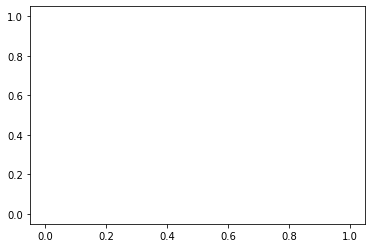

In [94]:
plt.plot(_x[200])

In [32]:
_y.shape

(247,)

In [74]:
print(len(all_ppg))
print(len(all_y))

241
241


In [75]:
all_ppg[0].shape

(659, 15360)

In [166]:
print(hz*win_size)

7680


In [80]:
# test_range = range(282,312,1)
test_range=range(0,241,1)
len(test_range)

241

In [78]:
# ray.shutdown()

In [79]:
# import ray
# if(ray.is_initialized() == False):
#     ray.init()


In [81]:


#Extract by Subject for AHI Estimation Validation
test_x_sub = []
test_y_sub = []
for i in test_range:
    print(i)
    test_ppg, test_y = get_subject_multi_y([i], all_ppg, all_y)
#     test_y = convert_y_to_hz(test_y, hz)
#     print(test_ppg.shape)
    training_set , training_y= mass_extraction(np.array(test_ppg).reshape(-1,hz*win_size),test_y)
    test_x_sub.append(training_set)
    test_y_sub.append(training_y)

0


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
1


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
2


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
3


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
6


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
8


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
9


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
10


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
12


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
13


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
14


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
17


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
18


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
20


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
25


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
26


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
29


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
31


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
32


  0%|          | 0/1 [00:00<?, ?it/s]

33


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
34


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
35


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
36


  0%|          | 0/1 [00:00<?, ?it/s]

37


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
38


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
42


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
45


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
47


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
48


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
49


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
52


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
57


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
59


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
60


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
61


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
62


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
66


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
67


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
69


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
70


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
71


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
74


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
75


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
76


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
77


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
78


  0%|          | 0/1 [00:00<?, ?it/s]

79


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
80


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
81


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
82


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
85


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
88


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
89


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
90


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

92


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
93


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
94


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

101


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
102


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

105


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
106


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
108


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
109


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
111


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
112


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
113


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
115


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
116


  0%|          | 0/1 [00:00<?, ?it/s]

117


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
118


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
119


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
120


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
123


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
124


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
126


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
127


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
128


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
129


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
132


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
133


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
134


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
135


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
136


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
137


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
140


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
142


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
143


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
144


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
145


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
147


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
148


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
149


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
152


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
153


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
154


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
157


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
158


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
160


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
162


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
163


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
164


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
165


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
167


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
168


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
169


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
171


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
172


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
173


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
175


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
176


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
178


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
180


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
184


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
185


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
188


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
189


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
192


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
194


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
195


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
198


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
199


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
201


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

203


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
206


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
207


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
211


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
212


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
213


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
215


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
217


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
220


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
221


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
222


  0%|          | 0/1 [00:00<?, ?it/s]

223


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
225


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
226


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
228


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
229


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
237


  0%|          | 0/1 [00:00<?, ?it/s]

238


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
239


  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows un

  0%|          | 0/1 [00:00<?, ?it/s]

PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation
PPG : Windows unable to meet expectation


In [52]:
np.array(test_x_sub).shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(30,)

In [167]:
test_y_sub[0][0].shape

NameError: name 'test_y_sub' is not defined

In [189]:
s0 =[]
sy0 = []
count_s =0
for s in test_x_sub:
    x0 =[]
    y0 =[]
    count_i = 0
    for i in s:
        try:
            print(i.shape)
            x0.append(i)
            y0.append(test_y_sub[count_s][count_i])
        except:
            print(type(i))
        count_i = count_i+1
    s0.append(np.array(x0))
    sy0.append(np.array(y0))
    count_s=count_s+1
s0 = np.array(s0)
sy0 = np.array(sy0)

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)


(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)


<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)

<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'None

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<cla

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)


(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneT

(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 6

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 6

(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)


(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
<class 'NoneType'>
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 60)
(7, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [210]:
s0[0].shape

(648, 7, 60)

In [199]:
sy0[0].shape

(648, 60)

In [200]:
test_x_sub = s0
test_y_sub = sy0

In [201]:
test_x_sub[0][0].shape

(7, 60)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


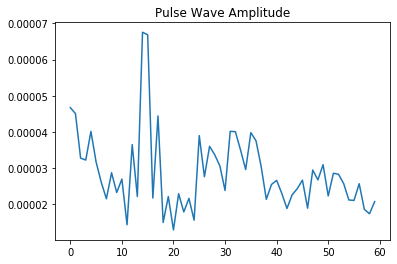

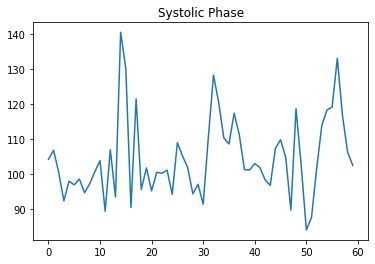

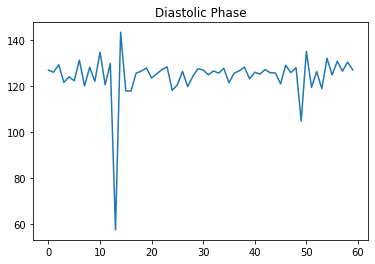

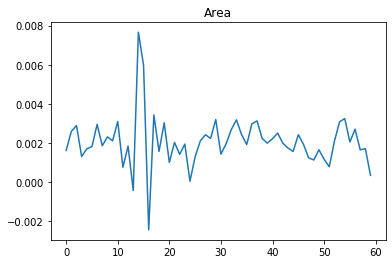

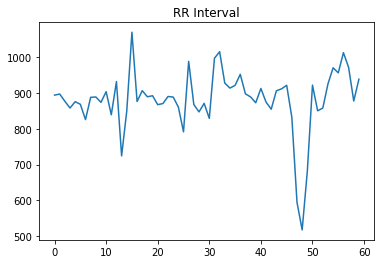

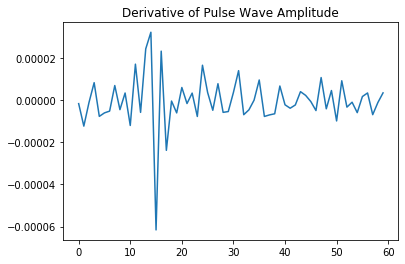

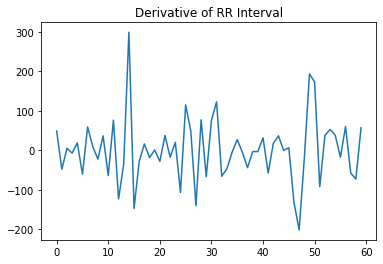

In [83]:
selection_no = 8
window_no = 85

print(test_y_sub[selection_no][window_no])
plt.title("Pulse Wave Amplitude")
plt.plot(test_x_sub[selection_no][window_no,0])
plt.figure()
plt.title("Systolic Phase")
plt.plot(test_x_sub[selection_no][window_no][1])
plt.figure()
plt.title("Diastolic Phase")
plt.plot(test_x_sub[selection_no][window_no][2])
plt.figure()
plt.title("Area")
plt.plot(test_x_sub[selection_no][window_no][3])
plt.figure()
plt.title("RR Interval")
plt.plot(test_x_sub[selection_no][window_no][4])
plt.figure()
plt.title("Derivative of Pulse Wave Amplitude")
plt.plot(test_x_sub[selection_no][window_no][5])
plt.figure()
plt.title("Derivative of RR Interval")
plt.plot(test_x_sub[selection_no][window_no][6])

IndexError: index 1000 is out of bounds for axis 0 with size 582

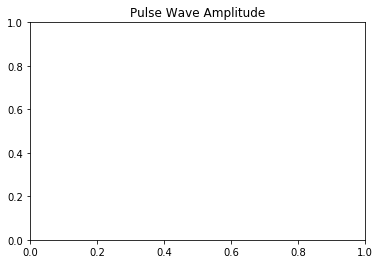

In [84]:
plt.title("Pulse Wave Amplitude")
plt.plot(training_set[1000,0])
plt.figure()
plt.plot(training_y[1000])

In [ ]:
plt.plot(training_set[1000,1])


In [ ]:
training_set.shape

In [85]:
training_set[:,0,:].shape

(582, 60)

In [86]:
y_subset = []
for i in training_y:
    un = np.unique(i,return_counts=True)
    if 1 in un[0] and 0 in un[0]:
        if un[1][1] > 640:
            y_subset.append(1)
            continue;
        else:
            y_subset.append(0)
    elif 1 in un[0]:
        y_subset.append(1)
        continue;
    else:
        y_subset.append(0)

In [42]:
training_x_apnea = []
training_x_normal =[]

for i,y in enumerate(y_subset):
    if(y == 0):
        training_x_normal.append(training_set[i])
    if(y == 1):
        training_x_apnea.append(training_set[i])
training_x_apnea = np.array(training_x_apnea)
training_x_normal =np.array(training_x_normal)

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

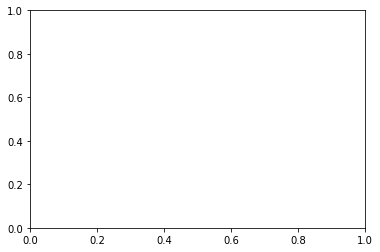

In [43]:

label = ["Normal","Apnea"]
# plt.boxplot(,label=label)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot([training_x_normal[:,0,:].reshape(-1),training_x_apnea[:,0,:].reshape(-1)], showfliers=False)
ax.set_title('Pulse Wave Amplitude')
ax.set_xlabel('Event')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot([training_x_normal[:,1,:].reshape(-1),training_x_apnea[:,1,:].reshape(-1)], showfliers=False)
ax.set_title('Systolic Phase')
ax.set_xlabel('Event')

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

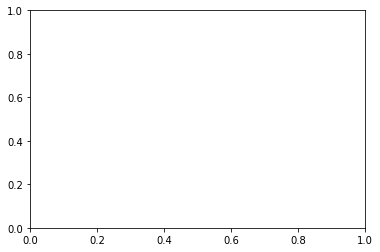

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot([training_x_normal[:,2,:].reshape(-1),training_x_apnea[:,2,:].reshape(-1)], showfliers=False)
ax.set_title('Diastolic Phase')
ax.set_xlabel('Event')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot([training_x_normal[:,3,:].reshape(-1),training_x_apnea[:,3,:].reshape(-1)], showfliers=False)
ax.set_title('Area')
ax.set_xlabel('Event')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot([training_x_normal[:,4,:].reshape(-1),training_x_apnea[:,4,:].reshape(-1)], showfliers=False)
ax.set_title('RR Interval')
ax.set_xlabel('Event')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: S

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

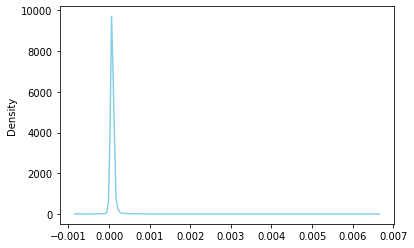

In [45]:
import seaborn as sns
sns.distplot(training_x_normal[:,0,:].reshape(-1),
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1},
            hist=False)
sns.distplot(training_x_apnea[:,0,:].reshape(-1),
                  bins=100,
                  kde=True,
                  color='red',
                  hist_kws={"linewidth": 15,'alpha':1},
            hist=False)

In [ ]:

    
path_dumpp = '../nas/NSRR/processed/pickle_set/mesa_by_subject_'

    
with open(path_dumpp+'_train_val_x_ppg.pickle', 'wb') as output:
    pickle.dump(test_x_sub, output, protocol=4)
with open(path_dumpp+'_train_val_y.pickle', 'wb') as output:
    pickle.dump(test_y_sub, output,protocol=4)
